# Вариационные автокодировщики

### Загрузка, нормировка и визуалиация данных

In [ ]:
"""
    Здесь я вместо нормального априорного p(z) беру для сэмплирования q_phi - точнее, средние значения для mu 
    sigma по всему батчу
"""

In [1]:
import torchvision.datasets

In [2]:
from torchvision.datasets import MNIST#, FashionMNIST
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import math
#dtype = torch.cuda.FloatTensor
import chainer

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    x = x.view(-1, 30, 30)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.data[i].numpy())
        plt.axis('off')

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

def show_images(x):
    plt.figure(figsize=(20, 20 / 10 * (x.shape[0] // 10 + 1)))
    x = x.view(-1, 30, 30)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.data[i].numpy())
        plt.axis('off')

In [5]:
data = MNIST('mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255, data.train_labels)
#data = pkl.load(open('test_data','rb'))
data = MNIST('mnist', download=True, train=False)
test_data = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255, data.test_labels)

In [6]:
import numpy as np
data = np.load('/home/sayankotor/data/calo_gan_data/electrons_1_100_1D__v2_50K.npz')
data_img = (data['EnergyDeposit'])
data_img.shape

(50000, 30, 30)

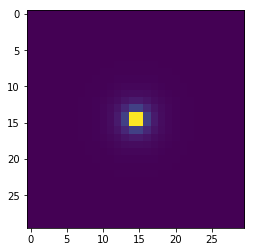

In [7]:
plt.imshow(data_img.mean(0))
plt.show()

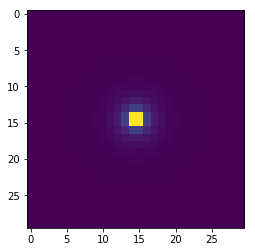

In [8]:
plt.imshow(data_img.std(0))
plt.show()

In [9]:
n_data_img = []

min_ = np.min(data_img)
max_ = np.max(data_img)

for i, elem in enumerate(data_img):
    if (i%5000 == 0):
        print (i)
    n_elem = elem /(max_ - min_)
    n_data_img.append(n_elem)
n_data_img = np.array(n_data_img)


n_data_img_1 = []
print(type(n_data_img_1))

mean = n_data_img.mean(0)
std = n_data_img.std(0)

#for i, elem in enumerate(n_data_img):
    #if (i%5000 == 0):
        #print (i)
    #n_elem = (elem - mean)
    #n_elem = np.true_divide(n_elem, std)
    #n_data_img_1.append(n_elem)
#n_data_img_1 = np.array(n_data_img_1)


0
5000
10000
15000
20000
25000
30000
35000
40000
45000
<class 'list'>


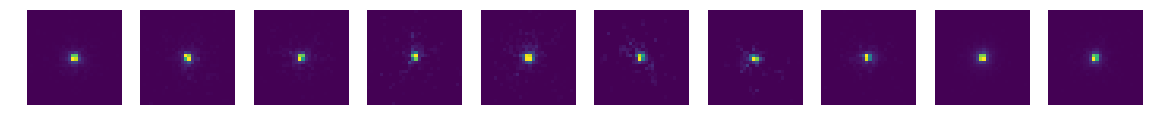

In [10]:
show_images(Variable(torch.from_numpy(n_data_img[20:30])))

In [11]:
min_ = np.min(n_data_img+1e-8)
max_ = np.max(n_data_img)
print(min_, max_)

1e-08 1.0


In [12]:
#n_data_img = np.log(n_data_img)

In [13]:
min_ = np.mean(n_data_img)
max_ = np.std(n_data_img)
print(min_, max_)

0.00187287233737 0.0182712107091


## loss function ##

In [14]:
np.std(n_data_img)

0.018271210709116224

In [15]:
import chainer

In [16]:

def reconstruction_loss_gauss_chain(x_true_object, mu_generative_distr, sigma_generative_distr):
    """
    Вычисляет бинарную кроссэнтропию между эмприческим распределением на данные
    и индуцированным моделью распределением, т. е. правдоподобие объектов x_true.
    Каждому объекту из x_true соответствуют K сэмплированных распределений
    на x из x_distr.
    i-му объекту соответствуют распределения с номерами i * K, ..., (i + 1) * K - 1.
    Требуется вычислить оценку логарифма правдоподобия для каждого объекта.
    Подсказка: не забывайте про вычислительную стабильность!

    Вход: x_true, Variable - матрица объектов размера n x D.
    Вход: x_distr, Variable - матрица параметров распределений Бернулли
    размера (n * K) x D.
    Выход: Variable, матрица размера n x K - оценки логарифма правдоподобия
    каждого сэмпла.
    """
    answ = chainer.functions.gaussian_nll(x_true_object.data.numpy(), mu_generative_distr.data.numpy(), sigma_generative_distr.data.numpy())
    return answ


def reconstruction_loss_gauss(x_true_object, mu_generative_distr, sigma_var):
    print("mu_generative_distr.shape", mu_generative_distr.shape)
    #print ("log sigma_var ", log_sigma_var)
    #print ("sigma ", sigma)
    #print ("log sigma_var ", log_sigma_var)
    #print ("torch min ", torch.min(sigma))
    #print ("torch max ", torch.max(sigma))
    log_sigma = torch.log(sigma_var)
    print ("log_sigma ", log_sigma.sum())
    x_diff = x_true_object - mu_generative_distr
    x_power = (x_diff * x_diff) * -0.5/ sigma_var 
    print ("x_diff, x_power ", x_diff.mean(), x_power.mean() )
    #print ("x_power ", x_power.sum())
    loss = (log_sigma + math.log(2 * math.pi)) / 2 - x_power
    return torch.sum(loss, 1)


In [17]:
def kl1(q_distr, p_distr):
    """
    Вычисляется KL-дивергенция KL(q || p) между n парами гауссиан.
    Вход: q_distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
    Первое - mu, второе - sigma.
    Вход: p_distr, tuple(Variable, Varable). Аналогично.
    Возвращаемое значение: Variable, вектор размерности n, каждое значение которого - 
    - KL-дивергенция между соответствующей парой распределений.
    """
    mu_q, sigma_q = q_distr
    mu_p, sigma_p = p_distr
    mu_q = mu_q.float()
    mu_p = mu_p.float()
    sigma_q = sigma_q.float()
    sigma_p = sigma_p.float()
    #без этого нет стабильности и лосс улетает в нан
    sigma_q_log = torch.log(torch.clamp(sigma_q, 1-1e8, 1e-8))
    sigma_p_log = torch.log(torch.clamp(sigma_p, 1-1e8, 1e-8))

    d = mu_q.shape[1]
    res = - float(d) + sigma_p_log.sum(dim = 1) - sigma_q_log.sum(dim = 1)
    res += (sigma_q/ sigma_p).sum(dim =1)
    res += torch.sum((mu_p - mu_q) * (mu_p - mu_q) / sigma_p, dim =1)
    return 0.5 * res
    

In [18]:
def kl(q_distr, p_distr):
    m1, s1 = q_distr
    m2, s2 = p_distr
    n = m1.shape[0]
    assert(m2.shape[0] == n)
    s1 = (torch.clamp(s1, 1-1e8, 1e-8))
    s2 = (torch.clamp(s2, 1-1e8, 1e-8))
    kldiv = (torch.log(s2) - torch.log(s1) + 0.5 * ((s1**2 + (m1 - m2)**2) / (s2**2) - 1)).sum(1)
    assert(len(kldiv.shape) == 1 and kldiv.shape[0] == n)
    #print ("kldiv", kldiv.mean())
    return kldiv

## model

In [19]:
from torch.distributions import Normal, Bernoulli
from chainer.functions.math import exponential

class VAE(nn.Module):
    def __init__(self, d, D):
        """
        Инициализирует веса модели.
        Вход: d, int - размерность латентного пространства.
        Вход: D, int - размерность пространства объектов.
        """
        super(type(self), self).__init__()
        self.d = d
        self.D = D
        self.proposal_network = nn.Sequential(
            nn.Linear(self.D, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 200),
            nn.LeakyReLU(),
        )
        self.proposal_mu_head = nn.Linear(200, self.d)
        self.proposal_sigma_head = nn.Linear(200, self.d)
        self.generative_network = nn.Sequential(
            nn.Linear(self.d, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 200),
            nn.LeakyReLU()
        )
        self.generative_mu_head = nn.Linear(200, self.D)
        self.generative_sigma_head = nn.Sequential(nn.Linear(200, self.D), nn.Softplus())

    def proposal_distr(self, x):
        """
        Генерирует предложное распределение на z.
        Вход: x, Variable - матрица размера n x D.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        q_teta = self.proposal_network.forward(x)
        return self.proposal_mu_head(q_teta), torch.exp(self.proposal_sigma_head(q_teta))

    def prior_distr(self, n):
        """
        Генерирует априорное распределение на z.
        Вход: n, int - число распределений.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        mu = Variable(torch.Tensor(n, self.d).fill_(0).float())
        sigma = Variable(torch.Tensor(n, self.d).fill_(1).float())
        return mu, sigma

    def sample_latent(self, distr, K=1):
        """
        Генерирует сэмплы из гауссовского распределения на z.
        Сэмплы должны быть дифференцируемы по параметрам распределения!
        Вход: distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        Вход: K, int - число сэмплов для каждого объекта.
        Возвращаемое значение: Variable, матрица размера n x d.
        """
    
        mu, sigma = distr
        eps = torch.from_numpy(
            np.random.normal(0, 1, size=(K * sigma.shape[0], sigma.shape[1]))).float()
        return mu.repeat(K, 1) + sigma.repeat(K, 1) * Variable(eps, requires_grad=False)
        

    def sample_prior(self, num_samples):
        """
        Генерирует сэмплы из априорного распределения на z.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x d.
        """
        m = Normal(torch.Tensor(self.d).fill_(0), torch.Tensor(self.d).fill_(1))
        answ = Variable(m.sample_n(num_samples))
        print ("sample_prior ", answ.shape)
        return answ
    
    def sample_prior1(self, num_samples):
        """
        Генерирует сэмплы из априорного распределения на z.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x d.
        """
        m = Normal(self.latent_mu, self.latent_sigma)
        answ = m.sample_n(num_samples)
        print ("sample_prior1 ", answ.shape)
        return answ
        

    def generative_distr(self, z):
        """
        По матрице латентных представлений z возвращает матрицу параметров
        распределения Бернулли для сэмплирования объектов x.
        Вход: z, Variable - матрица n x d латентных представлений.
        Возвращаемое значение: Variable, матрица параметров распределения
        Бернулли размера n x D.
        """
        int_distr = self.generative_network(z)
        return (self.generative_mu_head(int_distr), self.generative_sigma_head(int_distr))

    def batch_loss(self, batch, K, isp = False):
        """
        Вычисляет вариационную нижнюю оценку логарифма правдоподобия по батчу
        используя K сэмплов для каждого объекта.
        Вариационная нижняя оценка должна быть дифференцируема по параметрам модели (!),
        т. е. надо использовать репараметризацию.
        Вход: batch, Variable - матрица объектоа размера n x D.
        Вход: K, int - число сэмплов для каждого объекта, не используется.
        Возвращаемое значение: Variable, скаляр - вариационная нижняя оценка
        правдоподобия по батчу.
        
        sample_prior - генерирует объекты z в латентном пространстве меньшей размерности
        
        generative_distr - по этим объектам порождает параметры распределения, которое будет 
        генерировать объекты в реальном пр-ве 
        
        есть параметры, есть изначальный батч
        насколько изначальный батч соответствует распределению с генерированными параметрами - 
        это и есть RECONSTRUCTION LOSS
        
        """
        batch = Variable(batch)
        q_phi = self.proposal_distr(batch)
        z = self.sample_latent(q_phi, K)
        #self.latent_mu = q_phi[0]
        print ("latent mu, latent sigma ", torch.mean(q_phi[0], 0).shape, torch.mean(q_phi[1], 0).shape)
        self.latent_mu = torch.mean(q_phi[0], 0)
        self.latent_sigma = torch.mean(q_phi[1], 0)
        
        mu, sigma = self.generative_distr(z)
        sigma = torch.clamp(sigma, min = 1e-8)
        print ("sigma ", sigma)
        #m = Normal(mu, torch.exp(log_sigma)) 
        # = m.sample()
        answ1 = reconstruction_loss_gauss(batch, mu, sigma)
        print ("mu ", mu)
        answ_chain = reconstruction_loss_gauss_chain(batch, mu, sigma)
        
        mu_prior, sigma_prior = self.prior_distr(batch.shape[0])
        print ("q_phi mu ", q_phi[0][:5])
        print ("q_phi sigma ", q_phi[1][:5])
        answ2 = kl(q_phi, (mu_prior, sigma_prior))
        a = self.generate_samples1(3)
        print("batch_loss: loss_chain, loss_simple, KL", answ_chain.data.mean(), answ1.data.mean() , answ2.data.mean() )
        #print ("shapes ", answ1.view(-1).shape,  answ2.shape)
        return torch.mean(answ1) + torch.mean(answ2) 


    def generate_samples(self, num_samples):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x D.
        """
        mu, sigma = self.generative_distr(self.sample_prior(num_samples))   
        print ("generate_samples ", mu.shape, sigma.shape)
        m = Normal(mu, sigma)
        answ = m.sample()  
        return answ
    
    def generate_samples1(self, num_samples):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x D.
        """
        mu, sigma = self.generative_distr(self.sample_prior1(num_samples))   
        print ("generate_samples ", mu.shape, sigma.shape)
        m = Normal(mu, sigma)
        answ = m.sample()  
        return answ

In [20]:
def sample_data_batch(bsize, data_):
    idxs = np.random.choice(np.arange(data_.shape[0]), size=bsize)
    return torch.FloatTensor(data_[idxs])

In [21]:
shapes = data_img.shape
n_data_img = n_data_img.reshape([shapes[0], shapes[1]*shapes[2]])

In [22]:
a = sample_data_batch(100, n_data_img)
print (type(a))
a.shape

<class 'torch.FloatTensor'>


torch.Size([100, 900])

In [25]:
import random

shapes = data_img.shape
#random.seed()
def train_model(model, tests=[], batch_size=100, K=1, num_epochs=5, learning_rate=1e-4):
    model.generative_network.train() 
    """
    Обучает модель.
    Вход: model, Module - объект, модель.
    У этого объекта должна быть функция batch_loss от batch - FloatTensor и K - int,
    возвращающая скаляр Variable - функцию потерь на батче, которая должна быть
    оптимизирована.
    Вход: tests - список тестов, выполняемых после каждого 100-го батча.
    Каждый элемент списка - словарь с полями 'name' - уникальным идентификатором
    теста и 'func' - функцией от модели.
    Вход: batch_size, int.
    Вход: K, int.
    Вход: num_epochs, int.
    Вход: learning_rate, float.
    Возвращаемое значение: словарь с полями 'model' - обученная модель,
    'train_losses_list' - список функций потерь на каждом батче и 
    'test_results' - список результатов тестирования. Каждый результат
    тестирования - словарь вида name: value, где name - имя теста,
    value - результат его выполнения.
    """
    gd = optim.Adam(model.parameters(), lr=learning_rate)
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    train_losses = []
    test_results = []
    for _ in range(num_epochs):
        print ("epoch:", _)
        #for i in range(500):
        for i, (batch, _) in enumerate(dataloader):
            #total = len(dataloader)
            total = 500
            batch = sample_data_batch(100, n_data_img)
            loss = model.batch_loss(batch, K)
            #loss = loss_[0] + loss_[1]
            #if (loss_[0].data[0] < 300.0):
                #print ("loss 0", loss_[0].data[0])
                #return {
                    #'model': model,
                    #'train_losses_list': train_losses,
                    #'test_results': test_results
                #}
            (loss).backward()
            #print (loss.shape)
            
            train_losses.append(loss.data.numpy()[0])
            if (i + 1) % 10 == 0:
                print('\rTrain loss:', train_losses[-1],
                      'Batch', i + 1, 'of', total, ' ' * 10, end='', flush=True)
            if (i + 1) % 100 == 0:
                cur_test_result = {}
                for test in tests:
                    cur_test_result[test['name']] = test['func'](model)
                test_results.append(cur_test_result)
                print(flush=True)
            gd.step()
            gd.zero_grad()
    return {
        'model': model,
        'train_losses_list': train_losses,
        'test_results': test_results
    }

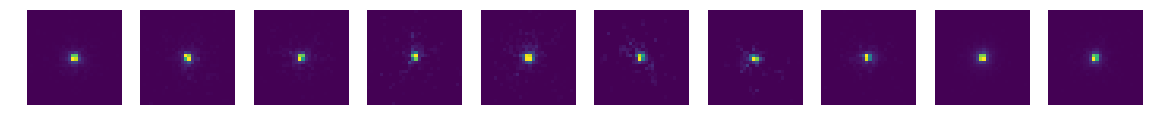

In [26]:
show_images(Variable(torch.from_numpy(n_data_img[20:30])))

In [27]:
vae_model_d2_k1 = train_model(VAE(5, 900), tests=[])

epoch: 0
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.7489  0.6610  0.7124  ...   0.7576  0.7251  0.7452
 0.7356  0.5924  0.6905  ...   0.7918  0.5956  0.7724
 0.7379  0.6839  0.7195  ...   0.7336  0.6611  0.7787
          ...             ⋱             ...          
 0.7470  0.6487  0.7054  ...   0.7605  0.7330  0.7185
 0.7427  0.6229  0.7354  ...   0.7556  0.7040  0.7913
 0.7483  0.6485  0.7117  ...   0.8373  0.6591  0.7897
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-33034.4023
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  4.7891
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-03 *
 -8.9637
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.2694e-01 -1.3419e-01 -9.0230e-02  ...   6.3324e-02  8.9610e-02 -1.5968e-01
 3.6839e-01 -1.7222e-01 -2.6387e-01  ...   1.3032e-01  1.4230e-01 -8.2942e-02
 8.0518e-02 -3.9791

q_phi sigma  Variable containing:
 0.9774  1.0474  0.9859  1.0107  0.9442
 0.9777  1.0472  0.9855  1.0110  0.9439
 0.9771  1.0470  0.9877  1.0070  0.9450
 0.9769  1.0469  0.9875  1.0074  0.9456
 0.9766  1.0456  0.9878  1.0010  0.9457
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 114021.0 665.9331420898437 36429953331363.84
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.7372  0.6553  0.7027  ...   0.7550  0.6923  0.7355
 0.7178  0.6463  0.7317  ...   0.7473  0.6670  0.7820
 0.7352  0.6782  0.6688  ...   0.7760  0.6787  0.7573
          ...             ⋱             ...          
 0.7410  0.6109  0.7232  ...   0.8159  0.6815  0.7758
 0.7314  0.6630  0.7209  ...   0.7375  0.6634  0.7846
 0.7888  0.5945  0.7406  ...   0.7735  0.6750  0.8198
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_s

Train loss: 2.84258e+13 Batch 10 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.7425  0.6479  0.6993  ...   0.7438  0.6512  0.7501
 0.7377  0.6320  0.6781  ...   0.7516  0.7104  0.7043
 0.7960  0.6246  0.6884  ...   0.7693  0.5927  0.7445
          ...             ⋱             ...          
 0.7072  0.6536  0.7080  ...   0.7253  0.6587  0.7556
 0.7041  0.6442  0.7036  ...   0.7375  0.6553  0.7749
 0.7521  0.6257  0.7136  ...   0.8028  0.6439  0.7744
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-34466.1055
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  3.1364
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-03 *
 -6.4723
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.5573e-02 -2.5265e-02  1.8657e-02  ...   6.5697e-02  4.4369e-02 -1.1503e-02
 1.6521e-01 -1.1112e-01 -2.7942e-02  ...   1.2643e-01  9

sigma  Variable containing:
 0.7573  0.6507  0.6309  ...   0.7898  0.6506  0.7273
 0.6950  0.6124  0.7190  ...   0.7563  0.6433  0.8065
 0.7193  0.6177  0.7088  ...   0.7794  0.6354  0.7704
          ...             ⋱             ...          
 0.8666  0.6208  0.7434  ...   0.7864  0.6073  0.7899
 0.7314  0.6397  0.7208  ...   0.7541  0.6853  0.7402
 0.7417  0.6410  0.7134  ...   0.7620  0.6831  0.7452
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-35045.0156
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  2.8644
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-03 *
 -5.8982
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.5463e-01 -1.1224e-01  1.8405e-02  ...   1.0061e-01 -2.6535e-02 -7.1661e-02
 7.4783e-02  4.6214e-03 -1.4393e-02  ...  -5.4411e-02  1.1083e-01 -1.2172e-01
 1.0006e-01 -4.0613e-02 -4.7450e-02  ...   3.1562e-02  6.5270e-02 -4.2056e-02
       

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.7447  0.6782  0.6794  ...   0.7576  0.6270  0.7348
 0.7210  0.5997  0.7142  ...   0.7335  0.7137  0.7081
 0.7139  0.5973  0.7209  ...   0.7999  0.6222  0.7852
          ...             ⋱             ...          
 0.7313  0.6208  0.6842  ...   0.7450  0.6361  0.7405
 0.7119  0.5765  0.6933  ...   0.7550  0.6386  0.7235
 0.6977  0.6000  0.7177  ...   0.7815  0.6734  0.7505
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-35767.7070
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  3.3931
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-03 *
 -5.6913
[torch.FloatTensor of size 1]

mu  Variable containing:
-8.7096e-03  6.6446e-02  6.0366e-02  ...   1.1997e-01  4.5762e-02 -5.7414e-02
 1.2621e-01 -1.9379e-01 -1.7175e-01  ...  -2.0495e-03  1.0388e-01 -1.2834e-01
 1.1269e-01 -2.0301e-02 -7.6

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.7223  0.6338  0.6818  ...   0.7691  0.6133  0.7524
 0.7510  0.5550  0.7775  ...   0.8257  0.6301  0.7857
 0.7124  0.6233  0.6856  ...   0.7427  0.6886  0.7277
          ...             ⋱             ...          
 0.6940  0.6233  0.6837  ...   0.7233  0.6475  0.7475
 0.6868  0.5955  0.6944  ...   0.7502  0.6768  0.7182
 0.7084  0.5680  0.7445  ...   0.7601  0.6490  0.8331
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-36536.4375
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  2.6173
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-03 *
 -5.3477
[torch.FloatTensor of size 1]

mu  Variable containing:
 7.7172e-02 -5.1381e-02  1.4733e-03  ...   4.1253e-02  3.6061e-02 -1.1417e-01
 3.1111e-01 -1.9526e-01 -8.4723e-02  ...  -5.9532e-02  2.5132e-02  3.8130e-03
 6.8298e-02 -8.1221e-02  5.5

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.7186  0.5326  0.7568  ...   0.8391  0.5629  0.8506
 0.6942  0.6467  0.7198  ...   0.7217  0.6287  0.7544
 0.7042  0.5916  0.7197  ...   0.7669  0.6380  0.7829
          ...             ⋱             ...          
 0.7016  0.6339  0.7056  ...   0.7474  0.6559  0.7224
 0.7030  0.6155  0.7060  ...   0.7100  0.6383  0.7446
 0.7110  0.5767  0.6475  ...   0.7533  0.6165  0.7392
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-37834.3945
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  3.3774
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-03 *
 -5.9656
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.0397e-01  2.6917e-02 -1.6942e-01  ...  -1.2563e-01  8.8605e-02 -1.2868e-01
 2.6133e-03 -2.6105e-02  8.6230e-02  ...   1.7186e-02  1.3871e-01 -1.3834e-01
 9.5321e-02 -1.1176e-02  5.4

Train loss: 7.68051e+12 Batch 30 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.7103  0.6065  0.7003  ...   0.7305  0.5662  0.7785
 0.7054  0.5695  0.7280  ...   0.7722  0.6277  0.7872
 0.6861  0.5980  0.6709  ...   0.7834  0.5806  0.7529
          ...             ⋱             ...          
 0.8168  0.5382  0.6829  ...   0.7393  0.5817  0.7812
 0.7031  0.5699  0.7412  ...   0.7228  0.6561  0.7838
 0.6942  0.6068  0.6700  ...   0.7777  0.6167  0.7532
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-38790.3789
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  2.9446
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-03 *
 -5.3515
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.6800e-02  1.1404e-01  3.6315e-02  ...   2.8360e-02  7.8698e-02 -3.6957e-02
 1.1680e-01 -2.7704e-02 -2.4596e-02  ...  -8.7253e-02  7

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.6660  0.5876  0.7010  ...   0.8087  0.6022  0.7323
 0.6523  0.5558  0.6709  ...   0.7794  0.5428  0.7431
 0.6930  0.6013  0.6858  ...   0.7434  0.5941  0.7713
          ...             ⋱             ...          
 0.7357  0.5036  0.7278  ...   0.8188  0.5301  0.7959
 0.7160  0.5638  0.7036  ...   0.7365  0.6457  0.7153
 0.7017  0.5787  0.6808  ...   0.7624  0.6138  0.7516
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-40284.4531
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  3.4214
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-03 *
 -5.4313
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.4889e-02 -1.1572e-01 -5.9866e-02  ...   7.7403e-02  7.3592e-02 -6.3009e-02
 6.0489e-02 -1.3896e-01 -3.7295e-02  ...   6.7452e-02  1.0111e-01 -1.8359e-01
 1.6255e-02  1.2870e-01  3.1

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.6738  0.5516  0.7141  ...   0.7262  0.6480  0.7331
 0.6721  0.5178  0.7303  ...   0.7451  0.6242  0.7543
 0.6821  0.5682  0.7037  ...   0.7278  0.6029  0.7420
          ...             ⋱             ...          
 0.7491  0.5736  0.6276  ...   0.7506  0.5702  0.7196
 0.6452  0.5305  0.6791  ...   0.7450  0.5619  0.7875
 0.7142  0.5584  0.6695  ...   0.7075  0.5878  0.7208
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-41800.2305
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  3.0068
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-03 *
 -5.5114
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.5808e-01 -2.2228e-01 -4.0223e-02  ...  -5.1720e-02  1.8148e-01 -1.9410e-03
 1.1339e-01 -1.4729e-01  1.1736e-01  ...  -7.3823e-02  1.2358e-01 -1.6483e-01
 7.3998e-02 -7.6598e-02  2.7

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.6671  0.5618  0.6732  ...   0.7006  0.6087  0.6823
 0.7515  0.5377  0.6647  ...   0.7233  0.5501  0.7340
 0.6159  0.4476  0.6337  ...   0.7255  0.4640  0.7360
          ...             ⋱             ...          
 0.6634  0.4748  0.7274  ...   0.8078  0.5326  0.8012
 0.6792  0.5784  0.6524  ...   0.7412  0.5697  0.7381
 0.6966  0.5773  0.6772  ...   0.7462  0.5925  0.7277
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-43949.8320
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  2.7034
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-03 *
 -5.2933
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.7636e-02 -1.7283e-01 -3.1598e-02  ...  -9.9456e-04  1.6794e-01 -7.6707e-02
 1.4375e-01 -1.3948e-02  3.4931e-03  ...  -1.0193e-02  1.4409e-02  9.0034e-02
-5.6948e-02  1.3416e-01 -5.9

x_diff, x_power  Variable containing:
1.00000e-03 *
  2.4477
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-03 *
 -5.4817
[torch.FloatTensor of size 1]

mu  Variable containing:
-6.9448e-02  3.3876e-02  8.4699e-02  ...   1.5410e-02 -3.6100e-02 -4.9087e-02
-2.6425e-02 -4.4890e-02 -4.7660e-02  ...   9.0058e-02 -2.9050e-03  8.5184e-02
 1.0507e-01  2.6713e-01 -1.7023e-01  ...  -1.0912e-01 -5.1653e-02  5.5070e-02
                ...                   ⋱                   ...                
-5.7032e-02  6.9731e-02  1.0157e-01  ...  -7.9029e-03  6.3739e-03 -5.3084e-02
-3.0425e-02  2.3234e-01  9.5323e-02  ...  -2.1406e-02  5.3888e-02  1.8831e-02
 1.1412e-01 -8.3707e-02 -7.4230e-02  ...  -6.3759e-02  1.2858e-01 -1.0642e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-02 *
  1.2456 -1.4132  0.4642 -0.0096  0.0765
  1.1507 -1.3708  0.3895 -0.0115  0.1083
  1.2640 -1.4365  0.4955 -0.0059  0.0660
  1.2726 -1.4453  0.4945 -0.0118  0.0762
  1.1818 -1.3732

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.6294  0.5256  0.6490  ...   0.7042  0.5314  0.7172
 0.6770  0.4649  0.6083  ...   0.6669  0.4063  0.6482
 0.6260  0.5349  0.6865  ...   0.7220  0.5591  0.7123
          ...             ⋱             ...          
 0.6632  0.5693  0.6655  ...   0.7046  0.5721  0.7073
 0.6589  0.4791  0.6096  ...   0.6947  0.4930  0.6719
 0.6629  0.5513  0.6696  ...   0.6940  0.5717  0.7161
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-50436.8555
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  9.9231
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-03 *
 -4.9856
[torch.FloatTensor of size 1]

mu  Variable containing:
-7.8554e-02  1.7391e-01  7.6051e-02  ...  -9.5939e-04  1.8305e-02  4.1612e-03
 7.2961e-04  1.4718e-01 -4.0322e-02  ...  -6.3209e-03 -8.0209e-02  1.5838e-01
-4.5073e-02  6.9229e-03 -1.4

sigma  Variable containing:
 0.6213  0.5092  0.6253  ...   0.6953  0.5090  0.6917
 0.6482  0.4836  0.6303  ...   0.6863  0.5723  0.6303
 0.6453  0.5042  0.5826  ...   0.7059  0.4848  0.6397
          ...             ⋱             ...          
 0.6245  0.4488  0.5826  ...   0.6707  0.5636  0.6179
 0.6363  0.4693  0.6632  ...   0.6844  0.5194  0.6707
 0.5974  0.4501  0.5829  ...   0.6484  0.4544  0.6350
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-55078.5156
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  9.3333
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-03 *
 -5.9660
[torch.FloatTensor of size 1]

mu  Variable containing:
-5.8938e-02  9.9158e-03  3.7116e-02  ...   4.3026e-02 -9.7578e-03  1.5128e-02
 8.7725e-02 -9.2264e-02  1.4874e-03  ...   8.0563e-02  1.6153e-02  1.5646e-02
-1.9954e-01  1.8524e-02  7.2734e-02  ...   8.7781e-02 -1.6838e-01  1.2278e-02
       

Train loss: 6.82958e+11 Batch 60 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.6633  0.4186  0.5897  ...   0.6437  0.4078  0.6202
 0.6329  0.3864  0.6205  ...   0.6555  0.4404  0.6533
 0.6053  0.4208  0.6175  ...   0.6709  0.4823  0.6164
          ...             ⋱             ...          
 0.6335  0.4689  0.5668  ...   0.6619  0.4912  0.6723
 0.5782  0.3714  0.6072  ...   0.6424  0.4275  0.6397
 0.5843  0.4317  0.6202  ...   0.6693  0.4356  0.6744
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-58785.3867
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.6569
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-03 *
 -5.6140
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.9865e-02  7.3022e-02 -3.4741e-02  ...  -6.1218e-05 -1.3123e-01  1.2001e-01
 1.3492e-01  2.0665e-02 -6.0447e-02  ...  -3.7281e-02 -1

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.5817  0.4625  0.5926  ...   0.6239  0.4915  0.6109
 0.5976  0.4358  0.6543  ...   0.6316  0.5255  0.6648
 0.6158  0.4615  0.6079  ...   0.6513  0.5105  0.6383
          ...             ⋱             ...          
 0.6357  0.5366  0.6362  ...   0.6802  0.5524  0.6483
 0.6217  0.4662  0.5759  ...   0.6528  0.4667  0.6039
 0.5318  0.3452  0.5124  ...   0.5368  0.4195  0.5293
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-63129
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.2532
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-03 *
 -5.8707
[torch.FloatTensor of size 1]

mu  Variable containing:
-6.8335e-02  2.6903e-02  1.4907e-01  ...   3.5257e-02 -1.2902e-02 -4.1188e-02
 1.0010e-01 -8.7305e-02 -1.0502e-02  ...  -6.7070e-02  9.4079e-02  1.5631e-02
-2.6549e-02  2.0879e-02  7.7702e-

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.5910  0.4226  0.5995  ...   0.6669  0.4879  0.6152
 0.5246  0.3328  0.4942  ...   0.5913  0.4099  0.5130
 0.6178  0.4262  0.5724  ...   0.6279  0.4597  0.6277
          ...             ⋱             ...          
 0.5508  0.4114  0.6179  ...   0.6220  0.4716  0.6317
 0.5748  0.3811  0.4834  ...   0.6059  0.3831  0.5505
 0.5589  0.4428  0.5909  ...   0.6513  0.4701  0.6359
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-67850.3281
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
 -1.3755
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-03 *
 -5.3776
[torch.FloatTensor of size 1]

mu  Variable containing:
 7.4174e-02 -3.3268e-02  4.0297e-02  ...   5.1355e-02  3.1828e-02  5.9915e-02
 8.5031e-02 -1.3324e-01 -3.7090e-02  ...   5.1476e-02 -7.8254e-02 -1.7498e-02
 5.3231e-03  1.2413e-02  1.1

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.4787  0.2567  0.4742  ...   0.5356  0.3370  0.4690
 0.4712  0.3715  0.5427  ...   0.5744  0.3988  0.5303
 0.5622  0.3981  0.5805  ...   0.6137  0.4523  0.6070
          ...             ⋱             ...          
 0.5818  0.4767  0.5879  ...   0.6339  0.4800  0.6177
 0.5387  0.3903  0.5543  ...   0.6005  0.4507  0.5790
 0.5418  0.3703  0.5951  ...   0.6075  0.4592  0.5728
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-77052.8203
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.1419
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-03 *
 -6.9448
[torch.FloatTensor of size 1]

mu  Variable containing:
 7.7609e-02  7.4392e-02  2.6367e-02  ...  -6.5299e-02  4.7501e-02  2.9312e-02
-8.5074e-02 -8.6114e-02 -3.0825e-02  ...   8.0287e-02 -3.4003e-02 -9.1281e-02
-3.8651e-02  5.8351e-02 -5.7

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.5585  0.3872  0.5135  ...   0.5678  0.4193  0.5579
 0.5505  0.3677  0.4987  ...   0.5581  0.4008  0.5340
 0.4290  0.2712  0.4657  ...   0.4662  0.3213  0.4994
          ...             ⋱             ...          
 0.4229  0.2535  0.4718  ...   0.5392  0.2758  0.5084
 0.3988  0.1890  0.4311  ...   0.4232  0.2816  0.4402
 0.4802  0.2725  0.4535  ...   0.5419  0.3455  0.5003
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-83770.4922
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-06 *
  3.2878
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-03 *
 -6.7340
[torch.FloatTensor of size 1]

mu  Variable containing:
-7.0082e-02 -5.1462e-02  1.3590e-02  ...   7.6824e-03 -2.4163e-02 -1.0434e-02
 1.2430e-02  4.5643e-02 -3.3617e-02  ...   4.3725e-03 -1.3838e-02  1.0461e-01
 3.3922e-05  7.5191e-02  5.7

Train loss: 1.99575e+11 Batch 80 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.3942  0.2370  0.4782  ...   0.4639  0.3448  0.4522
 0.4878  0.3182  0.4949  ...   0.5291  0.3980  0.5014
 0.4623  0.3003  0.4881  ...   0.5269  0.3665  0.5040
          ...             ⋱             ...          
 0.4533  0.3292  0.4732  ...   0.5499  0.3322  0.5116
 0.5356  0.3875  0.5259  ...   0.5766  0.4444  0.5275
 0.4038  0.2095  0.4839  ...   0.4551  0.3029  0.4999
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-89625.5312
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.4638
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-03 *
 -6.7857
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.0294e-01 -9.2706e-02  7.2810e-02  ...  -3.7880e-02  6.9713e-02  7.6657e-02
 1.2547e-02 -1.0909e-01  2.6816e-02  ...  -1.6419e-02  1

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.4256  0.2605  0.4264  ...   0.4443  0.3448  0.3906
 0.4576  0.3311  0.5179  ...   0.5437  0.3727  0.5103
 0.3084  0.1625  0.3033  ...   0.4020  0.2339  0.3062
          ...             ⋱             ...          
 0.5045  0.3579  0.5194  ...   0.5300  0.3993  0.5477
 0.4336  0.2848  0.4541  ...   0.4801  0.3421  0.4721
 0.4995  0.3419  0.5204  ...   0.5442  0.4204  0.5177
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -1.0291
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.4408
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-03 *
 -9.1238
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.0732e-01 -1.1868e-01 -5.0165e-02  ...  -1.3814e-02  1.1644e-01 -1.2552e-01
-3.9315e-02 -4.7618e-02 -6.0897e-02  ...   7.8602e-05  1.0889e-01 -4.5554e-02
 7.9586e-02 -1.74

sigma  Variable containing:
 0.3956  0.2266  0.4585  ...   0.4406  0.3220  0.4616
 0.3734  0.2286  0.4306  ...   0.4044  0.2908  0.4418
 0.5110  0.3924  0.5372  ...   0.5684  0.4289  0.5366
          ...             ⋱             ...          
 0.2751  0.1258  0.3566  ...   0.3250  0.2127  0.3565
 0.4529  0.2793  0.4406  ...   0.4706  0.3588  0.4269
 0.3245  0.1887  0.4037  ...   0.4488  0.2194  0.4355
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -1.0984
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.7341
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-03 *
 -8.4692
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.7706e-02  7.2448e-03  2.5691e-02  ...  -3.5140e-02  1.5441e-01 -4.0090e-02
-6.1180e-02 -2.5843e-02  4.5921e-02  ...  -4.0750e-02  1.2762e-01 -1.8238e-01
-6.4788e-02 -5.7467e-02  1.6381e-02  ...   7.5742e-02  9.5050e-02 -3.3769e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.1842  0.0711  0.2431  ...   0.2731  0.1117  0.2434
 0.3647  0.2131  0.3590  ...   0.4052  0.2500  0.3650
 0.3585  0.1689  0.3416  ...   0.3904  0.2213  0.3236
          ...             ⋱             ...          
 0.1502  0.0629  0.1696  ...   0.2028  0.0860  0.1497
 0.3934  0.2140  0.3731  ...   0.4181  0.2653  0.3746
 0.3882  0.2329  0.3838  ...   0.4130  0.2855  0.4101
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -1.2598
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -9.3848
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-02 *
 -1.0431
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.4638e-02 -7.2119e-02  7.9237e-03  ...   2.9602e-02 -1.1055e-01  6.4639e-02
-1.0430e-01 -2.9191e-02 -3.9230e-03  ...   1.9337e-02  5.8400e-02  2.7839e-02
 1.1399e-01 -1.32

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.4080  0.2675  0.4052  ...   0.4444  0.2921  0.4095
 0.2657  0.1804  0.3234  ...   0.3247  0.1808  0.3079
 0.3269  0.2327  0.3749  ...   0.4051  0.2322  0.3757
          ...             ⋱             ...          
 0.2411  0.1136  0.2561  ...   0.2703  0.1578  0.2752
 0.2787  0.1242  0.2695  ...   0.3256  0.1707  0.2469
 0.4173  0.2717  0.4291  ...   0.4652  0.3262  0.4400
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -1.4003
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -6.6416
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-02 *
 -1.0620
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.8686e-02 -1.5334e-02  2.2781e-02  ...   4.0128e-02  4.0243e-02  5.3866e-02
-1.0696e-01 -3.0484e-02  9.7286e-02  ...   1.3081e-01 -1.6284e-02 -1.1497e-01
-1.2674e-01 -6.55

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.3460  0.2092  0.4024  ...   0.3846  0.2856  0.4028
 0.2663  0.1358  0.2677  ...   0.2630  0.1659  0.2680
 0.1527  0.0566  0.1758  ...   0.1743  0.0851  0.1574
          ...             ⋱             ...          
 0.2051  0.0737  0.2096  ...   0.2329  0.1074  0.2065
 0.1274  0.0487  0.1376  ...   0.1693  0.0792  0.1489
 0.3641  0.2396  0.3488  ...   0.3975  0.2766  0.3493
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -1.4600
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.1158
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-02 *
 -1.1868
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.7605e-02 -3.6041e-02 -2.1845e-02  ...  -2.2770e-02  5.5188e-02  2.5943e-03
-6.8335e-02 -7.6088e-02  9.5697e-02  ...  -2.0180e-03 -4.1395e-03 -1.6600e-01
-1.3389e-01 -7.35

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.3075  0.1820  0.3293  ...   0.3343  0.2535  0.3159
 0.2406  0.1374  0.2681  ...   0.3080  0.1602  0.2716
 0.2619  0.1367  0.2859  ...   0.2955  0.1919  0.2777
          ...             ⋱             ...          
 0.2493  0.1362  0.2480  ...   0.2862  0.1575  0.2433
 0.1675  0.0623  0.1722  ...   0.1882  0.0999  0.1519
 0.2706  0.1434  0.3218  ...   0.3057  0.2011  0.3249
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -1.6764
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.3739
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-02 *
 -2.1671
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.3493e-02 -4.3972e-02  2.1929e-02  ...   2.0694e-02  9.9289e-02 -3.3811e-02
-6.8180e-02  4.7442e-02  3.0440e-02  ...   4.0840e-02  9.6265e-02  2.0590e-02
 2.0704e-02 -7.58

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.2876  0.1608  0.2963  ...   0.3144  0.2229  0.2863
 0.2207  0.1208  0.2820  ...   0.2940  0.1574  0.2965
 0.1435  0.0642  0.1650  ...   0.1818  0.0843  0.1703
          ...             ⋱             ...          
 0.1586  0.0629  0.2110  ...   0.2019  0.1072  0.2045
 0.1427  0.0603  0.1568  ...   0.1767  0.0994  0.1671
 0.2506  0.1340  0.2995  ...   0.2968  0.1824  0.3091
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -1.8595
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.0221
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-02 *
 -1.9578
[torch.FloatTensor of size 1]

mu  Variable containing:
 7.4516e-02 -6.7898e-02  1.4546e-02  ...   5.6760e-02  5.5254e-02 -3.4338e-04
-5.3606e-02 -2.0770e-02 -1.0616e-01  ...  -3.2712e-02  5.1537e-02 -4.7996e-02
-5.3581e-02  1.32

log_sigma  Variable containing:
1.00000e+05 *
 -2.1984
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.1352
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-02 *
 -3.4531
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.5918e-02 -1.5192e-02 -3.8127e-02  ...   3.4376e-03 -5.3543e-02  4.4847e-02
-2.2933e-01  6.0449e-02  1.2418e-01  ...   9.0531e-02 -2.2486e-01 -2.9103e-02
-1.6586e-01  1.3940e-01  7.9996e-02  ...   5.5563e-03 -1.0676e-02 -7.9046e-02
                ...                   ⋱                   ...                
-3.2076e-02 -5.9846e-02 -2.8474e-02  ...   1.4051e-02  4.0654e-02 -5.8360e-02
 9.7642e-02 -6.1172e-02  5.8248e-02  ...   5.8644e-02  1.1219e-03 -6.7394e-02
 4.7194e-02  4.5211e-03  1.1526e-02  ...   3.5475e-02  7.2054e-02  7.4546e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-03 *
  1.2551 -1.4369  0.2921  0.2764  0.4449
 -0.9173 -0.7954 -0.5945 -0.0726  0.8932
 -0.2300 -1.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.1016  0.0355  0.1165  ...   0.1303  0.0472  0.1090
 0.1646  0.0756  0.1877  ...   0.2033  0.0981  0.1893
 0.1418  0.0593  0.1453  ...   0.1640  0.0941  0.1379
          ...             ⋱             ...          
 0.1510  0.0707  0.1761  ...   0.1861  0.0962  0.1829
 0.0487  0.0180  0.0548  ...   0.0675  0.0189  0.0577
 0.0875  0.0349  0.1171  ...   0.1082  0.0542  0.1221
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -2.3894
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.6717
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-02 *
 -5.1579
[torch.FloatTensor of size 1]

mu  Variable containing:
 9.6120e-02  3.9293e-02 -4.9136e-02  ...   4.6486e-02  3.2008e-03  5.4845e-02
-1.9073e-02  2.5117e-02 -3.0645e-02  ...   7.7939e-03  3.1813e-02 -8.6576e-03
 8.7225e-02 -1.44

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.1307  0.0588  0.1446  ...   0.1550  0.0889  0.1467
 0.0619  0.0219  0.0842  ...   0.0817  0.0340  0.0843
 0.1356  0.0591  0.1415  ...   0.1454  0.0878  0.1353
          ...             ⋱             ...          
 0.1737  0.0889  0.1546  ...   0.1859  0.0995  0.1624
 0.1686  0.0925  0.1583  ...   0.1807  0.1005  0.1669
 0.2585  0.1607  0.2582  ...   0.2742  0.1942  0.2502
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -2.4521
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -6.2845
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-02 *
 -5.1992
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.1564e-02  8.8229e-04  6.9438e-02  ...   2.3550e-02  2.0430e-03  1.9597e-02
 1.7811e-02 -9.3885e-02 -2.4261e-01  ...  -1.2839e-01  9.8656e-02 -1.0215e-01
 1.3736e-02  3.18

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0634  0.0290  0.0802  ...   0.0776  0.0408  0.0779
 0.0585  0.0179  0.0570  ...   0.0544  0.0258  0.0575
 0.0600  0.0202  0.0708  ...   0.0725  0.0351  0.0733
          ...             ⋱             ...          
 0.0793  0.0253  0.0886  ...   0.1021  0.0395  0.0834
 0.0578  0.0221  0.0707  ...   0.0834  0.0301  0.0721
 0.1351  0.0621  0.1326  ...   0.1434  0.0830  0.1342
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -2.9233
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -8.4957
[torch.FloatTensor of size 1]
 Variable containing:
-0.1693
[torch.FloatTensor of size 1]

mu  Variable containing:
 8.9953e-03  6.4739e-02  7.3948e-02  ...   7.2396e-02  9.0261e-02 -8.9461e-04
-6.6146e-02  5.8159e-02  6.5139e-02  ...   2.7735e-02  7.5445e-02 -8.8813e-02
 3.4285e-02  4.2114e-02  5.3063e

Train loss: 8.83588e+09 Batch 130 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0499  0.0165  0.0547  ...   0.0598  0.0286  0.0569
 0.0723  0.0253  0.0741  ...   0.0753  0.0372  0.0744
 0.0174  0.0049  0.0241  ...   0.0223  0.0081  0.0236
          ...             ⋱             ...          
 0.0827  0.0422  0.1035  ...   0.1055  0.0592  0.0991
 0.0332  0.0095  0.0428  ...   0.0396  0.0176  0.0394
 0.1539  0.0848  0.1695  ...   0.1852  0.1016  0.1720
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -2.8013
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.3418
[torch.FloatTensor of size 1]
 Variable containing:
-0.1511
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.6264e-02 -1.0381e-01 -8.2191e-02  ...  -4.4631e-03  6.3812e-02 -7.1179e-02
-6.0586e-03  4.0401e-03 -3.5837e-02  ...  -3.2267e-03  1.09

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0496  0.0195  0.0479  ...   0.0542  0.0313  0.0438
 0.0446  0.0183  0.0451  ...   0.0501  0.0196  0.0412
 0.0615  0.0331  0.0787  ...   0.0800  0.0426  0.0738
          ...             ⋱             ...          
 0.0726  0.0405  0.0851  ...   0.0852  0.0490  0.0806
 0.0549  0.0272  0.0583  ...   0.0649  0.0289  0.0582
 0.0128  0.0026  0.0149  ...   0.0170  0.0065  0.0152
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -3.1586
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.3177
[torch.FloatTensor of size 1]
 Variable containing:
-0.1227
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.2305e-02 -1.4216e-02  6.5646e-02  ...   8.2415e-02  6.3826e-02 -5.2324e-03
 2.9673e-03  8.3364e-02  6.1937e-02  ...   5.1755e-02  6.6839e-02  7.8985e-02
-4.2372e-02 -5.0023e-02  9.4479e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0173  0.0052  0.0207  ...   0.0222  0.0066  0.0186
 0.0299  0.0130  0.0406  ...   0.0370  0.0220  0.0389
 0.0202  0.0079  0.0198  ...   0.0244  0.0102  0.0213
          ...             ⋱             ...          
 0.0267  0.0133  0.0346  ...   0.0387  0.0143  0.0361
 0.0154  0.0056  0.0166  ...   0.0177  0.0057  0.0152
 0.0532  0.0246  0.0612  ...   0.0562  0.0353  0.0604
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -3.2781
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.2794
[torch.FloatTensor of size 1]
 Variable containing:
-0.1484
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.8462e-02  5.4443e-02 -3.8250e-02  ...  -1.0123e-02 -2.6362e-02 -2.1385e-02
 5.3034e-02  2.8892e-02  1.1057e-01  ...  -3.4479e-03  6.8467e-02  3.6866e-02
-5.6095e-02 -2.2671e-02 -1.2379e

log_sigma  Variable containing:
1.00000e+05 *
 -3.4826
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.4249
[torch.FloatTensor of size 1]
 Variable containing:
-0.3556
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.9700e-02 -8.3578e-02  4.1830e-03  ...  -8.1317e-03 -2.7254e-02  9.2468e-03
 7.9981e-03 -9.5099e-02 -1.2427e-01  ...  -3.7845e-02 -1.1476e-01 -1.9058e-03
-2.6463e-02  7.7172e-03  1.9552e-03  ...   2.9223e-02  4.4384e-02  3.0121e-02
                ...                   ⋱                   ...                
-1.2367e-02 -9.9757e-02  3.2373e-02  ...   2.2927e-02  4.6819e-03 -1.5906e-02
-7.2657e-02 -9.7218e-03  1.6987e-02  ...   5.9435e-02  3.3372e-02  4.2606e-02
 2.3069e-02 -1.1444e-01 -5.1259e-02  ...   6.9056e-03  6.4862e-02 -3.2209e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-03 *
  0.3671 -1.2569  0.3716 -0.4199  0.2828
  0.1048 -0.2050  0.2311 -0.0659 -0.5952
  0.6662 -0.0062  0.3478  0

q_phi mu  Variable containing:
1.00000e-03 *
  0.5204 -0.0005  0.3044  0.2635 -0.1343
  0.4255 -0.7293  0.6976 -0.1164 -0.0870
  1.3377 -1.3396  0.9220  0.2563  1.3367
 -0.1327  0.1020 -0.1873  0.0408  0.1356
  0.0866  0.1042 -0.0967 -0.0275  0.2188
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 1.0851  1.1467  1.0704  1.1029  1.0360
 1.0829  1.1391  1.0681  1.0862  1.0336
 1.0837  1.1389  1.0691  1.0847  1.0339
 1.0858  1.1463  1.0705  1.1024  1.0356
 1.0854  1.1461  1.0704  1.1020  1.0357
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 84261.0 -755.5375080871582 4348221238.52
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0993  0.0764  0.1013  ...   0.1081  0.0725  0.0972
 0.0491  0.0358  0.0517  ...   0.0528  0.0335  0.0472
 0.0125  0.0051  0.0104  ...   0.0120  0.0055  0.0118
          ...             ⋱ 

sigma  Variable containing:
 0.0206  0.0129  0.0208  ...   0.0225  0.0151  0.0191
 0.0233  0.0169  0.0242  ...   0.0253  0.0154  0.0237
 0.0127  0.0066  0.0127  ...   0.0117  0.0066  0.0122
          ...             ⋱             ...          
 0.0225  0.0172  0.0234  ...   0.0262  0.0146  0.0233
 0.0106  0.0060  0.0125  ...   0.0131  0.0071  0.0129
 0.0425  0.0252  0.0494  ...   0.0493  0.0295  0.0492
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -3.8335
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  7.8149
[torch.FloatTensor of size 1]
 Variable containing:
-0.4769
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.3075e-02 -2.8399e-03  3.3794e-02  ...   9.9844e-02 -3.1536e-02  4.3875e-02
 4.7894e-02 -6.0489e-02  7.9519e-02  ...   6.6200e-02  2.5595e-02  2.9869e-02
-7.4338e-02 -2.7283e-02  1.1401e-02  ...   2.9074e-02 -1.5527e-02 -4.9701e-02
           

log_sigma  Variable containing:
1.00000e+05 *
 -3.8905
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  7.0437
[torch.FloatTensor of size 1]
 Variable containing:
-0.2941
[torch.FloatTensor of size 1]

mu  Variable containing:
-8.3452e-02  3.2470e-02  3.7694e-02  ...   1.1576e-02  4.4144e-02 -2.0768e-02
-9.0752e-03 -1.8724e-02 -1.0095e-03  ...   6.6580e-02  5.6125e-02 -5.9439e-02
-6.5507e-02  2.4866e-02  2.4993e-02  ...   4.6902e-02  8.0507e-02  2.4150e-02
                ...                   ⋱                   ...                
 2.0538e-02  2.2312e-02  8.6673e-03  ...   2.6922e-02  4.7517e-02  3.1789e-02
-2.9890e-02 -4.0455e-02 -3.6303e-02  ...   3.8002e-02  8.6967e-02  4.1582e-03
-6.0134e-02 -7.9038e-02  4.0507e-02  ...   2.7748e-02 -1.1101e-02 -7.3779e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-03 *
 -1.1688  0.3598 -0.2538 -0.2783 -0.2594
  0.9086 -0.9080  0.8096  0.1309  0.2257
  0.3089  0.2160  0.1256  0

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 83787.5 -762.1056271362305 4375424636.48
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0142  0.0141  0.0140  ...   0.0152  0.0116  0.0144
 0.0111  0.0091  0.0153  ...   0.0130  0.0127  0.0145
 0.0040  0.0033  0.0041  ...   0.0040  0.0026  0.0041
          ...             ⋱             ...          
 0.0252  0.0273  0.0278  ...   0.0276  0.0222  0.0280
 0.0025  0.0016  0.0027  ...   0.0021  0.0019  0.0025
 0.0205  0.0189  0.0191  ...   0.0198  0.0157  0.0190
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -3.8987
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.9996
[torch.FloatTensor of size 1]
 Variable containing:
-0.2704
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.2985e-02 -

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0212  0.0182  0.0192  ...   0.0187  0.0187  0.0215
 0.0117  0.0115  0.0161  ...   0.0134  0.0137  0.0167
 0.0028  0.0021  0.0038  ...   0.0033  0.0024  0.0034
          ...             ⋱             ...          
 0.0030  0.0035  0.0039  ...   0.0036  0.0026  0.0038
 0.0364  0.0345  0.0380  ...   0.0331  0.0322  0.0391
 0.0099  0.0078  0.0104  ...   0.0101  0.0095  0.0109
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -3.8669
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -1.1368
[torch.FloatTensor of size 1]
 Variable containing:
-0.2556
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.1003e-02  2.8747e-02 -2.1262e-02  ...  -5.8885e-03  5.6855e-02  4.6011e-02
-9.5133e-03 -6.7681e-02  4.6987e-03  ...   3.1186e-02 -4.1401e-02  2.2246e-02
 8.5856e-02  6.5921e-02 -6.4569e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0064  0.0078  0.0063  ...   0.0068  0.0074  0.0062
 0.0017  0.0021  0.0019  ...   0.0016  0.0013  0.0017
 0.0023  0.0023  0.0035  ...   0.0028  0.0024  0.0033
          ...             ⋱             ...          
 0.0291  0.0264  0.0351  ...   0.0304  0.0326  0.0357
 0.0212  0.0245  0.0232  ...   0.0219  0.0182  0.0230
 0.0089  0.0108  0.0118  ...   0.0096  0.0131  0.0117
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -3.9880
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  8.8144
[torch.FloatTensor of size 1]
 Variable containing:
-0.3111
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.7693e-02 -8.6590e-02 -6.5203e-02  ...   3.7265e-02 -8.4100e-02 -3.0519e-02
 1.0048e-01  4.5001e-02 -3.1865e-02  ...  -9.7701e-02  6.8016e-03  4.6963e-02
 3.8749e-03  5.6732e-02 -1.3038e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0182  0.0205  0.0202  ...   0.0168  0.0204  0.0207
 0.0446  0.0548  0.0540  ...   0.0481  0.0496  0.0535
 0.0139  0.0160  0.0196  ...   0.0153  0.0167  0.0180
          ...             ⋱             ...          
 0.0058  0.0070  0.0045  ...   0.0042  0.0051  0.0043
 0.0784  0.0865  0.0869  ...   0.0782  0.0871  0.0797
 0.0771  0.0841  0.0851  ...   0.0795  0.0817  0.0836
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -3.8170
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  7.3171
[torch.FloatTensor of size 1]
 Variable containing:
-0.3618
[torch.FloatTensor of size 1]

mu  Variable containing:
-5.1741e-02 -6.0250e-02  8.4929e-03  ...   1.1855e-02 -2.8056e-02  2.9535e-02
-7.3181e-02 -2.6464e-02  6.3149e-02  ...   6.8394e-02  7.4713e-02  1.4415e-02
-4.4423e-02 -4.5196e-02 -8.9369e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0232  0.0320  0.0265  ...   0.0187  0.0254  0.0234
 0.0015  0.0028  0.0027  ...   0.0018  0.0021  0.0024
 0.0636  0.0736  0.0668  ...   0.0608  0.0660  0.0634
          ...             ⋱             ...          
 0.0193  0.0228  0.0189  ...   0.0158  0.0202  0.0171
 0.0139  0.0168  0.0147  ...   0.0126  0.0157  0.0145
 0.0196  0.0251  0.0242  ...   0.0195  0.0221  0.0224
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.0131
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  7.3845
[torch.FloatTensor of size 1]
 Variable containing:
-0.2948
[torch.FloatTensor of size 1]

mu  Variable containing:
-7.2347e-02 -3.1971e-02  6.0727e-02  ...   2.1616e-02  3.7557e-02 -4.7968e-02
-4.8697e-02  5.6369e-02 -1.0401e-02  ...  -2.2522e-02 -6.6877e-02 -4.7635e-02
-1.2416e-02 -6.0404e-02  2.8540e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0328  0.0440  0.0433  ...   0.0323  0.0397  0.0396
 0.0066  0.0080  0.0077  ...   0.0058  0.0081  0.0058
 0.0657  0.0812  0.0685  ...   0.0593  0.0724  0.0601
          ...             ⋱             ...          
 0.0097  0.0143  0.0138  ...   0.0097  0.0120  0.0118
 0.0322  0.0411  0.0384  ...   0.0298  0.0439  0.0320
 0.0321  0.0428  0.0384  ...   0.0306  0.0344  0.0330
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -3.8768
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.8184
[torch.FloatTensor of size 1]
 Variable containing:
-0.2743
[torch.FloatTensor of size 1]

mu  Variable containing:
-5.9376e-02 -7.3569e-03 -3.8893e-02  ...  -5.5125e-03  1.7702e-02 -4.8810e-02
 4.9003e-02  2.4503e-02 -5.6629e-02  ...   1.7366e-03 -1.9510e-02  7.3770e-03
-3.1185e-02 -2.7542e-03  2.8238e

generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 83657.1 -955.307325515747 3709618477.76
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0704  0.0836  0.0836  ...   0.0669  0.0817  0.0720
 0.0401  0.0541  0.0470  ...   0.0370  0.0453  0.0403
 0.0021  0.0035  0.0034  ...   0.0018  0.0032  0.0025
          ...             ⋱             ...          
 0.0026  0.0037  0.0045  ...   0.0025  0.0042  0.0030
 0.0358  0.0449  0.0431  ...   0.0328  0.0441  0.0353
 0.0047  0.0062  0.0073  ...   0.0044  0.0076  0.0050
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.0712
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.2532
[torch.FloatTensor of size 1]
 Variable containing:
-0.2670
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.3000e-02 -1.2202e-02 -3.0977e-02  ...   5.973

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0027  0.0041  0.0046  ...   0.0029  0.0034  0.0030
 0.0247  0.0309  0.0294  ...   0.0229  0.0266  0.0235
 0.0414  0.0552  0.0457  ...   0.0373  0.0487  0.0370
          ...             ⋱             ...          
 0.0026  0.0036  0.0041  ...   0.0025  0.0032  0.0025
 0.0056  0.0101  0.0083  ...   0.0050  0.0099  0.0055
 0.0004  0.0008  0.0008  ...   0.0004  0.0006  0.0004
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.1050
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  7.4137
[torch.FloatTensor of size 1]
 Variable containing:
-0.8536
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.4656e-04  2.6214e-02 -4.7546e-03  ...   2.5646e-02 -1.5710e-02  1.8745e-02
 5.3735e-02 -1.1753e-02  1.1942e-02  ...   2.2883e-02  1.4405e-03  5.4222e-02
-1.4695e-02 -1.6840e-02  3.8808e

sigma  Variable containing:
 0.0031  0.0037  0.0030  ...   0.0023  0.0034  0.0021
 0.0054  0.0078  0.0063  ...   0.0045  0.0069  0.0043
 0.0030  0.0049  0.0036  ...   0.0025  0.0054  0.0023
          ...             ⋱             ...          
 0.0065  0.0111  0.0099  ...   0.0068  0.0116  0.0071
 0.0156  0.0194  0.0194  ...   0.0135  0.0195  0.0140
 0.0071  0.0112  0.0071  ...   0.0062  0.0085  0.0055
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.1078
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -7.7831
[torch.FloatTensor of size 1]
 Variable containing:
-0.2961
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.3458e-02 -7.3949e-02  6.1923e-03  ...   3.3652e-02  1.0764e-01 -2.6418e-03
-7.1309e-03  3.0330e-02  5.6645e-02  ...   5.1731e-02  1.5874e-02 -7.0057e-02
-1.0068e-02 -7.1568e-03  3.6688e-02  ...   7.5278e-02  2.5962e-02 -9.3333e-02
           

generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 83537.1 -1035.8996296691894 3050082679.84
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0026  0.0042  0.0027  ...   0.0022  0.0036  0.0022
 0.0184  0.0190  0.0203  ...   0.0163  0.0200  0.0171
 0.0280  0.0353  0.0331  ...   0.0265  0.0328  0.0291
          ...             ⋱             ...          
 0.0124  0.0141  0.0140  ...   0.0092  0.0169  0.0098
 0.0031  0.0049  0.0033  ...   0.0026  0.0052  0.0023
 0.0110  0.0114  0.0110  ...   0.0088  0.0119  0.0086
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -3.9205
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.1166
[torch.FloatTensor of size 1]
 Variable containing:
-0.1755
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.4967e-03 -1.9720e-02 -1.2340e-01  ...  -8.2

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0053  0.0061  0.0050  ...   0.0037  0.0050  0.0040
 0.0086  0.0091  0.0106  ...   0.0072  0.0117  0.0093
 0.0260  0.0317  0.0235  ...   0.0213  0.0260  0.0215
          ...             ⋱             ...          
 0.0081  0.0074  0.0063  ...   0.0050  0.0076  0.0054
 0.0085  0.0101  0.0078  ...   0.0065  0.0099  0.0063
 0.0200  0.0252  0.0181  ...   0.0159  0.0213  0.0165
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -3.9886
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  9.6261
[torch.FloatTensor of size 1]
 Variable containing:
-0.1721
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.6769e-02  7.0263e-02  1.2076e-02  ...  -1.2652e-02  3.4907e-02  8.0974e-02
 2.9347e-02  3.6631e-02 -4.0268e-02  ...  -4.5507e-02  1.7644e-02  6.8540e-02
-5.2091e-03  3.4334e-02  4.0150e

sigma  Variable containing:
 0.0026  0.0027  0.0025  ...   0.0018  0.0031  0.0020
 0.0027  0.0027  0.0022  ...   0.0015  0.0032  0.0018
 0.0264  0.0270  0.0245  ...   0.0203  0.0322  0.0208
          ...             ⋱             ...          
 0.0014  0.0015  0.0011  ...   0.0008  0.0015  0.0010
 0.0013  0.0012  0.0012  ...   0.0008  0.0013  0.0009
 0.0133  0.0162  0.0173  ...   0.0130  0.0169  0.0161
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.1740
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.0512
[torch.FloatTensor of size 1]
 Variable containing:
-0.3927
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.0225e-02 -2.0821e-02  5.3862e-02  ...   1.0651e-02  4.3130e-02  1.4379e-02
 5.7177e-02 -6.5845e-02  8.4455e-02  ...  -7.8896e-03  2.3724e-02 -4.2676e-02
 2.1036e-02 -1.6556e-02 -4.9027e-04  ...   5.0422e-02  5.5908e-02  2.7457e-02
           

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0139  0.0136  0.0148  ...   0.0117  0.0157  0.0142
 0.0738  0.0771  0.0779  ...   0.0716  0.0803  0.0775
 0.0085  0.0105  0.0095  ...   0.0063  0.0113  0.0081
          ...             ⋱             ...          
 0.0043  0.0044  0.0036  ...   0.0029  0.0056  0.0029
 0.0048  0.0049  0.0046  ...   0.0032  0.0064  0.0036
 0.0397  0.0442  0.0396  ...   0.0331  0.0464  0.0362
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.0497
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.8880
[torch.FloatTensor of size 1]
 Variable containing:
-0.1892
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.1475e-02  3.3590e-02 -2.6331e-02  ...  -5.9055e-05 -1.6775e-02 -1.2751e-02
-4.8442e-02 -1.6338e-02 -9.6870e-04  ...   5.9296e-02  8.4258e-02  1.1237e-02
-8.2900e-03  9.9528e-03  6.8949e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0155  0.0184  0.0174  ...   0.0123  0.0204  0.0158
 0.0062  0.0085  0.0067  ...   0.0048  0.0073  0.0058
 0.0027  0.0030  0.0026  ...   0.0019  0.0029  0.0023
          ...             ⋱             ...          
 0.0061  0.0068  0.0064  ...   0.0049  0.0062  0.0059
 0.0048  0.0052  0.0052  ...   0.0042  0.0057  0.0049
 0.0393  0.0414  0.0370  ...   0.0321  0.0412  0.0366
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.2496
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.7658
[torch.FloatTensor of size 1]
 Variable containing:
-0.2180
[torch.FloatTensor of size 1]

mu  Variable containing:
-9.6972e-03  9.3588e-03  1.9876e-02  ...   5.0839e-02  5.0916e-02  2.7185e-02
-6.9855e-02 -9.0432e-02 -7.5623e-03  ...   7.1196e-02 -3.8925e-02 -1.5228e-02
-7.0488e-02  5.5877e-02 -1.9829e

sigma  Variable containing:
 0.0534  0.0486  0.0507  ...   0.0417  0.0600  0.0493
 0.0323  0.0302  0.0280  ...   0.0215  0.0321  0.0290
 0.0096  0.0093  0.0099  ...   0.0065  0.0133  0.0098
          ...             ⋱             ...          
 0.0140  0.0142  0.0141  ...   0.0092  0.0161  0.0138
 0.0057  0.0071  0.0061  ...   0.0039  0.0084  0.0055
 0.0048  0.0046  0.0042  ...   0.0027  0.0057  0.0036
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.1839
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  9.2077
[torch.FloatTensor of size 1]
 Variable containing:
-0.3635
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.2268e-02 -2.1961e-03  6.9984e-03  ...   2.6320e-02  2.9450e-02  7.0100e-02
-3.1686e-02 -2.8796e-03 -4.4419e-02  ...  -1.5063e-02  3.6940e-02  6.4371e-03
 2.7826e-02 -8.6972e-02 -9.6016e-02  ...  -7.0941e-02  9.2455e-02  4.6215e-02
           

mu  Variable containing:
-3.0924e-02 -4.6789e-03 -1.5745e-02  ...   1.5099e-02 -2.7991e-02 -5.1411e-02
-2.1764e-02 -5.7031e-02  4.4900e-03  ...   3.6454e-02  5.6905e-02 -9.4482e-03
 6.1256e-03 -3.0713e-02 -1.3393e-02  ...   5.0903e-02  3.3929e-02 -4.6376e-02
                ...                   ⋱                   ...                
 7.3411e-04  6.6814e-03  1.5722e-02  ...   1.8728e-02 -1.1071e-02 -2.5613e-03
 6.0486e-03 -9.9791e-02 -3.9322e-02  ...  -6.3054e-02 -1.3449e-02 -9.1425e-03
 2.2482e-02  7.6631e-02 -4.8965e-04  ...   7.5853e-03  8.2793e-02  4.5343e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -4.0496  0.8103 -1.8555  0.2644  2.1951
  2.6461 -0.0660  1.1995  1.8233 -1.8029
 -0.4683 -0.7065  0.6074 -0.1903  0.6719
  4.3038 -2.9858  0.4479  0.7838  0.5800
  3.9724 -1.6074  1.6775  1.4353 -0.6874
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 1.0644  1.1221  1.0502  1.0765  1.0163
 1.0645  1.1238  1.0509  1.0792  1.

batch_loss: loss_chain, loss_simple, KL 83533.2 -1035.3706167602538 2666686730.88
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0206  0.0240  0.0236  ...   0.0172  0.0223  0.0230
 0.0352  0.0354  0.0364  ...   0.0271  0.0405  0.0355
 0.0091  0.0093  0.0087  ...   0.0060  0.0109  0.0087
          ...             ⋱             ...          
 0.0105  0.0108  0.0093  ...   0.0065  0.0112  0.0091
 0.0215  0.0235  0.0201  ...   0.0150  0.0224  0.0195
 0.0600  0.0589  0.0571  ...   0.0448  0.0622  0.0556
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.1666
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.3462
[torch.FloatTensor of size 1]
 Variable containing:
-0.2225
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.6848e-02  3.9873e-02  1.7986e-02  ...   5.2603e-02  1.9884e-02 -1.9844e-02
 3.5125e-02  7.3217e-03  6.9

Train loss: 2.57383e+09 Batch 230 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0167  0.0208  0.0163  ...   0.0125  0.0190  0.0158
 0.0268  0.0276  0.0326  ...   0.0206  0.0316  0.0316
 0.0160  0.0217  0.0188  ...   0.0125  0.0180  0.0177
          ...             ⋱             ...          
 0.0599  0.0622  0.0623  ...   0.0474  0.0616  0.0605
 0.0009  0.0011  0.0008  ...   0.0005  0.0009  0.0007
 0.0034  0.0053  0.0041  ...   0.0022  0.0045  0.0035
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.2885
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  7.3739
[torch.FloatTensor of size 1]
 Variable containing:
-0.5720
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.7969e-02 -8.3730e-03  1.1202e-02  ...   1.6903e-02  7.0988e-03  3.7103e-02
-5.0866e-03 -2.2647e-02 -3.6777e-02  ...  -2.8277e-02  4.05

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0056  0.0064  0.0057  ...   0.0037  0.0060  0.0049
 0.0251  0.0299  0.0277  ...   0.0197  0.0279  0.0245
 0.0165  0.0180  0.0193  ...   0.0132  0.0200  0.0179
          ...             ⋱             ...          
 0.0110  0.0123  0.0104  ...   0.0070  0.0112  0.0099
 0.0027  0.0031  0.0031  ...   0.0015  0.0033  0.0030
 0.0110  0.0155  0.0127  ...   0.0089  0.0140  0.0113
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -3.9867
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  9.2375
[torch.FloatTensor of size 1]
 Variable containing:
-0.1411
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.6674e-02 -9.5705e-02 -5.0334e-03  ...   2.5431e-02  8.4281e-03  2.3616e-02
-1.8503e-02 -7.7806e-02  2.2795e-02  ...   5.6628e-02  6.0004e-02  1.9512e-02
-3.9477e-03 -5.6368e-02 -3.2089e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0269  0.0337  0.0307  ...   0.0248  0.0317  0.0289
 0.0209  0.0265  0.0242  ...   0.0179  0.0250  0.0203
 0.0051  0.0068  0.0052  ...   0.0039  0.0066  0.0045
          ...             ⋱             ...          
 0.0162  0.0186  0.0171  ...   0.0137  0.0161  0.0163
 0.0373  0.0416  0.0385  ...   0.0309  0.0419  0.0342
 0.0009  0.0010  0.0011  ...   0.0006  0.0014  0.0009
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.0353
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.6615
[torch.FloatTensor of size 1]
 Variable containing:
-0.1823
[torch.FloatTensor of size 1]

mu  Variable containing:
-9.0001e-03  1.0194e-02  8.1788e-02  ...   1.1325e-01  1.0024e-02  1.8100e-02
 1.1193e-03 -1.2575e-02 -6.9730e-03  ...   7.4635e-02  6.3099e-02 -3.2178e-02
 2.3660e-02 -4.4812e-02  3.5741e

log_sigma  Variable containing:
1.00000e+05 *
 -4.3121
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.0975
[torch.FloatTensor of size 1]
 Variable containing:
-0.2649
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.9459e-02 -4.1422e-02  2.7647e-02  ...   4.5843e-02 -1.4337e-02  1.5831e-02
-2.7937e-02 -1.4962e-02 -3.0645e-02  ...  -2.0505e-02 -4.6519e-02 -5.9678e-03
 2.7159e-04 -3.1965e-02  1.6103e-02  ...   6.9280e-02  4.4616e-02 -2.0920e-02
                ...                   ⋱                   ...                
 1.7575e-02 -3.6748e-02 -1.1801e-02  ...   3.8652e-02 -5.0926e-03  1.5431e-02
-4.7337e-02 -7.0033e-02  2.4435e-02  ...   7.3662e-03  9.0547e-05 -4.2137e-02
 3.8937e-02 -4.7567e-02 -9.0225e-02  ...  -3.9762e-02 -1.2394e-02  6.9199e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -5.9892  3.4311 -3.2558 -2.9380 -0.3979
  1.7998  0.1929  0.6209  0.5911 -0.4274
 -4.6752  3.0159  0.4334  1

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0136  0.0192  0.0196  ...   0.0145  0.0178  0.0180
 0.0168  0.0194  0.0199  ...   0.0155  0.0217  0.0184
 0.0219  0.0260  0.0279  ...   0.0234  0.0259  0.0263
          ...             ⋱             ...          
 0.0019  0.0032  0.0023  ...   0.0017  0.0024  0.0020
 0.0061  0.0065  0.0084  ...   0.0062  0.0079  0.0078
 0.0081  0.0120  0.0106  ...   0.0077  0.0103  0.0097
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.1853
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.2450
[torch.FloatTensor of size 1]
 Variable containing:
-0.1818
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.5304e-02 -6.9253e-02 -5.2613e-02  ...   5.0013e-02  5.7812e-02 -1.6674e-02
-1.3557e-02 -6.9599e-02 -4.4429e-02  ...   1.0402e-02  9.3881e-02  4.6668e-02
-6.7943e-03 -2.0683e-02 -2.0755e

q_phi mu  Variable containing:
1.00000e-04 *
 -0.9749  0.9418 -0.7224  0.0838  1.1726
 -6.6354  5.1920 -2.0743 -1.8429  0.7070
  1.7842  0.0507  0.3583  0.6883 -1.2871
  1.4770  0.4553  0.3316  0.9060 -0.8348
 -2.8789 -0.5142  1.5011 -0.3909 -1.9265
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 1.0582  1.1158  1.0393  1.0680  1.0081
 1.0582  1.1141  1.0390  1.0658  1.0073
 1.0581  1.1165  1.0395  1.0690  1.0083
 1.0581  1.1164  1.0395  1.0690  1.0084
 1.0578  1.1138  1.0393  1.0655  1.0072
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 83649.1 -1046.2685675048829 2762563011.2
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0016  0.0022  0.0020  ...   0.0015  0.0017  0.0017
 0.0386  0.0436  0.0406  ...   0.0364  0.0421  0.0395
 0.0643  0.0785  0.0723  ...   0.0673  0.0706  0.0720
          ...             ⋱ 

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0051  0.0071  0.0069  ...   0.0051  0.0061  0.0062
 0.0137  0.0192  0.0152  ...   0.0127  0.0177  0.0131
 0.0077  0.0106  0.0087  ...   0.0075  0.0099  0.0077
          ...             ⋱             ...          
 0.0107  0.0133  0.0114  ...   0.0101  0.0111  0.0096
 0.0073  0.0093  0.0087  ...   0.0070  0.0098  0.0073
 0.0184  0.0242  0.0243  ...   0.0187  0.0227  0.0232
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.4430
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.0333
[torch.FloatTensor of size 1]
 Variable containing:
-0.3150
[torch.FloatTensor of size 1]

mu  Variable containing:
-6.8254e-02  3.1467e-02 -1.0344e-02  ...   3.2849e-03 -2.9784e-02 -2.7369e-02
-3.8115e-02  3.1305e-02  1.0921e-02  ...   6.7865e-02 -2.4960e-02 -6.3702e-02
-3.9949e-04  3.8495e-02  2.6173e

Train loss: 2.31238e+09 Batch 260 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0334  0.0490  0.0395  ...   0.0352  0.0379  0.0364
 0.0148  0.0203  0.0196  ...   0.0158  0.0198  0.0178
 0.0486  0.0642  0.0537  ...   0.0485  0.0558  0.0478
          ...             ⋱             ...          
 0.0113  0.0176  0.0135  ...   0.0110  0.0155  0.0111
 0.0177  0.0254  0.0248  ...   0.0188  0.0236  0.0225
 0.0229  0.0311  0.0295  ...   0.0242  0.0290  0.0261
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.2421
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.4399
[torch.FloatTensor of size 1]
 Variable containing:
-0.2628
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.5278e-02 -3.1919e-02  3.5134e-02  ...   9.0835e-02  4.1329e-02 -1.7818e-02
-1.1693e-02 -4.8888e-02 -2.0222e-02  ...   4.8308e-02  7.31

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0117  0.0194  0.0167  ...   0.0127  0.0148  0.0134
 0.0097  0.0133  0.0128  ...   0.0106  0.0103  0.0109
 0.0008  0.0017  0.0009  ...   0.0008  0.0011  0.0007
          ...             ⋱             ...          
 0.0003  0.0004  0.0005  ...   0.0003  0.0005  0.0004
 0.0244  0.0338  0.0243  ...   0.0227  0.0257  0.0244
 0.0128  0.0159  0.0156  ...   0.0123  0.0142  0.0136
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.3176
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.3418
[torch.FloatTensor of size 1]
 Variable containing:
-0.2910
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.5214e-02 -1.0214e-01 -9.3527e-03  ...   7.2883e-02  5.6778e-02  8.6113e-03
 9.1910e-03 -3.4213e-02 -1.9846e-02  ...   7.4590e-02  3.0098e-02  3.4611e-02
 6.6880e-02 -3.7624e-02 -2.0340e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0048  0.0090  0.0062  ...   0.0051  0.0053  0.0060
 0.0030  0.0050  0.0040  ...   0.0028  0.0043  0.0034
 0.0118  0.0169  0.0151  ...   0.0118  0.0131  0.0140
          ...             ⋱             ...          
 0.0092  0.0141  0.0110  ...   0.0079  0.0104  0.0103
 0.0574  0.0764  0.0597  ...   0.0549  0.0629  0.0585
 0.0045  0.0067  0.0064  ...   0.0043  0.0074  0.0054
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.2931
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.8086
[torch.FloatTensor of size 1]
 Variable containing:
-0.2814
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.1573e-01  6.1111e-02  7.0131e-02  ...   1.7841e-02  1.0009e-01 -1.8470e-02
-7.2530e-02 -3.5134e-02  2.1803e-02  ...  -1.1041e-02  6.2731e-02 -7.7520e-02
-5.4530e-02  5.0640e-02  2.2148e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0120  0.0150  0.0155  ...   0.0114  0.0149  0.0142
 0.0006  0.0016  0.0008  ...   0.0006  0.0009  0.0008
 0.0268  0.0367  0.0314  ...   0.0250  0.0298  0.0294
          ...             ⋱             ...          
 0.0460  0.0545  0.0494  ...   0.0430  0.0465  0.0503
 0.0176  0.0202  0.0159  ...   0.0140  0.0167  0.0171
 0.0133  0.0195  0.0139  ...   0.0118  0.0159  0.0126
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.1722
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.5297
[torch.FloatTensor of size 1]
 Variable containing:
-0.2958
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.9700e-02 -1.1933e-02 -4.5135e-02  ...   4.3391e-02  2.5263e-02  1.0414e-02
 4.1775e-02  6.6462e-02 -7.0355e-03  ...   6.1918e-02 -1.0969e-01 -1.4412e-01
-2.0215e-02 -5.7241e-02 -2.6702e

sigma  Variable containing:
 0.0135  0.0186  0.0165  ...   0.0116  0.0173  0.0164
 0.0026  0.0031  0.0025  ...   0.0019  0.0024  0.0022
 0.0038  0.0047  0.0039  ...   0.0029  0.0047  0.0037
          ...             ⋱             ...          
 0.0109  0.0159  0.0106  ...   0.0094  0.0126  0.0111
 0.0053  0.0082  0.0072  ...   0.0046  0.0074  0.0070
 0.0041  0.0053  0.0041  ...   0.0030  0.0046  0.0042
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.0961
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  1.2725
[torch.FloatTensor of size 1]
 Variable containing:
-0.2477
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.4999e-02 -1.9815e-02 -3.0646e-02  ...   7.1925e-04  4.4424e-02  6.1187e-02
 1.2098e-01 -4.5910e-02 -3.8745e-02  ...   3.6322e-02 -5.0598e-02  3.7283e-02
 9.4933e-02  7.6134e-03  1.0892e-02  ...   5.0046e-02 -3.0793e-02  7.4534e-02
           

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0360  0.0377  0.0333  ...   0.0280  0.0356  0.0355
 0.0001  0.0002  0.0002  ...   0.0001  0.0002  0.0002
 0.0016  0.0022  0.0014  ...   0.0011  0.0018  0.0016
          ...             ⋱             ...          
 0.0120  0.0140  0.0133  ...   0.0105  0.0128  0.0146
 0.0109  0.0124  0.0108  ...   0.0078  0.0134  0.0108
 0.0421  0.0423  0.0371  ...   0.0322  0.0404  0.0389
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.1405
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -1.7257
[torch.FloatTensor of size 1]
 Variable containing:
-0.3294
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.1475e-02  2.6005e-02  2.9528e-02  ...   1.2446e-03  4.5708e-02  5.5800e-02
-5.5682e-02  5.3631e-02  1.4040e-02  ...  -6.8065e-02 -6.0213e-02 -8.1456e-02
 2.0445e-02 -1.4379e-02 -7.5511e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0013  0.0013  0.0008  ...   0.0005  0.0011  0.0009
 0.0062  0.0057  0.0058  ...   0.0044  0.0061  0.0064
 0.0408  0.0424  0.0348  ...   0.0300  0.0406  0.0373
          ...             ⋱             ...          
 0.0101  0.0116  0.0079  ...   0.0072  0.0095  0.0093
 0.0093  0.0105  0.0110  ...   0.0079  0.0111  0.0121
 0.0813  0.0872  0.0740  ...   0.0688  0.0801  0.0809
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.3138
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.9182
[torch.FloatTensor of size 1]
 Variable containing:
-0.3097
[torch.FloatTensor of size 1]

mu  Variable containing:
-5.1314e-02 -3.1483e-02  4.6241e-02  ...  -1.3061e-02  4.2649e-02 -6.6496e-02
 3.5688e-02 -1.2612e-03 -2.4696e-02  ...   1.5482e-02  3.7381e-02  3.0095e-02
-3.4055e-02  3.1122e-03  3.6564e

log_sigma  Variable containing:
1.00000e+05 *
 -4.2058
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.0452
[torch.FloatTensor of size 1]
 Variable containing:
-0.1678
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.2589e-03 -5.8504e-03 -1.6840e-02  ...   3.9129e-02 -4.1927e-03 -3.2107e-02
-3.7913e-02  4.6936e-02  4.9523e-02  ...   4.3270e-02  3.1804e-02 -4.1912e-03
-3.6417e-02 -5.1911e-02 -4.0919e-02  ...   3.9128e-02  3.7451e-02 -2.9858e-02
                ...                   ⋱                   ...                
-1.4286e-02 -1.0250e-02 -9.0782e-03  ...   3.0570e-02 -5.5642e-02 -9.4740e-02
-3.3921e-02 -2.8097e-02 -2.3225e-02  ...   4.9940e-03 -1.2465e-02 -1.4944e-02
 3.8902e-02  2.2559e-02 -1.7455e-02  ...  -4.1585e-03  1.1219e-02  4.2869e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -1.3060  1.5030 -1.9105 -0.6596  0.4494
  7.7129 -0.7540  3.5222  2.4880 -4.1303
 -2.6093 -0.2795  2.3546  0

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0468  0.0525  0.0412  ...   0.0359  0.0456  0.0452
 0.0093  0.0107  0.0076  ...   0.0060  0.0117  0.0081
 0.0154  0.0154  0.0149  ...   0.0116  0.0162  0.0167
          ...             ⋱             ...          
 0.0089  0.0090  0.0093  ...   0.0057  0.0113  0.0101
 0.0190  0.0190  0.0169  ...   0.0120  0.0189  0.0181
 0.0074  0.0074  0.0048  ...   0.0043  0.0071  0.0062
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.3238
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  7.4671
[torch.FloatTensor of size 1]
 Variable containing:
-0.7599
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.5318e-02 -1.7167e-02  3.2233e-02  ...   6.1012e-02  2.3180e-02  1.4605e-03
 7.9818e-04 -4.1193e-02  2.3710e-02  ...   2.6708e-02 -3.5038e-02 -2.8446e-02
 3.6007e-02  2.8307e-02 -5.2923e

Train loss: 2.57647e+09 Batch 300 of 500           
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0297  0.0266  0.0226  ...   0.0183  0.0289  0.0250
 0.0173  0.0155  0.0160  ...   0.0110  0.0188  0.0163
 0.0015  0.0013  0.0015  ...   0.0009  0.0019  0.0016
          ...             ⋱             ...          
 0.0062  0.0057  0.0057  ...   0.0036  0.0070  0.0056
 0.0123  0.0136  0.0101  ...   0.0082  0.0126  0.0110
 0.0058  0.0069  0.0062  ...   0.0038  0.0090  0.0062
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.3210
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.9097
[torch.FloatTensor of size 1]
 Variable containing:
-0.3622
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.2488e-02 -7.2287e-02 -4.3347e-02  ...  -4.4979e-02  2.6737e-02  1.4995e-02
-1.0506e-02 -9.3624e-02 -5.3273e-02  ...  -1.3387e-03  6.6

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0113  0.0122  0.0103  ...   0.0083  0.0127  0.0102
 0.0053  0.0046  0.0064  ...   0.0042  0.0069  0.0058
 0.0026  0.0034  0.0028  ...   0.0016  0.0038  0.0026
          ...             ⋱             ...          
 0.0033  0.0036  0.0037  ...   0.0020  0.0051  0.0037
 0.0053  0.0055  0.0059  ...   0.0038  0.0063  0.0056
 0.0159  0.0159  0.0154  ...   0.0104  0.0220  0.0135
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.5073
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.8241
[torch.FloatTensor of size 1]
 Variable containing:
-0.3211
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.4271e-02  2.9664e-02  1.2551e-02  ...   3.2981e-02  6.7516e-02 -3.4849e-03
 3.3926e-02  4.3205e-02 -9.9714e-02  ...   8.7947e-03  1.4389e-02  3.2723e-02
 3.8221e-03  3.5738e-02  3.9169e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0030  0.0027  0.0035  ...   0.0022  0.0050  0.0030
 0.0069  0.0062  0.0064  ...   0.0042  0.0084  0.0061
 0.0401  0.0415  0.0393  ...   0.0333  0.0453  0.0370
          ...             ⋱             ...          
 0.0035  0.0038  0.0035  ...   0.0023  0.0038  0.0029
 0.0008  0.0010  0.0013  ...   0.0007  0.0015  0.0010
 0.0453  0.0423  0.0489  ...   0.0382  0.0556  0.0456
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.5724
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -2.4105
[torch.FloatTensor of size 1]
 Variable containing:
-0.4060
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.2699e-02  1.4742e-02  7.3146e-02  ...   4.0176e-02 -3.7624e-02  1.1964e-02
-1.5846e-02  8.7604e-02  8.1426e-03  ...   5.2092e-02  8.2969e-02 -1.3312e-03
-2.4672e-02  4.1385e-02  5.9595e

sigma  Variable containing:
 0.0025  0.0027  0.0030  ...   0.0018  0.0044  0.0023
 0.0104  0.0126  0.0127  ...   0.0086  0.0149  0.0097
 0.0007  0.0007  0.0009  ...   0.0005  0.0015  0.0006
          ...             ⋱             ...          
 0.0068  0.0073  0.0073  ...   0.0048  0.0105  0.0056
 0.0218  0.0197  0.0251  ...   0.0175  0.0284  0.0218
 0.0050  0.0047  0.0043  ...   0.0034  0.0062  0.0042
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.4510
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  4.6322
[torch.FloatTensor of size 1]
 Variable containing:
-0.1843
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.6946e-03  1.8185e-02 -4.8623e-03  ...   2.3330e-02 -3.7771e-02 -4.8599e-02
-1.2644e-02 -3.2844e-02 -7.2383e-03  ...   4.3696e-02  8.8849e-03 -2.7369e-02
 7.7986e-03 -2.6815e-02  2.8549e-02  ...  -4.5655e-02 -2.3297e-02 -2.8583e-02
           

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0023  0.0026  0.0028  ...   0.0018  0.0037  0.0023
 0.0032  0.0035  0.0034  ...   0.0024  0.0039  0.0025
 0.0100  0.0101  0.0109  ...   0.0075  0.0130  0.0083
          ...             ⋱             ...          
 0.0096  0.0118  0.0113  ...   0.0081  0.0132  0.0091
 0.0461  0.0491  0.0496  ...   0.0402  0.0544  0.0428
 0.0386  0.0399  0.0411  ...   0.0322  0.0489  0.0340
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.2544
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.6632
[torch.FloatTensor of size 1]
 Variable containing:
-0.2309
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.5015e-02  1.0128e-02 -3.6109e-02  ...  -8.8129e-03  1.7786e-02 -1.3438e-02
 9.5949e-03 -3.3541e-02  1.1545e-02  ...   2.8610e-03 -5.0244e-04  4.5263e-02
-1.3362e-03 -1.9454e-02  3.5017e

Train loss: 2.20048e+09 Batch 320 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0042  0.0042  0.0054  ...   0.0033  0.0075  0.0037
 0.0192  0.0208  0.0186  ...   0.0149  0.0215  0.0155
 0.0040  0.0035  0.0034  ...   0.0025  0.0044  0.0026
          ...             ⋱             ...          
 0.0063  0.0065  0.0069  ...   0.0047  0.0077  0.0051
 0.0291  0.0283  0.0363  ...   0.0254  0.0379  0.0298
 0.0051  0.0048  0.0066  ...   0.0043  0.0082  0.0052
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.4405
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.2400
[torch.FloatTensor of size 1]
 Variable containing:
-0.4195
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.9284e-03 -5.5174e-02  3.2521e-03  ...   1.7536e-02  1.9052e-02  4.8999e-02
 3.7488e-03 -1.2570e-02  1.9459e-02  ...  -4.3654e-02  6.10

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0201  0.0196  0.0227  ...   0.0173  0.0261  0.0174
 0.0155  0.0173  0.0186  ...   0.0145  0.0212  0.0149
 0.0075  0.0084  0.0096  ...   0.0064  0.0107  0.0064
          ...             ⋱             ...          
 0.0070  0.0072  0.0119  ...   0.0077  0.0111  0.0082
 0.0009  0.0011  0.0016  ...   0.0009  0.0015  0.0009
 0.0184  0.0220  0.0215  ...   0.0174  0.0256  0.0168
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.3993
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.1476
[torch.FloatTensor of size 1]
 Variable containing:
-0.2438
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.0761e-02  6.6800e-03  1.0221e-03  ...   4.4131e-02  4.5319e-02  5.6707e-02
-7.7666e-03  3.1950e-02  4.0181e-02  ...   4.7118e-02  1.7379e-03  3.3217e-02
-4.0580e-02  4.9544e-03 -1.3866e

sigma  Variable containing:
 0.0144  0.0182  0.0160  ...   0.0136  0.0192  0.0128
 0.0026  0.0034  0.0030  ...   0.0023  0.0036  0.0022
 0.0024  0.0032  0.0036  ...   0.0023  0.0045  0.0024
          ...             ⋱             ...          
 0.0283  0.0298  0.0361  ...   0.0268  0.0394  0.0278
 0.0099  0.0115  0.0148  ...   0.0109  0.0135  0.0112
 0.0227  0.0269  0.0252  ...   0.0213  0.0272  0.0207
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.4375
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.4723
[torch.FloatTensor of size 1]
 Variable containing:
-0.2156
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.7975e-02  1.1366e-02  3.3203e-02  ...   6.3200e-02  3.0635e-02  2.3234e-02
-2.8173e-02  7.3460e-02  1.4941e-02  ...   5.2673e-02 -1.0938e-02 -5.6950e-02
-4.3286e-02 -8.2963e-03  1.1571e-02  ...   3.5722e-02 -5.6909e-02 -6.4904e-02
           

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0121  0.0157  0.0179  ...   0.0136  0.0171  0.0142
 0.0113  0.0121  0.0124  ...   0.0100  0.0141  0.0090
 0.0263  0.0297  0.0274  ...   0.0242  0.0286  0.0232
          ...             ⋱             ...          
 0.0016  0.0015  0.0019  ...   0.0013  0.0024  0.0014
 0.0104  0.0123  0.0113  ...   0.0093  0.0131  0.0089
 0.0069  0.0075  0.0083  ...   0.0061  0.0082  0.0058
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.3773
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-06 *
  2.2713
[torch.FloatTensor of size 1]
 Variable containing:
-0.2411
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.8013e-02  1.7493e-02 -1.1780e-02  ...   1.9208e-02  4.2918e-02 -4.2140e-02
 1.7135e-02 -6.0102e-02  1.1345e-02  ...   2.7460e-02  8.5247e-03  1.2781e-02
-1.2849e-02  8.7778e-03  1.9380e

sigma  Variable containing:
 0.0064  0.0081  0.0089  ...   0.0067  0.0080  0.0066
 0.0014  0.0013  0.0018  ...   0.0013  0.0020  0.0013
 0.0027  0.0029  0.0032  ...   0.0021  0.0036  0.0022
          ...             ⋱             ...          
 0.0057  0.0072  0.0088  ...   0.0062  0.0090  0.0065
 0.0204  0.0230  0.0287  ...   0.0217  0.0301  0.0233
 0.0121  0.0143  0.0161  ...   0.0115  0.0188  0.0124
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-4.6840e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.3175
[torch.FloatTensor of size 1]
 Variable containing:
-0.4019
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.8870e-02  2.4521e-02  4.2663e-02  ...   3.7641e-02  4.9175e-02  2.7059e-02
 5.5624e-02 -2.0406e-02 -5.7074e-02  ...  -1.7131e-02 -1.9966e-02  2.4622e-03
-3.4186e-02 -5.3799e-02  7.7832e-03  ...   8.8135e-03 -3.3530e-02 -3.0336e-02
                ...   

Train loss: 2.21628e+09 Batch 340 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0045  0.0067  0.0049  ...   0.0042  0.0060  0.0041
 0.0060  0.0065  0.0071  ...   0.0055  0.0089  0.0057
 0.0172  0.0179  0.0174  ...   0.0144  0.0204  0.0161
          ...             ⋱             ...          
 0.0078  0.0078  0.0100  ...   0.0078  0.0104  0.0082
 0.0485  0.0550  0.0553  ...   0.0477  0.0577  0.0489
 0.0095  0.0127  0.0118  ...   0.0100  0.0117  0.0097
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.6385
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.3876
[torch.FloatTensor of size 1]
 Variable containing:
-0.2688
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.3834e-02 -2.6167e-02  3.0921e-02  ...   4.1723e-03 -1.0657e-02  7.4144e-02
 5.4110e-02 -8.5228e-03  9.4944e-03  ...  -1.2857e-02  2.61

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0012  0.0015  0.0015  ...   0.0011  0.0019  0.0013
 0.0075  0.0080  0.0087  ...   0.0064  0.0101  0.0071
 0.0284  0.0320  0.0306  ...   0.0261  0.0333  0.0284
          ...             ⋱             ...          
 0.0184  0.0219  0.0215  ...   0.0172  0.0244  0.0189
 0.0170  0.0200  0.0202  ...   0.0158  0.0216  0.0174
 0.0323  0.0342  0.0366  ...   0.0311  0.0384  0.0335
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.5468
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  7.2664
[torch.FloatTensor of size 1]
 Variable containing:
-0.2092
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.2138e-02  6.5725e-02 -2.8634e-02  ...  -2.9848e-02 -9.0353e-03  1.8641e-02
 9.2538e-04 -1.6118e-02 -1.7740e-02  ...   4.1660e-03  5.7181e-02  5.5856e-02
-2.8076e-02 -4.7665e-02 -1.1014e

q_phi mu  Variable containing:
1.00000e-04 *
  2.0503 -0.2971  0.7853  1.0244  0.1198
  2.0681 -1.1548  1.5697  0.5298 -0.9509
  1.0324 -0.3325  0.3240  0.3865  0.9046
 -3.9741  2.9180 -4.7139 -1.5453  1.7115
  3.0627 -0.9340  0.9647  0.7670  0.1306
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 1.0455  1.1003  1.0284  1.0519  0.9897
 1.0457  1.1011  1.0287  1.0533  0.9900
 1.0458  1.1008  1.0286  1.0526  0.9898
 1.0461  1.1002  1.0284  1.0514  0.9895
 1.0456  1.1008  1.0286  1.0527  0.9900
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 83176.5 -1294.8529348754882 2402277582.2
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0010  0.0012  0.0015  ...   0.0009  0.0016  0.0010
 0.0024  0.0030  0.0034  ...   0.0023  0.0039  0.0026
 0.0165  0.0206  0.0181  ...   0.0155  0.0185  0.0161
          ...             ⋱ 

generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 83139.8 -977.7770750427246 1535569443.29
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0043  0.0045  0.0062  ...   0.0043  0.0059  0.0049
 0.0041  0.0058  0.0055  ...   0.0042  0.0053  0.0044
 0.0034  0.0044  0.0037  ...   0.0029  0.0044  0.0032
          ...             ⋱             ...          
 0.0004  0.0005  0.0007  ...   0.0003  0.0007  0.0004
 0.0006  0.0009  0.0010  ...   0.0006  0.0009  0.0006
 0.0044  0.0054  0.0075  ...   0.0047  0.0069  0.0057
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.6969
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.1401
[torch.FloatTensor of size 1]
 Variable containing:
-0.2111
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.2052e-02 -1.6583e-03 -7.1602e-03  ...   5.30

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0008  0.0012  0.0010  ...   0.0007  0.0011  0.0008
 0.0038  0.0049  0.0055  ...   0.0038  0.0044  0.0039
 0.0014  0.0021  0.0021  ...   0.0015  0.0027  0.0016
          ...             ⋱             ...          
 0.0072  0.0077  0.0090  ...   0.0064  0.0093  0.0069
 0.0327  0.0359  0.0426  ...   0.0332  0.0425  0.0364
 0.0091  0.0123  0.0109  ...   0.0089  0.0108  0.0092
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.7803
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.6636
[torch.FloatTensor of size 1]
 Variable containing:
-0.5909
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.6512e-02  2.9891e-02  3.0723e-03  ...   8.5572e-02 -3.4054e-02 -2.9356e-02
-3.6362e-02  3.6568e-02  9.7509e-03  ...   5.3701e-02  6.9386e-02  1.8249e-02
 8.6932e-03  1.8936e-02 -4.5372e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0033  0.0039  0.0045  ...   0.0033  0.0045  0.0032
 0.0225  0.0251  0.0306  ...   0.0229  0.0295  0.0251
 0.0308  0.0338  0.0359  ...   0.0297  0.0357  0.0294
          ...             ⋱             ...          
 0.0058  0.0065  0.0092  ...   0.0071  0.0072  0.0070
 0.0044  0.0049  0.0063  ...   0.0042  0.0063  0.0046
 0.0138  0.0151  0.0211  ...   0.0161  0.0186  0.0168
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.6304
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.5848
[torch.FloatTensor of size 1]
 Variable containing:
-0.5839
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.4826e-02  3.0318e-02  6.9498e-03  ...   4.1880e-02 -6.5195e-03  5.4346e-03
-1.3497e-02 -1.3063e-04 -4.1486e-02  ...   3.0992e-02  5.8772e-02  4.3657e-02
-7.4315e-03  7.9302e-03  1.5444e

sigma  Variable containing:
 0.0013  0.0017  0.0025  ...   0.0017  0.0020  0.0016
 0.0019  0.0018  0.0022  ...   0.0018  0.0021  0.0016
 0.0074  0.0098  0.0114  ...   0.0083  0.0100  0.0085
          ...             ⋱             ...          
 0.0035  0.0046  0.0041  ...   0.0036  0.0045  0.0032
 0.0051  0.0057  0.0084  ...   0.0054  0.0073  0.0064
 0.0035  0.0041  0.0048  ...   0.0037  0.0049  0.0035
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.6552
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.4808
[torch.FloatTensor of size 1]
 Variable containing:
-0.2243
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.6002e-03 -6.3941e-02 -8.7314e-02  ...  -2.2574e-02  5.7883e-02  7.5200e-03
 4.5199e-02 -3.3265e-03 -9.6188e-03  ...   9.2292e-03  3.8870e-03  3.1886e-02
-2.8060e-02 -5.5349e-02 -1.6858e-02  ...   4.3973e-02  5.6382e-02 -3.2581e-02
           

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0281  0.0314  0.0302  ...   0.0274  0.0294  0.0260
 0.0099  0.0121  0.0118  ...   0.0098  0.0114  0.0097
 0.0091  0.0113  0.0135  ...   0.0098  0.0116  0.0099
          ...             ⋱             ...          
 0.0091  0.0101  0.0130  ...   0.0094  0.0120  0.0092
 0.0036  0.0039  0.0046  ...   0.0034  0.0048  0.0032
 0.0085  0.0095  0.0115  ...   0.0085  0.0105  0.0081
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.7527
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  3.1778
[torch.FloatTensor of size 1]
 Variable containing:
-0.2295
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.6090e-02 -3.1893e-02 -2.0275e-03  ...   2.4836e-02  2.4898e-02  3.6366e-02
-2.9719e-02  1.9521e-03  1.5857e-02  ...   5.9854e-02  4.0675e-02 -1.0712e-02
-5.5808e-02 -5.9686e-02  4.0201e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0071  0.0083  0.0093  ...   0.0069  0.0086  0.0068
 0.0168  0.0195  0.0175  ...   0.0149  0.0172  0.0148
 0.0083  0.0098  0.0091  ...   0.0076  0.0084  0.0072
          ...             ⋱             ...          
 0.0394  0.0452  0.0433  ...   0.0390  0.0407  0.0368
 0.0078  0.0081  0.0090  ...   0.0073  0.0087  0.0066
 0.0086  0.0107  0.0135  ...   0.0095  0.0115  0.0100
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.6898
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.2148
[torch.FloatTensor of size 1]
 Variable containing:
-0.2186
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.6529e-02 -7.6757e-02  7.8847e-04  ...   4.6788e-02  5.7921e-02  1.5475e-03
-2.5990e-02  2.3896e-02 -6.5033e-03  ...   1.0604e-02  1.2483e-02 -6.1227e-03
-3.2324e-02  5.1608e-02  9.0098e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0030  0.0037  0.0039  ...   0.0027  0.0039  0.0024
 0.0067  0.0097  0.0077  ...   0.0070  0.0076  0.0060
 0.0025  0.0030  0.0028  ...   0.0023  0.0026  0.0020
          ...             ⋱             ...          
 0.0064  0.0080  0.0070  ...   0.0061  0.0078  0.0056
 0.0041  0.0047  0.0060  ...   0.0039  0.0054  0.0044
 0.0082  0.0086  0.0082  ...   0.0074  0.0074  0.0062
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.6876
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.6189
[torch.FloatTensor of size 1]
 Variable containing:
-0.3009
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.2130e-02 -8.3876e-02 -2.4291e-02  ...   2.2314e-03  4.1182e-02 -1.0730e-02
-4.4089e-03 -3.2263e-02  2.8772e-02  ...   8.5374e-02  1.1176e-03  1.4320e-02
-2.4414e-02 -9.5617e-04 -1.1428e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0466  0.0548  0.0500  ...   0.0468  0.0487  0.0422
 0.0044  0.0059  0.0061  ...   0.0045  0.0049  0.0046
 0.0020  0.0024  0.0021  ...   0.0017  0.0020  0.0015
          ...             ⋱             ...          
 0.0019  0.0029  0.0026  ...   0.0021  0.0024  0.0018
 0.0110  0.0116  0.0115  ...   0.0102  0.0107  0.0088
 0.0011  0.0016  0.0020  ...   0.0012  0.0015  0.0013
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.7491
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -3.0689
[torch.FloatTensor of size 1]
 Variable containing:
-0.2874
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.4065e-02 -1.2741e-02  3.3765e-02  ...   6.0892e-02  4.3563e-02 -2.0453e-02
-5.5947e-02 -2.7541e-02 -5.2398e-03  ...   2.8091e-02  2.8328e-03 -9.5262e-04
 1.4157e-02 -3.5023e-03 -1.9363e

sigma  Variable containing:
 0.0067  0.0101  0.0079  ...   0.0073  0.0069  0.0064
 0.0027  0.0034  0.0034  ...   0.0028  0.0032  0.0024
 0.0049  0.0077  0.0053  ...   0.0051  0.0056  0.0041
          ...             ⋱             ...          
 0.0061  0.0087  0.0058  ...   0.0059  0.0062  0.0049
 0.0370  0.0415  0.0435  ...   0.0398  0.0394  0.0375
 0.0150  0.0180  0.0175  ...   0.0155  0.0153  0.0143
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.6955
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.1830
[torch.FloatTensor of size 1]
 Variable containing:
-0.2233
[torch.FloatTensor of size 1]

mu  Variable containing:
-6.3852e-02  2.1695e-02  3.3121e-02  ...   2.5136e-02  7.7068e-02  1.0945e-02
-3.8466e-02  2.4201e-02  1.3890e-02  ...   4.2089e-02  2.9967e-03  1.3772e-03
-2.0480e-02  2.7389e-02  4.5428e-02  ...   4.1335e-02  7.1189e-03  3.5230e-02
           

batch_loss: loss_chain, loss_simple, KL 83165.1 -1247.2957781982423 1758095138.38
Train loss: 1.75809e+09 Batch 390 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0013  0.0018  0.0017  ...   0.0014  0.0012  0.0011
 0.0016  0.0022  0.0021  ...   0.0016  0.0022  0.0015
 0.0146  0.0177  0.0134  ...   0.0132  0.0139  0.0116
          ...             ⋱             ...          
 0.0052  0.0072  0.0058  ...   0.0051  0.0064  0.0044
 0.0073  0.0098  0.0078  ...   0.0074  0.0082  0.0063
 0.0145  0.0181  0.0163  ...   0.0140  0.0176  0.0127
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.6860
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.3069
[torch.FloatTensor of size 1]
 Variable containing:
-0.1808
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.6572e-02  2.0487e-02 -1.3404e-02  ...   2.6858e-02  

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0014  0.0019  0.0016  ...   0.0013  0.0020  0.0012
 0.0040  0.0057  0.0048  ...   0.0042  0.0045  0.0036
 0.0010  0.0015  0.0013  ...   0.0010  0.0017  0.0009
          ...             ⋱             ...          
 0.0051  0.0078  0.0057  ...   0.0053  0.0064  0.0045
 0.0242  0.0320  0.0285  ...   0.0261  0.0289  0.0229
 0.0019  0.0026  0.0023  ...   0.0019  0.0026  0.0016
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.8214
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-06 *
  6.5112
[torch.FloatTensor of size 1]
 Variable containing:
-0.2196
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.6089e-02 -3.6667e-02 -1.4860e-02  ...   6.6629e-03  1.9091e-02  4.2926e-02
-5.2020e-02  2.3477e-02  8.7810e-03  ...   4.2579e-02  1.2031e-02  1.4592e-02
-3.0064e-02 -1.0516e-02  2.0650e

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 83133.2 -859.0016195678711 1988230994.88
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0022  0.0030  0.0025  ...   0.0021  0.0031  0.0018
 0.0018  0.0025  0.0022  ...   0.0016  0.0022  0.0015
 0.0005  0.0009  0.0007  ...   0.0005  0.0010  0.0005
          ...             ⋱             ...          
 0.0026  0.0040  0.0026  ...   0.0025  0.0031  0.0021
 0.0017  0.0025  0.0023  ...   0.0019  0.0022  0.0016
 0.0154  0.0214  0.0183  ...   0.0171  0.0177  0.0152
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.7867
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.4551
[torch.FloatTensor of size 1]
 Variable containing:
-0.3431
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.6142e-03 -

log_sigma  Variable containing:
1.00000e+05 *
 -4.9473
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  1.1533
[torch.FloatTensor of size 1]
 Variable containing:
-0.4210
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.5206e-02  8.4472e-03 -1.4604e-02  ...  -2.0346e-05  8.6064e-02  2.2781e-02
-8.5328e-03  1.5340e-02 -2.9544e-02  ...   1.0858e-02  6.0633e-02  1.8025e-02
 3.8645e-03  7.2832e-03  2.8958e-02  ...   4.1123e-02  4.0499e-02  4.6383e-03
                ...                   ⋱                   ...                
 3.4719e-02 -4.6669e-02 -2.7432e-02  ...   1.2046e-03 -2.6756e-02  4.0030e-03
-2.7832e-02 -2.9656e-02  2.3618e-02  ...   5.1186e-02  7.6217e-02  2.4990e-02
-2.0626e-02  2.0767e-02  1.1140e-02  ...   1.8430e-02  1.9307e-02  1.9864e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -1.1888 -0.6060  2.5113  1.0512 -0.9851
 -2.1743 -1.3126  0.4873  0.0164 -0.7907
  6.7409 -8.0495 -1.4235 -2

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0008  0.0011  0.0008  ...   0.0007  0.0011  0.0006
 0.0034  0.0052  0.0037  ...   0.0034  0.0045  0.0029
 0.0238  0.0317  0.0235  ...   0.0233  0.0279  0.0209
          ...             ⋱             ...          
 0.0014  0.0018  0.0015  ...   0.0011  0.0019  0.0011
 0.0367  0.0462  0.0393  ...   0.0367  0.0452  0.0329
 0.0084  0.0121  0.0104  ...   0.0084  0.0128  0.0081
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.8405
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.6173
[torch.FloatTensor of size 1]
 Variable containing:
-0.2598
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.2283e-02 -2.8357e-02 -2.8983e-02  ...  -2.0460e-02  1.3431e-02 -9.5944e-04
-1.4331e-02 -5.5055e-03  4.1183e-02  ...   5.6841e-02 -4.0913e-02  1.9704e-02
-1.3544e-02 -3.7862e-02 -6.2607e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0134  0.0175  0.0129  ...   0.0125  0.0166  0.0114
 0.0304  0.0353  0.0325  ...   0.0303  0.0359  0.0292
 0.0046  0.0064  0.0060  ...   0.0047  0.0073  0.0044
          ...             ⋱             ...          
 0.0170  0.0208  0.0218  ...   0.0173  0.0241  0.0179
 0.0040  0.0057  0.0052  ...   0.0040  0.0067  0.0041
 0.0239  0.0308  0.0302  ...   0.0268  0.0323  0.0256
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-4.7663e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.6781
[torch.FloatTensor of size 1]
 Variable containing:
-0.3202
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.2706e-02 -3.3706e-03  1.9383e-02  ...   3.1036e-02  3.1776e-03  2.6198e-03
-9.7960e-03 -8.0397e-03 -1.4278e-02  ...   1.0971e-02  2.5870e-03  1.8176e-02
 6.3388e-02 -4.4934e-02 -1.5818e-02  ...   

sigma  Variable containing:
 0.0006  0.0010  0.0007  ...   0.0005  0.0010  0.0005
 0.0037  0.0051  0.0045  ...   0.0037  0.0049  0.0034
 0.0019  0.0023  0.0021  ...   0.0018  0.0024  0.0016
          ...             ⋱             ...          
 0.0387  0.0468  0.0363  ...   0.0360  0.0435  0.0344
 0.0022  0.0037  0.0029  ...   0.0024  0.0035  0.0021
 0.0096  0.0125  0.0094  ...   0.0088  0.0131  0.0078
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.7843
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.0171
[torch.FloatTensor of size 1]
 Variable containing:
-0.1842
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.0317e-02  1.1568e-02  1.5799e-02  ...  -8.9732e-03 -6.2673e-02 -3.0502e-02
-5.7625e-02  6.8922e-03  1.5053e-02  ...   3.9687e-02  6.0622e-02  3.4407e-02
 2.4600e-02 -1.2008e-02 -1.7597e-02  ...   5.2345e-03 -2.4879e-02  1.0943e-02
           

sigma  Variable containing:
 0.0097  0.0127  0.0093  ...   0.0090  0.0124  0.0080
 0.0006  0.0008  0.0008  ...   0.0006  0.0012  0.0005
 0.0009  0.0013  0.0010  ...   0.0008  0.0013  0.0008
          ...             ⋱             ...          
 0.0008  0.0014  0.0010  ...   0.0008  0.0014  0.0007
 0.0100  0.0120  0.0120  ...   0.0100  0.0156  0.0100
 0.0002  0.0004  0.0003  ...   0.0002  0.0004  0.0002
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.9859
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.7548
[torch.FloatTensor of size 1]
 Variable containing:
-0.3241
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.6350e-02 -5.2034e-02  6.9002e-03  ...   3.4373e-02  3.4071e-02  2.8458e-02
-2.2255e-04 -2.4356e-02 -6.1467e-02  ...  -2.8718e-03  2.7783e-03 -2.6435e-03
-3.6262e-02 -2.7993e-02 -5.2733e-03  ...   3.6858e-02 -1.0129e-02 -1.6002e-02
           

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0011  0.0017  0.0017  ...   0.0012  0.0022  0.0012
 0.0022  0.0028  0.0026  ...   0.0020  0.0031  0.0019
 0.0003  0.0005  0.0004  ...   0.0003  0.0005  0.0003
          ...             ⋱             ...          
 0.0124  0.0149  0.0123  ...   0.0108  0.0162  0.0110
 0.0234  0.0272  0.0249  ...   0.0216  0.0286  0.0224
 0.0012  0.0016  0.0014  ...   0.0010  0.0020  0.0010
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.8529
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  2.4402
[torch.FloatTensor of size 1]
 Variable containing:
-0.3064
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.3406e-02 -4.6788e-02 -1.0377e-01  ...   9.7203e-03  1.1500e-02  2.7453e-03
 3.5974e-02  7.1709e-03  2.7004e-02  ...   6.5391e-03  2.4213e-02  1.1990e-02
 1.3941e-02  3.1581e-02 -5.0170e

q_phi mu  Variable containing:
1.00000e-04 *
  0.3739 -0.4417 -0.1080  0.0015 -0.5376
  0.0136 -3.0809  1.2149  0.5606  2.0430
  0.0153  0.0627  3.0961  3.4734 -3.5738
 -3.4839  1.5733 -2.1761 -0.0384  0.7393
  0.5425 -0.0327  0.0945  0.7393 -0.5793
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 1.0318  1.0780  1.0173  1.0412  0.9785
 1.0316  1.0762  1.0175  1.0387  0.9778
 1.0319  1.0750  1.0175  1.0357  0.9778
 1.0320  1.0773  1.0173  1.0400  0.9782
 1.0317  1.0779  1.0174  1.0410  0.9785
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 83064.2 -1454.0566607666015 1299636425.64
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0106  0.0137  0.0100  ...   0.0095  0.0136  0.0089
 0.0008  0.0012  0.0008  ...   0.0007  0.0014  0.0006
 0.0102  0.0121  0.0110  ...   0.0093  0.0144  0.0088
          ...             ⋱

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0090  0.0104  0.0111  ...   0.0090  0.0134  0.0094
 0.0033  0.0049  0.0032  ...   0.0029  0.0047  0.0027
 0.0066  0.0089  0.0073  ...   0.0065  0.0087  0.0062
          ...             ⋱             ...          
 0.0018  0.0023  0.0021  ...   0.0016  0.0033  0.0016
 0.0014  0.0022  0.0018  ...   0.0013  0.0023  0.0014
 0.0031  0.0038  0.0036  ...   0.0025  0.0046  0.0029
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.7614
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  8.4798
[torch.FloatTensor of size 1]
 Variable containing:
-0.1998
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.9681e-03 -5.8618e-04  2.9651e-04  ...   2.4652e-02  2.9582e-02  3.1324e-02
-1.9129e-02 -3.9912e-02  4.2086e-02  ...   6.6633e-02  2.9004e-02  2.9308e-02
-1.6479e-02  4.0675e-02  2.8050e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0123  0.0158  0.0127  ...   0.0115  0.0149  0.0110
 0.0161  0.0194  0.0174  ...   0.0145  0.0228  0.0135
 0.0199  0.0246  0.0210  ...   0.0180  0.0273  0.0169
          ...             ⋱             ...          
 0.0032  0.0043  0.0033  ...   0.0025  0.0044  0.0026
 0.0060  0.0069  0.0066  ...   0.0053  0.0089  0.0053
 0.0063  0.0073  0.0063  ...   0.0052  0.0089  0.0049
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.9628
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.3685
[torch.FloatTensor of size 1]
 Variable containing:
-0.2652
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.5203e-03  3.0895e-03  1.5151e-02  ...   5.3400e-02  3.7983e-02 -6.6301e-04
 1.9471e-02 -4.2390e-02  1.7570e-02  ...   7.2470e-02  3.1522e-02 -1.3322e-02
 1.8438e-02 -1.6218e-02  5.7027e

Train loss: 1.73218e+09 Batch 440 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0034  0.0046  0.0042  ...   0.0034  0.0048  0.0032
 0.0195  0.0264  0.0195  ...   0.0183  0.0237  0.0177
 0.0027  0.0039  0.0033  ...   0.0028  0.0040  0.0027
          ...             ⋱             ...          
 0.0021  0.0031  0.0021  ...   0.0019  0.0036  0.0016
 0.0017  0.0025  0.0022  ...   0.0018  0.0024  0.0016
 0.0025  0.0037  0.0027  ...   0.0022  0.0045  0.0021
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.0696
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -6.2225
[torch.FloatTensor of size 1]
 Variable containing:
-0.3612
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.6259e-02  2.7946e-02 -9.9255e-03  ...   4.4586e-02  3.2175e-02  1.0529e-02
-3.1230e-02 -1.5869e-02  1.0747e-02  ...   5.1512e-02  2.87

sigma  Variable containing:
 2.1095e-02  2.7944e-02  2.4620e-02  ...   2.1416e-02  2.9020e-02  2.0365e-02
 6.9973e-03  8.5024e-03  6.6303e-03  ...   5.9083e-03  8.6162e-03  5.6290e-03
 6.1874e-03  8.2969e-03  7.3934e-03  ...   5.7363e-03  9.9084e-03  5.3486e-03
                ...                   ⋱                   ...                
 1.9298e-02  2.2246e-02  2.1180e-02  ...   1.7895e-02  2.6152e-02  1.8716e-02
 1.3283e-02  1.5592e-02  1.4719e-02  ...   1.2157e-02  1.8067e-02  1.2247e-02
 6.2038e-03  7.8239e-03  6.3276e-03  ...   5.3620e-03  9.1617e-03  5.3937e-03
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.0601
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  8.7471
[torch.FloatTensor of size 1]
 Variable containing:
-0.6812
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.4365e-02 -4.6526e-02  1.2378e-02  ...   7.5153e-02  6.3161e-02  9.0926e-03

sigma  Variable containing:
 0.0052  0.0077  0.0065  ...   0.0050  0.0078  0.0047
 0.0223  0.0279  0.0255  ...   0.0217  0.0298  0.0211
 0.0021  0.0039  0.0032  ...   0.0022  0.0042  0.0023
          ...             ⋱             ...          
 0.0050  0.0074  0.0054  ...   0.0046  0.0075  0.0041
 0.0024  0.0034  0.0038  ...   0.0026  0.0047  0.0026
 0.0056  0.0077  0.0077  ...   0.0062  0.0085  0.0060
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.7929
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  7.6623
[torch.FloatTensor of size 1]
 Variable containing:
-0.8620
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.8177e-02 -1.3636e-01 -2.3906e-02  ...   8.8634e-02  2.2867e-02 -4.3880e-02
-8.1799e-03 -1.6671e-02  1.8209e-02  ...   6.0480e-02  5.7240e-03 -3.8042e-02
-2.8480e-02 -3.7320e-02 -1.7981e-02  ...   6.8842e-02 -1.2347e-02 -5.5487e-02
           

generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 83084.8 -1422.4238150024414 1454568845.88
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0050  0.0083  0.0066  ...   0.0050  0.0081  0.0046
 0.0015  0.0032  0.0022  ...   0.0017  0.0020  0.0016
 0.0013  0.0029  0.0020  ...   0.0014  0.0025  0.0014
          ...             ⋱             ...          
 0.0037  0.0076  0.0048  ...   0.0039  0.0054  0.0038
 0.0028  0.0050  0.0037  ...   0.0028  0.0042  0.0028
 0.0002  0.0005  0.0004  ...   0.0002  0.0003  0.0002
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.7665
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -8.8137
[torch.FloatTensor of size 1]
 Variable containing:
-0.2437
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.2617e-02 -1.3025e-02  1.3126e-02  ...   3.5

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0017  0.0036  0.0033  ...   0.0019  0.0033  0.0022
 0.0068  0.0118  0.0107  ...   0.0079  0.0092  0.0085
 0.0226  0.0343  0.0290  ...   0.0229  0.0284  0.0240
          ...             ⋱             ...          
 0.0062  0.0117  0.0092  ...   0.0070  0.0085  0.0071
 0.0041  0.0087  0.0079  ...   0.0049  0.0073  0.0058
 0.0182  0.0307  0.0234  ...   0.0189  0.0251  0.0190
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.6960
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -9.7756
[torch.FloatTensor of size 1]
 Variable containing:
-0.3194
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.4287e-02 -1.6185e-02  8.6547e-02  ...   2.1926e-02 -4.4126e-02  2.6585e-02
 1.7635e-02  5.0678e-02  3.7013e-02  ...  -9.8995e-03  2.3797e-02  4.3369e-02
-1.9323e-03  3.4136e-02  5.6261e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0049  0.0097  0.0102  ...   0.0066  0.0078  0.0074
 0.0059  0.0116  0.0082  ...   0.0062  0.0077  0.0064
 0.0034  0.0062  0.0055  ...   0.0037  0.0047  0.0040
          ...             ⋱             ...          
 0.0017  0.0045  0.0034  ...   0.0020  0.0033  0.0025
 0.0016  0.0034  0.0023  ...   0.0015  0.0018  0.0017
 0.0001  0.0004  0.0003  ...   0.0001  0.0002  0.0002
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.6820
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.7936
[torch.FloatTensor of size 1]
 Variable containing:
-0.2855
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.3827e-02  3.9286e-02 -3.1393e-02  ...   4.2099e-02  1.2610e-02  2.2308e-02
-4.1525e-02  5.0062e-02  1.3003e-04  ...   4.2954e-02 -4.4372e-04 -7.6122e-03
-5.4403e-03  2.7624e-02  1.5770e

log_sigma  Variable containing:
1.00000e+05 *
 -4.8842
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.7725
[torch.FloatTensor of size 1]
 Variable containing:
-0.2191
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.8105e-02  3.8269e-02 -5.0521e-02  ...   4.1149e-02  2.9672e-02 -2.3630e-02
-2.4298e-03 -5.4064e-02 -5.3052e-02  ...   3.5145e-02 -3.2958e-02 -6.1425e-02
 2.3778e-02 -3.8104e-03 -7.4990e-02  ...   4.7627e-02 -1.1272e-02  1.1494e-02
                ...                   ⋱                   ...                
-3.9979e-02 -7.6070e-02 -5.6927e-02  ...   8.9652e-02  4.0929e-02 -1.5841e-02
-7.5991e-04 -6.2116e-02 -3.1257e-02  ...   5.4578e-02  5.0805e-02 -1.3674e-03
-2.1731e-02 -5.7117e-02 -1.2839e-02  ...   9.4103e-02  1.8861e-02 -2.0622e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-03 *
  0.1950 -0.2869 -0.0051 -0.0998  0.2192
 -0.3193  0.2879  0.0918 -0.2427 -0.3604
  0.1120 -0.0606  0.0194 -0

Train loss: 1.30374e+09 Batch 470 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 1.9073e-03  4.2333e-03  3.3058e-03  ...   1.8881e-03  2.2882e-03  2.2805e-03
 1.6925e-02  2.9046e-02  2.6407e-02  ...   1.8086e-02  2.2214e-02  1.9347e-02
 5.3624e-03  1.0785e-02  8.2265e-03  ...   5.3566e-03  6.5638e-03  6.2613e-03
                ...                   ⋱                   ...                
 1.0502e-03  2.3724e-03  2.0593e-03  ...   1.0811e-03  1.2805e-03  1.2943e-03
 1.7739e-03  3.6656e-03  2.9011e-03  ...   1.6343e-03  2.2323e-03  2.1776e-03
 3.4551e-03  7.2972e-03  6.1690e-03  ...   3.5835e-03  5.6343e-03  4.2554e-03
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.8421
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.3907
[torch.FloatTensor of size 1]
 Variable containing:
-0.5099
[torch.FloatTensor of siz

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0022  0.0050  0.0033  ...   0.0022  0.0026  0.0026
 0.0096  0.0164  0.0168  ...   0.0107  0.0134  0.0132
 0.0097  0.0161  0.0136  ...   0.0091  0.0107  0.0114
          ...             ⋱             ...          
 0.0196  0.0303  0.0261  ...   0.0193  0.0215  0.0227
 0.0289  0.0489  0.0412  ...   0.0309  0.0347  0.0327
 0.0047  0.0095  0.0094  ...   0.0060  0.0058  0.0069
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.8193
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.1877
[torch.FloatTensor of size 1]
 Variable containing:
-0.3317
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.0399e-02 -4.0447e-02 -7.1521e-02  ...  -2.6359e-02  3.5882e-03  5.6233e-04
 1.4788e-02 -2.7227e-02  2.1165e-02  ...  -6.7898e-03  1.8433e-02  3.5771e-02
-2.0697e-02 -1.9538e-02 -1.6101e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0144  0.0248  0.0198  ...   0.0143  0.0162  0.0160
 0.0162  0.0287  0.0246  ...   0.0168  0.0196  0.0200
 0.0297  0.0489  0.0435  ...   0.0327  0.0358  0.0350
          ...             ⋱             ...          
 0.0009  0.0025  0.0020  ...   0.0010  0.0016  0.0013
 0.0019  0.0045  0.0031  ...   0.0019  0.0026  0.0021
 0.0001  0.0002  0.0002  ...   0.0001  0.0001  0.0001
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.9445
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  5.3443
[torch.FloatTensor of size 1]
 Variable containing:
-0.4796
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.4016e-02  9.5730e-03  2.7895e-02  ...   2.4849e-02 -2.8012e-02  1.2367e-02
 9.3031e-04  2.4772e-02  2.8642e-02  ...   3.8474e-02  1.8353e-02  1.2701e-02
-1.6982e-02 -2.0381e-02  3.1467e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0092  0.0165  0.0149  ...   0.0092  0.0112  0.0120
 0.0006  0.0013  0.0013  ...   0.0006  0.0009  0.0009
 0.0058  0.0108  0.0102  ...   0.0060  0.0076  0.0076
          ...             ⋱             ...          
 0.0046  0.0080  0.0065  ...   0.0043  0.0052  0.0051
 0.0047  0.0086  0.0087  ...   0.0051  0.0061  0.0067
 0.0005  0.0012  0.0012  ...   0.0005  0.0008  0.0007
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.6824
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  7.4940
[torch.FloatTensor of size 1]
 Variable containing:
-0.1614
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.8557e-02  1.6308e-02 -9.8918e-03  ...   2.2463e-03  1.0997e-02  1.2681e-02
 6.4032e-05  2.4426e-02  1.6466e-02  ...  -6.6497e-03 -8.1046e-03  2.1557e-02
 1.1004e-02 -4.0302e-02  1.1599e

sigma  Variable containing:
 0.0154  0.0269  0.0241  ...   0.0154  0.0187  0.0194
 0.0234  0.0380  0.0314  ...   0.0229  0.0263  0.0268
 0.0051  0.0096  0.0087  ...   0.0051  0.0074  0.0062
          ...             ⋱             ...          
 0.0050  0.0106  0.0078  ...   0.0052  0.0071  0.0056
 0.0061  0.0117  0.0099  ...   0.0062  0.0086  0.0071
 0.0024  0.0055  0.0040  ...   0.0024  0.0030  0.0029
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.0261
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.8798
[torch.FloatTensor of size 1]
 Variable containing:
-0.2274
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.6436e-02  5.5211e-04 -3.8320e-02  ...   1.5087e-02  3.4862e-02 -8.4173e-03
-1.1843e-02  5.9913e-03 -5.1451e-03  ...   1.0244e-03  1.5455e-02  1.5785e-03
 1.1610e-02 -1.4589e-02 -7.6323e-03  ...   4.0596e-02  1.0373e-02  4.8054e-02
           

Train loss: 1.50553e+09 Batch 490 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 2.8911e-03  7.0639e-03  4.8410e-03  ...   2.8615e-03  3.8754e-03  3.3718e-03
 5.3778e-03  1.0401e-02  6.8602e-03  ...   4.6244e-03  5.8128e-03  5.4699e-03
 4.5272e-03  7.9736e-03  7.2713e-03  ...   4.4554e-03  5.2988e-03  5.1593e-03
                ...                   ⋱                   ...                
 3.5011e-03  6.9463e-03  6.3232e-03  ...   3.6659e-03  5.3706e-03  4.7312e-03
 1.1192e-02  1.8958e-02  1.5883e-02  ...   1.0795e-02  1.3022e-02  1.2729e-02
 4.8825e-03  1.0289e-02  8.3322e-03  ...   5.0446e-03  6.0418e-03  5.9878e-03
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.8676
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.9031
[torch.FloatTensor of size 1]
 Variable containing:
-0.4946
[torch.FloatTensor of siz

q_phi mu  Variable containing:
1.00000e-04 *
  6.8690 -5.9422  2.3524  4.2259  7.6290
  0.4635  0.2018  2.0547  1.2791 -0.2611
 -1.4596  2.6475  0.1897 -0.2957  0.4475
 -2.1830  1.4244  0.8393  1.0880  2.1043
 -3.0051  2.5894 -0.0625  1.0657 -1.0947
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 1.0200  1.0569  1.0015  1.0171  0.9662
 1.0190  1.0592  0.9995  1.0269  0.9661
 1.0192  1.0588  0.9994  1.0261  0.9660
 1.0191  1.0591  0.9994  1.0268  0.9659
 1.0189  1.0594  0.9991  1.0274  0.9662
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 83076.8 -1437.1770227050781 1052727409.47
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0220  0.0354  0.0293  ...   0.0211  0.0271  0.0243
 0.0007  0.0015  0.0015  ...   0.0007  0.0012  0.0010
 0.0035  0.0077  0.0061  ...   0.0037  0.0049  0.0045
          ...             ⋱

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0015  0.0034  0.0027  ...   0.0015  0.0018  0.0019
 0.0005  0.0012  0.0009  ...   0.0004  0.0007  0.0006
 0.0008  0.0021  0.0013  ...   0.0007  0.0010  0.0009
          ...             ⋱             ...          
 0.0149  0.0257  0.0194  ...   0.0140  0.0189  0.0158
 0.0009  0.0021  0.0017  ...   0.0009  0.0015  0.0012
 0.0057  0.0100  0.0072  ...   0.0050  0.0068  0.0060
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.8106
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -1.6997
[torch.FloatTensor of size 1]
 Variable containing:
-0.1520
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.8354e-02  2.5410e-02  3.4094e-02  ...   4.9485e-02  5.2296e-02  1.9231e-03
 2.8794e-02  6.6967e-02  8.6176e-03  ...  -4.7880e-02  1.4449e-02 -7.6814e-04
-1.1577e-02  4.4806e-02  3.0963e

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 83053.9 -1348.5276364135743 1446941854.74
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0009  0.0021  0.0016  ...   0.0009  0.0013  0.0010
 0.0133  0.0238  0.0180  ...   0.0129  0.0184  0.0151
 0.0155  0.0277  0.0201  ...   0.0151  0.0200  0.0173
          ...             ⋱             ...          
 0.0021  0.0045  0.0029  ...   0.0018  0.0027  0.0023
 0.0054  0.0103  0.0077  ...   0.0052  0.0079  0.0060
 0.0089  0.0149  0.0158  ...   0.0100  0.0133  0.0125
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.9294
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.0085
[torch.FloatTensor of size 1]
 Variable containing:
-0.1895
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.7299e-02 

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0012  0.0029  0.0018  ...   0.0012  0.0016  0.0015
 0.0081  0.0127  0.0117  ...   0.0077  0.0108  0.0100
 0.0120  0.0204  0.0162  ...   0.0110  0.0154  0.0143
          ...             ⋱             ...          
 0.0018  0.0042  0.0031  ...   0.0018  0.0031  0.0022
 0.0098  0.0160  0.0129  ...   0.0089  0.0121  0.0107
 0.0023  0.0041  0.0034  ...   0.0019  0.0031  0.0026
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.9084
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.0580
[torch.FloatTensor of size 1]
 Variable containing:
-0.1618
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.7422e-03 -1.8327e-02 -2.7540e-02  ...   1.2872e-02  4.1427e-03  6.8099e-03
 3.2132e-02 -8.0310e-03 -1.6025e-02  ...  -3.4736e-03  1.5908e-02  3.3334e-02
 5.6567e-03  1.6796e-02 -1.8245e

sigma  Variable containing:
 0.0019  0.0036  0.0028  ...   0.0017  0.0023  0.0022
 0.0044  0.0085  0.0069  ...   0.0046  0.0062  0.0057
 0.0006  0.0014  0.0010  ...   0.0005  0.0008  0.0007
          ...             ⋱             ...          
 0.0002  0.0007  0.0004  ...   0.0002  0.0005  0.0003
 0.0038  0.0076  0.0065  ...   0.0037  0.0062  0.0050
 0.0012  0.0025  0.0024  ...   0.0013  0.0018  0.0017
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.1047
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.9187
[torch.FloatTensor of size 1]
 Variable containing:
-0.2445
[torch.FloatTensor of size 1]

mu  Variable containing:
 7.7479e-03  6.1206e-03  2.3711e-02  ...   9.9025e-03 -4.6018e-03  2.0041e-02
 2.3393e-02  2.4895e-02  2.2027e-02  ...   9.1457e-03  3.1660e-02  2.2760e-02
-1.5835e-03  1.1839e-02 -5.8681e-04  ...   4.2882e-02  1.4452e-02  2.2280e-03
           

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0107  0.0175  0.0169  ...   0.0110  0.0158  0.0143
 0.0072  0.0129  0.0102  ...   0.0070  0.0107  0.0081
 0.0069  0.0118  0.0103  ...   0.0063  0.0096  0.0086
          ...             ⋱             ...          
 0.0110  0.0191  0.0155  ...   0.0107  0.0161  0.0122
 0.0019  0.0038  0.0033  ...   0.0018  0.0029  0.0025
 0.0029  0.0061  0.0040  ...   0.0024  0.0040  0.0032
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.0295
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.3537
[torch.FloatTensor of size 1]
 Variable containing:
-0.2263
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.1126e-02 -9.1822e-03 -2.0956e-02  ...   1.3976e-02  4.9518e-02  2.0012e-02
-3.6099e-03  1.0366e-02 -1.5187e-02  ...   3.6553e-02  3.9138e-02  1.6301e-02
-2.6437e-02  1.0527e-03 -3.2811e

Train loss: 1.14252e+09 Batch 520 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0047  0.0095  0.0065  ...   0.0048  0.0061  0.0054
 0.0042  0.0083  0.0064  ...   0.0041  0.0065  0.0048
 0.0078  0.0148  0.0123  ...   0.0081  0.0123  0.0101
          ...             ⋱             ...          
 0.0066  0.0121  0.0096  ...   0.0066  0.0084  0.0079
 0.0049  0.0091  0.0063  ...   0.0046  0.0059  0.0054
 0.0142  0.0234  0.0183  ...   0.0140  0.0175  0.0163
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.0677
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.0915
[torch.FloatTensor of size 1]
 Variable containing:
-0.1958
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.5291e-02  5.2389e-02  3.6099e-02  ...   3.6169e-02  3.2794e-02 -1.2724e-02
-1.1453e-02 -2.4618e-02 -2.2032e-02  ...   3.2825e-02  1.22

generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82951.2 -1607.866828918457 1239415241.16
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0006  0.0016  0.0010  ...   0.0006  0.0012  0.0007
 0.0015  0.0037  0.0026  ...   0.0017  0.0024  0.0021
 0.0022  0.0043  0.0032  ...   0.0021  0.0029  0.0025
          ...             ⋱             ...          
 0.0063  0.0115  0.0082  ...   0.0061  0.0084  0.0068
 0.0258  0.0404  0.0308  ...   0.0257  0.0308  0.0289
 0.0258  0.0386  0.0313  ...   0.0249  0.0328  0.0285
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.0331
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  2.1807
[torch.FloatTensor of size 1]
 Variable containing:
-0.2117
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.7103e-02 -1.9008e-02  1.4499e-02  ...  -5.75

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0065  0.0104  0.0102  ...   0.0069  0.0098  0.0086
 0.0001  0.0001  0.0001  ...   0.0001  0.0001  0.0001
 0.0038  0.0069  0.0071  ...   0.0044  0.0062  0.0056
          ...             ⋱             ...          
 0.0026  0.0052  0.0034  ...   0.0026  0.0031  0.0028
 0.0026  0.0045  0.0033  ...   0.0024  0.0036  0.0028
 0.0004  0.0009  0.0007  ...   0.0004  0.0008  0.0005
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.2113
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.4926
[torch.FloatTensor of size 1]
 Variable containing:
-0.5010
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.9559e-02 -1.0371e-03  9.5615e-03  ...  -1.1124e-02  4.4885e-04  1.1112e-02
 3.8856e-02  1.3365e-02 -4.3935e-02  ...   7.3227e-03 -5.6566e-03 -1.9823e-02
 2.6024e-02 -2.3013e-02 -3.5821e

q_phi mu  Variable containing:
1.00000e-04 *
  0.0345 -1.3286  3.4012  0.2203 -2.7643
 -1.0189  1.3939 -1.3407  0.2252 -0.6048
  0.3827  0.0566  0.5013  0.3228 -0.5766
  0.3086 -0.4900  0.6732  0.1634 -1.2903
 -1.2816 -0.8868 -1.2176 -1.3802  0.6215
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 1.0158  1.0531  0.9981  1.0217  0.9625
 1.0157  1.0544  0.9976  1.0250  0.9628
 1.0156  1.0546  0.9976  1.0260  0.9630
 1.0156  1.0547  0.9977  1.0260  0.9629
 1.0161  1.0541  0.9980  1.0245  0.9628
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82985.3 -1190.6885314941405 1490262780.79
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0040  0.0070  0.0062  ...   0.0042  0.0066  0.0050
 0.0042  0.0073  0.0049  ...   0.0040  0.0049  0.0043
 0.0213  0.0329  0.0249  ...   0.0211  0.0252  0.0241
          ...             ⋱

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0012  0.0028  0.0022  ...   0.0014  0.0019  0.0018
 0.0005  0.0009  0.0006  ...   0.0004  0.0006  0.0005
 0.0036  0.0061  0.0050  ...   0.0035  0.0055  0.0040
          ...             ⋱             ...          
 0.0221  0.0319  0.0257  ...   0.0216  0.0253  0.0241
 0.0008  0.0014  0.0012  ...   0.0007  0.0012  0.0009
 0.0022  0.0042  0.0029  ...   0.0022  0.0034  0.0023
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.2953
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.0485
[torch.FloatTensor of size 1]
 Variable containing:
-0.4054
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.4859e-02 -1.1061e-02 -2.9612e-02  ...  -6.4584e-03  4.7559e-03 -1.5054e-02
-1.4832e-02 -2.0400e-02  2.1692e-02  ...  -8.8897e-03 -2.0311e-02 -1.5246e-02
-6.6329e-03 -7.1250e-03  2.5517e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0007  0.0016  0.0013  ...   0.0008  0.0011  0.0010
 0.0007  0.0014  0.0014  ...   0.0009  0.0011  0.0010
 0.0051  0.0090  0.0078  ...   0.0053  0.0080  0.0063
          ...             ⋱             ...          
 0.0057  0.0090  0.0074  ...   0.0055  0.0072  0.0062
 0.0033  0.0052  0.0036  ...   0.0028  0.0039  0.0032
 0.0007  0.0013  0.0012  ...   0.0007  0.0012  0.0009
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.0910
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.9122
[torch.FloatTensor of size 1]
 Variable containing:
-0.2427
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.1726e-02  3.4059e-02 -1.8219e-02  ...  -2.8961e-02  1.1710e-03 -3.1126e-02
 1.5945e-02  4.2623e-02 -2.2081e-02  ...   5.3820e-02  2.7095e-03  7.8683e-03
 1.4402e-02 -1.2694e-02  2.8849e

sigma  Variable containing:
 0.0045  0.0074  0.0053  ...   0.0042  0.0060  0.0042
 0.0067  0.0101  0.0099  ...   0.0068  0.0101  0.0082
 0.0033  0.0062  0.0044  ...   0.0033  0.0047  0.0036
          ...             ⋱             ...          
 0.0073  0.0124  0.0082  ...   0.0070  0.0098  0.0071
 0.0011  0.0021  0.0014  ...   0.0010  0.0016  0.0011
 0.0102  0.0171  0.0136  ...   0.0108  0.0134  0.0112
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.3000
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.2767
[torch.FloatTensor of size 1]
 Variable containing:
-0.2532
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.9049e-03  8.3876e-04 -1.5363e-03  ...   2.0159e-02  3.6805e-02  7.8518e-03
 3.7234e-03 -1.7199e-02 -3.6814e-02  ...   1.4243e-02  7.5681e-03  1.2908e-02
-6.0217e-03  1.2777e-02  2.4299e-02  ...   4.9045e-02  2.1902e-02  6.6559e-03
           

Train loss: 1.58503e+09 Batch 550 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0060  0.0097  0.0064  ...   0.0054  0.0075  0.0055
 0.0008  0.0015  0.0014  ...   0.0008  0.0014  0.0010
 0.0013  0.0026  0.0018  ...   0.0014  0.0017  0.0014
          ...             ⋱             ...          
 0.0004  0.0009  0.0006  ...   0.0004  0.0007  0.0005
 0.0023  0.0032  0.0028  ...   0.0020  0.0028  0.0021
 0.0110  0.0162  0.0123  ...   0.0100  0.0144  0.0104
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.2765
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.5870
[torch.FloatTensor of size 1]
 Variable containing:
-0.4696
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.0807e-02  1.2048e-02 -1.6333e-02  ...   1.8988e-02  2.0296e-02 -8.0287e-03
-2.1290e-02  2.0878e-02 -1.9071e-02  ...  -2.1775e-02  1.79

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0069  0.0097  0.0084  ...   0.0064  0.0095  0.0066
 0.0159  0.0215  0.0164  ...   0.0141  0.0183  0.0145
 0.0121  0.0174  0.0142  ...   0.0120  0.0148  0.0122
          ...             ⋱             ...          
 0.0031  0.0055  0.0044  ...   0.0030  0.0044  0.0035
 0.0140  0.0186  0.0176  ...   0.0134  0.0182  0.0149
 0.0246  0.0309  0.0249  ...   0.0216  0.0277  0.0232
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.2065
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.9366
[torch.FloatTensor of size 1]
 Variable containing:
-0.3398
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.1748e-02 -4.2611e-03  2.4214e-02  ...   4.4945e-02  1.3756e-02  2.1845e-02
 1.4996e-03  2.7017e-02  1.4977e-02  ...   2.8988e-02  6.4145e-03 -1.1425e-03
 1.8758e-02  3.1112e-03  2.4760e

log_sigma  Variable containing:
1.00000e+05 *
 -5.1853
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.4927
[torch.FloatTensor of size 1]
 Variable containing:
-0.3373
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.4752e-02 -5.0572e-02 -1.7298e-04  ...   4.6570e-02  3.5022e-02  1.1790e-03
 9.0006e-04  3.3713e-03  6.2919e-03  ...   1.4971e-02  3.9094e-02 -1.8012e-04
-6.9138e-03 -1.8017e-02  9.2174e-04  ...   3.0045e-03  1.8637e-02  4.0569e-02
                ...                   ⋱                   ...                
 7.2457e-03 -4.5476e-03  1.9824e-02  ...   6.5690e-02  8.4498e-03  1.0141e-02
 1.3569e-02 -4.1233e-03  3.0877e-02  ...   3.0883e-02 -1.2391e-02  3.8478e-02
 5.0489e-02 -5.8529e-02  5.8256e-02  ...   3.4159e-02  3.8187e-03  1.0942e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -0.0138  0.6234  1.1956  2.0631 -0.8999
 -2.2303  2.6565 -0.5500  0.2741 -1.3229
 -2.2281  1.7423 -1.1175  0

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0254  0.0307  0.0272  ...   0.0230  0.0281  0.0242
 0.0040  0.0053  0.0040  ...   0.0032  0.0048  0.0032
 0.0010  0.0013  0.0014  ...   0.0009  0.0014  0.0009
          ...             ⋱             ...          
 0.0007  0.0010  0.0007  ...   0.0005  0.0010  0.0005
 0.0031  0.0047  0.0040  ...   0.0031  0.0044  0.0030
 0.0024  0.0028  0.0022  ...   0.0017  0.0025  0.0017
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.1465
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  8.0966
[torch.FloatTensor of size 1]
 Variable containing:
-0.3670
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.9321e-02  6.5136e-03 -1.2025e-02  ...   1.9849e-02  4.4832e-02 -2.3265e-03
-2.1753e-02  3.0907e-02 -2.0438e-02  ...   3.5825e-02  3.7416e-03 -1.9630e-03
-1.4931e-02  4.7871e-02 -2.4241e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 4.0552e-03  4.7747e-03  5.3072e-03  ...   3.5982e-03  5.1066e-03  3.8513e-03
 5.2709e-03  6.9168e-03  5.3191e-03  ...   4.1429e-03  6.0333e-03  4.0607e-03
 7.4039e-03  8.8418e-03  7.0479e-03  ...   5.7389e-03  8.7651e-03  5.9063e-03
                ...                   ⋱                   ...                
 8.2896e-03  9.1833e-03  7.8499e-03  ...   6.2763e-03  9.1120e-03  6.5187e-03
 1.0018e-02  1.1116e-02  1.2218e-02  ...   9.1909e-03  1.2262e-02  9.4463e-03
 5.4850e-04  6.9158e-04  6.6743e-04  ...   4.1612e-04  7.1233e-04  4.1916e-04
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.3804
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.4954
[torch.FloatTensor of size 1]
 Variable containing:
-1.0911
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.6493e-02 -2.5615e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0043  0.0060  0.0045  ...   0.0035  0.0052  0.0033
 0.0013  0.0016  0.0016  ...   0.0010  0.0017  0.0011
 0.0070  0.0075  0.0081  ...   0.0059  0.0078  0.0063
          ...             ⋱             ...          
 0.0047  0.0049  0.0050  ...   0.0037  0.0051  0.0038
 0.0038  0.0041  0.0039  ...   0.0027  0.0041  0.0027
 0.0249  0.0304  0.0269  ...   0.0226  0.0270  0.0219
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.3488
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.7833
[torch.FloatTensor of size 1]
 Variable containing:
-0.4640
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.0010e-02 -2.1376e-02 -1.7961e-02  ...   3.4224e-02  3.5544e-02 -1.1757e-02
-3.7647e-03 -5.1475e-02 -7.0700e-04  ...   1.0009e-03  2.0377e-02  4.6516e-02
-1.4784e-02 -2.1732e-02 -3.1809e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0012  0.0019  0.0012  ...   0.0009  0.0013  0.0008
 0.0026  0.0031  0.0029  ...   0.0020  0.0026  0.0020
 0.0047  0.0060  0.0062  ...   0.0040  0.0059  0.0042
          ...             ⋱             ...          
 0.0028  0.0034  0.0027  ...   0.0020  0.0030  0.0020
 0.0118  0.0141  0.0126  ...   0.0098  0.0126  0.0090
 0.0167  0.0199  0.0171  ...   0.0142  0.0164  0.0132
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.0279
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.3602
[torch.FloatTensor of size 1]
 Variable containing:
-0.2919
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.0215e-02 -3.4907e-02  5.5868e-02  ...  -4.4445e-03 -1.3145e-03 -1.7897e-02
-9.5394e-04  5.0733e-02  3.8947e-03  ...  -3.7368e-02 -1.1274e-02 -5.1042e-03
 1.8895e-02 -7.3452e-03  1.1135e

Train loss: 1.2986e+09 Batch 580 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0075  0.0087  0.0078  ...   0.0058  0.0074  0.0059
 0.0026  0.0034  0.0032  ...   0.0021  0.0034  0.0020
 0.0039  0.0051  0.0047  ...   0.0031  0.0041  0.0032
          ...             ⋱             ...          
 0.0018  0.0028  0.0018  ...   0.0015  0.0020  0.0012
 0.0005  0.0007  0.0007  ...   0.0004  0.0006  0.0004
 0.0063  0.0080  0.0076  ...   0.0055  0.0076  0.0051
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.1983
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.8035
[torch.FloatTensor of size 1]
 Variable containing:
-0.2136
[torch.FloatTensor of size 1]

mu  Variable containing:
-8.1008e-03  4.3234e-02 -4.2278e-02  ...  -8.3117e-03  3.5948e-02  3.4878e-02
 6.0778e-03  6.8179e-02  1.7500e-02  ...   1.8747e-02  5.368

generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82976.6 -1519.6624766540526 1113697813.04
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0030  0.0041  0.0028  ...   0.0023  0.0030  0.0021
 0.0079  0.0097  0.0077  ...   0.0063  0.0075  0.0056
 0.0012  0.0018  0.0016  ...   0.0010  0.0013  0.0010
          ...             ⋱             ...          
 0.0019  0.0026  0.0022  ...   0.0015  0.0023  0.0013
 0.0042  0.0060  0.0054  ...   0.0036  0.0048  0.0035
 0.0064  0.0089  0.0065  ...   0.0054  0.0060  0.0046
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.0288
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.1480
[torch.FloatTensor of size 1]
 Variable containing:
-0.2116
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.2515e-03 -3.0758e-02 -3.4814e-02  ...  -2.5

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0006  0.0010  0.0008  ...   0.0005  0.0007  0.0004
 0.0092  0.0125  0.0118  ...   0.0093  0.0102  0.0080
 0.0014  0.0023  0.0020  ...   0.0014  0.0014  0.0011
          ...             ⋱             ...          
 0.0056  0.0079  0.0059  ...   0.0048  0.0061  0.0039
 0.0009  0.0015  0.0011  ...   0.0008  0.0010  0.0006
 0.0040  0.0063  0.0048  ...   0.0035  0.0046  0.0033
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.1815
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.9519
[torch.FloatTensor of size 1]
 Variable containing:
-0.2035
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.1253e-02 -2.3437e-02  1.5651e-02  ...   7.4611e-03  5.0973e-03 -2.4502e-02
-3.2259e-02 -4.4785e-02 -9.2615e-03  ...   4.3869e-02  4.3569e-02  1.1839e-02
-6.3368e-02 -2.1936e-02  8.8896e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0013  0.0019  0.0015  ...   0.0010  0.0014  0.0009
 0.0003  0.0007  0.0005  ...   0.0003  0.0003  0.0002
 0.0078  0.0111  0.0085  ...   0.0070  0.0086  0.0059
          ...             ⋱             ...          
 0.0065  0.0094  0.0074  ...   0.0059  0.0071  0.0047
 0.0036  0.0065  0.0039  ...   0.0032  0.0035  0.0027
 0.0079  0.0109  0.0104  ...   0.0082  0.0089  0.0072
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.1870
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -5.5636
[torch.FloatTensor of size 1]
 Variable containing:
-0.2596
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.0816e-02  2.0949e-02 -1.1473e-02  ...  -2.0828e-02  3.7541e-02  2.8624e-02
-1.3362e-02  4.4211e-02  6.2118e-02  ...   1.0106e-02  2.3717e-02  2.6032e-02
-6.6937e-03  1.3412e-02 -1.3739e

mu  Variable containing:
-2.8821e-02 -2.3723e-02 -2.5648e-02  ...   5.5108e-02  3.7437e-02 -3.0326e-02
-1.0223e-02 -7.5189e-03 -1.2584e-02  ...   2.4354e-03 -5.9923e-02 -4.8475e-02
-4.0425e-02 -2.7283e-02 -1.4832e-02  ...   3.4823e-02  4.7514e-02  1.6351e-02
                ...                   ⋱                   ...                
-1.3858e-02  1.0088e-02  6.5167e-03  ...   9.8729e-03  3.1647e-03  3.0489e-02
-6.8111e-03  4.7733e-02  2.4365e-02  ...   3.8348e-02  9.7451e-03 -2.7427e-02
 1.1292e-02  1.7143e-02  9.9758e-03  ...   1.1902e-03  2.9621e-02  4.1748e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  3.3078 -4.9255 -2.2404 -4.4499  0.2396
 -0.4016  0.7031  1.7950  0.6124 -1.3722
  0.7389 -0.7810  0.9067 -0.0068 -1.0721
  0.2591 -0.3628  0.3029  0.4820 -0.6629
 -7.2762  4.1759  0.4106 -0.5075 -2.4998
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 1.0023  1.0442  0.9828  1.0062  0.9521
 1.0017  1.0448  0.9816  1.0076  0.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0054  0.0082  0.0057  ...   0.0050  0.0056  0.0041
 0.0076  0.0110  0.0073  ...   0.0069  0.0073  0.0058
 0.0004  0.0008  0.0006  ...   0.0004  0.0005  0.0003
          ...             ⋱             ...          
 0.0004  0.0008  0.0006  ...   0.0005  0.0005  0.0003
 0.0151  0.0206  0.0166  ...   0.0144  0.0160  0.0128
 0.0027  0.0044  0.0037  ...   0.0026  0.0032  0.0024
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.2775
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.9556
[torch.FloatTensor of size 1]
 Variable containing:
-0.1866
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.0087e-02 -3.6983e-02 -2.3974e-02  ...   2.9442e-02  4.1507e-02  8.3669e-03
-1.3531e-02 -1.7941e-02 -5.7512e-03  ...   1.1003e-04  1.0683e-02  3.3027e-02
-1.0173e-02 -2.3645e-02 -2.0819e

generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82976.8 -1457.6804473876953 852968499.73
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0121  0.0178  0.0139  ...   0.0125  0.0129  0.0106
 0.0012  0.0022  0.0017  ...   0.0013  0.0015  0.0011
 0.0029  0.0045  0.0042  ...   0.0032  0.0035  0.0028
          ...             ⋱             ...          
 0.0007  0.0017  0.0011  ...   0.0009  0.0009  0.0007
 0.0015  0.0026  0.0020  ...   0.0016  0.0018  0.0013
 0.0247  0.0348  0.0259  ...   0.0247  0.0246  0.0220
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.2907
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.0739
[torch.FloatTensor of size 1]
 Variable containing:
-0.2317
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.1521e-02 -7.2805e-02 -3.3092e-02  ...   2.29

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0029  0.0053  0.0029  ...   0.0030  0.0030  0.0022
 0.0074  0.0109  0.0090  ...   0.0076  0.0087  0.0067
 0.0037  0.0069  0.0045  ...   0.0040  0.0041  0.0032
          ...             ⋱             ...          
 0.0140  0.0194  0.0154  ...   0.0141  0.0152  0.0117
 0.0003  0.0007  0.0004  ...   0.0003  0.0005  0.0002
 0.0028  0.0045  0.0036  ...   0.0030  0.0030  0.0024
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.2792
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  7.1924
[torch.FloatTensor of size 1]
 Variable containing:
-0.2111
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.8631e-03  7.3401e-04 -8.3455e-03  ...   1.5089e-02  5.3755e-03  1.4931e-02
 1.1360e-02  2.8370e-02  1.7775e-02  ...   8.5125e-03  2.8001e-02  4.0101e-02
-2.8622e-02 -1.8755e-02  5.2696e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 7.7486e-03  1.0987e-02  8.5073e-03  ...   7.5446e-03  8.0203e-03  6.8958e-03
 2.4185e-04  5.5694e-04  2.6749e-04  ...   2.3707e-04  2.3290e-04  1.6368e-04
 1.1810e-02  1.7684e-02  1.2867e-02  ...   1.2598e-02  1.2774e-02  9.8230e-03
                ...                   ⋱                   ...                
 1.3847e-02  2.0646e-02  1.3796e-02  ...   1.4167e-02  1.3252e-02  1.1522e-02
 5.6397e-04  1.1133e-03  7.6063e-04  ...   6.2970e-04  5.9532e-04  4.5028e-04
 8.8221e-04  1.5262e-03  1.1123e-03  ...   9.1113e-04  1.2397e-03  6.6786e-04
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.2769
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -5.0759
[torch.FloatTensor of size 1]
 Variable containing:
-0.6469
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.3505e-02  2.1312e

mu  Variable containing:
-5.2097e-03 -3.1760e-02 -1.5278e-02  ...   4.7098e-02  2.6739e-02 -7.8279e-03
-1.8794e-02 -1.9881e-02 -1.3159e-03  ...   3.9606e-02  2.5972e-02  3.9505e-03
-1.5738e-02 -1.2712e-02  5.3832e-04  ...   3.8720e-02  3.4288e-02 -3.1590e-02
                ...                   ⋱                   ...                
 9.4286e-03 -8.9263e-03 -3.4770e-02  ...  -1.8256e-03 -2.5925e-02 -8.6232e-03
-3.5537e-03 -6.8517e-03  9.7440e-03  ...   3.6784e-02 -3.2183e-04  1.3494e-02
 8.2625e-03 -3.7930e-02 -1.8905e-02  ...  -1.8773e-03 -2.7514e-02 -1.8949e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -0.1979 -0.1788  1.2553  0.0859  2.4271
 -1.3847  0.5727 -1.9285 -0.3168  0.0600
 -1.9994  1.3327  0.9543 -1.6248 -0.8441
  0.9394 -0.2719  0.5543  0.1397 -0.7162
 -1.6534  2.0907 -1.2622  0.4727 -1.6777
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 1.0003  1.0431  0.9785  1.0060  0.9498
 1.0001  1.0433  0.9782  1.0063  0.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0096  0.0140  0.0098  ...   0.0097  0.0104  0.0080
 0.0099  0.0155  0.0105  ...   0.0107  0.0107  0.0085
 0.0038  0.0062  0.0046  ...   0.0042  0.0053  0.0033
          ...             ⋱             ...          
 0.0058  0.0098  0.0067  ...   0.0067  0.0062  0.0052
 0.0012  0.0021  0.0014  ...   0.0013  0.0015  0.0010
 0.0037  0.0053  0.0050  ...   0.0043  0.0046  0.0037
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.1864
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.7594
[torch.FloatTensor of size 1]
 Variable containing:
-0.2259
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.2617e-02  2.6187e-02  1.2873e-02  ...   4.6748e-03  1.4833e-03  5.4319e-03
-2.1279e-02 -2.5991e-02  2.7424e-03  ...   3.8377e-02  2.6519e-02  1.4795e-02
 2.7428e-02  3.3748e-02 -7.8429e

sigma  Variable containing:
 0.0010  0.0018  0.0014  ...   0.0011  0.0015  0.0010
 0.0026  0.0044  0.0035  ...   0.0031  0.0039  0.0026
 0.0004  0.0007  0.0005  ...   0.0005  0.0007  0.0003
          ...             ⋱             ...          
 0.0048  0.0085  0.0055  ...   0.0055  0.0061  0.0044
 0.0012  0.0024  0.0015  ...   0.0014  0.0017  0.0011
 0.0050  0.0079  0.0054  ...   0.0054  0.0055  0.0041
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.3357
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -3.5253
[torch.FloatTensor of size 1]
 Variable containing:
-0.4270
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.4668e-03  2.6592e-02  7.7795e-03  ...   3.3023e-02  1.9748e-02  2.1026e-02
 2.8113e-03  1.0328e-02 -4.7562e-04  ...   3.5852e-02  4.4921e-02  1.8699e-02
 2.5647e-03  3.0261e-02  2.6464e-02  ...   3.9683e-02 -2.2617e-02  3.2205e-02
           

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0013  0.0025  0.0019  ...   0.0015  0.0020  0.0014
 0.0099  0.0159  0.0109  ...   0.0110  0.0118  0.0093
 0.0144  0.0219  0.0161  ...   0.0161  0.0178  0.0134
          ...             ⋱             ...          
 0.0041  0.0070  0.0060  ...   0.0056  0.0055  0.0046
 0.0005  0.0010  0.0007  ...   0.0006  0.0007  0.0005
 0.0019  0.0033  0.0023  ...   0.0022  0.0026  0.0017
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.3240
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.4910
[torch.FloatTensor of size 1]
 Variable containing:
-0.3249
[torch.FloatTensor of size 1]

mu  Variable containing:
-6.9796e-03 -7.9846e-03  1.8467e-02  ...   1.1015e-02  3.4288e-02  1.6347e-02
-4.9257e-03  9.0326e-03  3.2555e-02  ...   1.2208e-02  1.2318e-02  2.1703e-02
-6.7703e-03  3.1654e-03  1.5532e

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82975.5 -1416.1167658996583 822617748.06
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0036  0.0060  0.0056  ...   0.0048  0.0057  0.0042
 0.0004  0.0009  0.0007  ...   0.0005  0.0008  0.0005
 0.0008  0.0016  0.0013  ...   0.0011  0.0015  0.0010
          ...             ⋱             ...          
 0.0001  0.0002  0.0001  ...   0.0001  0.0001  0.0001
 0.0015  0.0034  0.0022  ...   0.0022  0.0021  0.0018
 0.0012  0.0023  0.0020  ...   0.0017  0.0019  0.0015
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.4662
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.8236
[torch.FloatTensor of size 1]
 Variable containing:
-0.3829
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.9018e-03 -

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0056  0.0098  0.0071  ...   0.0067  0.0076  0.0058
 0.0016  0.0027  0.0023  ...   0.0020  0.0022  0.0019
 0.0014  0.0030  0.0020  ...   0.0018  0.0024  0.0016
          ...             ⋱             ...          
 0.0013  0.0026  0.0017  ...   0.0016  0.0020  0.0013
 0.0049  0.0088  0.0058  ...   0.0057  0.0059  0.0051
 0.0051  0.0085  0.0073  ...   0.0063  0.0073  0.0061
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.3648
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.3066
[torch.FloatTensor of size 1]
 Variable containing:
-0.3238
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.4936e-03 -1.5630e-02 -1.5643e-02  ...   3.0584e-02  4.6510e-02  1.3681e-02
 1.3163e-02 -7.5045e-03 -4.0215e-02  ...   6.2725e-03  2.5452e-02  2.2234e-02
 1.1575e-02  8.4311e-03 -3.1052e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0006  0.0013  0.0011  ...   0.0009  0.0011  0.0010
 0.0032  0.0053  0.0047  ...   0.0039  0.0053  0.0041
 0.0029  0.0052  0.0046  ...   0.0035  0.0049  0.0040
          ...             ⋱             ...          
 0.0062  0.0099  0.0092  ...   0.0075  0.0095  0.0083
 0.0004  0.0011  0.0006  ...   0.0006  0.0007  0.0006
 0.0032  0.0056  0.0047  ...   0.0040  0.0055  0.0040
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.4568
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.8564
[torch.FloatTensor of size 1]
 Variable containing:
-0.6415
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.7057e-02 -1.2699e-03  1.0767e-04  ...   1.1701e-02  3.0073e-03  5.8580e-02
 4.9599e-03 -1.5441e-02  1.3634e-02  ...   1.5332e-02  1.3956e-02  6.3568e-02
-4.7507e-03  3.1959e-02 -1.4566e

mu  Variable containing:
-1.5467e-03 -1.8403e-02 -5.6293e-03  ...  -1.1594e-02 -1.2613e-02 -1.7825e-02
-1.6436e-02  2.3264e-02  3.3713e-02  ...   8.2333e-03 -8.7710e-04 -2.7426e-02
-1.0956e-02  3.6350e-03 -1.4840e-03  ...  -1.4901e-02 -3.0977e-02 -1.3800e-02
                ...                   ⋱                   ...                
 6.7203e-03  3.2507e-02  3.5808e-02  ...  -1.1786e-02 -3.9415e-02  1.9225e-04
 5.5216e-03  1.3382e-02  3.2750e-02  ...   1.0334e-02 -2.6038e-02 -8.5688e-03
 3.7340e-02 -5.3278e-02  4.1021e-02  ...  -3.5980e-02 -9.1065e-03 -7.2150e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -1.1522  0.8168 -0.2507  1.3114  0.3356
 -2.0631  2.6010  1.2536  2.4387 -2.1273
 -0.3250  0.6210  0.3978  0.0249 -0.4645
  1.2079 -0.7587  0.6625  0.8352  1.3641
  0.9034 -1.1807  0.0134  0.2708  0.2671
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.9915  1.0356  0.9705  0.9989  0.9422
 0.9932  1.0343  0.9731  0.9918  0.

q_phi mu  Variable containing:
1.00000e-04 *
  1.6277 -1.2412  0.6988 -0.2050  0.8545
 -2.2286  2.1390 -0.1429 -2.2355  0.4012
  3.1348  7.7340  0.9112  2.0446 -4.1512
  3.4860 -4.4561  1.0150 -2.0852  2.4931
 -3.6918 -0.8552 -4.1497 -3.6144  1.5181
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.9896  1.0344  0.9696  0.9980  0.9411
 0.9905  1.0340  0.9702  0.9962  0.9411
 0.9902  1.0339  0.9721  0.9860  0.9443
 0.9907  1.0333  0.9708  0.9958  0.9410
 0.9911  1.0331  0.9721  0.9911  0.9421
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82950.8 -1617.2461473083497 955003683.24
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0010  0.0024  0.0018  ...   0.0014  0.0023  0.0022
 0.0006  0.0010  0.0009  ...   0.0007  0.0011  0.0011
 0.0013  0.0027  0.0020  ...   0.0016  0.0027  0.0026
          ...             ⋱ 

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0008  0.0019  0.0012  ...   0.0012  0.0018  0.0017
 0.0042  0.0076  0.0063  ...   0.0054  0.0082  0.0080
 0.0003  0.0006  0.0005  ...   0.0004  0.0006  0.0007
          ...             ⋱             ...          
 0.0015  0.0024  0.0024  ...   0.0019  0.0028  0.0032
 0.0002  0.0005  0.0005  ...   0.0003  0.0007  0.0007
 0.0007  0.0014  0.0013  ...   0.0009  0.0018  0.0017
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.1092
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.6430
[torch.FloatTensor of size 1]
 Variable containing:
-0.1725
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.0087e-02 -1.4893e-02  2.5121e-02  ...   4.9825e-02  4.6564e-02  3.8397e-02
 8.2621e-04  3.5742e-02 -2.8031e-04  ...   3.7298e-02  5.5326e-02  2.1500e-03
 1.8196e-02  9.9786e-03  3.7113e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0010  0.0019  0.0015  ...   0.0013  0.0024  0.0021
 0.0040  0.0063  0.0062  ...   0.0054  0.0069  0.0080
 0.0001  0.0003  0.0003  ...   0.0002  0.0004  0.0005
          ...             ⋱             ...          
 0.0091  0.0140  0.0134  ...   0.0119  0.0168  0.0165
 0.0004  0.0008  0.0006  ...   0.0005  0.0010  0.0010
 0.0044  0.0074  0.0064  ...   0.0057  0.0090  0.0082
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.3856
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -2.7311
[torch.FloatTensor of size 1]
 Variable containing:
-0.3872
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.6016e-03 -1.5260e-02 -9.8125e-03  ...   3.2237e-02 -3.0248e-03  3.1998e-02
 1.1820e-02 -1.9466e-02 -8.0980e-03  ...   2.3174e-02  3.1466e-03  2.9135e-02
-9.4931e-03  1.8028e-03  1.2121e

sigma  Variable containing:
 0.0023  0.0038  0.0040  ...   0.0031  0.0054  0.0054
 0.0017  0.0029  0.0030  ...   0.0025  0.0035  0.0040
 0.0075  0.0124  0.0096  ...   0.0097  0.0116  0.0130
          ...             ⋱             ...          
 0.0014  0.0028  0.0025  ...   0.0021  0.0031  0.0035
 0.0024  0.0043  0.0041  ...   0.0033  0.0058  0.0056
 0.0022  0.0043  0.0029  ...   0.0030  0.0043  0.0044
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.2020
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.8422
[torch.FloatTensor of size 1]
 Variable containing:
-0.2331
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.3394e-02 -4.8518e-02  1.2270e-02  ...  -8.2458e-03 -2.8677e-02  2.4545e-02
 9.6222e-03 -4.2821e-03 -6.3539e-03  ...   1.5447e-02 -9.7084e-03  9.2188e-03
-3.5891e-02 -2.6593e-03  8.9689e-03  ...   5.6386e-02  1.6396e-02  3.6609e-03
           

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0002  0.0003  0.0003  ...   0.0003  0.0005  0.0005
 0.0026  0.0050  0.0048  ...   0.0042  0.0060  0.0066
 0.0028  0.0046  0.0039  ...   0.0036  0.0052  0.0054
          ...             ⋱             ...          
 0.0004  0.0007  0.0006  ...   0.0005  0.0011  0.0009
 0.0068  0.0097  0.0099  ...   0.0090  0.0130  0.0132
 0.0007  0.0013  0.0012  ...   0.0009  0.0020  0.0017
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.3779
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.9752
[torch.FloatTensor of size 1]
 Variable containing:
-0.2132
[torch.FloatTensor of size 1]

mu  Variable containing:
-8.0537e-03  1.8121e-02  2.9104e-02  ...  -1.8821e-02 -4.5642e-02 -2.1236e-02
-2.9009e-02 -4.0153e-02 -3.5750e-02  ...   4.3461e-02  1.7600e-02 -2.0337e-02
-1.0606e-02  3.7926e-02  2.9946e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0023  0.0039  0.0029  ...   0.0031  0.0049  0.0047
 0.0016  0.0030  0.0029  ...   0.0027  0.0040  0.0040
 0.0002  0.0005  0.0004  ...   0.0004  0.0008  0.0007
          ...             ⋱             ...          
 0.0032  0.0059  0.0044  ...   0.0045  0.0065  0.0066
 0.0078  0.0123  0.0122  ...   0.0114  0.0155  0.0163
 0.0029  0.0047  0.0042  ...   0.0039  0.0056  0.0058
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.3252
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.8625
[torch.FloatTensor of size 1]
 Variable containing:
-0.2759
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.7725e-03  2.1611e-03 -1.7755e-02  ...   3.1192e-02  3.6502e-02 -7.3991e-03
 3.9949e-03 -4.3225e-02 -4.1301e-02  ...   2.1842e-02  2.9809e-02 -1.8567e-02
-7.3467e-03 -8.1688e-03 -2.1601e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0029  0.0049  0.0038  ...   0.0038  0.0059  0.0059
 0.0037  0.0062  0.0062  ...   0.0057  0.0079  0.0085
 0.0086  0.0132  0.0107  ...   0.0110  0.0146  0.0145
          ...             ⋱             ...          
 0.0032  0.0046  0.0044  ...   0.0041  0.0064  0.0065
 0.0004  0.0007  0.0008  ...   0.0007  0.0014  0.0012
 0.0037  0.0057  0.0051  ...   0.0051  0.0071  0.0071
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.3591
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  8.2304
[torch.FloatTensor of size 1]
 Variable containing:
-0.2522
[torch.FloatTensor of size 1]

mu  Variable containing:
-5.4303e-03  1.1531e-02  7.3867e-03  ...   1.3437e-02  1.8583e-02 -5.8507e-03
-9.5683e-03 -3.7754e-02 -3.4681e-02  ...   2.6305e-02  1.9735e-02 -2.2750e-02
-2.7247e-02 -2.0030e-02 -1.1029e

generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82943.6 -1601.6888208007813 1097335338.095
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0011  0.0018  0.0015  ...   0.0015  0.0025  0.0022
 0.0089  0.0137  0.0125  ...   0.0119  0.0167  0.0163
 0.0019  0.0035  0.0026  ...   0.0027  0.0040  0.0040
          ...             ⋱             ...          
 0.0013  0.0022  0.0021  ...   0.0019  0.0036  0.0030
 0.0054  0.0086  0.0079  ...   0.0075  0.0113  0.0105
 0.0012  0.0026  0.0017  ...   0.0018  0.0027  0.0026
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.4973
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.5700
[torch.FloatTensor of size 1]
 Variable containing:
-0.5636
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.1899e-02  1.7326e-02  1.5309e-02  ...   1.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0028  0.0048  0.0035  ...   0.0037  0.0058  0.0051
 0.0062  0.0089  0.0071  ...   0.0078  0.0096  0.0101
 0.0017  0.0030  0.0020  ...   0.0022  0.0034  0.0032
          ...             ⋱             ...          
 0.0014  0.0027  0.0022  ...   0.0020  0.0034  0.0032
 0.0010  0.0018  0.0014  ...   0.0014  0.0022  0.0022
 0.0073  0.0104  0.0103  ...   0.0097  0.0132  0.0135
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.3150
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.0040
[torch.FloatTensor of size 1]
 Variable containing:
-0.2241
[torch.FloatTensor of size 1]

mu  Variable containing:
-8.7130e-03  1.5786e-02 -3.0925e-03  ...   1.9998e-02 -5.1771e-03 -6.8124e-03
-2.5863e-02 -1.7312e-02 -2.6708e-03  ...   3.8554e-02 -1.4514e-02  2.0111e-02
-2.3133e-02 -5.6372e-03 -1.4870e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 1.0002e-03  1.7165e-03  1.4241e-03  ...   1.4375e-03  1.8028e-03  2.1046e-03
 1.4695e-05  2.9043e-05  1.7614e-05  ...   1.8904e-05  4.2585e-05  3.5626e-05
 3.8210e-03  5.3684e-03  4.5482e-03  ...   4.7539e-03  5.9988e-03  6.3840e-03
                ...                   ⋱                   ...                
 1.9057e-03  3.2085e-03  2.7907e-03  ...   2.7350e-03  3.6109e-03  3.7569e-03
 3.3664e-03  5.3676e-03  4.2416e-03  ...   4.3311e-03  5.3973e-03  5.7012e-03
 9.8476e-04  1.6787e-03  1.5512e-03  ...   1.4383e-03  2.4513e-03  2.2491e-03
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.5063
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.2804
[torch.FloatTensor of size 1]
 Variable containing:
-0.4158
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.3984e-02  2.0458e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0062  0.0095  0.0073  ...   0.0076  0.0107  0.0093
 0.0004  0.0006  0.0006  ...   0.0006  0.0008  0.0008
 0.0080  0.0107  0.0101  ...   0.0099  0.0124  0.0131
          ...             ⋱             ...          
 0.0001  0.0003  0.0002  ...   0.0002  0.0003  0.0003
 0.0028  0.0043  0.0041  ...   0.0036  0.0059  0.0052
 0.0007  0.0013  0.0008  ...   0.0009  0.0012  0.0011
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.5429
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  3.8566
[torch.FloatTensor of size 1]
 Variable containing:
-0.2427
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.5009e-02 -2.6305e-02  6.5684e-03  ...   5.8430e-02  3.7850e-02 -2.2035e-03
 2.5990e-02 -3.5586e-03 -5.6791e-03  ...   3.6000e-02 -3.5684e-02 -2.5171e-02
 1.6990e-02  6.2789e-03  1.6636e

sigma  Variable containing:
 0.0006  0.0012  0.0008  ...   0.0008  0.0013  0.0011
 0.0006  0.0010  0.0010  ...   0.0008  0.0015  0.0013
 0.0002  0.0005  0.0004  ...   0.0003  0.0006  0.0005
          ...             ⋱             ...          
 0.0009  0.0013  0.0013  ...   0.0011  0.0019  0.0018
 0.0011  0.0017  0.0011  ...   0.0013  0.0019  0.0017
 0.0004  0.0006  0.0004  ...   0.0005  0.0007  0.0007
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.3190
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.8878
[torch.FloatTensor of size 1]
 Variable containing:
-0.3248
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.5386e-02 -3.8348e-02  1.4520e-02  ...   1.6865e-02  1.1687e-02 -4.2780e-03
 8.6987e-03  2.1565e-02  2.0997e-03  ...   1.1073e-02  3.5879e-02  3.8446e-02
-2.6603e-02 -5.2261e-02  5.5159e-03  ...   4.1187e-02 -8.9525e-03  1.2870e-03
           

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0012  0.0022  0.0020  ...   0.0018  0.0026  0.0025
 0.0035  0.0050  0.0038  ...   0.0039  0.0056  0.0053
 0.0104  0.0147  0.0129  ...   0.0122  0.0158  0.0155
          ...             ⋱             ...          
 0.0070  0.0095  0.0088  ...   0.0083  0.0110  0.0103
 0.0045  0.0069  0.0063  ...   0.0057  0.0074  0.0076
 0.0002  0.0003  0.0002  ...   0.0002  0.0003  0.0003
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.3419
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  9.0272
[torch.FloatTensor of size 1]
 Variable containing:
-0.2952
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.4945e-02 -2.4951e-02 -3.2237e-02  ...   1.8664e-02 -3.4797e-03 -3.1177e-02
-3.6168e-03 -8.0158e-03 -1.4260e-03  ...  -1.9373e-02  6.8350e-03  3.9093e-02
-2.4484e-03 -2.5712e-03 -3.1233e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0020  0.0031  0.0025  ...   0.0023  0.0032  0.0031
 0.0070  0.0099  0.0080  ...   0.0080  0.0097  0.0095
 0.0132  0.0175  0.0155  ...   0.0147  0.0187  0.0182
          ...             ⋱             ...          
 0.0043  0.0066  0.0057  ...   0.0050  0.0068  0.0067
 0.0033  0.0045  0.0045  ...   0.0039  0.0058  0.0049
 0.0048  0.0073  0.0062  ...   0.0058  0.0079  0.0072
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.5043
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.6835
[torch.FloatTensor of size 1]
 Variable containing:
-0.3089
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.2434e-02  1.6578e-02 -4.6908e-03  ...  -2.4660e-02 -9.4214e-03  2.9794e-03
-1.5758e-02 -2.1205e-02  2.7470e-03  ...   3.5646e-02 -3.6146e-03  2.0310e-02
-2.5582e-02 -3.9560e-02 -2.1107e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0009  0.0016  0.0012  ...   0.0011  0.0017  0.0014
 0.0069  0.0089  0.0102  ...   0.0084  0.0111  0.0111
 0.0004  0.0007  0.0005  ...   0.0005  0.0009  0.0006
          ...             ⋱             ...          
 0.0004  0.0006  0.0005  ...   0.0005  0.0007  0.0006
 0.0044  0.0063  0.0061  ...   0.0049  0.0069  0.0068
 0.0105  0.0149  0.0148  ...   0.0133  0.0163  0.0159
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-5.5568e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.2645
[torch.FloatTensor of size 1]
 Variable containing:
-0.3446
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.7212e-03  2.5923e-02  2.5709e-02  ...   2.7326e-02  2.0692e-02  1.9063e-02
-7.5140e-03  3.2927e-03 -1.4551e-02  ...  -3.2604e-03  6.8719e-03 -5.7247e-04
-1.3006e-02 -8.7242e-03  3.0818e-03  ...   

sigma  Variable containing:
 1.1409e-03  1.7324e-03  1.8311e-03  ...   1.4455e-03  2.0494e-03  1.9180e-03
 1.5934e-03  2.3170e-03  2.5076e-03  ...   1.9778e-03  3.1615e-03  2.5423e-03
 7.1514e-03  9.6019e-03  9.7038e-03  ...   8.7007e-03  1.0738e-02  1.0397e-02
                ...                   ⋱                   ...                
 2.2822e-03  3.4037e-03  3.1326e-03  ...   2.7162e-03  3.3190e-03  3.3361e-03
 7.3803e-04  1.3411e-03  1.0590e-03  ...   9.6090e-04  1.4178e-03  1.1682e-03
 1.0127e-05  1.7424e-05  2.4051e-05  ...   1.6068e-05  2.8727e-05  2.5310e-05
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.5439
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.5962
[torch.FloatTensor of size 1]
 Variable containing:
-0.7771
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.1335e-02  1.3741e-02  4.9780e-02  ...   1.1123e-03  2.4885e-02  1.2432e-02

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 1.9728e-03  3.1482e-03  2.6622e-03  ...   2.3237e-03  3.3060e-03  2.8933e-03
 1.7344e-03  2.4248e-03  2.2937e-03  ...   1.8308e-03  2.6526e-03  2.5732e-03
 4.2641e-03  5.2837e-03  5.4150e-03  ...   4.5606e-03  6.1712e-03  5.6868e-03
                ...                   ⋱                   ...                
 1.4111e-04  3.0968e-04  2.8198e-04  ...   1.9764e-04  2.9462e-04  2.8973e-04
 7.9350e-04  1.2356e-03  1.3895e-03  ...   1.0308e-03  1.6361e-03  1.4303e-03
 4.4190e-03  5.9691e-03  5.8670e-03  ...   4.8059e-03  6.3521e-03  6.2071e-03
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.4741
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.0090
[torch.FloatTensor of size 1]
 Variable containing:
-0.5350
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.2620e-02 -5.0890e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 1.1384e-04  2.2021e-04  2.2176e-04  ...   1.5502e-04  2.7455e-04  1.9977e-04
 1.2263e-03  1.7517e-03  1.4335e-03  ...   1.3298e-03  1.7024e-03  1.6179e-03
 5.0691e-03  6.6418e-03  7.7822e-03  ...   6.3923e-03  7.8785e-03  7.7829e-03
                ...                   ⋱                   ...                
 5.7605e-04  8.9501e-04  9.1890e-04  ...   7.2118e-04  9.2343e-04  9.2178e-04
 4.7934e-03  6.1936e-03  7.0569e-03  ...   5.7103e-03  7.8331e-03  7.0622e-03
 6.4953e-04  9.7894e-04  9.5706e-04  ...   7.4461e-04  1.1646e-03  9.3026e-04
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.5334
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.0233
[torch.FloatTensor of size 1]
 Variable containing:
-0.7523
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.6940e-02 -1.8759e

Train loss: 7.20277e+08 Batch 130 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 2.0066e-03  2.8600e-03  2.7986e-03  ...   2.4099e-03  2.9352e-03  2.7476e-03
 7.9533e-04  1.3955e-03  1.1559e-03  ...   9.7749e-04  1.2119e-03  1.1560e-03
 3.7087e-03  4.8143e-03  4.7836e-03  ...   4.1745e-03  5.2788e-03  4.8117e-03
                ...                   ⋱                   ...                
 5.8150e-04  8.6264e-04  7.9726e-04  ...   6.6520e-04  1.0064e-03  7.7002e-04
 2.7376e-03  3.7861e-03  3.6097e-03  ...   3.1703e-03  4.3622e-03  3.4315e-03
 2.7963e-04  3.6300e-04  3.1900e-04  ...   2.9031e-04  3.6932e-04  3.3743e-04
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.4938
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  9.3782
[torch.FloatTensor of size 1]
 Variable containing:
-1.2760
[torch.FloatTensor of siz

mu  Variable containing:
-2.7860e-02 -4.0564e-02 -6.5982e-03  ...   3.6255e-02  2.2213e-02  2.3948e-05
-1.9869e-02 -2.1401e-02  4.5350e-03  ...   2.4931e-02 -5.1529e-03  1.7862e-02
 9.7611e-03  1.0616e-02  3.3050e-02  ...   2.7903e-02  4.1971e-03 -9.3279e-03
                ...                   ⋱                   ...                
 6.8370e-03  1.0251e-03  1.5337e-02  ...  -5.5634e-03 -1.7574e-02  8.8586e-03
 1.6804e-02 -2.3991e-02  5.9691e-02  ...  -8.1129e-03 -5.4122e-02  2.9881e-04
 2.2455e-02  8.6716e-03  3.0183e-02  ...   2.5425e-03 -3.2154e-02  2.1693e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -0.7666 -0.2990  1.0306 -0.2991 -2.0563
  1.7736 -1.0701  1.1323 -0.0124 -0.7743
  4.1976 -6.4952  2.5423 -2.6817  0.9006
 -1.6132  1.7010 -1.5709 -1.6291  0.5774
  1.1523 -0.4183  0.4792 -0.0689 -0.9319
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.9729  1.0168  0.9594  0.9841  0.9340
 0.9718  1.0175  0.9579  0.9874  0.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0024  0.0034  0.0034  ...   0.0026  0.0032  0.0029
 0.0004  0.0008  0.0008  ...   0.0005  0.0006  0.0006
 0.0025  0.0039  0.0043  ...   0.0030  0.0039  0.0034
          ...             ⋱             ...          
 0.0001  0.0002  0.0003  ...   0.0002  0.0003  0.0002
 0.0012  0.0020  0.0025  ...   0.0015  0.0021  0.0019
 0.0045  0.0066  0.0075  ...   0.0051  0.0063  0.0063
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.3115
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.0787
[torch.FloatTensor of size 1]
 Variable containing:
-0.2411
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.4518e-02  2.4734e-02  3.9166e-04  ...  -5.3900e-03  1.3598e-02  1.6845e-02
 2.4070e-02  3.4305e-02 -2.6662e-02  ...  -2.5666e-02  3.8399e-03 -2.7204e-03
-2.0332e-02 -6.3749e-02 -3.4138e

batch_loss: loss_chain, loss_simple, KL 82930.2 -1614.965145263672 859593729.47
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0105  0.0146  0.0168  ...   0.0124  0.0146  0.0139
 0.0047  0.0072  0.0074  ...   0.0052  0.0060  0.0060
 0.0043  0.0064  0.0062  ...   0.0047  0.0058  0.0052
          ...             ⋱             ...          
 0.0047  0.0063  0.0076  ...   0.0055  0.0058  0.0061
 0.0003  0.0006  0.0008  ...   0.0004  0.0006  0.0005
 0.0001  0.0002  0.0003  ...   0.0002  0.0002  0.0002
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.3115
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.1749
[torch.FloatTensor of size 1]
 Variable containing:
-0.2924
[torch.FloatTensor of size 1]

mu  Variable containing:
-9.1236e-03 -1.3876e-03 -1.8927e-02  ...   3.0265e-02  3.9756e-02  2.6728e-02
-2.6007e-02 -3.9614e-02 -2.992

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0038  0.0056  0.0054  ...   0.0041  0.0046  0.0044
 0.0005  0.0010  0.0009  ...   0.0006  0.0007  0.0007
 0.0015  0.0024  0.0029  ...   0.0019  0.0024  0.0020
          ...             ⋱             ...          
 0.0121  0.0170  0.0163  ...   0.0135  0.0142  0.0136
 0.0037  0.0052  0.0057  ...   0.0041  0.0047  0.0045
 0.0085  0.0123  0.0129  ...   0.0098  0.0104  0.0105
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.3130
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.0034
[torch.FloatTensor of size 1]
 Variable containing:
-0.3708
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.0447e-02 -1.7323e-02 -1.6255e-02  ...  -2.4938e-02 -1.6718e-02  7.6154e-03
-2.0816e-03 -4.4355e-03  1.5867e-03  ...  -1.7819e-02 -7.3093e-03  6.9074e-03
 8.9161e-03 -2.3148e-02 -1.4186e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0029  0.0043  0.0048  ...   0.0034  0.0037  0.0036
 0.0005  0.0008  0.0010  ...   0.0005  0.0007  0.0006
 0.0032  0.0048  0.0048  ...   0.0036  0.0043  0.0037
          ...             ⋱             ...          
 0.0003  0.0007  0.0007  ...   0.0005  0.0005  0.0005
 0.0085  0.0129  0.0115  ...   0.0096  0.0101  0.0099
 0.0094  0.0135  0.0149  ...   0.0113  0.0118  0.0119
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.6453
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.7724
[torch.FloatTensor of size 1]
 Variable containing:
-0.5770
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.8307e-02 -5.4835e-02 -1.6176e-02  ...   2.1589e-02  2.2853e-02  1.9685e-02
 4.0912e-03  2.3117e-02 -1.1907e-02  ...  -1.2916e-02  4.2022e-02 -1.4236e-02
-1.6946e-02  8.5223e-05 -1.8251e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0006  0.0011  0.0013  ...   0.0008  0.0010  0.0009
 0.0019  0.0033  0.0031  ...   0.0024  0.0026  0.0022
 0.0019  0.0030  0.0032  ...   0.0024  0.0024  0.0023
          ...             ⋱             ...          
 0.0001  0.0002  0.0002  ...   0.0001  0.0002  0.0002
 0.0009  0.0015  0.0018  ...   0.0012  0.0012  0.0013
 0.0018  0.0032  0.0027  ...   0.0022  0.0025  0.0021
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.4644
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  7.3750
[torch.FloatTensor of size 1]
 Variable containing:
-0.2583
[torch.FloatTensor of size 1]

mu  Variable containing:
-8.6194e-03 -1.4605e-02 -5.0374e-02  ...  -7.5317e-04  3.3149e-02  2.3630e-02
 8.8243e-03 -2.9487e-02 -5.1136e-03  ...   1.2599e-02 -2.2937e-02 -1.7382e-02
-3.0391e-02 -6.5022e-03  6.5598e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0047  0.0068  0.0076  ...   0.0057  0.0061  0.0061
 0.0011  0.0016  0.0017  ...   0.0013  0.0012  0.0012
 0.0006  0.0011  0.0013  ...   0.0008  0.0011  0.0009
          ...             ⋱             ...          
 0.0025  0.0041  0.0036  ...   0.0031  0.0029  0.0029
 0.0003  0.0005  0.0006  ...   0.0004  0.0004  0.0004
 0.0017  0.0028  0.0025  ...   0.0021  0.0021  0.0020
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.4312
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -6.5887
[torch.FloatTensor of size 1]
 Variable containing:
-0.3049
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.1509e-02 -4.1066e-02 -2.3314e-02  ...   1.9953e-02  3.3287e-02  9.8077e-03
-4.4663e-03 -1.2914e-02  1.1205e-02  ...   4.4076e-02  2.1929e-03 -3.2700e-03
-1.0388e-02  1.3423e-02 -8.2939e

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82941.4 -1613.6075244140625 930352973.03
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0003  0.0006  0.0005  ...   0.0004  0.0004  0.0004
 0.0029  0.0047  0.0044  ...   0.0038  0.0035  0.0034
 0.0005  0.0011  0.0011  ...   0.0008  0.0008  0.0008
          ...             ⋱             ...          
 0.0004  0.0009  0.0006  ...   0.0005  0.0005  0.0005
 0.0010  0.0018  0.0015  ...   0.0012  0.0013  0.0012
 0.0067  0.0092  0.0086  ...   0.0076  0.0079  0.0072
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.4001
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  9.7552
[torch.FloatTensor of size 1]
 Variable containing:
-0.1738
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.5479e-02  

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0017  0.0029  0.0026  ...   0.0022  0.0023  0.0019
 0.0100  0.0153  0.0141  ...   0.0129  0.0119  0.0120
 0.0006  0.0009  0.0009  ...   0.0008  0.0008  0.0007
          ...             ⋱             ...          
 0.0098  0.0132  0.0125  ...   0.0113  0.0111  0.0111
 0.0016  0.0026  0.0022  ...   0.0020  0.0017  0.0017
 0.0032  0.0054  0.0045  ...   0.0041  0.0042  0.0039
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.3159
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.4421
[torch.FloatTensor of size 1]
 Variable containing:
-0.2845
[torch.FloatTensor of size 1]

mu  Variable containing:
-9.7296e-03 -3.4280e-02 -2.2071e-02  ...   2.9545e-02 -1.2939e-03 -1.5709e-03
-2.1636e-02 -2.2567e-02 -1.6721e-02  ...   3.6562e-02  4.7893e-02 -1.7008e-02
 6.9289e-03 -1.9284e-02  1.1454e

log_sigma  Variable containing:
1.00000e+05 *
 -5.5234
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.9844
[torch.FloatTensor of size 1]
 Variable containing:
-0.4902
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.3888e-02 -3.7244e-02 -3.0034e-02  ...   1.5377e-02  3.2113e-03  3.7355e-03
-1.7387e-02  2.5357e-02  1.4017e-02  ...   8.8280e-03  2.8282e-02  4.3435e-04
-2.9786e-02  9.7543e-03  1.7665e-02  ...   3.2330e-03  1.0425e-02 -1.1327e-02
                ...                   ⋱                   ...                
-2.9487e-02 -1.0406e-02 -2.9665e-03  ...   4.3619e-02  2.3724e-02 -1.9278e-02
-2.5079e-02 -1.3275e-02  3.2593e-03  ...   4.4665e-02  4.4137e-02  5.5329e-03
-3.2659e-02  2.1284e-02  6.8432e-03  ...   6.9480e-03  3.1666e-02 -6.0722e-04
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  1.2643 -0.9649  0.8672 -0.2768 -0.3244
 -0.9217  0.2786 -0.7470 -0.5627 -0.2908
  1.1933  0.1258  0.6120  1

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0004  0.0007  0.0008  ...   0.0005  0.0007  0.0006
 0.0008  0.0012  0.0010  ...   0.0010  0.0009  0.0008
 0.0006  0.0012  0.0009  ...   0.0008  0.0008  0.0007
          ...             ⋱             ...          
 0.0006  0.0009  0.0007  ...   0.0006  0.0006  0.0005
 0.0054  0.0081  0.0060  ...   0.0063  0.0062  0.0060
 0.0070  0.0095  0.0099  ...   0.0087  0.0093  0.0086
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.4009
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.0313
[torch.FloatTensor of size 1]
 Variable containing:
-0.3857
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.7032e-02 -4.2833e-02 -3.7240e-02  ...   1.5617e-04 -1.8666e-03  9.3167e-03
 9.1274e-03 -1.0510e-02  8.7683e-03  ...   1.9927e-02  3.4539e-02 -7.9108e-03
 1.2337e-02 -1.3103e-02 -1.1719e

x_diff, x_power  Variable containing:
1.00000e-04 *
  9.7267
[torch.FloatTensor of size 1]
 Variable containing:
-0.3564
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.7517e-02  8.0518e-03 -1.7314e-02  ...  -1.1770e-02  9.0273e-03  6.3868e-03
-4.3866e-03  1.7354e-02 -1.1596e-02  ...   1.8912e-02  3.7093e-02  1.0910e-02
-3.0260e-02  3.1455e-02  3.8224e-02  ...   1.5169e-02  3.5456e-02  3.7774e-03
                ...                   ⋱                   ...                
-2.8313e-03 -3.0569e-03 -1.5424e-02  ...  -1.8422e-02 -2.1342e-02  5.7770e-03
-2.2218e-02  2.0834e-02  3.6570e-03  ...   2.0109e-02  3.3731e-02 -1.9000e-02
-1.8930e-02 -3.5263e-02 -7.7551e-03  ...   5.5901e-03 -8.3293e-03  3.8039e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -2.2297  1.0002 -1.7143 -1.3108  1.0134
 -0.0314 -0.9402 -1.0542 -0.9553 -1.4703
 -0.1304 -0.1802  0.6603 -0.3814 -0.4613
  0.6823 -1.6835  0.6502  0.6942  0.3755
  3.3916 -0.8132  0.5425  4.096

q_phi mu  Variable containing:
1.00000e-04 *
 -1.2000  0.9618  1.9767  2.7489  0.9460
 -1.9788  2.2881  0.9944  1.9015  1.1836
 -2.5081  3.7822 -1.3641 -0.2314 -1.2001
  1.4886 -0.6540  0.6483  3.0629  3.2980
  1.8906 -0.3235  0.2682  0.1858 -0.8795
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.9603  1.0092  0.9456  0.9755  0.9264
 0.9606  1.0093  0.9457  0.9757  0.9262
 0.9625  1.0085  0.9477  0.9730  0.9264
 0.9632  1.0089  0.9493  0.9686  0.9278
 0.9599  1.0094  0.9451  0.9766  0.9258
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82923.1 -1596.6273010253906 706931094.62
Train loss: 7.06929e+08 Batch 190 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0017  0.0030  0.0018  ...   0.0020  0.0021  0.0017
 0.0066  0.0098  0.0075  ...   0.0076  0.0070  0.0068
 0.0004  0.0007  0.0006  ...   

q_phi sigma  Variable containing:
 0.9595  1.0084  0.9444  0.9757  0.9254
 0.9593  1.0084  0.9445  0.9758  0.9254
 0.9618  1.0076  0.9484  0.9695  0.9269
 0.9624  1.0094  0.9488  0.9643  0.9294
 0.9593  1.0083  0.9442  0.9760  0.9253
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82894.5 -1758.0717126464845 776523026.375
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0030  0.0047  0.0034  ...   0.0035  0.0032  0.0029
 0.0004  0.0007  0.0005  ...   0.0004  0.0006  0.0004
 0.0014  0.0024  0.0014  ...   0.0016  0.0018  0.0013
          ...             ⋱             ...          
 0.0031  0.0052  0.0037  ...   0.0037  0.0036  0.0031
 0.0004  0.0007  0.0005  ...   0.0005  0.0007  0.0004
 0.0078  0.0104  0.0094  ...   0.0094  0.0088  0.0084
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigm

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0001  0.0002  0.0001  ...   0.0001  0.0001  0.0001
 0.0103  0.0142  0.0114  ...   0.0115  0.0119  0.0104
 0.0018  0.0032  0.0021  ...   0.0021  0.0021  0.0018
          ...             ⋱             ...          
 0.0010  0.0019  0.0011  ...   0.0012  0.0012  0.0009
 0.0012  0.0022  0.0015  ...   0.0015  0.0015  0.0013
 0.0005  0.0009  0.0006  ...   0.0005  0.0007  0.0005
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.5062
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.9573
[torch.FloatTensor of size 1]
 Variable containing:
-0.2217
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.9262e-02  4.9989e-02  2.2867e-02  ...  -1.0007e-02 -3.9962e-03 -9.1898e-03
-8.0843e-03 -6.8722e-03 -3.3635e-02  ...   2.1341e-02  3.3827e-02  2.1529e-02
 1.7963e-04  5.7878e-04  2.5749e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0086  0.0135  0.0089  ...   0.0097  0.0089  0.0081
 0.0121  0.0176  0.0119  ...   0.0131  0.0129  0.0115
 0.0020  0.0036  0.0022  ...   0.0023  0.0024  0.0019
          ...             ⋱             ...          
 0.0025  0.0037  0.0023  ...   0.0025  0.0025  0.0023
 0.0051  0.0080  0.0065  ...   0.0065  0.0060  0.0058
 0.0007  0.0013  0.0009  ...   0.0009  0.0009  0.0007
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.3028
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -3.7695
[torch.FloatTensor of size 1]
 Variable containing:
-0.1467
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.6826e-02 -2.6254e-02 -1.5498e-02  ...   4.5097e-02  3.0394e-02 -1.1980e-02
-1.8058e-02 -8.2206e-03  6.7153e-04  ...   3.3535e-02  3.2059e-02 -1.5055e-02
-1.7979e-02  2.6912e-03 -8.1172e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0004  0.0007  0.0004  ...   0.0004  0.0005  0.0004
 0.0009  0.0016  0.0008  ...   0.0010  0.0009  0.0007
 0.0004  0.0009  0.0005  ...   0.0006  0.0005  0.0004
          ...             ⋱             ...          
 0.0019  0.0031  0.0020  ...   0.0021  0.0024  0.0018
 0.0034  0.0056  0.0039  ...   0.0042  0.0038  0.0035
 0.0036  0.0058  0.0041  ...   0.0044  0.0039  0.0038
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.5489
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.4399
[torch.FloatTensor of size 1]
 Variable containing:
-0.2017
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.8416e-02  1.8326e-02  2.0678e-02  ...  -3.5377e-03  1.8790e-02 -1.3136e-02
 1.4585e-02  1.2988e-02 -1.9357e-02  ...  -1.2963e-02 -1.3417e-02  1.7665e-02
 1.3211e-03 -4.3094e-02 -2.0749e

Train loss: 6.24622e+08 Batch 210 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0005  0.0009  0.0005  ...   0.0005  0.0005  0.0004
 0.0014  0.0023  0.0013  ...   0.0014  0.0015  0.0013
 0.0011  0.0019  0.0011  ...   0.0013  0.0014  0.0010
          ...             ⋱             ...          
 0.0007  0.0012  0.0007  ...   0.0007  0.0007  0.0006
 0.0002  0.0004  0.0003  ...   0.0003  0.0003  0.0002
 0.0004  0.0006  0.0005  ...   0.0005  0.0005  0.0004
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.7277
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.2835
[torch.FloatTensor of size 1]
 Variable containing:
-0.3401
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.3341e-03  1.6237e-02  1.2511e-02  ...   2.9305e-03  2.2158e-02  2.8641e-02
-1.3797e-02 -9.6529e-03 -2.0322e-02  ...   2.1569e-02  3.84

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 2.7111e-03  3.8096e-03  2.5977e-03  ...   2.6554e-03  2.7622e-03  2.5411e-03
 7.5695e-04  1.1415e-03  7.2357e-04  ...   7.6506e-04  6.8326e-04  6.4015e-04
 1.7852e-03  2.8807e-03  1.6431e-03  ...   1.9029e-03  1.8382e-03  1.5371e-03
                ...                   ⋱                   ...                
 3.4938e-03  5.2024e-03  4.2526e-03  ...   3.8571e-03  4.3445e-03  3.8239e-03
 6.6777e-03  1.0024e-02  6.6419e-03  ...   7.1821e-03  7.0729e-03  6.1931e-03
 3.5385e-03  4.7730e-03  3.7396e-03  ...   3.7858e-03  3.9546e-03  3.4424e-03
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.5015
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.9852
[torch.FloatTensor of size 1]
 Variable containing:
-0.6766
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.7286e-02 -2.2948e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0032  0.0047  0.0033  ...   0.0034  0.0033  0.0029
 0.0002  0.0004  0.0002  ...   0.0002  0.0003  0.0002
 0.0026  0.0040  0.0030  ...   0.0028  0.0030  0.0025
          ...             ⋱             ...          
 0.0012  0.0018  0.0013  ...   0.0012  0.0013  0.0011
 0.0059  0.0083  0.0061  ...   0.0060  0.0064  0.0052
 0.0003  0.0005  0.0002  ...   0.0003  0.0002  0.0002
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.7038
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.0363
[torch.FloatTensor of size 1]
 Variable containing:
-0.4671
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.0018e-02  2.6567e-03 -9.9520e-03  ...   3.2244e-02  1.4631e-02  2.1049e-02
 5.4311e-02  1.3256e-02 -1.8513e-02  ...  -3.0688e-03 -5.9155e-02  1.4181e-03
-7.2244e-03 -3.6872e-02 -2.5080e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 1.9066e-03  2.9842e-03  1.9947e-03  ...   2.0103e-03  1.9943e-03  1.6860e-03
 3.1747e-03  4.4243e-03  3.3865e-03  ...   3.3472e-03  3.1071e-03  2.9125e-03
 5.8448e-03  7.5753e-03  6.5917e-03  ...   6.0272e-03  6.3014e-03  5.7511e-03
                ...                   ⋱                   ...                
 1.0315e-03  1.5998e-03  1.1053e-03  ...   9.6502e-04  1.0491e-03  9.4837e-04
 5.4779e-03  7.4619e-03  5.6128e-03  ...   5.6338e-03  5.1853e-03  5.1208e-03
 1.5125e-03  2.2558e-03  1.8084e-03  ...   1.6241e-03  1.7016e-03  1.4610e-03
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.6628
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -3.6467
[torch.FloatTensor of size 1]
 Variable containing:
-3.0580
[torch.FloatTensor of size 1]

mu  Variable containing:
-9.0217e-03 -3.7508e

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.9881
[torch.FloatTensor of size 1]
 Variable containing:
-2.5000
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.1710e-01 -6.1012e-02 -8.5230e-02  ...   1.2824e-01  8.3668e-02  2.6135e-02
-1.5239e-01 -1.3932e-02 -4.7297e-02  ...   1.3399e-01  1.1806e-01 -6.4884e-03
-1.0180e-01 -1.8973e-02 -4.5063e-02  ...   1.1190e-01  8.9521e-02  2.5520e-02
                ...                   ⋱                   ...                
-1.3360e-01 -1.9464e-03 -7.6900e-02  ...   1.3474e-01  1.3819e-01  2.9255e-02
-9.1103e-02 -3.6020e-02 -6.2181e-02  ...   1.2712e-01  6.3876e-02  2.6101e-02
-1.1771e-01 -5.6055e-02 -6.2628e-02  ...   1.5384e-01  9.8205e-02  1.4251e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  1.8637 -1.4757  1.0511 -0.1162  1.7760
 -8.7494  3.6039 -2.0547 -2.1788 -1.5157
  0.7052 -0.0240  0.3011  0.3366 -0.0308
  0.6722 -0.3886  0.6362  0.3896 -1.1250
 -1.0434  1.2093 -0.5383  1.280

q_phi mu  Variable containing:
1.00000e-04 *
  1.0384  0.5649  0.9282  1.0339  0.4917
 -4.4973  4.1717  1.9972  1.2838  0.7648
 -0.0297  1.3135 -0.8151  0.3441 -0.4940
  0.6592 -1.2534  0.2750 -1.1846  0.0003
 -3.5287  1.6520 -0.8418  0.4894 -0.6882
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.9513  0.9973  0.9388  0.9665  0.9190
 0.9530  0.9993  0.9422  0.9556  0.9234
 0.9505  0.9974  0.9380  0.9669  0.9184
 0.9505  0.9973  0.9381  0.9670  0.9184
 0.9523  0.9971  0.9398  0.9653  0.9192
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82919.0 -1491.5692443847656 594550221.94
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0143  0.0128  0.0131  ...   0.0138  0.0140  0.0100
 0.0155  0.0132  0.0148  ...   0.0147  0.0159  0.0109
 0.0030  0.0026  0.0027  ...   0.0029  0.0032  0.0017
          ...             ⋱ 

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 2.5795e-03  1.7463e-03  2.7715e-03  ...   2.6205e-03  3.3606e-03  1.4953e-03
 1.8514e-02  1.5233e-02  1.6233e-02  ...   1.7706e-02  1.8189e-02  1.1836e-02
 3.5462e-03  2.3808e-03  2.8536e-03  ...   3.1874e-03  3.1666e-03  1.6727e-03
                ...                   ⋱                   ...                
 2.3136e-03  1.5845e-03  2.3687e-03  ...   2.2609e-03  2.6295e-03  1.2873e-03
 4.1028e-03  2.6865e-03  4.2603e-03  ...   3.9709e-03  4.8444e-03  2.5317e-03
 1.4438e-02  1.1516e-02  1.3565e-02  ...   1.4484e-02  1.4396e-02  9.5612e-03
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-5.2015e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.9288
[torch.FloatTensor of size 1]
 Variable containing:
-0.8832
[torch.FloatTensor of size 1]

mu  Variable containing:
 7.5702e-02 -5.6654e-03  3.4871

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0060  0.0034  0.0053  ...   0.0052  0.0067  0.0031
 0.0066  0.0047  0.0069  ...   0.0068  0.0076  0.0042
 0.0064  0.0046  0.0060  ...   0.0060  0.0073  0.0036
          ...             ⋱             ...          
 0.0054  0.0038  0.0045  ...   0.0051  0.0058  0.0027
 0.0058  0.0036  0.0052  ...   0.0053  0.0063  0.0031
 0.0022  0.0013  0.0024  ...   0.0021  0.0029  0.0013
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.1873
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.6325
[torch.FloatTensor of size 1]
 Variable containing:
-0.5662
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.7466e-02 -3.2236e-02 -8.5928e-03  ...  -3.0351e-02  2.5463e-03  7.2173e-02
 4.5608e-02 -2.7661e-02 -1.3067e-02  ...  -2.3673e-02  2.1655e-02  3.1143e-02
 1.9692e-02  1.4241e-02 -3.7382e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0088  0.0050  0.0081  ...   0.0075  0.0095  0.0053
 0.0046  0.0027  0.0042  ...   0.0043  0.0049  0.0025
 0.0048  0.0026  0.0036  ...   0.0040  0.0047  0.0022
          ...             ⋱             ...          
 0.0075  0.0044  0.0073  ...   0.0066  0.0088  0.0046
 0.0170  0.0112  0.0152  ...   0.0160  0.0165  0.0108
 0.0047  0.0027  0.0047  ...   0.0044  0.0061  0.0027
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.1243
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.9845
[torch.FloatTensor of size 1]
 Variable containing:
-0.2935
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.7012e-03  2.0418e-02 -4.4561e-02  ...  -2.5664e-02  6.7970e-02 -6.1259e-03
 1.4047e-02  3.5844e-02  2.5514e-03  ...  -4.7180e-02  7.8103e-02 -2.1474e-02
 1.7568e-02  3.9878e-02 -3.9538e

q_phi mu  Variable containing:
1.00000e-04 *
  2.0915 -0.2088  0.4946 -0.1060  0.0052
  0.2065 -0.2283  0.7914 -0.1346 -0.3141
 -1.1562  0.9308  1.7188  2.2027  1.2071
 -0.7521 -3.0591 -1.5374 -0.9547 -1.5550
 -0.6470  0.5501 -0.8021 -1.1455 -0.5045
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.9413  0.9886  0.9264  0.9558  0.9117
 0.9412  0.9884  0.9262  0.9560  0.9116
 0.9421  0.9887  0.9271  0.9550  0.9124
 0.9451  0.9903  0.9317  0.9460  0.9161
 0.9414  0.9886  0.9263  0.9558  0.9116
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 83019.9 -967.9880291748046 697720127.235
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0046  0.0027  0.0044  ...   0.0046  0.0050  0.0028
 0.0027  0.0013  0.0022  ...   0.0023  0.0035  0.0014
 0.0015  0.0008  0.0013  ...   0.0014  0.0019  0.0008
          ...             ⋱ 

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0004  0.0002  0.0004  ...   0.0004  0.0006  0.0002
 0.0151  0.0083  0.0126  ...   0.0131  0.0157  0.0098
 0.0043  0.0022  0.0044  ...   0.0042  0.0058  0.0029
          ...             ⋱             ...          
 0.0134  0.0083  0.0110  ...   0.0122  0.0145  0.0082
 0.0027  0.0012  0.0020  ...   0.0019  0.0027  0.0013
 0.0038  0.0020  0.0032  ...   0.0034  0.0045  0.0021
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.9645
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.6043
[torch.FloatTensor of size 1]
 Variable containing:
-0.3204
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.0870e-02 -7.7517e-02 -1.2785e-02  ...  -3.6351e-04  2.0697e-02  3.0127e-02
-1.5576e-02 -2.9118e-02 -2.5463e-02  ...  -2.2626e-02  2.0961e-03 -8.9398e-03
-3.8657e-03 -1.1418e-02 -1.9204e

sigma  Variable containing:
 0.0066  0.0037  0.0059  ...   0.0060  0.0078  0.0042
 0.0116  0.0069  0.0099  ...   0.0103  0.0137  0.0078
 0.0130  0.0065  0.0093  ...   0.0102  0.0130  0.0076
          ...             ⋱             ...          
 0.0006  0.0002  0.0006  ...   0.0005  0.0011  0.0003
 0.0016  0.0006  0.0014  ...   0.0012  0.0021  0.0009
 0.0157  0.0099  0.0129  ...   0.0141  0.0180  0.0102
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.8738
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.9458
[torch.FloatTensor of size 1]
 Variable containing:
-0.1624
[torch.FloatTensor of size 1]

mu  Variable containing:
-6.5184e-02 -4.8125e-02 -1.9591e-02  ...   8.4194e-02  2.7311e-02  3.0362e-02
-2.7088e-03  4.4659e-03  8.2342e-03  ...   2.5592e-02  1.8328e-02  1.9620e-02
-8.4722e-04 -1.0579e-02  3.5615e-02  ...  -9.2372e-03 -1.3435e-02  5.5723e-02
           

Train loss: 7.12879e+08 Batch 260 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0062  0.0029  0.0052  ...   0.0054  0.0081  0.0039
 0.0115  0.0056  0.0086  ...   0.0092  0.0119  0.0071
 0.0116  0.0068  0.0098  ...   0.0111  0.0121  0.0078
          ...             ⋱             ...          
 0.0015  0.0006  0.0009  ...   0.0011  0.0016  0.0007
 0.0124  0.0075  0.0119  ...   0.0124  0.0141  0.0095
 0.0079  0.0042  0.0069  ...   0.0070  0.0098  0.0050
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.9476
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.0007
[torch.FloatTensor of size 1]
 Variable containing:
-0.1010
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.6857e-02  7.1802e-03  4.8794e-02  ...  -1.3749e-02 -3.5827e-02  5.3641e-02
-2.0281e-02 -1.5861e-02 -1.0684e-02  ...   1.0668e-03 -5.99

generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 83071.7 -1452.868188934326 730926154.6675
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0217  0.0130  0.0189  ...   0.0205  0.0227  0.0160
 0.0044  0.0021  0.0041  ...   0.0041  0.0059  0.0030
 0.0138  0.0076  0.0130  ...   0.0126  0.0170  0.0102
          ...             ⋱             ...          
 0.0172  0.0107  0.0144  ...   0.0159  0.0195  0.0117
 0.0035  0.0018  0.0026  ...   0.0031  0.0046  0.0020
 0.0103  0.0059  0.0090  ...   0.0096  0.0113  0.0074
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.0082
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -6.0731
[torch.FloatTensor of size 1]
 Variable containing:
-0.1142
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.1060e-02  2.1300e-04 -4.0926e-03  ...   1.6

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0050  0.0023  0.0033  ...   0.0041  0.0057  0.0028
 0.0027  0.0014  0.0018  ...   0.0024  0.0032  0.0014
 0.0151  0.0079  0.0126  ...   0.0137  0.0164  0.0107
          ...             ⋱             ...          
 0.0028  0.0012  0.0023  ...   0.0025  0.0032  0.0016
 0.0124  0.0063  0.0098  ...   0.0109  0.0137  0.0080
 0.0124  0.0068  0.0109  ...   0.0119  0.0145  0.0085
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.9277
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.4329
[torch.FloatTensor of size 1]
 Variable containing:
-0.1285
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.2906e-03 -2.3967e-02 -7.4401e-03  ...   1.8143e-02 -2.6103e-02  1.3966e-03
-1.6166e-02 -2.5974e-02  1.1119e-02  ...   4.6523e-02  2.8008e-02  3.8495e-02
 5.3629e-03 -2.2992e-02 -1.6839e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0078  0.0040  0.0055  ...   0.0068  0.0072  0.0045
 0.0017  0.0006  0.0010  ...   0.0013  0.0015  0.0008
 0.0127  0.0067  0.0116  ...   0.0126  0.0159  0.0094
          ...             ⋱             ...          
 0.0171  0.0088  0.0131  ...   0.0148  0.0175  0.0112
 0.0128  0.0071  0.0097  ...   0.0115  0.0128  0.0081
 0.0077  0.0043  0.0058  ...   0.0068  0.0079  0.0047
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.1237
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-06 *
 -5.5577
[torch.FloatTensor of size 1]
 Variable containing:
-0.2873
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.0396e-02 -7.3060e-03 -3.6126e-03  ...   4.3542e-02  2.9838e-02 -2.1032e-02
 1.5907e-02 -1.2271e-02  1.1554e-02  ...  -1.1681e-02 -3.3895e-02  4.7964e-03
-8.7042e-03 -2.6505e-02 -3.0579e

 Variable containing:
-0.1088
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.4213e-03  2.4852e-02 -3.7632e-02  ...   1.2108e-02  2.2205e-02 -1.8737e-02
 1.1758e-02  3.7970e-02  2.1092e-02  ...  -7.7799e-03 -1.8047e-02 -2.2319e-02
-2.1615e-02  2.0335e-02 -1.1066e-02  ...   4.0471e-02  1.7035e-02  1.3211e-02
                ...                   ⋱                   ...                
-2.4523e-02 -6.4682e-03 -3.1394e-02  ...   2.9422e-02  2.3903e-02  1.5145e-02
 7.5665e-03  1.7603e-02 -3.4817e-03  ...  -4.2072e-03  1.5974e-02  9.2760e-03
 1.2063e-02  1.8069e-02 -2.1496e-02  ...  -6.1100e-03  2.0305e-02  6.8899e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  1.2217 -5.2403  0.6393 -1.3495 -0.7368
 -2.1677  2.9921 -1.2226 -0.9394  1.7619
 -2.6402  1.0998 -0.0758 -1.3617 -3.3554
 -1.4607  0.0350 -0.8378 -0.1297  0.7126
  1.4693 -1.2268  0.4547 -0.9068 -0.3399
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.9428  0.988

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0091  0.0048  0.0062  ...   0.0075  0.0092  0.0054
 0.0153  0.0083  0.0128  ...   0.0144  0.0184  0.0106
 0.0008  0.0003  0.0006  ...   0.0007  0.0009  0.0004
          ...             ⋱             ...          
 0.0052  0.0025  0.0035  ...   0.0046  0.0059  0.0027
 0.0079  0.0037  0.0062  ...   0.0074  0.0084  0.0051
 0.0036  0.0018  0.0025  ...   0.0032  0.0044  0.0020
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.1367
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.2391
[torch.FloatTensor of size 1]
 Variable containing:
-0.1563
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.7069e-03  2.0749e-02 -1.2669e-02  ...  -1.1968e-02  8.5640e-03 -2.1775e-02
 9.0046e-03  9.0203e-03 -2.1749e-02  ...   1.0801e-02  3.0808e-02  2.8459e-02
-1.6358e-02  1.4513e-02  1.5429e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 1.6808e-03  6.7165e-04  1.0164e-03  ...   1.4437e-03  2.0919e-03  7.4472e-04
 9.1151e-03  4.6546e-03  6.8571e-03  ...   8.3772e-03  9.5805e-03  5.5805e-03
 1.2401e-03  4.2740e-04  7.5671e-04  ...   9.2664e-04  1.5673e-03  5.4044e-04
                ...                   ⋱                   ...                
 2.0523e-02  1.1932e-02  1.4771e-02  ...   1.8178e-02  2.1371e-02  1.2977e-02
 7.3886e-03  3.4689e-03  4.3794e-03  ...   6.1883e-03  6.8802e-03  3.6740e-03
 9.5156e-03  4.8632e-03  6.8767e-03  ...   8.4549e-03  1.0953e-02  5.2318e-03
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.2262
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -5.9179
[torch.FloatTensor of size 1]
 Variable containing:
-0.5709
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.8049e-02 -1.1629e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0194  0.0114  0.0139  ...   0.0178  0.0196  0.0122
 0.0042  0.0019  0.0028  ...   0.0036  0.0041  0.0022
 0.0160  0.0092  0.0136  ...   0.0156  0.0185  0.0114
          ...             ⋱             ...          
 0.0039  0.0015  0.0027  ...   0.0032  0.0043  0.0021
 0.0041  0.0018  0.0029  ...   0.0037  0.0044  0.0022
 0.0078  0.0036  0.0061  ...   0.0074  0.0096  0.0049
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.2709
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.4580
[torch.FloatTensor of size 1]
 Variable containing:
-0.2204
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.7860e-02 -4.2483e-02 -2.7193e-02  ...   2.3604e-02  3.4494e-02  1.4252e-02
-3.1355e-02 -1.0207e-02 -1.7406e-02  ...   3.2511e-02  2.4768e-02  1.0415e-02
-4.6452e-03 -2.5091e-02  6.6264e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0020  0.0009  0.0016  ...   0.0020  0.0026  0.0012
 0.0054  0.0024  0.0033  ...   0.0046  0.0053  0.0026
 0.0061  0.0026  0.0043  ...   0.0052  0.0067  0.0034
          ...             ⋱             ...          
 0.0169  0.0091  0.0124  ...   0.0156  0.0182  0.0104
 0.0178  0.0094  0.0143  ...   0.0172  0.0187  0.0120
 0.0080  0.0039  0.0060  ...   0.0074  0.0086  0.0047
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.2225
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  9.1503
[torch.FloatTensor of size 1]
 Variable containing:
-0.1344
[torch.FloatTensor of size 1]

mu  Variable containing:
-6.0408e-03 -3.9148e-02  2.3264e-02  ...   3.0386e-02 -3.9622e-02  5.2232e-02
-1.6886e-02  4.8394e-03  3.6100e-03  ...   2.1801e-02  3.7697e-03 -5.2156e-03
-1.3042e-02 -4.2631e-02 -1.8001e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0020  0.0007  0.0013  ...   0.0018  0.0022  0.0009
 0.0052  0.0023  0.0035  ...   0.0048  0.0050  0.0028
 0.0011  0.0004  0.0007  ...   0.0010  0.0013  0.0005
          ...             ⋱             ...          
 0.0011  0.0004  0.0008  ...   0.0010  0.0014  0.0006
 0.0052  0.0021  0.0029  ...   0.0041  0.0048  0.0023
 0.0230  0.0136  0.0155  ...   0.0210  0.0218  0.0143
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-5.3494e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.8416
[torch.FloatTensor of size 1]
 Variable containing:
-0.2121
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.2600e-03 -2.2556e-02  3.1169e-03  ...   8.2628e-03 -1.4994e-03 -1.0711e-02
-1.5912e-02 -4.5735e-03  4.9471e-04  ...   1.5161e-02  2.3627e-02  1.6546e-02
-3.7267e-02  1.2505e-02 -2.8825e-02  ...   

sigma  Variable containing:
 0.0026  0.0011  0.0015  ...   0.0022  0.0027  0.0012
 0.0004  0.0001  0.0002  ...   0.0003  0.0005  0.0002
 0.0066  0.0029  0.0044  ...   0.0055  0.0071  0.0035
          ...             ⋱             ...          
 0.0027  0.0012  0.0015  ...   0.0024  0.0029  0.0012
 0.0016  0.0005  0.0008  ...   0.0011  0.0015  0.0006
 0.0099  0.0052  0.0076  ...   0.0101  0.0112  0.0062
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.3693
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.4374
[torch.FloatTensor of size 1]
 Variable containing:
-0.2510
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.0951e-02  2.2649e-02  2.8560e-03  ...   3.8536e-02  3.5850e-02 -2.5145e-02
 3.6042e-02  4.1371e-02  1.4799e-02  ...  -1.9538e-02 -2.1866e-02 -1.9909e-02
 1.5906e-02  2.0164e-02 -1.0361e-02  ...   1.6657e-03  3.5145e-03 -1.9672e-03
           

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0066  0.0030  0.0048  ...   0.0065  0.0068  0.0038
 0.0187  0.0099  0.0134  ...   0.0168  0.0192  0.0116
 0.0033  0.0012  0.0018  ...   0.0027  0.0030  0.0013
          ...             ⋱             ...          
 0.0061  0.0027  0.0038  ...   0.0053  0.0065  0.0029
 0.0063  0.0031  0.0042  ...   0.0059  0.0073  0.0033
 0.0128  0.0069  0.0085  ...   0.0120  0.0124  0.0073
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.3718
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.1353
[torch.FloatTensor of size 1]
 Variable containing:
-0.2364
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.7822e-02  3.1382e-03  1.7217e-03  ...  -2.2670e-02  1.1941e-02 -7.4862e-04
 1.4335e-03  4.6412e-03 -1.0876e-02  ...  -7.9108e-03  1.1273e-02 -9.6146e-03
 8.4631e-03  1.6929e-02  1.4301e


mu  Variable containing:
 3.1667e-04 -1.1623e-02 -3.6946e-03  ...   1.7962e-02 -8.4537e-03 -1.4773e-02
 1.4158e-02 -9.0600e-03  1.2370e-03  ...   4.6272e-03 -2.9011e-03  1.1573e-02
-3.9972e-03 -3.2088e-02  1.5562e-03  ...   3.3100e-02  3.6593e-02  8.0299e-03
                ...                   ⋱                   ...                
 1.1294e-02  1.1672e-02  3.5957e-02  ...   2.1775e-02  8.6640e-03 -1.1647e-02
 7.1734e-03 -1.6167e-03  2.7087e-02  ...   2.4926e-02  2.4687e-03  1.4709e-02
-2.5283e-02 -1.8297e-02 -1.8427e-02  ...   1.2114e-02  3.1201e-03  4.7999e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -2.2002  0.3526 -2.1375 -2.9597 -2.8179
  0.8725  0.2602  0.2921 -1.5114  1.6283
 -1.6933  0.9885 -1.4360 -0.5603  0.6561
 -0.2496 -2.1981  0.4440 -0.6557 -0.6476
 -0.4492  1.1308 -0.1841  0.4568  0.4942
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.9423  0.9893  0.9292  0.9437  0.9127
 0.9397  0.9875  0.9249  0.9514  0

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0138  0.0074  0.0093  ...   0.0134  0.0133  0.0076
 0.0047  0.0019  0.0024  ...   0.0039  0.0040  0.0019
 0.0012  0.0003  0.0007  ...   0.0012  0.0013  0.0005
          ...             ⋱             ...          
 0.0214  0.0126  0.0143  ...   0.0206  0.0203  0.0124
 0.0061  0.0026  0.0044  ...   0.0059  0.0068  0.0033
 0.0147  0.0068  0.0102  ...   0.0133  0.0153  0.0083
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.3645
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.9240
[torch.FloatTensor of size 1]
 Variable containing:
-0.2316
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.8801e-02 -3.1173e-02 -4.4857e-03  ...   3.5645e-02  2.9096e-02 -4.7468e-03
 5.6134e-03 -3.7611e-02  4.5330e-03  ...  -7.7595e-03 -2.1611e-02 -1.3303e-02
 9.0655e-03  4.3464e-03 -1.3141e

log_sigma  Variable containing:
1.00000e+05 *
 -5.4524
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  6.2132
[torch.FloatTensor of size 1]
 Variable containing:
-0.3284
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.3852e-02 -2.8010e-02 -1.4556e-02  ...   5.4699e-04  7.6865e-03  4.5434e-02
 1.7611e-02  2.1049e-02 -7.0048e-03  ...   5.7210e-03 -8.3816e-03 -2.5712e-02
-5.0748e-03 -8.4089e-03 -3.4123e-02  ...   1.1124e-02  1.1971e-02  1.1833e-02
                ...                   ⋱                   ...                
-1.7280e-02 -3.2364e-02  1.6218e-03  ...   1.1134e-02  3.4893e-02  2.9425e-02
 1.4135e-02 -2.9975e-03  9.8633e-03  ...  -7.4557e-03 -1.9608e-02  2.3725e-02
-1.2004e-02  4.2639e-02  1.1235e-02  ...   7.2218e-03  5.0303e-02 -1.8578e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -1.2080  0.0859  1.0427 -0.2224 -0.8133
  0.7781 -0.4728  0.7251  0.0485 -0.2939
  0.1184 -2.1649 -0.4962  2

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0054  0.0024  0.0037  ...   0.0051  0.0063  0.0028
 0.0069  0.0031  0.0045  ...   0.0067  0.0066  0.0034
 0.0080  0.0038  0.0052  ...   0.0078  0.0086  0.0039
          ...             ⋱             ...          
 0.0100  0.0045  0.0056  ...   0.0088  0.0091  0.0044
 0.0158  0.0080  0.0103  ...   0.0143  0.0164  0.0081
 0.0008  0.0002  0.0003  ...   0.0006  0.0008  0.0002
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.5192
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.5357
[torch.FloatTensor of size 1]
 Variable containing:
-0.1905
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.0139e-03 -6.1209e-03 -1.4040e-02  ...   5.6624e-03  1.9440e-02  2.6264e-02
 1.4459e-02 -1.0819e-02  1.3713e-02  ...   8.0891e-03  8.4861e-03  1.1575e-02
-1.7702e-02 -1.3332e-02  2.9137e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0039  0.0018  0.0021  ...   0.0034  0.0037  0.0017
 0.0077  0.0036  0.0043  ...   0.0072  0.0066  0.0033
 0.0013  0.0005  0.0008  ...   0.0013  0.0014  0.0005
          ...             ⋱             ...          
 0.0019  0.0009  0.0012  ...   0.0018  0.0021  0.0008
 0.0040  0.0019  0.0025  ...   0.0037  0.0041  0.0018
 0.0013  0.0004  0.0007  ...   0.0012  0.0011  0.0005
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.5931
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.0136
[torch.FloatTensor of size 1]
 Variable containing:
-0.3007
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.0227e-02 -2.2340e-02 -6.9928e-03  ...  -2.7693e-04  2.0986e-02 -6.6317e-03
-4.5854e-02 -1.9525e-02 -4.8615e-03  ...   2.8496e-02  1.5236e-02 -6.1823e-03
-4.3594e-03 -2.4697e-02 -7.1223e


sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82878.0 -1693.215853881836 499464420.07
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0070  0.0035  0.0040  ...   0.0066  0.0072  0.0032
 0.0080  0.0038  0.0052  ...   0.0076  0.0088  0.0039
 0.0141  0.0074  0.0094  ...   0.0138  0.0142  0.0075
          ...             ⋱             ...          
 0.0046  0.0020  0.0027  ...   0.0044  0.0041  0.0020
 0.0043  0.0019  0.0021  ...   0.0039  0.0040  0.0016
 0.0024  0.0008  0.0010  ...   0.0019  0.0019  0.0008
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.5258
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  4.8939
[torch.FloatTensor of size 1]
 Variable containing:
-0.1846
[torch.FloatTensor of size 1]

mu  Variable containing:
-8.7613e-04 -

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0137  0.0078  0.0082  ...   0.0135  0.0120  0.0068
 0.0082  0.0039  0.0046  ...   0.0075  0.0077  0.0036
 0.0028  0.0011  0.0014  ...   0.0025  0.0024  0.0010
          ...             ⋱             ...          
 0.0116  0.0059  0.0063  ...   0.0104  0.0099  0.0052
 0.0080  0.0037  0.0042  ...   0.0071  0.0069  0.0033
 0.0027  0.0012  0.0014  ...   0.0024  0.0025  0.0011
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.4900
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.0027
[torch.FloatTensor of size 1]
 Variable containing:
-0.2400
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.3281e-02 -1.8598e-03  7.5799e-03  ...   3.5904e-02  3.4202e-02 -1.0012e-02
-1.3199e-02 -4.7945e-02 -3.5398e-02  ...   1.3492e-02  2.9159e-02  2.2675e-03
-4.6238e-04 -3.9329e-03  1.6079e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0047  0.0025  0.0030  ...   0.0051  0.0046  0.0023
 0.0028  0.0011  0.0016  ...   0.0028  0.0026  0.0011
 0.0050  0.0022  0.0028  ...   0.0044  0.0049  0.0020
          ...             ⋱             ...          
 0.0052  0.0026  0.0027  ...   0.0047  0.0049  0.0021
 0.0175  0.0102  0.0101  ...   0.0162  0.0163  0.0087
 0.0085  0.0046  0.0043  ...   0.0080  0.0074  0.0036
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.4128
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  2.3912
[torch.FloatTensor of size 1]
 Variable containing:
-0.1270
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.3862e-02 -6.9432e-03 -9.3958e-03  ...   1.7189e-02  3.2516e-02 -2.8617e-02
-1.9305e-03  7.7244e-03  5.1088e-03  ...   1.6565e-02  7.1898e-03 -5.1484e-03
-4.7953e-03  1.3669e-02 -2.6730e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0058  0.0029  0.0034  ...   0.0056  0.0054  0.0026
 0.0098  0.0057  0.0065  ...   0.0100  0.0098  0.0050
 0.0090  0.0048  0.0062  ...   0.0092  0.0093  0.0047
          ...             ⋱             ...          
 0.0015  0.0007  0.0009  ...   0.0016  0.0017  0.0006
 0.0033  0.0013  0.0019  ...   0.0033  0.0033  0.0014
 0.0073  0.0040  0.0051  ...   0.0079  0.0078  0.0037
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.6095
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.4566
[torch.FloatTensor of size 1]
 Variable containing:
-0.2997
[torch.FloatTensor of size 1]

mu  Variable containing:
 7.9450e-03  1.1793e-03 -2.2687e-02  ...  -2.1489e-02 -5.0038e-03 -1.0623e-02
-2.6515e-02 -4.0114e-02 -2.1603e-02  ...   3.7162e-02  2.5269e-02  6.6688e-03
 1.4141e-02 -2.8542e-02  3.0923e

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82903.5 -1478.1146282958985 465581551.17
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0021  0.0009  0.0009  ...   0.0018  0.0016  0.0007
 0.0062  0.0031  0.0033  ...   0.0056  0.0056  0.0027
 0.0012  0.0005  0.0005  ...   0.0010  0.0010  0.0004
          ...             ⋱             ...          
 0.0015  0.0006  0.0006  ...   0.0013  0.0011  0.0005
 0.0038  0.0019  0.0024  ...   0.0037  0.0040  0.0018
 0.0105  0.0062  0.0058  ...   0.0100  0.0100  0.0048
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.7508
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.6286
[torch.FloatTensor of size 1]
 Variable containing:
-1.6905
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.2407e-02  

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0092  0.0058  0.0052  ...   0.0086  0.0078  0.0052
 0.0038  0.0024  0.0017  ...   0.0034  0.0032  0.0019
 0.0004  0.0002  0.0002  ...   0.0004  0.0004  0.0002
          ...             ⋱             ...          
 0.0135  0.0086  0.0086  ...   0.0128  0.0133  0.0083
 0.0017  0.0009  0.0010  ...   0.0016  0.0018  0.0010
 0.0038  0.0024  0.0019  ...   0.0036  0.0037  0.0020
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.4707
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -8.4046
[torch.FloatTensor of size 1]
 Variable containing:
-1.0122
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.0546e-02  3.5008e-02 -1.7365e-03  ...   7.7745e-03  1.6285e-02 -4.0565e-02
-1.9894e-02  5.5954e-02 -3.8440e-02  ...   6.2516e-03  1.3742e-02 -6.7185e-02
-5.0803e-03  3.5608e-02 -6.0649e

Train loss: 4.96468e+08 Batch 360 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0063  0.0051  0.0034  ...   0.0058  0.0050  0.0043
 0.0010  0.0006  0.0004  ...   0.0008  0.0008  0.0006
 0.0161  0.0132  0.0107  ...   0.0161  0.0151  0.0126
          ...             ⋱             ...          
 0.0016  0.0010  0.0008  ...   0.0015  0.0014  0.0011
 0.0061  0.0046  0.0037  ...   0.0060  0.0060  0.0045
 0.0025  0.0020  0.0013  ...   0.0024  0.0022  0.0017
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.4205
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.5636
[torch.FloatTensor of size 1]
 Variable containing:
-0.3644
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.3668e-02 -1.1673e-02  2.1348e-02  ...  -2.3269e-04  2.7395e-02  3.0541e-02
-1.1535e-02 -7.2414e-02  4.9638e-02  ...   1.7407e-02 -3.19

sigma  Variable containing:
 0.0121  0.0099  0.0075  ...   0.0112  0.0104  0.0106
 0.0065  0.0047  0.0037  ...   0.0059  0.0055  0.0051
 0.0006  0.0004  0.0003  ...   0.0005  0.0006  0.0005
          ...             ⋱             ...          
 0.0019  0.0016  0.0010  ...   0.0018  0.0017  0.0016
 0.0106  0.0091  0.0071  ...   0.0110  0.0095  0.0096
 0.0020  0.0013  0.0010  ...   0.0017  0.0017  0.0014
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-5.3676e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.3498
[torch.FloatTensor of size 1]
 Variable containing:
-0.3028
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.2646e-02 -3.2467e-02 -1.0638e-02  ...  -1.3884e-02  8.4602e-03  3.3983e-02
-2.2833e-03 -6.5292e-02  1.0955e-03  ...  -2.9847e-03  1.1708e-02  8.8310e-02
-1.2160e-02 -8.2406e-02  7.5543e-02  ...   1.5339e-03  2.4561e-02  1.4351e-01
                ...   

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 7.2854e-03  6.7578e-03  4.6637e-03  ...   6.8103e-03  6.3233e-03  7.2052e-03
 1.7394e-03  1.6621e-03  8.7094e-04  ...   1.7248e-03  1.6192e-03  1.5693e-03
 1.6516e-03  1.3021e-03  7.4533e-04  ...   1.3722e-03  1.2696e-03  1.4735e-03
                ...                   ⋱                   ...                
 1.5886e-03  1.5124e-03  8.0547e-04  ...   1.5427e-03  1.4932e-03  1.4134e-03
 1.2933e-02  1.2039e-02  8.4806e-03  ...   1.2919e-02  1.1286e-02  1.2248e-02
 5.2422e-03  4.2251e-03  2.6178e-03  ...   4.6032e-03  4.0084e-03  4.5866e-03
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.3084
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.4333
[torch.FloatTensor of size 1]
 Variable containing:
-0.7602
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.6552e-02 -3.4253e

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.7705
[torch.FloatTensor of size 1]
 Variable containing:
-0.4424
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.3120e-02  1.2719e-02 -4.9512e-03  ...   2.7311e-03  7.9888e-03  4.9777e-02
 2.0867e-02  2.6770e-02 -3.5097e-02  ...   1.8270e-02 -1.9415e-02  2.0335e-02
-3.0227e-02  1.3776e-02 -3.0433e-02  ...   1.9655e-02  1.4264e-02  1.4158e-02
                ...                   ⋱                   ...                
 1.6475e-02  3.5774e-02  3.0025e-04  ...  -8.9899e-03 -3.6004e-03  3.1970e-02
 1.4179e-02  8.0676e-02  7.1354e-03  ...   6.2617e-03  4.4993e-04 -3.3162e-02
-1.6239e-02  1.7791e-02 -3.1360e-02  ...   3.4932e-03  1.4149e-02  3.6268e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  1.2361 -2.3125  1.9991  0.0061 -0.4470
  1.0540 -0.8056  0.2848 -0.1344 -0.0171
 -2.5114  2.2035 -0.3334 -1.1554  2.3681
  0.0181 -0.1111  0.4272  0.1136 -0.5873
  3.6095 -2.4123  2.2266  2.768

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0152  0.0148  0.0093  ...   0.0144  0.0123  0.0173
 0.0051  0.0047  0.0033  ...   0.0050  0.0040  0.0063
 0.0017  0.0016  0.0010  ...   0.0017  0.0015  0.0021
          ...             ⋱             ...          
 0.0054  0.0052  0.0038  ...   0.0056  0.0054  0.0071
 0.0067  0.0062  0.0051  ...   0.0072  0.0063  0.0094
 0.0024  0.0021  0.0014  ...   0.0024  0.0019  0.0031
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.4027
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -7.6541
[torch.FloatTensor of size 1]
 Variable containing:
-0.2557
[torch.FloatTensor of size 1]

mu  Variable containing:
-0.0267 -0.0114 -0.0038  ...   0.0064  0.0080  0.0179
 0.0184  0.0130  0.0039  ...   0.0103 -0.0065  0.0051
 0.0009  0.0128  0.0266  ...   0.0017 -0.0059 -0.0200
          ...             

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0015  0.0015  0.0009  ...   0.0016  0.0012  0.0021
 0.0197  0.0196  0.0130  ...   0.0189  0.0166  0.0243
 0.0076  0.0077  0.0054  ...   0.0076  0.0072  0.0099
          ...             ⋱             ...          
 0.0014  0.0013  0.0008  ...   0.0014  0.0012  0.0020
 0.0062  0.0055  0.0037  ...   0.0057  0.0048  0.0078
 0.0034  0.0032  0.0021  ...   0.0033  0.0029  0.0044
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.2412
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  8.0834
[torch.FloatTensor of size 1]
 Variable containing:
-0.2001
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.3382e-02 -4.0007e-03  5.8373e-03  ...   1.0949e-02  1.4674e-02 -1.8751e-02
-2.1171e-02 -1.6533e-02 -4.1555e-03  ...  -8.8540e-03  2.2332e-02  1.2540e-03
 1.6038e-02  1.8854e-03  2.7775e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0055  0.0054  0.0029  ...   0.0048  0.0039  0.0066
 0.0119  0.0110  0.0082  ...   0.0111  0.0101  0.0155
 0.0048  0.0047  0.0033  ...   0.0046  0.0045  0.0065
          ...             ⋱             ...          
 0.0061  0.0069  0.0044  ...   0.0065  0.0051  0.0088
 0.0021  0.0019  0.0015  ...   0.0022  0.0020  0.0034
 0.0105  0.0111  0.0073  ...   0.0104  0.0096  0.0137
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.1595
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.6727
[torch.FloatTensor of size 1]
 Variable containing:
-0.1909
[torch.FloatTensor of size 1]

mu  Variable containing:
-9.7291e-03 -1.5126e-02 -5.0018e-03  ...  -2.7623e-02 -1.6007e-02 -1.9787e-02
-1.1774e-02 -4.4124e-02 -2.7826e-02  ...   8.2029e-04  1.4621e-02  1.4483e-02
-2.0421e-02 -2.0362e-02 -3.0421e

sigma  Variable containing:
 0.0066  0.0058  0.0040  ...   0.0062  0.0050  0.0084
 0.0016  0.0015  0.0011  ...   0.0017  0.0014  0.0029
 0.0039  0.0040  0.0020  ...   0.0034  0.0029  0.0051
          ...             ⋱             ...          
 0.0118  0.0118  0.0084  ...   0.0116  0.0107  0.0157
 0.0040  0.0041  0.0026  ...   0.0041  0.0029  0.0057
 0.0036  0.0035  0.0024  ...   0.0033  0.0032  0.0052
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.2679
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -8.7808
[torch.FloatTensor of size 1]
 Variable containing:
-0.2444
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.1295e-02 -5.6721e-02 -3.9903e-03  ...   3.1193e-02 -1.4595e-02  1.7785e-02
-9.0095e-03 -4.1737e-03  6.3761e-03  ...  -3.3061e-02 -3.1776e-04  2.5916e-02
-1.2707e-02  1.5266e-02  1.4270e-02  ...  -1.6545e-02  2.6027e-02 -1.3864e-02
           

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0067  0.0069  0.0037  ...   0.0062  0.0051  0.0087
 0.0042  0.0042  0.0029  ...   0.0042  0.0039  0.0059
 0.0082  0.0083  0.0057  ...   0.0080  0.0067  0.0119
          ...             ⋱             ...          
 0.0042  0.0038  0.0022  ...   0.0037  0.0028  0.0054
 0.0137  0.0135  0.0105  ...   0.0145  0.0122  0.0197
 0.0141  0.0148  0.0094  ...   0.0138  0.0117  0.0187
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.2637
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.7336
[torch.FloatTensor of size 1]
 Variable containing:
-0.1591
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.4271e-03 -1.5615e-02  9.7814e-04  ...  -1.2575e-02 -2.6990e-02 -6.2239e-03
-2.4005e-04 -4.2662e-03  1.0833e-02  ...   3.3480e-02 -1.8655e-02 -1.3435e-02
-2.3707e-02 -2.4641e-02 -1.3210e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0007  0.0007  0.0004  ...   0.0006  0.0004  0.0010
 0.0023  0.0019  0.0012  ...   0.0020  0.0015  0.0030
 0.0035  0.0039  0.0028  ...   0.0040  0.0032  0.0062
          ...             ⋱             ...          
 0.0007  0.0008  0.0004  ...   0.0007  0.0005  0.0011
 0.0056  0.0052  0.0033  ...   0.0051  0.0041  0.0077
 0.0084  0.0077  0.0055  ...   0.0081  0.0067  0.0115
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.3954
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.2445
[torch.FloatTensor of size 1]
 Variable containing:
-0.2179
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.5403e-03  4.0336e-02  1.3017e-02  ...  -4.6077e-03 -2.2296e-02  2.5360e-02
 7.9767e-04 -7.6420e-03  1.0318e-02  ...   2.8878e-02 -2.1831e-02  4.2245e-02
-1.1636e-02 -1.7413e-02 -1.1491e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0165  0.0169  0.0123  ...   0.0172  0.0149  0.0222
 0.0008  0.0009  0.0005  ...   0.0008  0.0008  0.0013
 0.0082  0.0077  0.0061  ...   0.0087  0.0076  0.0124
          ...             ⋱             ...          
 0.0055  0.0058  0.0036  ...   0.0057  0.0045  0.0078
 0.0032  0.0031  0.0020  ...   0.0032  0.0026  0.0045
 0.0016  0.0016  0.0010  ...   0.0017  0.0016  0.0024
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.4363
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.9471
[torch.FloatTensor of size 1]
 Variable containing:
-0.2166
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.9841e-03 -3.3608e-03  2.0308e-03  ...   3.7393e-02  1.7551e-02  4.5121e-03
-5.2596e-03  2.7675e-02  1.5015e-03  ...  -3.9132e-03 -9.1425e-03 -1.9460e-02
 2.2396e-02 -3.0705e-03 -1.5652e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0046  0.0043  0.0027  ...   0.0044  0.0037  0.0064
 0.0009  0.0009  0.0006  ...   0.0010  0.0007  0.0016
 0.0010  0.0009  0.0006  ...   0.0011  0.0008  0.0018
          ...             ⋱             ...          
 0.0006  0.0006  0.0003  ...   0.0006  0.0005  0.0010
 0.0018  0.0017  0.0011  ...   0.0018  0.0014  0.0028
 0.0084  0.0085  0.0058  ...   0.0091  0.0066  0.0123
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.4970
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -7.7006
[torch.FloatTensor of size 1]
 Variable containing:
-0.1836
[torch.FloatTensor of size 1]

mu  Variable containing:
-6.3672e-03  3.7587e-02  1.7250e-02  ...  -1.7979e-02  9.8137e-03 -7.0546e-03
-6.7327e-03  1.0474e-02  3.0706e-02  ...   1.3749e-02  1.5159e-02  4.2793e-02
-1.5726e-02  2.2803e-02 -1.8455e

generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82922.1 -1718.5685314941406 593249818.795
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0051  0.0050  0.0035  ...   0.0054  0.0046  0.0072
 0.0012  0.0012  0.0006  ...   0.0012  0.0008  0.0017
 0.0013  0.0014  0.0009  ...   0.0014  0.0011  0.0023
          ...             ⋱             ...          
 0.0011  0.0010  0.0008  ...   0.0012  0.0009  0.0021
 0.0088  0.0090  0.0051  ...   0.0087  0.0067  0.0116
 0.0037  0.0035  0.0024  ...   0.0038  0.0029  0.0059
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.3281
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-06 *
  7.8729
[torch.FloatTensor of size 1]
 Variable containing:
-0.1224
[torch.FloatTensor of size 1]

mu  Variable containing:
-7.5698e-03  3.4211e-03  1.0850e-02  ...   4.7

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0013  0.0014  0.0009  ...   0.0014  0.0012  0.0024
 0.0064  0.0063  0.0044  ...   0.0071  0.0052  0.0094
 0.0011  0.0012  0.0007  ...   0.0012  0.0010  0.0018
          ...             ⋱             ...          
 0.0080  0.0081  0.0058  ...   0.0085  0.0071  0.0120
 0.0029  0.0031  0.0020  ...   0.0031  0.0025  0.0048
 0.0061  0.0060  0.0036  ...   0.0061  0.0051  0.0078
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.3381
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.5323
[torch.FloatTensor of size 1]
 Variable containing:
-0.1426
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.7875e-04  4.6519e-03 -5.7873e-03  ...   2.0565e-04  2.9300e-02  2.3378e-02
-2.1769e-02 -2.9360e-02  7.6325e-03  ...   2.6047e-02  2.2853e-02  2.5024e-03
 7.7942e-03 -1.5534e-02 -3.2879e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0064  0.0064  0.0049  ...   0.0073  0.0059  0.0103
 0.0027  0.0025  0.0018  ...   0.0029  0.0022  0.0046
 0.0063  0.0060  0.0044  ...   0.0071  0.0052  0.0093
          ...             ⋱             ...          
 0.0059  0.0053  0.0039  ...   0.0058  0.0048  0.0091
 0.0041  0.0040  0.0029  ...   0.0044  0.0037  0.0066
 0.0077  0.0076  0.0057  ...   0.0089  0.0068  0.0116
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.4036
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.9903
[torch.FloatTensor of size 1]
 Variable containing:
-0.1311
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.4851e-02 -4.9169e-02 -2.5394e-02  ...   4.8190e-02  3.6811e-02 -3.3054e-03
 6.4142e-03 -2.5359e-02 -1.4538e-02  ...  -2.0858e-02  8.6366e-03 -1.2500e-02
-2.2736e-02 -2.4167e-02  1.3021e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 1.3998e-03  1.2025e-03  7.6012e-04  ...   1.4200e-03  1.1223e-03  1.9928e-03
 6.9659e-03  6.2885e-03  4.1792e-03  ...   7.0985e-03  5.5342e-03  8.7289e-03
 8.2649e-04  6.9821e-04  4.6665e-04  ...   8.8546e-04  6.0679e-04  1.4551e-03
                ...                   ⋱                   ...                
 1.9142e-02  1.7954e-02  1.3259e-02  ...   1.9787e-02  1.5677e-02  2.5784e-02
 2.2643e-03  2.1163e-03  1.5050e-03  ...   2.3484e-03  1.9863e-03  3.8152e-03
 9.3335e-04  7.7402e-04  4.0775e-04  ...   9.2985e-04  6.0356e-04  1.2665e-03
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.5247
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.1304
[torch.FloatTensor of size 1]
 Variable containing:
-0.3896
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.1532e-02  4.2554e

mu  Variable containing:
 1.0901e-02  2.3263e-02  6.8274e-03  ...   7.3863e-03  1.0852e-02  3.2851e-02
-2.6576e-04  1.3470e-02  1.1479e-02  ...   4.0787e-02 -1.6638e-02 -3.3026e-02
-1.4626e-02  5.2235e-03 -5.5844e-03  ...   1.0642e-02 -5.2461e-03  2.2164e-02
                ...                   ⋱                   ...                
-2.0356e-02 -3.2800e-02 -3.2336e-02  ...   2.4015e-02  1.5955e-02  6.6808e-03
 7.2070e-03  6.0712e-04 -1.4584e-02  ...   1.0863e-02  1.0969e-02 -1.2989e-02
 2.0316e-02 -8.7608e-03 -1.8702e-02  ...   5.0497e-03 -1.1194e-03  3.5936e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -1.1083  0.1185 -0.2976  0.2770  0.4613
 -0.8338  0.2878 -0.3373  0.4888 -1.7908
 -0.5101  0.2552 -0.0532  0.8669  0.6439
  0.8339 -0.4261  1.2050  2.6575 -0.4180
 -0.0890  0.0191  0.4480  0.1629  0.0243
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.9280  0.9785  0.9088  0.9370  0.8904
 0.9299  0.9788  0.9110  0.9361  0.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0024  0.0022  0.0013  ...   0.0025  0.0016  0.0035
 0.0053  0.0045  0.0032  ...   0.0055  0.0045  0.0070
 0.0024  0.0020  0.0011  ...   0.0024  0.0015  0.0031
          ...             ⋱             ...          
 0.0010  0.0009  0.0006  ...   0.0011  0.0009  0.0018
 0.0124  0.0113  0.0084  ...   0.0132  0.0107  0.0159
 0.0100  0.0086  0.0071  ...   0.0106  0.0086  0.0142
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.6076
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.1832
[torch.FloatTensor of size 1]
 Variable containing:
-0.1892
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.6714e-04  3.1241e-02  3.6749e-03  ...   4.9630e-03  3.1833e-02 -7.2662e-03
 1.3439e-02 -3.5980e-03  5.1004e-03  ...   4.3807e-02  9.2907e-04  1.6478e-02
-1.9123e-03  2.1194e-02 -5.0522e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0086  0.0069  0.0053  ...   0.0083  0.0066  0.0112
 0.0064  0.0057  0.0045  ...   0.0072  0.0057  0.0094
 0.0037  0.0031  0.0025  ...   0.0041  0.0033  0.0059
          ...             ⋱             ...          
 0.0022  0.0017  0.0013  ...   0.0023  0.0018  0.0031
 0.0002  0.0002  0.0001  ...   0.0002  0.0002  0.0005
 0.0043  0.0035  0.0023  ...   0.0044  0.0029  0.0055
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.6286
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  9.0159
[torch.FloatTensor of size 1]
 Variable containing:
-0.2545
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.2600e-03 -3.7305e-02 -2.2929e-02  ...  -5.8934e-03  7.3070e-03  2.7487e-02
-3.1907e-03 -2.7111e-02 -1.2670e-02  ...   4.1568e-02  3.8337e-02  1.1952e-02
 6.1516e-03 -1.5618e-02 -1.6684e

Train loss: 3.82024e+08 Batch 440 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0013  0.0010  0.0008  ...   0.0013  0.0010  0.0021
 0.0089  0.0077  0.0062  ...   0.0098  0.0078  0.0123
 0.0116  0.0101  0.0081  ...   0.0130  0.0093  0.0161
          ...             ⋱             ...          
 0.0067  0.0053  0.0042  ...   0.0067  0.0054  0.0092
 0.0012  0.0010  0.0007  ...   0.0013  0.0008  0.0018
 0.0010  0.0007  0.0005  ...   0.0010  0.0007  0.0013
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.7502
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -5.2171
[torch.FloatTensor of size 1]
 Variable containing:
-0.2737
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.8108e-03 -1.5212e-02 -2.2634e-03  ...  -1.4761e-03  1.3497e-02  1.7451e-02
 1.2570e-02  4.3045e-03  1.5186e-02  ...   3.3389e-02  2.52

sigma  Variable containing:
 0.0032  0.0026  0.0017  ...   0.0033  0.0021  0.0040
 0.0005  0.0005  0.0003  ...   0.0006  0.0004  0.0009
 0.0023  0.0020  0.0015  ...   0.0025  0.0020  0.0036
          ...             ⋱             ...          
 0.0017  0.0016  0.0011  ...   0.0018  0.0013  0.0027
 0.0016  0.0012  0.0007  ...   0.0015  0.0010  0.0022
 0.0019  0.0014  0.0009  ...   0.0019  0.0012  0.0023
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.6742
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.4279
[torch.FloatTensor of size 1]
 Variable containing:
-0.2205
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.8136e-02  2.3733e-03  6.6269e-03  ...   9.2668e-03  2.2019e-02 -6.6115e-04
-1.3625e-02 -1.6701e-03  1.0718e-03  ...   8.4549e-03  2.1950e-02  1.1735e-02
-1.2617e-02 -4.2141e-02 -1.2536e-02  ...   2.4843e-02  2.9950e-02  2.5321e-02
           

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0065  0.0052  0.0046  ...   0.0071  0.0054  0.0095
 0.0004  0.0003  0.0002  ...   0.0004  0.0003  0.0006
 0.0039  0.0032  0.0021  ...   0.0041  0.0026  0.0048
          ...             ⋱             ...          
 0.0007  0.0007  0.0004  ...   0.0008  0.0005  0.0010
 0.0009  0.0008  0.0006  ...   0.0010  0.0008  0.0015
 0.0066  0.0059  0.0041  ...   0.0070  0.0053  0.0088
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.7734
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.5546
[torch.FloatTensor of size 1]
 Variable containing:
-0.2185
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.4782e-02 -2.7084e-02 -1.0459e-02  ...  -1.1106e-02 -7.5136e-03  3.5966e-03
 1.0861e-02  2.0535e-02 -1.3933e-02  ...  -1.6786e-02 -5.9858e-03 -1.8878e-02
-2.1700e-02  2.6253e-03  3.6647e

batch_loss: loss_chain, loss_simple, KL 82883.3 -1759.3814562988282 453021044.9675
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0006  0.0005  0.0004  ...   0.0007  0.0005  0.0011
 0.0015  0.0011  0.0008  ...   0.0015  0.0011  0.0019
 0.0005  0.0004  0.0003  ...   0.0006  0.0004  0.0010
          ...             ⋱             ...          
 0.0010  0.0008  0.0005  ...   0.0010  0.0007  0.0013
 0.0012  0.0008  0.0005  ...   0.0011  0.0007  0.0014
 0.0018  0.0016  0.0008  ...   0.0019  0.0012  0.0023
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.7166
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.2348
[torch.FloatTensor of size 1]
 Variable containing:
-0.2476
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.3677e-02  8.4085e-03  1.6533e-02  ...   1.1261e-02 -1.1137e-02 -2.2015e-02
 1.6335e-02  3.0241e-03  2.

sigma  Variable containing:
 0.0017  0.0012  0.0010  ...   0.0018  0.0011  0.0024
 0.0015  0.0012  0.0009  ...   0.0017  0.0014  0.0022
 0.0034  0.0029  0.0024  ...   0.0039  0.0030  0.0052
          ...             ⋱             ...          
 0.0044  0.0034  0.0024  ...   0.0044  0.0031  0.0054
 0.0020  0.0017  0.0012  ...   0.0022  0.0015  0.0027
 0.0002  0.0001  0.0001  ...   0.0002  0.0001  0.0003
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.7705
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  8.8053
[torch.FloatTensor of size 1]
 Variable containing:
-0.3534
[torch.FloatTensor of size 1]

mu  Variable containing:
 9.5083e-03 -2.6670e-04 -1.2589e-02  ...   2.9011e-02  1.5147e-02  1.2175e-02
 2.1051e-02  4.0329e-02  3.5277e-03  ...   2.2388e-02 -9.3788e-04 -7.2897e-03
-2.1435e-02 -1.9973e-02 -3.4388e-02  ...   2.2314e-02  2.9738e-02  1.9653e-03
           

batch_loss: loss_chain, loss_simple, KL 82855.9 -1864.244728088379 464669373.4
Train loss: 4.64668e+08 Batch 460 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0024  0.0018  0.0015  ...   0.0026  0.0020  0.0033
 0.0029  0.0021  0.0015  ...   0.0029  0.0018  0.0035
 0.0012  0.0009  0.0007  ...   0.0014  0.0008  0.0018
          ...             ⋱             ...          
 0.0096  0.0082  0.0060  ...   0.0100  0.0078  0.0119
 0.0040  0.0033  0.0023  ...   0.0041  0.0028  0.0051
 0.0024  0.0018  0.0015  ...   0.0027  0.0020  0.0033
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.6156
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.7141
[torch.FloatTensor of size 1]
 Variable containing:
-0.1429
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.3229e-03  1.5056e-02  2.3163e-02  ...  -1.9655e-04  3.9

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0003  0.0003  0.0002  ...   0.0004  0.0002  0.0005
 0.0027  0.0019  0.0016  ...   0.0028  0.0019  0.0036
 0.0003  0.0003  0.0002  ...   0.0004  0.0003  0.0005
          ...             ⋱             ...          
 0.0027  0.0019  0.0019  ...   0.0031  0.0022  0.0039
 0.0100  0.0085  0.0072  ...   0.0111  0.0077  0.0132
 0.0010  0.0006  0.0005  ...   0.0010  0.0006  0.0012
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.8609
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  3.6584
[torch.FloatTensor of size 1]
 Variable containing:
-0.3539
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.9280e-02  2.1593e-02  3.9920e-02  ...  -3.9431e-02  3.8455e-02 -1.7723e-02
-1.5258e-02 -3.7976e-02  1.4616e-02  ...   1.9625e-02  9.1426e-03  2.4799e-02
 1.7475e-02  4.6607e-02  4.5559e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0004  0.0003  0.0002  ...   0.0004  0.0003  0.0006
 0.0042  0.0034  0.0029  ...   0.0048  0.0036  0.0053
 0.0007  0.0005  0.0003  ...   0.0007  0.0004  0.0008
          ...             ⋱             ...          
 0.0065  0.0059  0.0042  ...   0.0071  0.0048  0.0079
 0.0063  0.0053  0.0042  ...   0.0067  0.0053  0.0080
 0.0030  0.0024  0.0019  ...   0.0032  0.0023  0.0039
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.8781
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -2.9918
[torch.FloatTensor of size 1]
 Variable containing:
-0.2246
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.9924e-03  3.5809e-03 -1.6823e-03  ...   2.8043e-02 -2.3650e-02  2.0524e-02
-8.0989e-03 -1.1976e-02  1.8455e-02  ...   3.6407e-02  1.4435e-02  1.4232e-02
 1.5913e-02 -4.2386e-03 -4.2317e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0063  0.0053  0.0041  ...   0.0066  0.0047  0.0078
 0.0005  0.0004  0.0002  ...   0.0005  0.0003  0.0006
 0.0007  0.0005  0.0005  ...   0.0008  0.0006  0.0011
          ...             ⋱             ...          
 0.0007  0.0004  0.0004  ...   0.0007  0.0004  0.0009
 0.0055  0.0049  0.0040  ...   0.0061  0.0043  0.0074
 0.0021  0.0016  0.0014  ...   0.0024  0.0015  0.0028
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.9026
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.3845
[torch.FloatTensor of size 1]
 Variable containing:
-0.3504
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.8984e-02 -5.1215e-02 -2.5232e-02  ...   2.0164e-03  1.9244e-02  3.2316e-02
-1.5213e-02 -3.1926e-03 -1.7974e-02  ...  -5.1679e-02 -2.4461e-02 -2.3014e-02
 1.0294e-02  7.8893e-03  7.6226e

q_phi mu  Variable containing:
1.00000e-04 *
 -0.3643  0.2027  0.0967  0.1569 -0.4327
  0.1972 -0.6608 -0.6549 -0.5317 -0.9984
 -2.1078  1.3424 -0.2270  1.1458 -0.6861
  0.1857 -0.0995 -0.4183 -0.1144  0.5275
  0.0729  0.4014 -0.2336  0.2466 -0.5804
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.9261  0.9774  0.9071  0.9337  0.8881
 0.9290  0.9781  0.9107  0.9310  0.8903
 0.9281  0.9780  0.9090  0.9330  0.8893
 0.9263  0.9775  0.9074  0.9337  0.8882
 0.9287  0.9777  0.9098  0.9326  0.8894
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82858.3 -1807.113784637451 426504431.22
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0011  0.0009  0.0007  ...   0.0012  0.0008  0.0015
 0.0004  0.0002  0.0002  ...   0.0004  0.0002  0.0005
 0.0028  0.0021  0.0021  ...   0.0032  0.0022  0.0040
          ...             ⋱  

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 9.0813e-03  7.2184e-03  7.0896e-03  ...   1.0018e-02  7.6855e-03  1.1508e-02
 1.0180e-02  8.6981e-03  6.9793e-03  ...   1.0705e-02  7.7730e-03  1.2404e-02
 3.0056e-03  2.4419e-03  1.8116e-03  ...   3.1260e-03  2.1574e-03  3.4001e-03
                ...                   ⋱                   ...                
 5.8617e-03  4.7883e-03  3.7288e-03  ...   6.0801e-03  4.1529e-03  6.7540e-03
 1.8938e-03  1.4950e-03  1.3310e-03  ...   2.0971e-03  1.6045e-03  2.3541e-03
 4.4414e-03  3.6985e-03  3.4695e-03  ...   5.2389e-03  3.8995e-03  5.6344e-03
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.7905
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.3695
[torch.FloatTensor of size 1]
 Variable containing:
-0.3528
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.6166e-02 -1.1241e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 1.6644e-03  1.3775e-03  1.3794e-03  ...   2.0961e-03  1.3516e-03  2.4596e-03
 2.9139e-03  2.4050e-03  2.3568e-03  ...   3.6080e-03  2.4473e-03  3.9914e-03
 3.1629e-03  2.9535e-03  2.5118e-03  ...   3.8143e-03  2.4350e-03  4.4249e-03
                ...                   ⋱                   ...                
 4.4235e-03  3.8270e-03  3.1269e-03  ...   5.0247e-03  3.5325e-03  5.3203e-03
 5.2576e-03  4.1498e-03  3.4834e-03  ...   5.3873e-03  3.7988e-03  6.2422e-03
 2.9191e-03  2.6289e-03  2.2043e-03  ...   3.4108e-03  2.3264e-03  3.8298e-03
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.7707
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.8375
[torch.FloatTensor of size 1]
 Variable containing:
-0.2885
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.6725e-02 -5.6129e

q_phi mu  Variable containing:
1.00000e-04 *
 -0.3663  0.2095 -0.1164  0.0757  0.1537
  0.4843  0.2025 -0.7288 -1.3166  0.5812
  0.8603 -0.3089 -0.2384 -0.5628  0.6717
  1.0854 -0.1048 -1.4566 -1.5385 -0.1126
 -0.5243  0.2023 -0.5481 -0.3807  0.5923
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.9249  0.9763  0.9057  0.9311  0.8875
 0.9252  0.9767  0.9061  0.9309  0.8877
 0.9250  0.9765  0.9060  0.9310  0.8878
 0.9256  0.9768  0.9066  0.9308  0.8881
 0.9249  0.9764  0.9058  0.9311  0.8876
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82857.0 -1479.6093157958985 383174608.69
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0004  0.0003  0.0003  ...   0.0005  0.0003  0.0006
 0.0032  0.0030  0.0025  ...   0.0039  0.0025  0.0043
 0.0029  0.0024  0.0021  ...   0.0031  0.0022  0.0038
          ...             ⋱ 

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0039  0.0039  0.0031  ...   0.0046  0.0035  0.0047
 0.0075  0.0079  0.0059  ...   0.0087  0.0066  0.0091
 0.0009  0.0008  0.0006  ...   0.0010  0.0008  0.0012
          ...             ⋱             ...          
 0.0075  0.0074  0.0062  ...   0.0089  0.0069  0.0095
 0.0041  0.0041  0.0027  ...   0.0044  0.0033  0.0048
 0.0031  0.0031  0.0019  ...   0.0032  0.0023  0.0037
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.7339
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -5.5378
[torch.FloatTensor of size 1]
 Variable containing:
-0.2729
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.7174e-02 -5.4935e-03  2.4448e-02  ...   4.6933e-02  2.0927e-02  5.7652e-03
-2.1617e-02 -3.0638e-02 -7.9778e-03  ...   4.0661e-02  3.3756e-02 -2.3788e-03
-2.0914e-03 -3.8231e-03  9.4261e

Train loss: 4.09198e+08 Batch 500 of 500           
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0068  0.0074  0.0049  ...   0.0074  0.0058  0.0081
 0.0048  0.0049  0.0030  ...   0.0049  0.0037  0.0052
 0.0005  0.0006  0.0004  ...   0.0006  0.0004  0.0007
          ...             ⋱             ...          
 0.0056  0.0060  0.0038  ...   0.0059  0.0044  0.0066
 0.0009  0.0010  0.0006  ...   0.0010  0.0006  0.0011
 0.0010  0.0010  0.0008  ...   0.0012  0.0010  0.0014
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.6387
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  9.9899
[torch.FloatTensor of size 1]
 Variable containing:
-0.2324
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.7748e-04  3.4449e-02  8.3456e-03  ...   9.4077e-03  2.9186e-02 -2.7779e-03
 2.9740e-03  2.1557e-02  3.2086e-04  ...  -3.5538e-03 -6.0

sigma  Variable containing:
 0.0126  0.0136  0.0099  ...   0.0138  0.0111  0.0147
 0.0026  0.0032  0.0019  ...   0.0029  0.0022  0.0034
 0.0005  0.0006  0.0003  ...   0.0006  0.0004  0.0006
          ...             ⋱             ...          
 0.0009  0.0012  0.0008  ...   0.0012  0.0008  0.0014
 0.0019  0.0021  0.0014  ...   0.0021  0.0017  0.0023
 0.0008  0.0009  0.0005  ...   0.0009  0.0007  0.0010
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.8258
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  9.9563
[torch.FloatTensor of size 1]
 Variable containing:
-0.2116
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.4665e-03  6.6308e-03  1.4986e-02  ...   1.8822e-02  7.7600e-03  9.4663e-03
 1.7987e-02  1.8759e-02 -4.6229e-03  ...  -1.8315e-02  2.4210e-02 -4.6769e-03
 1.3755e-03 -1.0867e-02 -1.0108e-03  ...   3.4945e-02 -3.4189e-03 -1.3243e-02
           

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0029  0.0036  0.0024  ...   0.0034  0.0027  0.0040
 0.0036  0.0045  0.0027  ...   0.0041  0.0029  0.0046
 0.0011  0.0014  0.0009  ...   0.0014  0.0010  0.0015
          ...             ⋱             ...          
 0.0031  0.0037  0.0023  ...   0.0036  0.0026  0.0037
 0.0008  0.0011  0.0006  ...   0.0010  0.0008  0.0012
 0.0113  0.0125  0.0083  ...   0.0119  0.0096  0.0128
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.6848
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -8.9604
[torch.FloatTensor of size 1]
 Variable containing:
-0.2449
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.7209e-02 -3.3925e-02 -1.3491e-02  ...   1.5991e-02  2.7819e-02  1.5584e-02
-1.6806e-02 -4.7840e-02 -1.8887e-02  ...   1.3819e-02  2.2952e-02  1.7305e-02
-2.2824e-02 -5.0556e-02  3.8662e

sigma  Variable containing:
 0.0003  0.0005  0.0002  ...   0.0003  0.0002  0.0004
 0.0002  0.0003  0.0001  ...   0.0002  0.0002  0.0003
 0.0027  0.0035  0.0017  ...   0.0030  0.0019  0.0030
          ...             ⋱             ...          
 0.0012  0.0017  0.0008  ...   0.0014  0.0011  0.0014
 0.0035  0.0043  0.0024  ...   0.0039  0.0030  0.0041
 0.0067  0.0079  0.0052  ...   0.0079  0.0061  0.0081
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.6771
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -2.0971
[torch.FloatTensor of size 1]
 Variable containing:
-0.2199
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.2017e-02 -1.2950e-02 -2.7677e-02  ...  -2.5297e-02 -1.1690e-02 -2.0680e-02
 2.0062e-02 -2.7260e-02  6.0107e-02  ...  -1.8618e-02  1.7160e-04  2.5098e-03
-1.1319e-02  1.8554e-02  1.7045e-02  ...  -2.3401e-03  1.6499e-02 -3.9931e-03
           

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0053  0.0063  0.0037  ...   0.0056  0.0046  0.0060
 0.0005  0.0008  0.0004  ...   0.0007  0.0005  0.0007
 0.0046  0.0061  0.0033  ...   0.0052  0.0042  0.0053
          ...             ⋱             ...          
 0.0026  0.0036  0.0018  ...   0.0031  0.0020  0.0031
 0.0083  0.0113  0.0062  ...   0.0094  0.0073  0.0094
 0.0012  0.0016  0.0009  ...   0.0015  0.0010  0.0015
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.8564
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.2197
[torch.FloatTensor of size 1]
 Variable containing:
-0.2752
[torch.FloatTensor of size 1]

mu  Variable containing:
 7.5757e-03  1.8783e-02 -1.3383e-02  ...  -1.8174e-02  1.6524e-02  2.6279e-02
 5.0545e-03  5.4621e-03  5.0334e-02  ...   1.7542e-02  1.5578e-02  2.8237e-02
 1.2819e-02  2.9872e-02 -3.3480e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0014  0.0021  0.0009  ...   0.0017  0.0012  0.0016
 0.0039  0.0050  0.0029  ...   0.0046  0.0036  0.0045
 0.0054  0.0068  0.0043  ...   0.0065  0.0047  0.0067
          ...             ⋱             ...          
 0.0005  0.0007  0.0004  ...   0.0006  0.0005  0.0006
 0.0020  0.0025  0.0014  ...   0.0022  0.0018  0.0022
 0.0043  0.0058  0.0034  ...   0.0053  0.0037  0.0053
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.8015
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.2232
[torch.FloatTensor of size 1]
 Variable containing:
-0.3120
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.8145e-02 -1.9097e-02 -1.0959e-02  ...   2.8917e-04  2.6750e-03 -3.4327e-03
-5.9005e-03 -9.8154e-04 -3.3248e-02  ...   2.4754e-02  2.6346e-02  2.5283e-02
-3.2470e-03 -1.2647e-02 -1.2593e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0019  0.0029  0.0016  ...   0.0024  0.0019  0.0025
 0.0058  0.0070  0.0041  ...   0.0062  0.0050  0.0066
 0.0073  0.0096  0.0054  ...   0.0080  0.0064  0.0083
          ...             ⋱             ...          
 0.0014  0.0023  0.0011  ...   0.0018  0.0012  0.0018
 0.0016  0.0025  0.0012  ...   0.0020  0.0015  0.0019
 0.0017  0.0023  0.0014  ...   0.0020  0.0017  0.0022
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.7726
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.7717
[torch.FloatTensor of size 1]
 Variable containing:
-0.1948
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.7344e-03  1.3925e-02  1.8634e-03  ...   1.8496e-02  2.6867e-02  3.9155e-04
-4.1740e-03  2.4005e-03  5.0217e-03  ...  -1.7818e-02  3.0271e-02  2.3696e-02
-5.7019e-03  2.1035e-03  1.2398e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0008  0.0011  0.0005  ...   0.0010  0.0006  0.0009
 0.0008  0.0011  0.0007  ...   0.0010  0.0008  0.0010
 0.0017  0.0024  0.0011  ...   0.0020  0.0014  0.0018
          ...             ⋱             ...          
 0.0035  0.0049  0.0029  ...   0.0043  0.0035  0.0043
 0.0040  0.0053  0.0032  ...   0.0047  0.0039  0.0045
 0.0048  0.0062  0.0044  ...   0.0061  0.0048  0.0063
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.8707
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-06 *
 -8.9903
[torch.FloatTensor of size 1]
 Variable containing:
-0.3081
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.4027e-02  1.5863e-03  6.7473e-03  ...   4.6713e-03 -1.8199e-03 -2.3436e-02
 1.0487e-04 -2.1826e-03  3.4390e-02  ...   1.7777e-02  2.8703e-02  9.2780e-03
 2.0930e-02  2.8873e-02  5.5203e

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82860.3 -1827.0824963378907 372314658.005
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0066  0.0087  0.0053  ...   0.0079  0.0059  0.0075
 0.0034  0.0042  0.0024  ...   0.0037  0.0030  0.0034
 0.0051  0.0073  0.0039  ...   0.0061  0.0043  0.0058
          ...             ⋱             ...          
 0.0004  0.0005  0.0002  ...   0.0004  0.0004  0.0004
 0.0002  0.0002  0.0001  ...   0.0002  0.0001  0.0002
 0.0009  0.0014  0.0006  ...   0.0011  0.0008  0.0010
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.8651
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.1688
[torch.FloatTensor of size 1]
 Variable containing:
-0.2564
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.4650e-03 

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0016  0.0020  0.0011  ...   0.0018  0.0014  0.0016
 0.0033  0.0046  0.0023  ...   0.0038  0.0027  0.0035
 0.0035  0.0045  0.0029  ...   0.0043  0.0036  0.0041
          ...             ⋱             ...          
 0.0002  0.0002  0.0001  ...   0.0002  0.0001  0.0002
 0.0020  0.0025  0.0014  ...   0.0023  0.0017  0.0021
 0.0003  0.0004  0.0002  ...   0.0004  0.0003  0.0004
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.7797
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  2.4736
[torch.FloatTensor of size 1]
 Variable containing:
-0.2098
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.3992e-02 -1.2964e-03  2.0493e-02  ...   2.8560e-02 -2.1985e-03 -1.5352e-02
-7.5749e-03  6.1671e-04 -5.8058e-03  ...   2.0342e-02  1.5874e-02  1.1874e-02
 9.4255e-03  3.7002e-03  8.5495e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0032  0.0039  0.0027  ...   0.0041  0.0029  0.0038
 0.0009  0.0013  0.0006  ...   0.0011  0.0007  0.0010
 0.0044  0.0057  0.0038  ...   0.0055  0.0040  0.0055
          ...             ⋱             ...          
 0.0027  0.0036  0.0021  ...   0.0033  0.0025  0.0029
 0.0005  0.0007  0.0003  ...   0.0006  0.0004  0.0005
 0.0070  0.0087  0.0062  ...   0.0084  0.0070  0.0084
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.9293
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-06 *
  3.3821
[torch.FloatTensor of size 1]
 Variable containing:
-0.2848
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.5603e-02 -2.9599e-02 -1.4365e-03  ...   2.9531e-02  3.1208e-02  1.8633e-02
-7.6516e-03  1.0819e-02  1.6503e-02  ...   2.3376e-02  2.3083e-02 -5.2560e-03
-2.2073e-02 -2.8582e-02 -1.0604e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1878  0.2333  0.1455  ...   0.2219  0.1888  0.2039
 0.1582  0.1774  0.0994  ...   0.1741  0.1193  0.1572
 0.0634  0.0853  0.0434  ...   0.0784  0.0637  0.0693
          ...             ⋱             ...          
 0.0537  0.0748  0.0375  ...   0.0630  0.0497  0.0623
 0.2221  0.2716  0.1701  ...   0.2674  0.2074  0.2408
 0.0812  0.0966  0.0537  ...   0.0964  0.0575  0.0850
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.0322
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.4789
[torch.FloatTensor of size 1]
 Variable containing:
-0.2574
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.4785e-02  1.0227e-02  5.9794e-04  ...   2.2969e-02  7.6346e-03 -1.0956e-02
 7.3960e-03 -1.1171e-02 -3.1124e-03  ...   2.5182e-02 -3.4465e-02  1.5900e-02
 2.3465e-02 -1.196

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 3.8044e-03  4.4145e-03  3.2040e-03  ...   4.6335e-03  3.7082e-03  4.5029e-03
 1.7257e-03  2.1312e-03  1.2347e-03  ...   2.0029e-03  1.5754e-03  1.7835e-03
 9.8556e-04  1.1973e-03  7.9278e-04  ...   1.2829e-03  8.2488e-04  1.1670e-03
                ...                   ⋱                   ...                
 6.8713e-03  8.3309e-03  5.2267e-03  ...   8.0834e-03  5.9343e-03  7.2509e-03
 1.2840e-03  1.6876e-03  1.0415e-03  ...   1.6134e-03  1.3420e-03  1.4769e-03
 1.0798e-03  1.3792e-03  8.5927e-04  ...   1.3516e-03  9.4800e-04  1.3094e-03
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.0044
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.9443
[torch.FloatTensor of size 1]
 Variable containing:
-0.4227
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.0703e-02  1.2894e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0001  0.0001  0.0001  ...   0.0001  0.0001  0.0001
 0.0003  0.0004  0.0002  ...   0.0004  0.0003  0.0003
 0.0039  0.0050  0.0033  ...   0.0048  0.0037  0.0045
          ...             ⋱             ...          
 0.0047  0.0059  0.0042  ...   0.0061  0.0047  0.0056
 0.0007  0.0009  0.0005  ...   0.0009  0.0007  0.0008
 0.0011  0.0012  0.0008  ...   0.0013  0.0009  0.0012
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.1431
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.3207
[torch.FloatTensor of size 1]
 Variable containing:
-0.3520
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.1720e-02 -8.9337e-03 -3.0821e-02  ...   3.4639e-03 -3.1991e-02 -8.0354e-03
 1.1699e-02  1.2853e-02 -8.3980e-03  ...   2.1433e-02 -2.4628e-02 -1.2050e-02
-2.1738e-02 -2.2852e-02 -1.7577e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.2258  0.2828  0.1543  ...   0.2618  0.1929  0.2340
 0.0391  0.0473  0.0311  ...   0.0510  0.0450  0.0434
 0.7062  0.8284  0.5579  ...   0.8394  0.6663  0.7250
          ...             ⋱             ...          
 0.0059  0.0077  0.0050  ...   0.0086  0.0070  0.0082
 0.0612  0.0746  0.0409  ...   0.0769  0.0471  0.0630
 0.4860  0.5902  0.3657  ...   0.5602  0.4365  0.5250
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.2505
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.4700
[torch.FloatTensor of size 1]
 Variable containing:
-0.4030
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.9319e-03  7.6015e-03 -2.2821e-04  ...  -2.3213e-02 -2.2129e-02 -5.4983e-03
 2.6371e-02  6.9752e-03  3.7352e-02  ...   1.8369e-02 -2.7309e-02  8.4377e-03
-9.6481e-03 -1.943

batch_loss: loss_chain, loss_simple, KL 82802.5 -1975.6137466430664 453498424.365
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 1.8884e-03  2.1409e-03  1.7050e-03  ...   2.5295e-03  1.9907e-03  2.2471e-03
 4.8896e-03  5.5060e-03  4.1593e-03  ...   6.1900e-03  4.7593e-03  5.5346e-03
 1.2113e-03  1.5972e-03  9.7115e-04  ...   1.6001e-03  1.0675e-03  1.4349e-03
                ...                   ⋱                   ...                
 2.8799e-03  3.1617e-03  2.5654e-03  ...   3.7508e-03  2.8962e-03  3.4638e-03
 6.3251e-04  7.7005e-04  4.0915e-04  ...   7.7272e-04  4.6549e-04  6.2312e-04
 2.8651e-03  3.0355e-03  2.4890e-03  ...   3.5410e-03  2.8461e-03  3.3506e-03
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.1216
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -3.6579
[torch.FloatTensor of size 1]
 Variable containing:
-0

sigma  Variable containing:
1.00000e-02 *
 0.5878  0.6898  0.4950  ...   0.7447  0.5727  0.6508
 0.0606  0.0701  0.0440  ...   0.0765  0.0605  0.0619
 0.1492  0.1570  0.1125  ...   0.1828  0.1391  0.1569
          ...             ⋱             ...          
 0.1268  0.1470  0.0979  ...   0.1608  0.1279  0.1352
 0.1107  0.1224  0.0699  ...   0.1318  0.0823  0.0999
 0.1444  0.1963  0.0981  ...   0.1760  0.1209  0.1472
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.0787
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.0563
[torch.FloatTensor of size 1]
 Variable containing:
-0.3455
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.0831e-03 -1.1877e-02  1.6487e-02  ...   2.7011e-02  1.1258e-02 -2.5487e-02
-3.4383e-03 -3.1713e-02  2.2179e-03  ...  -1.1940e-02  9.9817e-03  9.5553e-03
 2.2794e-03 -5.1518e-03  4.7553e-06  ...  -2.3097e-02 -1.8900e-02 -4.7799e-

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1132  0.1236  0.0755  ...   0.1327  0.0901  0.1130
 0.0466  0.0581  0.0384  ...   0.0631  0.0519  0.0577
 0.0921  0.1057  0.0682  ...   0.1157  0.0898  0.0930
          ...             ⋱             ...          
 0.2584  0.3052  0.2052  ...   0.3280  0.2217  0.2840
 0.4210  0.5219  0.3582  ...   0.5496  0.4040  0.4767
 0.0860  0.0846  0.0563  ...   0.0972  0.0716  0.0802
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-6.1399e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -5.9475
[torch.FloatTensor of size 1]
 Variable containing:
-0.3039
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.1936e-02 -2.1369e-02 -9.8941e-03  ...  -7.9698e-03 -2.4843e-02 -1.1470e-02
-1.3022e-02 -1.2032e-02  1.2351e-03  ...  -1.1481e-02  3.8465e-02  2.4263e-02
-1.8736e-02 -8.2850e-03  7.48

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0004  0.0005  0.0004  ...   0.0006  0.0004  0.0005
 0.0015  0.0018  0.0013  ...   0.0020  0.0015  0.0016
 0.0036  0.0042  0.0026  ...   0.0042  0.0035  0.0036
          ...             ⋱             ...          
 0.0037  0.0044  0.0032  ...   0.0046  0.0037  0.0043
 0.0003  0.0004  0.0003  ...   0.0004  0.0004  0.0004
 0.0065  0.0070  0.0057  ...   0.0080  0.0062  0.0073
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.1484
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  6.6059
[torch.FloatTensor of size 1]
 Variable containing:
-0.4031
[torch.FloatTensor of size 1]

mu  Variable containing:
 7.2482e-03  1.8364e-02 -1.4780e-02  ...  -2.0703e-03  2.1510e-03  6.0258e-03
 9.1128e-03 -9.9159e-03  5.8218e-03  ...   1.2381e-02  1.7339e-02  7.5545e-04
 1.0927e-02 -9.3042e-03 -1.9361e

generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82824.2 -1724.631190185547 389863537.945
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0006  0.0008  0.0005  ...   0.0008  0.0005  0.0006
 0.0018  0.0021  0.0018  ...   0.0024  0.0020  0.0023
 0.0011  0.0012  0.0008  ...   0.0014  0.0010  0.0011
          ...             ⋱             ...          
 0.0014  0.0017  0.0013  ...   0.0018  0.0015  0.0017
 0.0025  0.0029  0.0018  ...   0.0031  0.0020  0.0025
 0.0001  0.0002  0.0001  ...   0.0002  0.0001  0.0002
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.0347
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.9750
[torch.FloatTensor of size 1]
 Variable containing:
-0.2599
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.6085e-03 -2.7761e-02 -2.3965e-02  ...  -8.35

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0035  0.0042  0.0030  ...   0.0045  0.0035  0.0036
 0.0033  0.0036  0.0028  ...   0.0039  0.0033  0.0034
 0.0009  0.0012  0.0008  ...   0.0012  0.0009  0.0011
          ...             ⋱             ...          
 0.0051  0.0059  0.0049  ...   0.0067  0.0052  0.0060
 0.0001  0.0002  0.0001  ...   0.0002  0.0001  0.0001
 0.0033  0.0039  0.0027  ...   0.0040  0.0031  0.0035
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.1376
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.4899
[torch.FloatTensor of size 1]
 Variable containing:
-0.4223
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.7344e-02 -4.4849e-02 -9.8851e-03  ...   4.2189e-02  2.5772e-02 -2.0361e-03
 1.4522e-03 -2.2368e-02 -3.4295e-02  ...   1.6494e-02  1.6727e-03  4.6529e-03
 2.1088e-02 -2.5034e-02 -6.0159e

mu  Variable containing:
 1.2690e-02  2.9534e-02  1.5880e-02  ...   5.4784e-03  2.9006e-02 -5.8527e-03
-2.7963e-02 -3.0223e-02  4.1845e-03  ...   1.4426e-02  2.0648e-02  3.6050e-03
-2.1796e-02 -3.6018e-03 -4.1655e-03  ...   3.0048e-02  4.8239e-02  7.1137e-03
                ...                   ⋱                   ...                
-8.4611e-03 -7.8177e-03 -1.1312e-03  ...   3.0028e-02  2.1525e-02  4.1707e-03
-1.0692e-02 -1.6553e-02  3.2137e-02  ...   2.8954e-02  3.0686e-02 -1.1044e-02
 1.4005e-02  1.1982e-02  3.3918e-02  ...   7.6406e-03  3.8895e-02 -5.9620e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  0.0761 -0.8824  0.0949 -0.4670  0.8834
 -0.4434 -0.4626  0.1891 -0.2521 -0.2856
  0.6928 -0.9364  2.2972  0.0823  0.6926
 -0.7228  1.4617 -0.7549 -0.4704 -1.6441
  0.7796 -1.0135  1.0206 -2.9499  3.2096
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.9159  0.9694  0.8962  0.9178  0.8801
 0.9151  0.9692  0.8953  0.9179  0.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0023  0.0027  0.0020  ...   0.0028  0.0022  0.0023
 0.0025  0.0030  0.0024  ...   0.0032  0.0026  0.0028
 0.0022  0.0027  0.0018  ...   0.0026  0.0018  0.0022
          ...             ⋱             ...          
 0.0006  0.0007  0.0006  ...   0.0008  0.0006  0.0007
 0.0010  0.0014  0.0008  ...   0.0013  0.0010  0.0010
 0.0008  0.0009  0.0007  ...   0.0010  0.0007  0.0008
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.9358
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.4624
[torch.FloatTensor of size 1]
 Variable containing:
-0.2863
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.6029e-03  1.9450e-02  3.8177e-03  ...   2.5374e-04 -2.9173e-02  1.2187e-02
-5.1154e-03 -3.8231e-02 -3.5026e-02  ...   1.9933e-02  4.9442e-03  1.3428e-02
-1.8255e-02  9.2000e-03 -7.9546e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0010  0.0013  0.0009  ...   0.0014  0.0011  0.0011
 0.0041  0.0050  0.0037  ...   0.0051  0.0041  0.0043
 0.0005  0.0007  0.0005  ...   0.0007  0.0006  0.0006
          ...             ⋱             ...          
 0.0005  0.0006  0.0004  ...   0.0007  0.0004  0.0005
 0.0016  0.0020  0.0015  ...   0.0022  0.0014  0.0018
 0.0005  0.0007  0.0004  ...   0.0007  0.0004  0.0005
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.2544
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.1873
[torch.FloatTensor of size 1]
 Variable containing:
-0.6459
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.6041e-04 -9.1053e-03  5.5259e-03  ...   2.8962e-02 -7.8847e-03 -2.7668e-02
-4.0844e-03 -1.1878e-02  1.1831e-02  ...   3.1714e-02  4.6322e-03 -1.5507e-02
-3.7328e-02 -4.3326e-02 -1.0448e

sigma  Variable containing:
 0.0036  0.0044  0.0031  ...   0.0044  0.0033  0.0034
 0.0016  0.0023  0.0016  ...   0.0023  0.0016  0.0017
 0.0011  0.0017  0.0009  ...   0.0015  0.0010  0.0011
          ...             ⋱             ...          
 0.0009  0.0013  0.0008  ...   0.0012  0.0009  0.0010
 0.0054  0.0064  0.0050  ...   0.0067  0.0051  0.0055
 0.0014  0.0017  0.0011  ...   0.0016  0.0012  0.0013
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.9490
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.3467
[torch.FloatTensor of size 1]
 Variable containing:
-0.2614
[torch.FloatTensor of size 1]

mu  Variable containing:
-6.9411e-03  1.7576e-02 -4.4402e-03  ...   3.4415e-02  2.6554e-02 -1.4817e-02
-1.1564e-02 -2.4642e-02 -8.5609e-03  ...   5.2962e-02  1.3689e-02 -9.7327e-03
 5.0513e-04  2.3746e-02  1.5198e-03  ...   2.3108e-02 -1.4834e-02  3.6991e-04
           

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0006  0.0007  0.0004  ...   0.0007  0.0004  0.0005
 0.0018  0.0023  0.0018  ...   0.0024  0.0018  0.0019
 0.0003  0.0004  0.0002  ...   0.0003  0.0003  0.0003
          ...             ⋱             ...          
 0.0005  0.0006  0.0004  ...   0.0006  0.0005  0.0005
 0.0002  0.0003  0.0003  ...   0.0003  0.0002  0.0003
 0.0027  0.0037  0.0029  ...   0.0038  0.0030  0.0031
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.9931
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.4935
[torch.FloatTensor of size 1]
 Variable containing:
-0.2943
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.3991e-02  2.3631e-02 -1.9206e-02  ...  -2.9944e-03 -1.3493e-02  1.0246e-02
 2.3839e-02  2.5421e-02  1.6133e-02  ...   3.5338e-03  4.6262e-03  8.7538e-03
-4.5896e-03  5.5441e-02 -2.5229e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0010  0.0015  0.0009  ...   0.0014  0.0010  0.0010
 0.0002  0.0003  0.0001  ...   0.0002  0.0002  0.0002
 0.0079  0.0104  0.0072  ...   0.0099  0.0075  0.0079
          ...             ⋱             ...          
 0.0013  0.0017  0.0012  ...   0.0017  0.0012  0.0013
 0.0018  0.0024  0.0015  ...   0.0022  0.0015  0.0017
 0.0018  0.0024  0.0017  ...   0.0023  0.0018  0.0017
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.0424
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.0849
[torch.FloatTensor of size 1]
 Variable containing:
-0.1977
[torch.FloatTensor of size 1]

mu  Variable containing:
-5.9135e-03  5.5750e-03  3.9955e-02  ...   2.9515e-02 -1.8437e-02  1.4115e-02
 1.7633e-02 -3.0644e-02  5.5030e-03  ...  -3.0342e-02  2.4900e-02  3.8785e-02
-6.7772e-03 -4.4871e-03  1.7768e

q_phi mu  Variable containing:
1.00000e-04 *
 -0.9828  1.2363 -1.4754 -0.0913  0.6892
 -0.1566  0.1342 -0.1944 -1.6236  1.0783
  2.7184 -0.8989 -0.9240 -0.4099 -1.1272
  0.1455 -1.2764 -0.4250  0.0207  0.2985
  0.3947 -0.2742  0.1837  0.3749  0.1242
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.9119  0.9647  0.8914  0.9134  0.8777
 0.9124  0.9648  0.8919  0.9135  0.8778
 0.9155  0.9666  0.8975  0.9069  0.8838
 0.9118  0.9644  0.8914  0.9135  0.8774
 0.9113  0.9643  0.8909  0.9136  0.8773
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82824.1 -1944.9109745788573 497880377.2475
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0001  0.0002  0.0002  ...   0.0002  0.0002  0.0002
 0.0003  0.0004  0.0002  ...   0.0004  0.0002  0.0002
 0.0013  0.0019  0.0015  ...   0.0020  0.0015  0.0015
          ...             

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.3653  0.4909  0.3534  ...   0.4825  0.3812  0.3511
 0.1741  0.2561  0.1718  ...   0.2519  0.1680  0.1847
 0.0704  0.0939  0.0690  ...   0.0965  0.0787  0.0692
          ...             ⋱             ...          
 0.1537  0.2374  0.1630  ...   0.2217  0.1672  0.1722
 0.3073  0.3965  0.3003  ...   0.4079  0.3176  0.3162
 0.0949  0.1268  0.0782  ...   0.1230  0.0904  0.0866
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.1132
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.9546
[torch.FloatTensor of size 1]
 Variable containing:
-1.2923
[torch.FloatTensor of size 1]

mu  Variable containing:
 9.0776e-03  1.1872e-02  7.4965e-03  ...   2.9634e-02 -3.2427e-03 -2.2622e-02
-2.3689e-03  2.6664e-02  8.7089e-03  ...   1.2870e-02  1.6933e-02 -2.3925e-03
 1.5476e-02  3.934

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 1.0163e-03  1.4366e-03  8.4340e-04  ...   1.2819e-03  9.3697e-04  9.5246e-04
 3.8927e-04  6.6795e-04  4.3090e-04  ...   6.1761e-04  4.0358e-04  4.4048e-04
 1.4812e-03  2.2123e-03  1.6154e-03  ...   2.2136e-03  1.7309e-03  1.5550e-03
                ...                   ⋱                   ...                
 1.7900e-04  2.8869e-04  1.6524e-04  ...   2.7582e-04  1.8365e-04  1.8096e-04
 3.2741e-03  4.4314e-03  3.0223e-03  ...   4.2699e-03  3.1774e-03  3.3533e-03
 2.1094e-03  3.0062e-03  1.7649e-03  ...   2.7692e-03  2.0734e-03  1.9579e-03
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-6.2186e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.4875
[torch.FloatTensor of size 1]
 Variable containing:
-1.1840
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.3756e-02 -3.4933e-02 -2.1654

mu  Variable containing:
 1.7543e-02 -1.2999e-02  6.7262e-03  ...  -1.6475e-02 -9.3658e-03  2.7591e-02
 7.5739e-03 -1.9510e-02  7.7011e-03  ...   8.8950e-03 -7.8045e-03  7.5392e-03
-7.5568e-05 -2.2967e-02 -1.0050e-03  ...  -2.7447e-03 -2.1904e-02 -2.6356e-03
                ...                   ⋱                   ...                
 2.6444e-04  1.5470e-04  2.0125e-02  ...  -3.2132e-03 -3.2808e-02  2.9615e-04
 2.6261e-02  1.6804e-03  2.2669e-02  ...   2.8560e-02 -4.0267e-02  1.3898e-02
-1.4612e-02 -3.9990e-02  8.1021e-03  ...   1.7036e-02  1.5517e-02 -3.2221e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  2.4815 -2.8262 -1.0038 -1.3228  0.1880
 -0.4649  0.5002 -0.6811 -0.1359  0.1109
  2.2695 -1.3693  0.8092  2.2826 -0.4129
  0.2069 -0.3887 -0.2994  0.2075  0.3748
 -0.1595  0.0973 -0.3338  0.1267 -0.6199
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.9148  0.9627  0.8967  0.9056  0.8820
 0.9094  0.9600  0.8896  0.9113  0.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1848  0.2935  0.2081  ...   0.2739  0.2283  0.1870
 0.0454  0.0787  0.0580  ...   0.0709  0.0693  0.0518
 0.3190  0.4513  0.2998  ...   0.4121  0.3398  0.3061
          ...             ⋱             ...          
 0.2346  0.3496  0.2199  ...   0.3068  0.2614  0.2175
 0.1953  0.3226  0.2272  ...   0.2874  0.2396  0.2122
 0.2645  0.3707  0.2803  ...   0.3661  0.3110  0.2651
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.8421
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.5751
[torch.FloatTensor of size 1]
 Variable containing:
-0.3169
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.4578e-02 -3.2790e-02 -2.4870e-02  ...   3.2688e-02  1.2830e-02 -6.0472e-03
 4.4289e-03  2.9106e-03 -1.4468e-02  ...   3.0683e-03  2.0700e-02 -3.6198e-03
-2.1400e-02 -3.666

q_phi mu  Variable containing:
1.00000e-04 *
  0.5167 -0.6517  0.9627 -0.3834 -0.0405
  1.9088 -0.3832  1.3515 -0.2305  0.0951
 -0.1946 -0.6914  0.2038 -0.7066 -0.9852
 -0.3832  0.4723 -0.4629  0.7221  0.1824
  0.4432  0.3228  0.4133  0.3600 -0.2371
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.9067  0.9566  0.8869  0.9086  0.8734
 0.9068  0.9568  0.8871  0.9086  0.8735
 0.9095  0.9577  0.8898  0.9083  0.8751
 0.9069  0.9569  0.8872  0.9085  0.8736
 0.9069  0.9568  0.8871  0.9086  0.8735
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82846.8 -1851.1337553405763 263668626.42
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.3404  0.5054  0.4036  ...   0.5046  0.4537  0.3545
 0.0371  0.0505  0.0359  ...   0.0497  0.0442  0.0305
 0.3010  0.4319  0.3766  ...   0.4575  0.4063  0.3329
          ... 

q_phi mu  Variable containing:
1.00000e-04 *
 -0.1208  0.2696  0.2061  0.4690 -0.2162
 -0.0456  0.0586  0.1739 -0.0753 -0.2525
 -3.9589  3.2918 -0.3695  3.4863 -2.2080
 -1.1709 -0.3163 -0.0586 -2.3151  1.8891
 -0.5008  0.7791 -0.1094  0.5266 -0.2094
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.9061  0.9559  0.8862  0.9078  0.8729
 0.9061  0.9559  0.8863  0.9078  0.8728
 0.9101  0.9611  0.8923  0.9001  0.8802
 0.9081  0.9566  0.8878  0.9078  0.8735
 0.9061  0.9559  0.8861  0.9078  0.8728
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82836.7 -1924.1145141601562 424600675.94
Train loss: 4.24599e+08 Batch 40 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0018  0.0027  0.0020  ...   0.0024  0.0023  0.0018
 0.0006  0.0009  0.0007  ...   0.0009  0.0008  0.0006
 0.0005  0.0008  0.0005  ...   0

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0009  0.0013  0.0010  ...   0.0013  0.0012  0.0009
 0.0001  0.0002  0.0002  ...   0.0002  0.0002  0.0001
 0.0024  0.0031  0.0030  ...   0.0035  0.0033  0.0026
          ...             ⋱             ...          
 0.0001  0.0002  0.0002  ...   0.0002  0.0002  0.0001
 0.0003  0.0005  0.0004  ...   0.0005  0.0004  0.0003
 0.0039  0.0053  0.0046  ...   0.0053  0.0051  0.0040
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.9932
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.9244
[torch.FloatTensor of size 1]
 Variable containing:
-0.2212
[torch.FloatTensor of size 1]

mu  Variable containing:
-6.3568e-04  3.2346e-02 -2.3196e-02  ...   3.2369e-03  3.1874e-02  1.8359e-03
 7.1682e-02  1.0547e-02 -7.3753e-03  ...  -5.7564e-02  3.5978e-03 -1.9857e-03
 1.8667e-02  4.6338e-03 -1.2336e

mu  Variable containing:
 4.1174e-03 -7.9953e-03  7.5022e-03  ...   1.7629e-02  8.1081e-03 -2.7445e-02
-9.8934e-05  1.4814e-02 -1.8099e-02  ...   3.2875e-02  4.4606e-03 -1.8079e-02
-3.2746e-03 -1.2831e-04 -3.9911e-03  ...   9.9347e-03  2.6904e-02  1.3292e-03
                ...                   ⋱                   ...                
-6.0058e-03  2.1604e-02  5.2080e-03  ...  -6.5679e-03 -8.5106e-03 -4.7279e-02
-8.3414e-04  8.1462e-03 -2.2349e-03  ...  -3.1374e-03  1.6207e-02  5.8821e-03
-7.6006e-04  3.0443e-03 -1.5587e-03  ...   1.2750e-02  2.3247e-02 -1.5945e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  5.1199 -7.9594  1.7223 -2.7111  0.8577
 -0.1901 -0.6879  0.4450 -0.0837  0.1421
 -0.9419 -0.1173 -0.5740  0.1760 -0.0357
 -0.1979 -0.3313  0.5278  0.7209 -0.7505
  1.5287 -1.1289  0.9862  1.0733 -2.1172
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.9103  0.9578  0.8932  0.9027  0.8785
 0.9054  0.9550  0.8855  0.9071  0.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0479  0.0704  0.0563  ...   0.0730  0.0724  0.0443
 0.3312  0.4056  0.3196  ...   0.4128  0.3785  0.2882
 0.0640  0.0909  0.0859  ...   0.1004  0.1009  0.0705
          ...             ⋱             ...          
 0.4023  0.5353  0.4270  ...   0.5453  0.5028  0.3853
 0.2697  0.3629  0.3060  ...   0.3968  0.3337  0.2650
 0.1969  0.2731  0.2051  ...   0.2714  0.2605  0.1809
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.8559
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.6395
[torch.FloatTensor of size 1]
 Variable containing:
-0.1983
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.8162e-03 -1.1219e-02  4.0369e-03  ...  -7.6517e-03  7.2074e-04 -1.1537e-02
-5.2555e-03  2.1465e-02  2.4982e-02  ...  -1.0531e-02  5.6097e-03  7.0345e-03
-1.1347e-02 -1.651

q_phi mu  Variable containing:
1.00000e-04 *
 -0.6872  1.2480 -1.3876 -0.0241  0.0433
  0.3738  0.6080 -0.5455  1.1758  0.2498
  0.5697 -0.5944  0.2633  0.0432  0.0306
 -1.2414 -0.4516 -0.2631 -0.3743 -1.5370
  0.0166  0.3136  0.0070  0.5313 -0.2265
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.9052  0.9550  0.8859  0.9066  0.8725
 0.9045  0.9546  0.8854  0.9066  0.8720
 0.9043  0.9545  0.8852  0.9066  0.8719
 0.9075  0.9560  0.8895  0.9049  0.8756
 0.9044  0.9545  0.8852  0.9065  0.8719
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82820.5 -1987.8985815429687 436698798.7725
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1867  0.2404  0.2177  ...   0.2768  0.2571  0.1767
 0.0483  0.0608  0.0435  ...   0.0665  0.0528  0.0353
 0.1679  0.2359  0.1769  ...   0.2444  0.1999  0.1549
          ..

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1273  0.1720  0.1407  ...   0.1907  0.1604  0.1255
 0.0386  0.0499  0.0495  ...   0.0612  0.0570  0.0424
 0.3251  0.4022  0.3824  ...   0.4622  0.4461  0.3423
          ...             ⋱             ...          
 0.1359  0.1924  0.1643  ...   0.2062  0.1908  0.1445
 0.1948  0.2596  0.1951  ...   0.2677  0.2601  0.1763
 0.1515  0.2027  0.1760  ...   0.2310  0.1882  0.1547
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.9846
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.4447
[torch.FloatTensor of size 1]
 Variable containing:
-0.2689
[torch.FloatTensor of size 1]

mu  Variable containing:
-6.2932e-03  2.5927e-02  1.9891e-02  ...   1.0356e-02  2.4866e-02  3.8206e-03
-1.3330e-02 -3.3283e-02 -3.1580e-02  ...  -1.4840e-02 -1.5900e-02 -1.5178e-02
 8.4741e-03  2.640

sigma  Variable containing:
1.00000e-02 *
 0.1119  0.1472  0.1093  ...   0.1602  0.1496  0.0961
 0.2685  0.3082  0.2891  ...   0.3678  0.3200  0.2616
 0.2195  0.2545  0.1950  ...   0.2745  0.2478  0.1868
          ...             ⋱             ...          
 0.0265  0.0333  0.0310  ...   0.0425  0.0417  0.0256
 0.1179  0.1472  0.1411  ...   0.1800  0.1734  0.1180
 0.1247  0.1742  0.1300  ...   0.1785  0.1628  0.1142
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-6.1930e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.9852
[torch.FloatTensor of size 1]
 Variable containing:
-0.2563
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.1871e-02 -5.7722e-03 -2.4614e-03  ...   3.1110e-02  3.1323e-02 -2.6170e-03
 1.5670e-02 -1.1671e-02 -6.8519e-03  ...  -1.7500e-03  3.5646e-03  7.2269e-03
 8.6944e-03  1.7057e-02  2.1883e-02  ...  -1.0296e-02  4.6743e-04  1.3947e-02
        

Train loss: 3.95748e+08 Batch 70 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.3015  0.3548  0.3548  ...   0.4289  0.4090  0.3202
 0.4064  0.4731  0.4175  ...   0.5352  0.5300  0.3775
 0.1605  0.1909  0.1485  ...   0.2116  0.1844  0.1364
          ...             ⋱             ...          
 0.0806  0.1124  0.0771  ...   0.1182  0.1114  0.0724
 0.2564  0.3269  0.3033  ...   0.3768  0.3616  0.2773
 0.0083  0.0115  0.0067  ...   0.0127  0.0084  0.0060
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.2410
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.2903
[torch.FloatTensor of size 1]
 Variable containing:
-0.4981
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.2803e-02 -1.9266e-02 -4.1885e-03  ...   3.2731e-04 -1.3004e-02 -3.1114e-03
 1.7686e-02  1.2946e-02 -1.3862e-02  ...   1.2

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0010  0.0012  0.0010  ...   0.0014  0.0014  0.0009
 0.0011  0.0013  0.0011  ...   0.0016  0.0015  0.0010
 0.0042  0.0049  0.0044  ...   0.0057  0.0055  0.0041
          ...             ⋱             ...          
 0.0000  0.0001  0.0000  ...   0.0001  0.0001  0.0000
 0.0004  0.0005  0.0004  ...   0.0005  0.0005  0.0003
 0.0003  0.0004  0.0003  ...   0.0004  0.0004  0.0003
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.1595
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.8120
[torch.FloatTensor of size 1]
 Variable containing:
-0.3427
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.4166e-02  8.2442e-03 -1.8311e-02  ...   1.8434e-02 -8.6091e-03 -5.3236e-03
-4.9573e-03 -2.0547e-02 -1.8032e-02  ...   1.2797e-02  2.2104e-02  1.1369e-02
-8.3971e-03 -1.2707e-03 -2.7707e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0005  0.0006  0.0006  ...   0.0007  0.0007  0.0005
 0.0023  0.0028  0.0021  ...   0.0030  0.0030  0.0020
 0.0004  0.0005  0.0004  ...   0.0006  0.0005  0.0004
          ...             ⋱             ...          
 0.0011  0.0013  0.0012  ...   0.0015  0.0015  0.0011
 0.0001  0.0002  0.0002  ...   0.0003  0.0002  0.0002
 0.0010  0.0013  0.0011  ...   0.0016  0.0015  0.0009
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-6.1430e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.9577
[torch.FloatTensor of size 1]
 Variable containing:
-0.3289
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.6836e-03 -1.4930e-02  2.6724e-03  ...   1.0951e-02  6.6594e-03  1.7735e-02
 2.2820e-02  9.4471e-03  9.0224e-04  ...   1.4675e-02  4.5094e-03 -1.3285e-03
-3.2304e-03 -1.6239e-03 -4.3564e-03  ...   

batch_loss: loss_chain, loss_simple, KL 82801.3 -1912.3581982421874 467158285.145
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0006  0.0008  0.0007  ...   0.0010  0.0008  0.0006
 0.0013  0.0015  0.0012  ...   0.0018  0.0015  0.0012
 0.0017  0.0022  0.0020  ...   0.0027  0.0023  0.0019
          ...             ⋱             ...          
 0.0030  0.0037  0.0031  ...   0.0043  0.0036  0.0030
 0.0009  0.0011  0.0009  ...   0.0013  0.0011  0.0008
 0.0060  0.0070  0.0058  ...   0.0078  0.0070  0.0059
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.1796
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  7.6438
[torch.FloatTensor of size 1]
 Variable containing:
-0.2574
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.8092e-03 -2.6755e-02  3.8300e-03  ...   8.1622e-03 -1.1087e-02 -2.6073e-02
-8.9053e-03 -5.0408e-02 -7.8

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0009  0.0011  0.0009  ...   0.0013  0.0013  0.0009
 0.0010  0.0012  0.0010  ...   0.0014  0.0014  0.0009
 0.0002  0.0002  0.0002  ...   0.0003  0.0003  0.0002
          ...             ⋱             ...          
 0.0001  0.0002  0.0001  ...   0.0002  0.0002  0.0001
 0.0008  0.0009  0.0006  ...   0.0010  0.0009  0.0007
 0.0046  0.0053  0.0044  ...   0.0061  0.0053  0.0045
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-6.1526e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.2713
[torch.FloatTensor of size 1]
 Variable containing:
-0.3172
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.0454e-02 -1.4308e-02 -1.7657e-02  ...   1.1235e-02  1.3045e-02  1.6372e-02
 2.4579e-02 -2.3294e-03  1.7859e-02  ...   1.3788e-02 -1.4092e-02 -1.3783e-02
-1.7345e-02  2.3177e-03 -3.9604e-03  ...  -

Train loss: 5.19593e+08 Batch 90 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0971  0.1201  0.1114  ...   0.1519  0.1378  0.1081
 0.2029  0.2370  0.1642  ...   0.2605  0.2111  0.1820
 0.0145  0.0188  0.0124  ...   0.0216  0.0224  0.0126
          ...             ⋱             ...          
 0.0466  0.0566  0.0478  ...   0.0675  0.0669  0.0479
 0.0712  0.0877  0.0662  ...   0.1058  0.0779  0.0668
 0.1453  0.1711  0.1460  ...   0.2117  0.1919  0.1438
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.3003
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.7826
[torch.FloatTensor of size 1]
 Variable containing:
-0.3869
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.9304e-03 -1.6596e-02 -1.5996e-02  ...   6.7322e-03  9.9533e-03  2.0991e-02
-7.1179e-03 -2.5982e-02  2.6135e-03  ...  -1.7

mu  Variable containing:
 1.9073e-04  3.1905e-03 -1.5658e-02  ...   5.7299e-03 -3.4110e-03 -1.4799e-04
-1.3901e-02 -1.1109e-02 -1.6432e-02  ...   7.5934e-03  5.8838e-03  4.8562e-03
 1.5022e-02  2.1219e-02 -1.4815e-02  ...   2.0903e-02  5.4781e-03  3.5373e-03
                ...                   ⋱                   ...                
 1.8680e-03  2.1150e-02  6.5953e-03  ...  -8.9240e-03  1.2161e-02  2.3563e-03
-1.0692e-04  4.3090e-03  7.8280e-03  ...  -1.1394e-02  1.1364e-02 -5.8805e-03
-1.7258e-02 -9.4246e-03 -1.3418e-02  ...   2.3766e-02  3.3000e-02 -4.2523e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  0.2175 -0.0574 -0.2353 -0.3722  0.5232
  2.7208  0.8812  1.1602 -0.1762 -0.0723
  2.1197 -1.2201  0.3811 -0.6953 -0.1814
  3.1454 -2.0012 -0.2454  0.1980  0.5147
  0.2485  0.5123  0.5250  0.9730  0.0110
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.9021  0.9524  0.8833  0.9045  0.8698
 0.9060  0.9574  0.8896  0.8961  0.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0488  0.0623  0.0485  ...   0.0770  0.0577  0.0502
 0.0241  0.0351  0.0191  ...   0.0358  0.0294  0.0218
 0.0224  0.0290  0.0199  ...   0.0351  0.0273  0.0216
          ...             ⋱             ...          
 0.0941  0.1221  0.0865  ...   0.1314  0.1164  0.0908
 0.1972  0.2411  0.1692  ...   0.2655  0.2164  0.1809
 0.0096  0.0123  0.0088  ...   0.0149  0.0149  0.0088
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.2876
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  3.7867
[torch.FloatTensor of size 1]
 Variable containing:
-0.5821
[torch.FloatTensor of size 1]

mu  Variable containing:
-9.9099e-03  5.2064e-03  2.1104e-02  ...   4.1646e-03  1.9301e-03  6.2556e-03
-3.7616e-03  6.3769e-03  1.5500e-02  ...   2.3638e-02 -2.1505e-03  3.9307e-02
 2.1358e-03  7.843

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.3397  0.3973  0.3288  ...   0.4502  0.3837  0.3509
 0.0568  0.0673  0.0500  ...   0.0767  0.0684  0.0528
 0.0194  0.0197  0.0156  ...   0.0264  0.0206  0.0161
          ...             ⋱             ...          
 0.0932  0.1040  0.0733  ...   0.1182  0.0983  0.0848
 0.0430  0.0484  0.0360  ...   0.0591  0.0532  0.0364
 0.3719  0.4419  0.3098  ...   0.4735  0.3978  0.3594
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.4579
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.5861
[torch.FloatTensor of size 1]
 Variable containing:
-0.4858
[torch.FloatTensor of size 1]

mu  Variable containing:
-9.9957e-03 -2.8753e-02 -2.3307e-02  ...   7.7151e-03  1.2651e-02  2.9086e-02
 1.1424e-02 -4.5209e-02 -2.7036e-03  ...  -1.2938e-02  2.4385e-02  1.1191e-02
-1.8689e-04  3.792

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82813.6 -1920.6602313232422 476112147.05
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0029  0.0033  0.0024  ...   0.0038  0.0029  0.0027
 0.0010  0.0012  0.0011  ...   0.0015  0.0014  0.0011
 0.0022  0.0026  0.0021  ...   0.0031  0.0026  0.0021
          ...             ⋱             ...          
 0.0003  0.0004  0.0003  ...   0.0004  0.0003  0.0003
 0.0006  0.0006  0.0006  ...   0.0008  0.0007  0.0006
 0.0006  0.0006  0.0006  ...   0.0009  0.0008  0.0006
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.0451
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  7.7789
[torch.FloatTensor of size 1]
 Variable containing:
-0.2417
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.1116e-02 -

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1211  0.1526  0.1343  ...   0.1735  0.1623  0.1335
 0.2908  0.3196  0.2989  ...   0.4123  0.3405  0.2991
 0.0657  0.0785  0.0603  ...   0.0948  0.0800  0.0600
          ...             ⋱             ...          
 0.3648  0.4399  0.3468  ...   0.4750  0.4054  0.3682
 0.0388  0.0478  0.0391  ...   0.0527  0.0498  0.0400
 0.1504  0.1693  0.1333  ...   0.1935  0.1579  0.1442
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.1418
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -2.0172
[torch.FloatTensor of size 1]
 Variable containing:
-0.3703
[torch.FloatTensor of size 1]

mu  Variable containing:
 8.9576e-03 -1.8017e-02 -1.6052e-02  ...  -4.3590e-03  1.0789e-02  4.3972e-03
-1.3322e-02 -2.6383e-02  2.3962e-02  ...   3.6017e-02  1.8091e-02  2.1950e-02
 1.3603e-02 -2.672

batch_loss: loss_chain, loss_simple, KL 82820.0 -1997.5530883789063 372010371.53
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.2152  0.2448  0.2263  ...   0.2945  0.2622  0.2327
 0.2364  0.2815  0.2224  ...   0.3172  0.2850  0.2304
 0.1660  0.2106  0.1770  ...   0.2386  0.2032  0.1812
          ...             ⋱             ...          
 0.0500  0.0677  0.0448  ...   0.0732  0.0516  0.0476
 0.2599  0.3012  0.2801  ...   0.3737  0.2885  0.2805
 0.1833  0.2066  0.1938  ...   0.2549  0.2302  0.1849
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.3141
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -6.5513
[torch.FloatTensor of size 1]
 Variable containing:
-0.3405
[torch.FloatTensor of size 1]

mu  Variable containing:
 7.7361e-03  3.5339e-03  4.9447e-03  ...  -4.5108e-03  1.1222e-02  9.8283e-03
-1.9552e-03 -1.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0018  0.0021  0.0016  ...   0.0024  0.0019  0.0017
 0.0005  0.0006  0.0005  ...   0.0007  0.0006  0.0005
 0.0005  0.0006  0.0006  ...   0.0008  0.0007  0.0006
          ...             ⋱             ...          
 0.0004  0.0004  0.0004  ...   0.0005  0.0005  0.0004
 0.0000  0.0000  0.0000  ...   0.0001  0.0000  0.0000
 0.0012  0.0013  0.0014  ...   0.0017  0.0016  0.0014
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.4204
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.5835
[torch.FloatTensor of size 1]
 Variable containing:
-0.5433
[torch.FloatTensor of size 1]

mu  Variable containing:
-9.7377e-03 -1.4537e-03 -2.9224e-03  ...   4.5162e-03 -1.7418e-03 -4.9751e-03
-1.0962e-02  2.6478e-03  1.8437e-03  ...   4.7871e-03  2.5390e-02 -1.0247e-03
 1.3601e-02  1.5668e-02 -2.0732e

sigma  Variable containing:
1.00000e-02 *
 0.0136  0.0175  0.0183  ...   0.0254  0.0177  0.0165
 0.0604  0.0653  0.0710  ...   0.0924  0.0760  0.0693
 0.0406  0.0458  0.0400  ...   0.0612  0.0457  0.0376
          ...             ⋱             ...          
 0.0178  0.0208  0.0179  ...   0.0253  0.0222  0.0187
 0.1531  0.1861  0.1450  ...   0.2153  0.1860  0.1479
 0.2423  0.2696  0.2708  ...   0.3536  0.3092  0.2625
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.2940
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.4108
[torch.FloatTensor of size 1]
 Variable containing:
-0.3425
[torch.FloatTensor of size 1]

mu  Variable containing:
 7.8650e-03 -2.7502e-02 -2.0743e-02  ...  -5.3378e-03 -1.3702e-03 -1.1759e-02
 1.1359e-02 -7.1472e-03 -3.0510e-02  ...  -2.1145e-02 -2.4383e-02 -2.6823e-02
-2.3975e-03  1.4140e-02  2.6987e-02  ...   5.5436e-03 -1.2548e-02  7.7205e-

generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82788.6 -2132.9023046875 303966897.58
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.4178  0.4657  0.4635  ...   0.5837  0.5111  0.4616
 0.1531  0.1764  0.1889  ...   0.2361  0.2037  0.1829
 0.0395  0.0436  0.0415  ...   0.0606  0.0482  0.0392
          ...             ⋱             ...          
 0.0339  0.0428  0.0353  ...   0.0522  0.0440  0.0333
 0.0932  0.1116  0.0961  ...   0.1403  0.0983  0.0964
 0.0253  0.0295  0.0285  ...   0.0370  0.0350  0.0276
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.3489
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.3523
[torch.FloatTensor of size 1]
 Variable containing:
-0.3534
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.5347e-03 -3.5338e-03 -5.9195e-03 

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0199  0.0230  0.0162  ...   0.0270  0.0209  0.0181
 0.1529  0.1577  0.1432  ...   0.1977  0.1703  0.1389
 0.0298  0.0347  0.0337  ...   0.0500  0.0347  0.0310
          ...             ⋱             ...          
 0.1851  0.2063  0.1840  ...   0.2603  0.2044  0.1746
 0.0689  0.0717  0.0761  ...   0.1055  0.0866  0.0721
 0.1469  0.1837  0.1496  ...   0.2088  0.1729  0.1523
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.4162
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.1649
[torch.FloatTensor of size 1]
 Variable containing:
-0.6285
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.8849e-03  8.8427e-03  2.4751e-02  ...  -3.6741e-02 -3.7286e-03  1.3615e-02
 7.4111e-03 -3.4332e-03 -1.0648e-02  ...  -1.8485e-02 -9.1903e-03  1.4110e-02
-8.5530e-03  7.838

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0162  0.0201  0.0141  ...   0.0239  0.0190  0.0156
 0.2559  0.3007  0.2506  ...   0.3476  0.2971  0.2598
 0.0647  0.0728  0.0607  ...   0.0926  0.0768  0.0586
          ...             ⋱             ...          
 0.0156  0.0160  0.0149  ...   0.0223  0.0163  0.0149
 0.0798  0.1008  0.0974  ...   0.1274  0.1028  0.0978
 0.0993  0.1137  0.0919  ...   0.1396  0.1201  0.0916
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.3568
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.7848
[torch.FloatTensor of size 1]
 Variable containing:
-0.3302
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.0933e-02 -1.1384e-02  1.2576e-02  ...   2.5563e-02  1.4751e-02  3.3818e-03
-1.0414e-02 -2.9741e-02 -6.0274e-03  ...   2.0234e-02  3.1971e-02 -2.8156e-03
 1.0725e-02  8.880

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82793.5 -1442.3624145507813 421628081.17
Train loss: 4.21627e+08 Batch 140 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1104  0.1307  0.1016  ...   0.1461  0.1149  0.1063
 0.1179  0.1349  0.1139  ...   0.1675  0.1196  0.1147
 0.4538  0.4944  0.4248  ...   0.5768  0.4867  0.4571
          ...             ⋱             ...          
 0.0328  0.0374  0.0355  ...   0.0470  0.0402  0.0353
 0.1908  0.2149  0.1848  ...   0.2631  0.2302  0.1815
 0.0909  0.0977  0.0909  ...   0.1336  0.0997  0.0897
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.1583
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.3616
[torch.FloatTensor of size 1]
 Variable containing:
-0.2073
[tor

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0033  0.0037  0.0032  ...   0.0045  0.0034  0.0033
 0.0006  0.0007  0.0006  ...   0.0008  0.0006  0.0006
 0.0004  0.0005  0.0005  ...   0.0007  0.0005  0.0005
          ...             ⋱             ...          
 0.0008  0.0010  0.0010  ...   0.0012  0.0009  0.0009
 0.0004  0.0004  0.0004  ...   0.0005  0.0004  0.0003
 0.0015  0.0018  0.0015  ...   0.0022  0.0016  0.0015
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.2961
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.5924
[torch.FloatTensor of size 1]
 Variable containing:
-0.4550
[torch.FloatTensor of size 1]

mu  Variable containing:
-6.3030e-03 -1.0893e-02  4.7116e-03  ...   2.0199e-02  1.3131e-03  1.5013e-02
 7.1819e-03  2.6614e-02 -6.2120e-03  ...  -1.4352e-03  3.9131e-02 -3.5327e-03
 1.3511e-02 -2.5296e-03  4.4750e

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82802.2 -2010.1599530029298 246212968.405
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0516  0.0583  0.0522  ...   0.0725  0.0595  0.0505
 0.3805  0.4357  0.4015  ...   0.5186  0.4423  0.3817
 0.0787  0.0964  0.0925  ...   0.1206  0.1028  0.0881
          ...             ⋱             ...          
 0.3219  0.3622  0.3449  ...   0.4495  0.3532  0.3353
 0.0413  0.0541  0.0496  ...   0.0646  0.0558  0.0462
 0.1301  0.1484  0.1310  ...   0.1871  0.1524  0.1184
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.2592
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.4821
[torch.FloatTensor of size 1]
 Variable containing:
-0.5533
[torch.FloatTensor of size 1]

mu  Variable containing

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0846  0.0927  0.0792  ...   0.1154  0.0881  0.0727
 0.0128  0.0177  0.0133  ...   0.0210  0.0131  0.0126
 0.1816  0.1992  0.2207  ...   0.2697  0.2198  0.2019
          ...             ⋱             ...          
 0.1890  0.2250  0.2015  ...   0.2644  0.2048  0.2010
 0.1516  0.1823  0.1820  ...   0.2152  0.1871  0.1672
 0.0786  0.0931  0.0927  ...   0.1190  0.0916  0.0884
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.1907
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.0248
[torch.FloatTensor of size 1]
 Variable containing:
-0.2615
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.5981e-03  4.5134e-03 -1.7666e-02  ...  -2.1433e-02  2.3586e-03 -1.9792e-02
 3.6559e-02  9.9112e-03  5.7347e-03  ...  -2.1113e-02 -3.3464e-02  1.4984e-02
 1.3978e-02 -1.040

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0695  0.0827  0.0743  ...   0.1047  0.0700  0.0683
 0.0518  0.0607  0.0483  ...   0.0725  0.0523  0.0467
 0.0536  0.0630  0.0526  ...   0.0736  0.0567  0.0532
          ...             ⋱             ...          
 0.2473  0.2994  0.2475  ...   0.3480  0.2533  0.2411
 0.0502  0.0572  0.0490  ...   0.0698  0.0528  0.0468
 0.1782  0.2131  0.2007  ...   0.2693  0.2142  0.1767
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.3032
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.2261
[torch.FloatTensor of size 1]
 Variable containing:
-0.2925
[torch.FloatTensor of size 1]

mu  Variable containing:
-7.9568e-03 -1.8029e-03  1.1882e-02  ...   1.8368e-02  1.8057e-02  1.0700e-02
-1.8355e-03 -3.7542e-02 -3.6130e-03  ...  -5.8351e-03  6.0659e-03  3.3632e-02
-8.8835e-03  1.231

Train loss: 3.74234e+08 Batch 160 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0214  0.0286  0.0214  ...   0.0325  0.0242  0.0211
 0.2461  0.2844  0.2562  ...   0.3405  0.2648  0.2386
 0.1359  0.1577  0.1297  ...   0.1926  0.1315  0.1214
          ...             ⋱             ...          
 0.0521  0.0644  0.0625  ...   0.0826  0.0607  0.0601
 0.3779  0.4413  0.3684  ...   0.5017  0.4132  0.3693
 0.2641  0.3237  0.3061  ...   0.4037  0.3206  0.2788
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.2164
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.3148
[torch.FloatTensor of size 1]
 Variable containing:
-0.2774
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.4689e-02  2.3700e-02  1.9304e-02  ...   2.1949e-02  1.5365e-03 -1.1292e-02
 1.2934e-03  2.3954e-02  1.9768e-02  ...   1.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0728  0.0830  0.0662  ...   0.1016  0.0668  0.0657
 0.2536  0.2926  0.2471  ...   0.3390  0.2646  0.2536
 0.2441  0.2654  0.2604  ...   0.3323  0.2799  0.2431
          ...             ⋱             ...          
 0.0260  0.0341  0.0244  ...   0.0399  0.0264  0.0235
 0.1623  0.1880  0.1664  ...   0.2334  0.1748  0.1545
 0.0353  0.0448  0.0447  ...   0.0608  0.0469  0.0371
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.1963
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -1.5056
[torch.FloatTensor of size 1]
 Variable containing:
-0.4083
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.9649e-03 -2.7379e-02  1.4341e-02  ...   1.6451e-02 -4.6025e-02 -1.5282e-02
-1.5833e-02 -4.9779e-02 -1.9486e-02  ...  -4.4730e-03 -4.1870e-04  2.3690e-02
 1.7594e-02 -1.462

generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82802.5 -2029.5399890136719 326118131.2625
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 0.0008  0.0010  0.0008  ...   0.0011  0.0008  0.0008
 0.0002  0.0003  0.0002  ...   0.0003  0.0003  0.0002
 0.0018  0.0022  0.0022  ...   0.0028  0.0023  0.0020
          ...             ⋱             ...          
 0.0006  0.0008  0.0007  ...   0.0009  0.0007  0.0006
 0.0015  0.0019  0.0016  ...   0.0023  0.0017  0.0015
 0.0001  0.0002  0.0002  ...   0.0002  0.0001  0.0001
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.3671
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.9610
[torch.FloatTensor of size 1]
 Variable containing:
-0.3140
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.7363e-03  3.1158e-02 -6.5049e-03  ...  -3.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1086  0.1334  0.1401  ...   0.1707  0.1489  0.1257
 0.1991  0.2409  0.2130  ...   0.2749  0.2413  0.1928
 0.0389  0.0553  0.0379  ...   0.0574  0.0447  0.0373
          ...             ⋱             ...          
 0.0157  0.0208  0.0218  ...   0.0289  0.0234  0.0176
 0.0183  0.0293  0.0225  ...   0.0330  0.0248  0.0203
 0.0256  0.0325  0.0271  ...   0.0410  0.0255  0.0238
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.2778
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.6296
[torch.FloatTensor of size 1]
 Variable containing:
-0.2560
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.8690e-03 -1.5035e-02 -2.7703e-02  ...  -2.3328e-03 -2.4958e-02 -3.1638e-04
 9.8223e-03  2.1638e-02 -8.1909e-03  ...   2.7243e-03  4.0260e-03 -1.0310e-02
-7.5400e-03  6.421

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0592  0.0785  0.0759  ...   0.1018  0.0823  0.0659
 0.0489  0.0661  0.0627  ...   0.0827  0.0706  0.0545
 0.1122  0.1408  0.1206  ...   0.1712  0.1324  0.1113
          ...             ⋱             ...          
 0.0327  0.0418  0.0354  ...   0.0521  0.0333  0.0315
 0.0484  0.0588  0.0477  ...   0.0670  0.0543  0.0471
 0.1150  0.1669  0.1318  ...   0.1819  0.1328  0.1262
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.2885
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  2.5799
[torch.FloatTensor of size 1]
 Variable containing:
-0.3033
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.2175e-02 -5.2722e-03 -7.8452e-03  ...   3.1622e-02  1.4863e-02  8.3246e-03
-9.9206e-04  3.8298e-03 -6.9409e-03  ...   1.4008e-02  2.0328e-02  7.4190e-03
-1.3372e-02 -4.642

Train loss: 4.06367e+08 Batch 180 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0651  0.0968  0.0839  ...   0.1079  0.0894  0.0750
 0.0681  0.0921  0.0895  ...   0.1090  0.0997  0.0802
 0.0623  0.0805  0.0714  ...   0.0993  0.0827  0.0658
          ...             ⋱             ...          
 0.0405  0.0583  0.0376  ...   0.0610  0.0485  0.0368
 0.0949  0.1195  0.1087  ...   0.1426  0.1311  0.0939
 0.0103  0.0165  0.0150  ...   0.0197  0.0167  0.0128
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.4839
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.8361
[torch.FloatTensor of size 1]
 Variable containing:
-0.4447
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.6747e-03  5.1153e-03  1.1212e-02  ...   3.0074e-02 -7.1873e-03  2.2862e-02
 7.4458e-03  6.9701e-03 -2.2982e-02  ...  -1.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0072  0.0091  0.0071  ...   0.0106  0.0081  0.0061
 0.3192  0.4431  0.3370  ...   0.4640  0.3539  0.3305
 0.1832  0.2371  0.2037  ...   0.2784  0.2263  0.1850
          ...             ⋱             ...          
 0.0576  0.0755  0.0559  ...   0.0806  0.0676  0.0537
 0.0440  0.0611  0.0540  ...   0.0746  0.0597  0.0484
 0.1016  0.1305  0.1245  ...   0.1634  0.1226  0.1096
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.3371
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.3702
[torch.FloatTensor of size 1]
 Variable containing:
-0.3065
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.6807e-02 -4.3788e-02 -1.0253e-02  ...  -3.9441e-03  3.1762e-03 -1.5339e-03
-2.2695e-02 -3.7490e-02 -1.9279e-02  ...   1.6017e-02  1.6440e-02  5.0958e-03
-2.7376e-02 -3.924

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0542  0.0801  0.0606  ...   0.0829  0.0752  0.0548
 0.0067  0.0124  0.0075  ...   0.0128  0.0078  0.0069
 0.1292  0.1726  0.1408  ...   0.1880  0.1603  0.1347
          ...             ⋱             ...          
 0.2352  0.3182  0.2507  ...   0.3415  0.2814  0.2388
 0.1094  0.1690  0.1302  ...   0.1776  0.1384  0.1227
 0.0538  0.0807  0.0482  ...   0.0793  0.0560  0.0472
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.4274
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  9.5454
[torch.FloatTensor of size 1]
 Variable containing:
-0.3023
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.2069e-02 -3.0108e-03 -1.9533e-02  ...   1.1284e-02  9.2851e-03 -7.6072e-03
-7.8560e-03  1.1714e-03 -8.9741e-03  ...   2.2784e-03 -2.2763e-03 -2.7432e-02
 5.1360e-03  7.485

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82787.1 -2020.9826593017578 377683064.4475
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0207  0.0338  0.0252  ...   0.0343  0.0256  0.0224
 0.0241  0.0401  0.0321  ...   0.0417  0.0388  0.0290
 0.2073  0.3010  0.2253  ...   0.3080  0.2565  0.2052
          ...             ⋱             ...          
 0.1495  0.2179  0.1585  ...   0.2198  0.1910  0.1478
 0.3629  0.4917  0.3861  ...   0.5140  0.4066  0.3774
 0.1210  0.1755  0.1243  ...   0.1760  0.1505  0.1165
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.4824
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.8021
[torch.FloatTensor of size 1]
 Variable containing:
-0.6129
[torch.FloatTensor of size 1]

mu  Variable containin

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1074  0.1683  0.1227  ...   0.1623  0.1426  0.1151
 0.1936  0.2859  0.1995  ...   0.2811  0.2422  0.1900
 0.1443  0.2224  0.1467  ...   0.2188  0.1554  0.1424
          ...             ⋱             ...          
 0.0064  0.0101  0.0061  ...   0.0112  0.0080  0.0053
 0.1525  0.2283  0.1593  ...   0.2225  0.1896  0.1520
 0.0277  0.0478  0.0367  ...   0.0503  0.0416  0.0291
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.3752
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.0771
[torch.FloatTensor of size 1]
 Variable containing:
-0.3057
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.5181e-02 -3.2207e-02 -2.5991e-02  ...  -3.2334e-03  2.3300e-02 -8.2300e-03
-1.1400e-02 -3.5071e-02 -1.5457e-02  ...   1.3763e-02  2.0770e-02 -7.4943e-03
-1.6826e-03  7.629

Train loss: 3.2408e+08 Batch 200 of 500           
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0052  0.0098  0.0065  ...   0.0090  0.0087  0.0055
 0.1500  0.2259  0.1435  ...   0.2185  0.1547  0.1389
 0.1437  0.2058  0.1786  ...   0.2200  0.1877  0.1621
          ...             ⋱             ...          
 0.1522  0.2252  0.1706  ...   0.2380  0.1817  0.1584
 0.3534  0.4985  0.3772  ...   0.5059  0.3977  0.3653
 0.0466  0.0786  0.0600  ...   0.0789  0.0653  0.0527
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.4999
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.8674
[torch.FloatTensor of size 1]
 Variable containing:
-0.9055
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.0120e-03  9.1965e-03  4.3383e-02  ...   6.4411e-03  2.1352e-02  1.0229e-02
-2.2071e-03  9.3926e-03  8.0388e-03  ...   1.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0483  0.0761  0.0455  ...   0.0730  0.0585  0.0441
 0.0387  0.0616  0.0438  ...   0.0630  0.0549  0.0367
 0.0718  0.1135  0.0681  ...   0.1076  0.0802  0.0657
          ...             ⋱             ...          
 0.1664  0.2521  0.2130  ...   0.2678  0.2246  0.1945
 0.0638  0.0940  0.0719  ...   0.0976  0.0788  0.0669
 0.1799  0.2615  0.2142  ...   0.2662  0.2278  0.2002
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.3403
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -6.4004
[torch.FloatTensor of size 1]
 Variable containing:
-0.3062
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.3066e-03 -6.1552e-03 -1.0077e-02  ...   2.2945e-02 -4.7567e-03  8.9833e-03
 1.0968e-02  1.4646e-02  1.1377e-02  ...   3.5586e-02  8.3369e-03  1.5967e-02
-5.8184e-03 -1.206

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1423  0.2195  0.1439  ...   0.2037  0.1712  0.1435
 0.0086  0.0145  0.0089  ...   0.0150  0.0101  0.0080
 0.1139  0.1859  0.1116  ...   0.1697  0.1258  0.1089
          ...             ⋱             ...          
 0.0624  0.0951  0.0700  ...   0.0968  0.0751  0.0679
 0.1612  0.2491  0.1530  ...   0.2325  0.1714  0.1517
 0.0033  0.0071  0.0037  ...   0.0063  0.0050  0.0034
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.5199
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.5910
[torch.FloatTensor of size 1]
 Variable containing:
-0.4569
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.5796e-02 -3.9802e-02 -7.1111e-03  ...   1.2777e-02  1.8836e-02  3.7118e-03
-2.7343e-02 -2.8747e-02 -1.1412e-02  ...  -5.8128e-03  5.3751e-03 -3.3573e-02
 3.4335e-03  2.647

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0101  0.0172  0.0105  ...   0.0157  0.0108  0.0096
 0.0354  0.0519  0.0324  ...   0.0516  0.0384  0.0292
 0.0241  0.0412  0.0296  ...   0.0400  0.0305  0.0282
          ...             ⋱             ...          
 0.3544  0.5221  0.3706  ...   0.4984  0.4081  0.3697
 0.1486  0.2271  0.1504  ...   0.2186  0.1560  0.1492
 0.1167  0.1706  0.1082  ...   0.1621  0.1254  0.1119
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.3972
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-06 *
 -1.8328
[torch.FloatTensor of size 1]
 Variable containing:
-0.5449
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.5319e-02  2.9840e-02  1.4475e-02  ...  -1.3269e-02 -7.1355e-03 -9.2334e-04
 1.0207e-02  3.4700e-03 -2.0672e-02  ...  -1.7181e-02 -2.7524e-02 -1.8178e-02
 9.3294e-03  1.295

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1279  0.1981  0.1545  ...   0.2048  0.1744  0.1432
 0.1542  0.2214  0.1428  ...   0.2184  0.1575  0.1462
 0.3043  0.4243  0.3394  ...   0.4534  0.3827  0.3298
          ...             ⋱             ...          
 0.1835  0.2757  0.1854  ...   0.2666  0.2178  0.1827
 0.1221  0.1775  0.1265  ...   0.1712  0.1394  0.1297
 0.0896  0.1458  0.0928  ...   0.1379  0.0992  0.0908
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.3977
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.2873
[torch.FloatTensor of size 1]
 Variable containing:
-0.2511
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.0338e-02 -4.2614e-02 -1.2707e-02  ...   3.5581e-02  2.7041e-02 -5.6123e-03
-7.2595e-03 -9.8724e-03  3.9200e-03  ...   2.7651e-02 -1.2391e-02  6.2088e-03
-4.2354e-03 -4.684


q_phi mu  Variable containing:
1.00000e-04 *
  2.0566 -0.9960  0.4358  1.7893  2.1670
  0.3316  0.7765 -0.1952  0.7422  0.4280
 -0.1771 -0.3684 -0.1301  0.0527 -0.1085
  0.4710 -0.4692 -0.2845  0.0530 -0.1589
 -2.2056  1.9529  1.4337  0.4664  0.5223
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.8879  0.9425  0.8749  0.8849  0.8632
 0.8817  0.9406  0.8675  0.8871  0.8581
 0.8817  0.9405  0.8675  0.8871  0.8581
 0.8823  0.9409  0.8682  0.8873  0.8586
 0.8869  0.9441  0.8749  0.8832  0.8649
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82785.7 -2052.686235961914 289391893.63
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0618  0.1002  0.0654  ...   0.0950  0.0820  0.0644
 0.0508  0.0768  0.0523  ...   0.0759  0.0651  0.0518
 0.1163  0.1568  0.1051  ...   0.1612  0.1217  0.1059
          ... 

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1335  0.1765  0.1327  ...   0.1845  0.1583  0.1287
 0.3184  0.4418  0.3426  ...   0.4600  0.3895  0.3349
 0.0339  0.0536  0.0361  ...   0.0557  0.0368  0.0361
          ...             ⋱             ...          
 0.0157  0.0253  0.0182  ...   0.0248  0.0236  0.0166
 0.0562  0.0914  0.0514  ...   0.0871  0.0642  0.0538
 0.0760  0.1127  0.0759  ...   0.1080  0.0893  0.0790
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.4185
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.3655
[torch.FloatTensor of size 1]
 Variable containing:
-0.3251
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.0783e-03 -1.4414e-02 -1.6960e-02  ...   3.0379e-03 -2.8727e-03  1.4228e-02
 4.3931e-03  3.6054e-03  2.4328e-02  ...   1.6581e-02  5.5898e-03 -6.6721e-03
-4.4174e-03  1.516

Train loss: 3.47928e+08 Batch 230 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1126  0.1607  0.1233  ...   0.1641  0.1363  0.1228
 0.0127  0.0191  0.0155  ...   0.0222  0.0154  0.0141
 0.0513  0.0821  0.0584  ...   0.0850  0.0681  0.0528
          ...             ⋱             ...          
 0.1907  0.2637  0.2041  ...   0.2881  0.2267  0.2019
 0.1111  0.1613  0.1228  ...   0.1729  0.1268  0.1211
 0.0506  0.0821  0.0579  ...   0.0831  0.0657  0.0555
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.5504
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  7.7246
[torch.FloatTensor of size 1]
 Variable containing:
-0.4457
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.3059e-03  6.2149e-03 -3.4539e-03  ...   6.3199e-03  6.8947e-03  2.1455e-02
 2.5244e-02  2.3364e-02 -8.0846e-03  ...  -5.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0944  0.1384  0.1070  ...   0.1496  0.1127  0.1034
 0.0495  0.0767  0.0521  ...   0.0770  0.0622  0.0533
 0.0564  0.0807  0.0571  ...   0.0885  0.0621  0.0563
          ...             ⋱             ...          
 0.1281  0.1718  0.1434  ...   0.1901  0.1609  0.1415
 0.1237  0.1681  0.1155  ...   0.1770  0.1304  0.1148
 0.0411  0.0624  0.0472  ...   0.0703  0.0471  0.0458
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.4893
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -5.0310
[torch.FloatTensor of size 1]
 Variable containing:
-0.2413
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.2347e-02  4.6174e-03  3.0167e-02  ...   6.5840e-03 -1.8789e-03  1.5526e-02
 8.4569e-03  7.2224e-03  1.7241e-02  ...   2.4104e-03 -7.4730e-03  4.1844e-03
-8.6044e-03 -3.896

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0574  0.0761  0.0541  ...   0.0787  0.0629  0.0569
 0.3243  0.4210  0.3547  ...   0.4549  0.3955  0.3516
 0.0905  0.1239  0.1048  ...   0.1350  0.1175  0.1009
          ...             ⋱             ...          
 0.3197  0.4097  0.3330  ...   0.4474  0.3609  0.3338
 0.0040  0.0064  0.0043  ...   0.0073  0.0043  0.0038
 0.1584  0.2255  0.1543  ...   0.2292  0.1705  0.1533
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.4812
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.0726
[torch.FloatTensor of size 1]
 Variable containing:
-0.6146
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.2732e-02  3.6634e-03  1.4981e-02  ...  -2.3829e-02  2.9334e-02  3.9359e-02
 2.0003e-03  2.3444e-03 -8.4779e-03  ...   6.4980e-03  8.8074e-03  1.3954e-02
 5.5686e-03 -1.185

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0125  0.0196  0.0113  ...   0.0182  0.0139  0.0119
 0.2269  0.3029  0.2560  ...   0.3517  0.2727  0.2486
 0.0111  0.0156  0.0105  ...   0.0167  0.0132  0.0111
          ...             ⋱             ...          
 0.1315  0.1749  0.1428  ...   0.2017  0.1530  0.1371
 0.2393  0.3352  0.2514  ...   0.3498  0.2600  0.2575
 0.2341  0.3117  0.2319  ...   0.3288  0.2497  0.2352
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.4262
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.3357
[torch.FloatTensor of size 1]
 Variable containing:
-0.4592
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.3807e-02  4.1485e-02 -4.3004e-03  ...  -6.8444e-03 -6.0878e-04 -3.9227e-02
-2.4355e-02 -1.6803e-02  1.3533e-02  ...   3.6379e-02  2.5844e-02 -7.7218e-04
 6.5810e-03  5.887

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82785.0 -1748.1197326660156 309745342.285
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1099  0.1518  0.1313  ...   0.1692  0.1315  0.1295
 0.0179  0.0238  0.0204  ...   0.0274  0.0208  0.0193
 0.0728  0.1039  0.0773  ...   0.1126  0.0767  0.0772
          ...             ⋱             ...          
 0.0494  0.0692  0.0608  ...   0.0850  0.0621  0.0566
 0.0098  0.0137  0.0122  ...   0.0170  0.0113  0.0112
 0.0900  0.1156  0.0941  ...   0.1328  0.0949  0.0928
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.4391
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -5.0797
[torch.FloatTensor of size 1]
 Variable containing:
-0.2265
[torch.FloatTensor of size 1]

mu  Variable containing

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0214  0.0287  0.0229  ...   0.0325  0.0282  0.0224
 0.0311  0.0424  0.0349  ...   0.0500  0.0414  0.0313
 0.0214  0.0338  0.0237  ...   0.0343  0.0247  0.0240
          ...             ⋱             ...          
 0.1383  0.1670  0.1589  ...   0.2000  0.1627  0.1558
 0.0621  0.0864  0.0768  ...   0.0957  0.0828  0.0747
 0.2730  0.3665  0.2977  ...   0.3992  0.3266  0.2922
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.5056
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.3925
[torch.FloatTensor of size 1]
 Variable containing:
-0.5438
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.1864e-02  1.2495e-02 -2.2066e-03  ...   2.1869e-03 -3.5161e-03 -3.3150e-02
 4.2722e-03  2.2490e-02  6.8078e-03  ...   1.9845e-02 -1.1425e-02 -1.3975e-02
-2.2738e-02  1.857

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.3560  0.4371  0.3841  ...   0.4888  0.3987  0.3951
 0.0277  0.0411  0.0314  ...   0.0411  0.0343  0.0304
 0.3166  0.3929  0.3779  ...   0.4577  0.3860  0.3751
          ...             ⋱             ...          
 0.0603  0.0768  0.0818  ...   0.0951  0.0797  0.0761
 0.0284  0.0355  0.0271  ...   0.0426  0.0322  0.0272
 0.0855  0.1115  0.1079  ...   0.1308  0.1080  0.1058
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-6.4916e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.9086
[torch.FloatTensor of size 1]
 Variable containing:
-0.4148
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.3489e-02 -3.0652e-02 -2.1063e-02  ...   1.7378e-02  1.2948e-02  2.9949e-02
 6.2257e-04 -3.4733e-02 -3.6978e-03  ...  -6.8324e-03  8.3538e-03  1.4828e-02
-4.3571e-03 -1.3390e-02 -1.83

generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82779.6 -1998.0165460205078 335846642.675
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0213  0.0305  0.0204  ...   0.0329  0.0239  0.0215
 0.0878  0.1133  0.1078  ...   0.1319  0.1148  0.1005
 0.0797  0.0972  0.0825  ...   0.1168  0.0854  0.0793
          ...             ⋱             ...          
 0.0494  0.0702  0.0647  ...   0.0779  0.0690  0.0609
 0.0223  0.0303  0.0225  ...   0.0337  0.0269  0.0221
 0.0705  0.0906  0.0967  ...   0.1078  0.0970  0.0896
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.3325
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.4334
[torch.FloatTensor of size 1]
 Variable containing:
-0.3016
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.0563e-02 -7.1491e-03  2.6255e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1559  0.1784  0.1812  ...   0.2287  0.1792  0.1737
 0.0227  0.0311  0.0310  ...   0.0381  0.0289  0.0280
 0.3008  0.3781  0.3158  ...   0.4060  0.3262  0.3290
          ...             ⋱             ...          
 0.0776  0.0979  0.0960  ...   0.1116  0.1002  0.0922
 0.0328  0.0469  0.0397  ...   0.0511  0.0407  0.0392
 0.2710  0.3464  0.3098  ...   0.3929  0.3021  0.3093
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.5361
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.4403
[torch.FloatTensor of size 1]
 Variable containing:
-0.4715
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.6915e-03 -2.0415e-02  2.8183e-03  ...   2.0921e-02  1.0035e-02  1.5592e-02
 6.8475e-03  1.1574e-02 -9.4847e-03  ...   6.1202e-03 -1.4917e-02  2.4337e-04
-5.1820e-03 -1.884

Train loss: 3.00473e+08 Batch 270 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0965  0.1116  0.1064  ...   0.1334  0.1122  0.1039
 0.0236  0.0336  0.0332  ...   0.0413  0.0292  0.0304
 0.0163  0.0190  0.0158  ...   0.0236  0.0172  0.0153
          ...             ⋱             ...          
 0.2187  0.2765  0.2598  ...   0.3141  0.2525  0.2475
 0.0962  0.1171  0.1150  ...   0.1467  0.1129  0.1078
 0.0349  0.0410  0.0410  ...   0.0552  0.0387  0.0375
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.4921
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  3.9611
[torch.FloatTensor of size 1]
 Variable containing:
-0.3227
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.3133e-02  2.3757e-03  1.4856e-02  ...  -1.5715e-03  1.1391e-02  9.8888e-03
-1.0851e-02  1.4441e-02 -6.7844e-04  ...  -2.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0656  0.0794  0.0637  ...   0.0888  0.0678  0.0653
 0.0497  0.0640  0.0582  ...   0.0711  0.0623  0.0553
 0.0900  0.1218  0.0921  ...   0.1241  0.0922  0.0904
          ...             ⋱             ...          
 0.0791  0.0890  0.0940  ...   0.1184  0.0905  0.0855
 0.1796  0.2045  0.2091  ...   0.2421  0.2063  0.2000
 0.2701  0.3105  0.2932  ...   0.3584  0.3031  0.2800
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.3699
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.3785
[torch.FloatTensor of size 1]
 Variable containing:
-0.6068
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.7249e-02 -1.7833e-02 -1.4673e-02  ...  -1.8238e-02 -1.5383e-02 -1.3869e-02
 3.5134e-02  1.7774e-02 -2.0766e-02  ...   1.4266e-02  2.0490e-03 -2.8409e-02
 1.5248e-02  5.550

sigma  Variable containing:
1.00000e-02 *
 0.0506  0.0658  0.0540  ...   0.0722  0.0559  0.0509
 0.1868  0.2323  0.2039  ...   0.2562  0.2131  0.1883
 0.0676  0.0802  0.0738  ...   0.0938  0.0809  0.0693
          ...             ⋱             ...          
 0.0450  0.0566  0.0547  ...   0.0686  0.0489  0.0492
 0.2376  0.2722  0.2448  ...   0.3056  0.2458  0.2346
 0.0313  0.0394  0.0392  ...   0.0456  0.0366  0.0366
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.4995
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.1170
[torch.FloatTensor of size 1]
 Variable containing:
-0.2643
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.5606e-03  9.4135e-03  1.5719e-02  ...   6.0404e-04 -6.4073e-04  7.7767e-03
-1.6297e-02 -2.6908e-02  3.4325e-04  ...   1.1900e-02  2.5032e-02 -3.6379e-03
-2.7252e-03 -1.3022e-02 -1.1076e-02  ...   2.2824e-02 -2.7544e-03 -3.0739e-

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0750  0.0919  0.0956  ...   0.1075  0.0965  0.0861
 0.0870  0.0969  0.1062  ...   0.1269  0.0989  0.0952
 0.1745  0.1927  0.1929  ...   0.2315  0.1763  0.1821
          ...             ⋱             ...          
 0.0267  0.0360  0.0354  ...   0.0403  0.0339  0.0317
 0.0321  0.0422  0.0341  ...   0.0458  0.0343  0.0313
 0.0688  0.0837  0.0801  ...   0.0957  0.0778  0.0725
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.3899
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-06 *
 -7.9814
[torch.FloatTensor of size 1]
 Variable containing:
-0.3583
[torch.FloatTensor of size 1]

mu  Variable containing:
 9.9283e-03  1.1525e-02 -1.3422e-02  ...   6.3288e-03  1.7022e-03  2.2027e-03
-1.9063e-03 -1.2415e-02  9.5704e-03  ...   3.4042e-02 -5.3144e-03  1.0715e-02
 1.1539e-02 -6.831

log_sigma  Variable containing:
1.00000e+05 *
 -6.5631
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.9611
[torch.FloatTensor of size 1]
 Variable containing:
-0.5201
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.7483e-02 -2.0810e-02 -3.1289e-02  ...   2.0832e-02  1.5206e-02  4.7564e-03
-6.3395e-03 -7.9665e-03  2.1992e-02  ...   3.6741e-02  1.6641e-03  3.6463e-02
-2.5794e-02  2.4780e-02 -9.8358e-03  ...  -5.2082e-03  9.7055e-03 -9.1496e-03
                ...                   ⋱                   ...                
-2.2899e-02  3.5724e-03 -5.5604e-03  ...   1.1511e-02  1.5525e-02  4.3225e-03
-3.7251e-03 -2.1381e-02  7.9019e-03  ...   2.0073e-02  1.5274e-02  3.4767e-03
-1.0701e-02  6.8528e-03 -2.8935e-02  ...   1.7940e-02 -5.4671e-03 -9.4041e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  0.7248 -0.7693  0.1700 -0.4230  0.0011
  0.0655 -0.2787 -1.1760  0.8180 -0.9501
  1.3622 -1.5608  3.3403 -0

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1156  0.1462  0.1354  ...   0.1710  0.1222  0.1266
 0.0806  0.0984  0.1025  ...   0.1200  0.1011  0.0910
 0.1183  0.1377  0.1275  ...   0.1585  0.1245  0.1228
          ...             ⋱             ...          
 0.1775  0.1976  0.1817  ...   0.2325  0.1825  0.1718
 0.1300  0.1497  0.1506  ...   0.1789  0.1485  0.1328
 0.0341  0.0393  0.0390  ...   0.0480  0.0351  0.0370
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.3406
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.6639
[torch.FloatTensor of size 1]
 Variable containing:
-0.2523
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.3720e-03 -1.3209e-03  4.2065e-03  ...   6.0249e-03  2.3698e-02 -1.3109e-02
-1.2657e-02 -2.4636e-02 -9.6531e-03  ...   1.7965e-02  2.2605e-02 -3.7816e-03
-9.1991e-03 -5.450

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.2356  0.2806  0.2326  ...   0.3090  0.2329  0.2366
 0.0142  0.0167  0.0165  ...   0.0190  0.0166  0.0147
 0.0875  0.1014  0.1116  ...   0.1240  0.1066  0.1030
          ...             ⋱             ...          
 0.1124  0.1308  0.1396  ...   0.1622  0.1235  0.1332
 0.0840  0.1019  0.0885  ...   0.1142  0.0985  0.0846
 0.0612  0.0734  0.0797  ...   0.0883  0.0777  0.0718
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.3720
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.8091
[torch.FloatTensor of size 1]
 Variable containing:
-0.3551
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.3838e-02 -7.4170e-03 -6.8252e-03  ...   1.5044e-02  6.7847e-03  2.6633e-03
-4.1448e-04  3.4560e-02 -1.9807e-02  ...   1.2745e-02  1.9713e-02 -1.0973e-02
 1.3746e-03 -2.122

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1416  0.1585  0.1583  ...   0.1872  0.1505  0.1559
 0.0756  0.0943  0.0917  ...   0.1159  0.0806  0.0880
 0.3028  0.3529  0.3492  ...   0.4113  0.3456  0.3417
          ...             ⋱             ...          
 0.0579  0.0683  0.0620  ...   0.0821  0.0592  0.0592
 0.0831  0.1068  0.1107  ...   0.1302  0.0982  0.1041
 0.0561  0.0693  0.0526  ...   0.0735  0.0556  0.0563
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.4484
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  7.3309
[torch.FloatTensor of size 1]
 Variable containing:
-0.4218
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.2305e-03 -2.7093e-02 -2.0040e-02  ...  -1.5022e-03  1.2546e-02  2.0163e-02
 5.9646e-03 -7.4710e-04 -3.6176e-03  ...  -2.2946e-03  3.0289e-02  8.7694e-03
 1.6713e-02  1.476

q_phi mu  Variable containing:
1.00000e-04 *
 -0.1107 -2.3967  0.2616 -2.1434  1.1321
  0.9774 -0.2144 -0.0441  0.5409 -0.1080
 -0.1336  0.1099  0.1474  0.6993 -0.4134
  1.0445 -0.5779  0.4033  0.6504 -0.5467
 -0.1952 -0.0794 -0.5740  1.5004  2.1041
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.8698  0.9305  0.8576  0.8724  0.8461
 0.8671  0.9294  0.8551  0.8718  0.8448
 0.8669  0.9293  0.8550  0.8718  0.8448
 0.8670  0.9295  0.8552  0.8719  0.8449
 0.8691  0.9306  0.8571  0.8722  0.8465
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82777.4 -2096.4750520706175 277657060.9525
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0187  0.0229  0.0180  ...   0.0269  0.0169  0.0173
 0.2018  0.2437  0.2174  ...   0.2728  0.2225  0.2070
 0.2658  0.3263  0.2613  ...   0.3416  0.2790  0.2795
          ..

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0397  0.0492  0.0479  ...   0.0582  0.0525  0.0451
 0.2225  0.2717  0.2450  ...   0.2980  0.2391  0.2475
 0.2555  0.3158  0.2742  ...   0.3336  0.2868  0.2744
          ...             ⋱             ...          
 0.0381  0.0514  0.0513  ...   0.0600  0.0494  0.0473
 0.2962  0.3706  0.3252  ...   0.3987  0.3087  0.3362
 0.0662  0.0850  0.0760  ...   0.0926  0.0824  0.0734
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.3519
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  6.3483
[torch.FloatTensor of size 1]
 Variable containing:
-0.2907
[torch.FloatTensor of size 1]

mu  Variable containing:
 8.0371e-03  1.3114e-02 -1.1611e-02  ...   9.8904e-03 -1.4099e-02  2.6173e-02
-8.2039e-03 -4.1306e-02 -2.0131e-02  ...   2.3951e-02  4.1111e-03  2.7034e-02
 4.4631e-03  1.560

generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82783.2 -2134.880788574219 303128375.58
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1032  0.1266  0.1153  ...   0.1476  0.1042  0.1138
 0.2020  0.2417  0.2044  ...   0.2543  0.2127  0.2069
 0.0142  0.0182  0.0179  ...   0.0227  0.0180  0.0166
          ...             ⋱             ...          
 0.0392  0.0485  0.0406  ...   0.0541  0.0357  0.0415
 0.1438  0.1756  0.1639  ...   0.1958  0.1649  0.1617
 0.2433  0.3094  0.2871  ...   0.3309  0.2807  0.2865
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.4056
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.7650
[torch.FloatTensor of size 1]
 Variable containing:
-0.2258
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.2814e-02 -2.8866e-02 -4.8938e-0

Train loss: 3.46874e+08 Batch 320 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0862  0.1131  0.1093  ...   0.1272  0.0984  0.1090
 0.2980  0.3680  0.3070  ...   0.3838  0.3059  0.3344
 0.0389  0.0475  0.0351  ...   0.0506  0.0349  0.0382
          ...             ⋱             ...          
 0.0667  0.0828  0.0708  ...   0.0873  0.0689  0.0745
 0.0312  0.0404  0.0326  ...   0.0458  0.0354  0.0309
 0.0996  0.1260  0.1177  ...   0.1424  0.1240  0.1155
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.5172
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.0075
[torch.FloatTensor of size 1]
 Variable containing:
-0.2828
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.7759e-02 -1.4320e-02 -1.4426e-03  ...  -1.9667e-03 -3.9108e-03 -5.5389e-03
-1.6854e-02 -2.0840e-02 -1.8076e-02  ...   4.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1745  0.2245  0.1662  ...   0.2285  0.1812  0.1802
 0.0540  0.0640  0.0501  ...   0.0693  0.0507  0.0553
 0.0318  0.0406  0.0327  ...   0.0452  0.0316  0.0339
          ...             ⋱             ...          
 0.2386  0.2957  0.2624  ...   0.3246  0.2676  0.2754
 0.0265  0.0328  0.0263  ...   0.0339  0.0269  0.0274
 0.1241  0.1625  0.1412  ...   0.1816  0.1375  0.1445
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.5345
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  8.2158
[torch.FloatTensor of size 1]
 Variable containing:
-0.5248
[torch.FloatTensor of size 1]

mu  Variable containing:
-5.9950e-03  2.9046e-03  1.8541e-03  ...   1.7754e-02  8.9223e-03 -2.0298e-02
 1.2075e-02  1.3040e-02  2.0714e-03  ...   1.9357e-02 -1.4564e-02  1.6037e-02
-3.5840e-03  1.968

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0568  0.0797  0.0618  ...   0.0814  0.0680  0.0667
 0.0430  0.0545  0.0443  ...   0.0593  0.0417  0.0471
 0.0163  0.0215  0.0165  ...   0.0233  0.0148  0.0175
          ...             ⋱             ...          
 0.0569  0.0821  0.0606  ...   0.0835  0.0576  0.0670
 0.0525  0.0760  0.0529  ...   0.0754  0.0578  0.0589
 0.0218  0.0294  0.0187  ...   0.0288  0.0214  0.0221
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.5888
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.5286
[torch.FloatTensor of size 1]
 Variable containing:
-0.4418
[torch.FloatTensor of size 1]

mu  Variable containing:
-8.3332e-03  3.1095e-03  7.5613e-04  ...   2.8000e-04  5.2774e-03 -2.0134e-02
-5.5393e-04 -7.9842e-03  4.5627e-03  ...   1.6294e-02  1.3183e-02  1.3042e-02
-9.2202e-03 -5.102

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1198  0.1496  0.1331  ...   0.1692  0.1304  0.1452
 0.1629  0.2071  0.1911  ...   0.2355  0.1973  0.2041
 0.0582  0.0752  0.0667  ...   0.0886  0.0616  0.0697
          ...             ⋱             ...          
 0.0203  0.0285  0.0220  ...   0.0307  0.0254  0.0225
 0.2660  0.3297  0.2589  ...   0.3404  0.2872  0.2911
 0.0438  0.0560  0.0443  ...   0.0628  0.0519  0.0453
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-6.5204e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.6583
[torch.FloatTensor of size 1]
 Variable containing:
-0.2940
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.6643e-03 -3.6723e-03 -1.4115e-02  ...  -8.1255e-04 -2.0784e-02  1.4675e-02
 1.3063e-02 -1.7812e-02 -2.3341e-03  ...   3.8843e-03 -5.5583e-03  3.3931e-04
-2.1396e-03  3.6302e-03  6.62

x_diff, x_power  Variable containing:
1.00000e-04 *
  8.9284
[torch.FloatTensor of size 1]
 Variable containing:
-0.3218
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.4214e-03 -6.8937e-03 -8.3881e-04  ...  -3.0759e-04  1.9541e-02 -1.0485e-02
-2.4293e-02 -3.5049e-02 -1.1496e-02  ...   3.5996e-03  2.4872e-02  1.9179e-03
-1.2013e-03  1.0420e-02  1.5008e-04  ...  -3.2085e-02  1.5448e-02 -1.4572e-02
                ...                   ⋱                   ...                
-5.3020e-03  7.4316e-03  5.8723e-03  ...  -2.0410e-03  1.6309e-02 -8.5973e-03
 1.0734e-02  1.4155e-02  3.9050e-02  ...   2.3452e-02  1.7515e-02  2.2842e-03
 1.2191e-03 -8.9715e-03 -1.5197e-02  ...   2.1166e-02  4.7962e-04 -1.4224e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  1.5313 -0.8487 -0.0184  0.4327  0.2640
  2.5148 -1.0237  1.5626 -0.5484  0.0318
 -0.2979 -0.1989 -1.4386  1.7570 -0.6128
  1.1720  1.5043 -1.1016 -1.1084  0.5445
  0.3884  0.3197  0.2548 -0.008

q_phi sigma  Variable containing:
 0.8700  0.9289  0.8554  0.8674  0.8451
 0.8655  0.9274  0.8506  0.8669  0.8419
 0.8697  0.9294  0.8557  0.8671  0.8459
 0.8669  0.9281  0.8521  0.8674  0.8431
 0.8652  0.9271  0.8504  0.8669  0.8416
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82781.1 -2047.383764038086 220281639.48
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0510  0.0643  0.0491  ...   0.0699  0.0544  0.0558
 0.0386  0.0476  0.0404  ...   0.0595  0.0411  0.0433
 0.0991  0.1288  0.0877  ...   0.1331  0.1043  0.1007
          ...             ⋱             ...          
 0.0178  0.0250  0.0193  ...   0.0254  0.0228  0.0214
 0.0652  0.0882  0.0791  ...   0.1042  0.0785  0.0844
 0.0523  0.0687  0.0502  ...   0.0718  0.0546  0.0584
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 90


q_phi mu  Variable containing:
1.00000e-04 *
 -0.6499  0.9049 -0.6826 -0.0541  0.6059
 -0.0094  1.4349 -0.4913  2.1183 -0.4003
 -1.1474  0.0381  0.2025  0.7138 -1.2871
 -2.5237  2.7565 -0.4601  1.2739 -1.4152
  0.2265 -0.6461  0.9812  0.0956  0.3582
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.8664  0.9280  0.8512  0.8666  0.8429
 0.8702  0.9293  0.8559  0.8659  0.8463
 0.8657  0.9271  0.8505  0.8665  0.8419
 0.8686  0.9287  0.8541  0.8666  0.8451
 0.8649  0.9268  0.8498  0.8663  0.8415
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82768.9 -2133.817860107422 353853319.355
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0068  0.0081  0.0076  ...   0.0103  0.0084  0.0086
 0.0433  0.0516  0.0395  ...   0.0610  0.0436  0.0428
 0.1502  0.1816  0.1480  ...   0.2016  0.1533  0.1653
          ...

generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82774.4 -1476.9275776672364 342529613.05
Train loss: 3.42528e+08 Batch 350 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1147  0.1419  0.1125  ...   0.1550  0.1188  0.1304
 0.0544  0.0695  0.0528  ...   0.0793  0.0579  0.0589
 0.0534  0.0689  0.0641  ...   0.0860  0.0656  0.0681
          ...             ⋱             ...          
 0.0136  0.0201  0.0136  ...   0.0219  0.0138  0.0157
 0.0696  0.0901  0.0820  ...   0.1007  0.0921  0.0878
 0.0848  0.1091  0.1013  ...   0.1293  0.1086  0.1096
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.7262
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -8.1738
[torch.FloatTensor of size 1]
 Variable containing:
-0.4753
[torch.FloatTensor of size 1]

mu  Var

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0224  0.0325  0.0248  ...   0.0343  0.0299  0.0287
 0.0808  0.0933  0.0770  ...   0.1077  0.0870  0.0917
 0.0074  0.0082  0.0060  ...   0.0103  0.0073  0.0073
          ...             ⋱             ...          
 0.0140  0.0172  0.0121  ...   0.0206  0.0134  0.0142
 0.0311  0.0409  0.0340  ...   0.0473  0.0375  0.0380
 0.3084  0.3694  0.3000  ...   0.4091  0.3415  0.3366
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.5136
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.4910
[torch.FloatTensor of size 1]
 Variable containing:
-0.3444
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.1293e-02 -4.9566e-03 -2.7245e-03  ...   1.6216e-02  1.7451e-02 -1.8668e-03
-5.8096e-03 -2.4049e-03 -1.0982e-02  ...   3.7024e-03 -4.0873e-03  8.9249e-03
 1.2630e-02  2.589

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1672  0.2022  0.1878  ...   0.2402  0.2118  0.2041
 0.0099  0.0159  0.0105  ...   0.0162  0.0143  0.0119
 0.2114  0.2576  0.2129  ...   0.2782  0.2515  0.2453
          ...             ⋱             ...          
 0.0124  0.0170  0.0137  ...   0.0201  0.0185  0.0143
 0.0113  0.0155  0.0106  ...   0.0169  0.0164  0.0122
 0.0231  0.0289  0.0255  ...   0.0353  0.0320  0.0274
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.5668
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -7.5586
[torch.FloatTensor of size 1]
 Variable containing:
-0.4631
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.4831e-02 -1.6992e-02  1.3371e-03  ...   1.0862e-02 -1.8727e-02  1.3982e-03
-9.1357e-03  3.9914e-03 -1.7356e-02  ...  -4.9391e-03 -2.1574e-02  6.5826e-04
-5.0687e-03 -1.372

x_diff, x_power  Variable containing:
1.00000e-05 *
 -5.9147
[torch.FloatTensor of size 1]
 Variable containing:
-0.3924
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.4985e-02  1.6899e-02  2.3510e-02  ...   1.7382e-02  5.0656e-02  9.0202e-03
 2.3061e-03  4.2874e-03  1.2999e-02  ...   2.1854e-02  2.5927e-02 -1.0864e-02
 7.4636e-03  4.1187e-02  3.5726e-02  ...  -1.9794e-02  1.7753e-02 -6.3352e-03
                ...                   ⋱                   ...                
 4.0310e-03  2.6742e-02  3.8440e-02  ...   8.0972e-03  2.7603e-02 -7.0623e-03
 2.4741e-04  1.7379e-02  2.8970e-02  ...   8.1955e-03  3.4080e-02 -1.3641e-02
 9.8000e-04  1.4724e-02  3.3037e-02  ...   1.8747e-02  2.0142e-02 -1.8739e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -1.6272 -1.4134 -0.6559 -0.9303 -1.0385
  0.2589  0.1162 -0.2120 -0.4899 -0.2415
  0.4344 -0.2966  0.1775 -0.0300  0.0640
  0.0150  0.1810  0.2051  0.2280 -0.1181
  0.0449 -0.0075  0.3884  0.243

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0860  0.1309  0.0923  ...   0.1341  0.1131  0.1017
 0.0048  0.0083  0.0060  ...   0.0083  0.0086  0.0063
 0.0266  0.0392  0.0315  ...   0.0441  0.0434  0.0319
          ...             ⋱             ...          
 0.1175  0.1578  0.1360  ...   0.1736  0.1733  0.1487
 0.1963  0.2729  0.1881  ...   0.2678  0.2417  0.2121
 0.0903  0.1158  0.0882  ...   0.1181  0.1201  0.0989
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.5059
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.4357
[torch.FloatTensor of size 1]
 Variable containing:
-0.3396
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.7413e-03 -1.8671e-02 -2.5801e-02  ...   9.0407e-03  1.8220e-02 -2.4719e-02
 1.3932e-02 -2.4854e-02 -1.9035e-02  ...  -5.5243e-03 -6.3247e-02 -7.0672e-03
-1.4335e-02 -1.322

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0299  0.0421  0.0279  ...   0.0434  0.0399  0.0293
 0.0558  0.0835  0.0649  ...   0.0856  0.0898  0.0672
 0.0141  0.0221  0.0153  ...   0.0221  0.0191  0.0163
          ...             ⋱             ...          
 0.0813  0.1115  0.0783  ...   0.1123  0.1039  0.0873
 0.0374  0.0546  0.0377  ...   0.0506  0.0566  0.0414
 0.0581  0.0821  0.0561  ...   0.0817  0.0823  0.0605
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.4806
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -3.6850
[torch.FloatTensor of size 1]
 Variable containing:
-0.3348
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.8874e-02  2.9999e-02  3.3140e-02  ...  -5.5011e-03  2.6969e-02 -1.5225e-02
-5.3577e-03  1.6383e-02  4.2250e-02  ...   3.6259e-02 -8.1447e-03  2.7036e-03
-6.5132e-03  1.991

log_sigma  Variable containing:
-6.5301e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.7670
[torch.FloatTensor of size 1]
 Variable containing:
-0.3235
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.1724e-02 -7.4509e-03 -1.4333e-02  ...   1.7835e-02  3.0007e-02  1.5854e-02
-1.0727e-02 -8.3103e-03 -5.7139e-03  ...   5.6638e-03 -3.8941e-03  1.9861e-02
-1.5017e-03 -1.4540e-03 -2.6888e-02  ...  -5.6608e-03  3.2617e-03  1.1091e-02
                ...                   ⋱                   ...                
 6.8527e-03  2.8611e-02  4.7313e-03  ...  -4.9575e-03  7.2228e-03  1.3978e-02
 1.1059e-02 -1.3149e-02 -1.7530e-02  ...  -5.9320e-03  6.5019e-03  1.2393e-02
-1.9052e-02 -2.0020e-02 -1.5684e-02  ...   1.7464e-02  2.8302e-02  1.6084e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -2.6165  3.2156 -1.1434 -0.2130 -0.0748
  0.6964 -0.6834  0.8409 -1.2287  0.3510
 -0.2350  0.6723  0.2024  0.3647  0.01

Train loss: 3.15628e+08 Batch 380 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0462  0.0682  0.0467  ...   0.0618  0.0674  0.0452
 0.0301  0.0538  0.0360  ...   0.0443  0.0561  0.0355
 0.0095  0.0189  0.0130  ...   0.0162  0.0201  0.0128
          ...             ⋱             ...          
 0.0448  0.0725  0.0462  ...   0.0630  0.0732  0.0458
 0.2020  0.2888  0.2263  ...   0.2720  0.3034  0.2258
 0.0342  0.0569  0.0449  ...   0.0548  0.0652  0.0425
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-6.6228e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -6.9194
[torch.FloatTensor of size 1]
 Variable containing:
-0.5246
[torch.FloatTensor of size 1]

mu  Variable containing:
-5.2477e-03 -2.0727e-03  6.0100e-03  ...  -1.4293e-02 -2.4018e-02  5.7455e-03
-7.0011e-04  7.7149e-03 -7.3520e-03  ...   1.0027e-02 -1

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1198  0.1999  0.1307  ...   0.1629  0.1885  0.1354
 0.0879  0.1549  0.1066  ...   0.1361  0.1312  0.1049
 0.0926  0.1687  0.1026  ...   0.1343  0.1370  0.1032
          ...             ⋱             ...          
 0.1876  0.2888  0.2012  ...   0.2597  0.2764  0.1988
 0.0336  0.0624  0.0374  ...   0.0494  0.0534  0.0361
 0.2161  0.3495  0.2467  ...   0.2972  0.3154  0.2517
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.5308
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.3734
[torch.FloatTensor of size 1]
 Variable containing:
-0.4146
[torch.FloatTensor of size 1]

mu  Variable containing:
 7.5974e-03  1.7030e-02 -8.9354e-03  ...   3.3757e-03  3.4179e-02 -8.2842e-03
 3.5691e-03  1.4023e-02  1.2834e-03  ...  -5.9666e-03  4.5199e-02 -1.0017e-02
-1.1711e-02  1.674

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1465  0.2585  0.1598  ...   0.2097  0.2126  0.1579
 0.2383  0.3774  0.2584  ...   0.3197  0.3293  0.2620
 0.1062  0.1678  0.1212  ...   0.1482  0.1544  0.1208
          ...             ⋱             ...          
 0.0037  0.0092  0.0046  ...   0.0061  0.0081  0.0047
 0.0834  0.1400  0.0820  ...   0.1096  0.1180  0.0881
 0.0182  0.0345  0.0246  ...   0.0304  0.0318  0.0225
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.5534
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  4.4391
[torch.FloatTensor of size 1]
 Variable containing:
-0.3529
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.3285e-02 -1.1426e-02 -1.6034e-02  ...   2.9651e-02  1.5609e-03 -2.2674e-02
-3.1570e-02 -4.5479e-02 -3.1347e-02  ...   1.2764e-02 -1.2468e-03  1.6245e-02
-1.2339e-03 -2.349

generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82780.3 -1854.3317929077148 348989176.71
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0436  0.0776  0.0484  ...   0.0611  0.0746  0.0460
 0.0550  0.0944  0.0537  ...   0.0757  0.0744  0.0534
 0.1051  0.1951  0.1274  ...   0.1556  0.1734  0.1250
          ...             ⋱             ...          
 0.0265  0.0516  0.0344  ...   0.0427  0.0501  0.0325
 0.0728  0.1429  0.0937  ...   0.1144  0.1221  0.0905
 0.0075  0.0161  0.0079  ...   0.0117  0.0104  0.0078
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.6191
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.0221
[torch.FloatTensor of size 1]
 Variable containing:
-0.3457
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.0104e-03  2.3500e-03  6.5468e-

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1613  0.2828  0.1682  ...   0.2140  0.2512  0.1701
 0.0933  0.1735  0.1153  ...   0.1360  0.1614  0.1102
 0.0142  0.0273  0.0146  ...   0.0202  0.0204  0.0133
          ...             ⋱             ...          
 0.0701  0.1335  0.0815  ...   0.0967  0.1212  0.0791
 0.0056  0.0133  0.0082  ...   0.0100  0.0123  0.0070
 0.0171  0.0346  0.0186  ...   0.0257  0.0318  0.0175
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.4268
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -6.1570
[torch.FloatTensor of size 1]
 Variable containing:
-0.2402
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.7398e-03  8.5190e-03 -2.0092e-02  ...   5.5767e-03  2.5519e-02 -6.3004e-03
 1.8652e-02  2.5214e-02  5.3857e-03  ...   1.3945e-02  1.0072e-02 -8.8564e-04
 2.8575e-02  6.544

Train loss: 4.20361e+08 Batch 400 of 500           
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0422  0.0844  0.0567  ...   0.0644  0.0769  0.0531
 0.0324  0.0643  0.0399  ...   0.0482  0.0517  0.0392
 0.2357  0.3852  0.2436  ...   0.2979  0.3334  0.2468
          ...             ⋱             ...          
 0.0503  0.0930  0.0551  ...   0.0671  0.0758  0.0546
 0.0817  0.1645  0.1085  ...   0.1270  0.1439  0.1044
 0.0022  0.0052  0.0024  ...   0.0030  0.0043  0.0023
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.4833
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.6102
[torch.FloatTensor of size 1]
 Variable containing:
-0.3111
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.6215e-02 -7.2303e-03  2.9144e-02  ...   1.5098e-02 -1.2568e-02 -1.6669e-02
-1.6210e-02 -3.6972e-03 -4.2203e-03  ...  -2

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1803  0.3096  0.1965  ...   0.2457  0.2706  0.1940
 0.0816  0.1556  0.0919  ...   0.1158  0.1146  0.0924
 0.0074  0.0183  0.0084  ...   0.0121  0.0128  0.0082
          ...             ⋱             ...          
 0.0044  0.0117  0.0053  ...   0.0074  0.0089  0.0049
 0.0295  0.0581  0.0288  ...   0.0408  0.0475  0.0286
 0.0111  0.0242  0.0133  ...   0.0173  0.0210  0.0121
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.5386
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -8.0200
[torch.FloatTensor of size 1]
 Variable containing:
-0.4426
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.5245e-03 -1.3500e-02  1.6357e-02  ...   2.4120e-02  5.0670e-04  2.4838e-02
 1.7119e-02 -6.0181e-03  9.1879e-03  ...   3.0202e-03  2.7496e-02  2.1641e-02
 1.3350e-02 -3.217

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0600  0.1157  0.0639  ...   0.0827  0.0822  0.0634
 0.0751  0.1544  0.0804  ...   0.1033  0.1173  0.0834
 0.1943  0.3456  0.2207  ...   0.2588  0.2949  0.2208
          ...             ⋱             ...          
 0.0201  0.0419  0.0228  ...   0.0293  0.0379  0.0224
 0.1432  0.2537  0.1633  ...   0.2025  0.2262  0.1610
 0.0385  0.0767  0.0397  ...   0.0533  0.0652  0.0387
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.6172
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.5218
[torch.FloatTensor of size 1]
 Variable containing:
-0.3090
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.0096e-03  2.2999e-02  1.3566e-04  ...  -8.2383e-03  5.2393e-03  8.2769e-03
-2.2218e-02 -1.4469e-03 -1.3645e-02  ...   4.9326e-03  4.0680e-02 -1.1405e-02
-6.1146e-03  1.334

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0574  0.1055  0.0584  ...   0.0768  0.0915  0.0562
 0.1129  0.1951  0.1095  ...   0.1429  0.1474  0.1130
 0.0063  0.0124  0.0067  ...   0.0089  0.0093  0.0061
          ...             ⋱             ...          
 0.0132  0.0277  0.0116  ...   0.0174  0.0199  0.0127
 0.0052  0.0123  0.0052  ...   0.0068  0.0085  0.0053
 0.0803  0.1519  0.0881  ...   0.1115  0.1300  0.0815
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.6384
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.7391
[torch.FloatTensor of size 1]
 Variable containing:
-0.4410
[torch.FloatTensor of size 1]

mu  Variable containing:
 7.9418e-03  2.4013e-02  1.7743e-02  ...   2.1718e-02  1.8538e-02  2.1127e-02
 8.0006e-03  7.0189e-03  1.8905e-02  ...   3.6269e-03 -2.0314e-02  1.4014e-02
 8.5728e-04 -2.260

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1749  0.3001  0.1700  ...   0.2198  0.2459  0.1731
 0.0159  0.0324  0.0187  ...   0.0228  0.0243  0.0182
 0.0117  0.0246  0.0118  ...   0.0170  0.0212  0.0113
          ...             ⋱             ...          
 0.1664  0.2712  0.1730  ...   0.2079  0.2397  0.1720
 0.1198  0.2069  0.1142  ...   0.1491  0.1734  0.1175
 0.2403  0.4030  0.2668  ...   0.3237  0.3576  0.2673
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-6.4670e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -7.0909
[torch.FloatTensor of size 1]
 Variable containing:
-0.3934
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.6388e-03  8.3012e-03  1.1740e-02  ...   1.5286e-02  8.0831e-03 -9.7199e-03
-6.4415e-03 -1.2269e-02 -3.0475e-03  ...   4.6197e-03  3.7325e-04  1.5678e-02
-1.3017e-03  1.0386e-02 -5.49

Train loss: 3.09704e+08 Batch 420 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0498  0.0819  0.0498  ...   0.0617  0.0707  0.0483
 0.1071  0.1885  0.1019  ...   0.1356  0.1551  0.1094
 0.0915  0.1546  0.1077  ...   0.1295  0.1361  0.1030
          ...             ⋱             ...          
 0.0276  0.0551  0.0311  ...   0.0382  0.0474  0.0303
 0.0318  0.0566  0.0285  ...   0.0412  0.0421  0.0294
 0.0063  0.0133  0.0062  ...   0.0091  0.0088  0.0059
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.7191
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.1806
[torch.FloatTensor of size 1]
 Variable containing:
-0.5066
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.2682e-03  2.9958e-04 -1.5056e-03  ...  -1.0459e-02 -2.3575e-02 -1.0927e-03
-3.2446e-03 -1.1480e-02 -4.7119e-03  ...   1.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1275  0.2105  0.1383  ...   0.1677  0.1634  0.1413
 0.0144  0.0281  0.0160  ...   0.0207  0.0243  0.0152
 0.0864  0.1442  0.0844  ...   0.1059  0.1196  0.0866
          ...             ⋱             ...          
 0.0244  0.0464  0.0276  ...   0.0313  0.0391  0.0273
 0.0484  0.0840  0.0473  ...   0.0639  0.0682  0.0470
 0.0238  0.0456  0.0237  ...   0.0330  0.0295  0.0241
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.6484
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.5311
[torch.FloatTensor of size 1]
 Variable containing:
-0.3923
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.1124e-04 -5.8691e-03 -9.7213e-03  ...   1.0081e-02  2.7739e-02  4.1869e-02
 6.8020e-03  2.9143e-02 -5.0702e-03  ...  -9.1906e-03  1.5511e-02  2.8010e-02
 1.2247e-02  8.556

sigma  Variable containing:
1.00000e-02 *
 0.1856  0.2799  0.1982  ...   0.2282  0.2560  0.2004
 0.1217  0.1987  0.1345  ...   0.1641  0.1727  0.1336
 0.0204  0.0392  0.0244  ...   0.0299  0.0331  0.0234
          ...             ⋱             ...          
 0.0474  0.0852  0.0528  ...   0.0618  0.0687  0.0530
 0.0965  0.1581  0.1044  ...   0.1230  0.1455  0.1021
 0.0148  0.0283  0.0190  ...   0.0210  0.0257  0.0187
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.6899
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -5.2797
[torch.FloatTensor of size 1]
 Variable containing:
-0.8774
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.5933e-02 -6.3603e-03  4.4872e-03  ...  -3.4757e-03 -1.3584e-02  2.7625e-03
-1.6257e-02 -6.1674e-03 -8.4723e-04  ...   2.5686e-02  1.6629e-02 -2.5756e-03
 5.6548e-03 -1.7007e-02 -6.6958e-03  ...  -3.0984e-02 -7.4404e-03 -2.1636e-

sigma  Variable containing:
 5.4398e-04  9.3165e-04  6.8346e-04  ...   7.8275e-04  9.0334e-04  6.7593e-04
 4.4555e-04  8.0331e-04  4.2688e-04  ...   5.7470e-04  6.2809e-04  4.7198e-04
 6.8890e-04  1.1048e-03  7.2612e-04  ...   8.5915e-04  1.0099e-03  7.2361e-04
                ...                   ⋱                   ...                
 1.6779e-03  2.9031e-03  2.0452e-03  ...   2.3193e-03  2.4201e-03  2.1125e-03
 1.9284e-03  2.9600e-03  2.3124e-03  ...   2.5411e-03  2.7425e-03  2.3722e-03
 2.4245e-03  3.6641e-03  2.7910e-03  ...   3.1846e-03  3.4292e-03  2.9299e-03
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.7267
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  6.1459
[torch.FloatTensor of size 1]
 Variable containing:
-3.5560
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.8528e-04  1.4878e-02  7.2100e-03  ...   5.9314e-03  3.6891e-02  1.4135e-02

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0701  0.1103  0.0848  ...   0.0892  0.0800  0.0857
 0.0640  0.0919  0.0800  ...   0.0735  0.0776  0.0784
 0.1619  0.2099  0.1795  ...   0.1853  0.1796  0.1849
          ...             ⋱             ...          
 0.0743  0.1091  0.1015  ...   0.0969  0.1068  0.0950
 0.1268  0.1715  0.1518  ...   0.1498  0.1463  0.1541
 0.0135  0.0215  0.0200  ...   0.0183  0.0212  0.0191
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.5742
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.8443
[torch.FloatTensor of size 1]
 Variable containing:
-2.7402
[torch.FloatTensor of size 1]

mu  Variable containing:
-6.9625e-02  7.6142e-03  4.7866e-02  ...   6.0245e-02 -5.3336e-04 -9.2353e-02
-4.7626e-02 -2.4893e-02  4.5147e-02  ...   4.1676e-02 -1.3813e-02 -5.3331e-02
-5.4474e-02 -1.872

Train loss: 2.56719e+08 Batch 440 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1553  0.1791  0.1985  ...   0.1685  0.1530  0.1970
 0.0337  0.0415  0.0608  ...   0.0410  0.0442  0.0536
 0.1372  0.1583  0.2095  ...   0.1459  0.1635  0.1981
          ...             ⋱             ...          
 0.1536  0.1819  0.2099  ...   0.1580  0.1723  0.2098
 0.0651  0.0692  0.0942  ...   0.0679  0.0699  0.0918
 0.0299  0.0359  0.0493  ...   0.0356  0.0371  0.0425
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.2004
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.9073
[torch.FloatTensor of size 1]
 Variable containing:
-0.7200
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.5771e-02  8.9651e-03 -2.0252e-02  ...  -1.3815e-02  4.7967e-03  1.9966e-02
 9.9243e-02 -9.0845e-03 -3.7426e-02  ...  -4.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0773  0.0766  0.0974  ...   0.0709  0.0614  0.0998
 0.2673  0.2650  0.3538  ...   0.2556  0.2461  0.3716
 0.3375  0.3405  0.5150  ...   0.3422  0.3572  0.4979
          ...             ⋱             ...          
 0.0952  0.0947  0.1758  ...   0.1031  0.0977  0.1571
 0.1116  0.1076  0.1786  ...   0.1087  0.1233  0.1641
 0.3123  0.2966  0.4645  ...   0.3077  0.3353  0.4432
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.1102
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  7.8420
[torch.FloatTensor of size 1]
 Variable containing:
-0.9944
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.5053e-02  3.8674e-02 -4.6761e-02  ...  -2.8002e-02 -2.5509e-02  2.9545e-02
 1.9525e-02  1.1567e-03 -6.4463e-02  ...  -3.9820e-02 -6.3636e-04  4.7168e-02
 4.1993e-02 -1.998

mu  Variable containing:
-1.9081e-02  9.3805e-03 -6.7317e-02  ...   2.2629e-02 -4.2420e-02  1.8767e-02
-1.6070e-02  7.4870e-03 -1.9493e-02  ...   9.4030e-03 -9.8437e-03  4.3447e-02
-3.0365e-02  2.1507e-03 -1.9860e-02  ...   2.1900e-02  6.8754e-03  5.2716e-03
                ...                   ⋱                   ...                
-5.1909e-03 -8.4257e-03 -2.8149e-02  ...   1.8178e-02 -1.5456e-02  4.6923e-02
-1.4205e-02  1.3911e-02 -1.1607e-02  ...   2.5350e-02 -5.5413e-03  2.1239e-02
-4.3721e-02 -1.8843e-02 -3.0744e-02  ...   4.6239e-02 -4.0033e-02  3.3211e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -0.2848  0.5098 -0.6108 -0.0922  1.5058
  1.7904 -2.8198  1.6007  0.2834  1.5938
  0.1089  1.9832 -1.4989 -0.4606 -1.9023
  3.4130 -3.3491  1.2162 -1.0044 -2.0430
 -0.2186  0.9457 -0.2996 -0.6792  0.3530
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.8379  0.9042  0.8186  0.8390  0.8179
 0.8425  0.9072  0.8247  0.8398  0.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0509  0.0302  0.0951  ...   0.0388  0.0325  0.0914
 0.1990  0.1279  0.3180  ...   0.1568  0.1448  0.3230
 0.2361  0.1580  0.3340  ...   0.1912  0.1719  0.3508
          ...             ⋱             ...          
 0.3473  0.2277  0.5178  ...   0.2791  0.2725  0.5135
 0.1378  0.1006  0.2345  ...   0.1190  0.1080  0.2256
 0.3111  0.2280  0.5713  ...   0.2849  0.2632  0.5550
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.9294
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.8469
[torch.FloatTensor of size 1]
 Variable containing:
-0.3308
[torch.FloatTensor of size 1]

mu  Variable containing:
-6.1433e-02  6.5955e-03  3.9947e-02  ...   3.2703e-02  6.8162e-03 -6.3252e-03
-4.8455e-02 -8.9276e-03  8.0855e-03  ...   3.7625e-02 -8.2802e-03 -1.2398e-02
-7.0194e-02  2.429

sigma  Variable containing:
1.00000e-02 *
 0.3554  0.2313  0.5330  ...   0.2840  0.2675  0.5496
 0.6063  0.3779  0.8715  ...   0.4822  0.4336  0.9120
 0.1098  0.0672  0.2160  ...   0.0899  0.0863  0.1998
          ...             ⋱             ...          
 0.2455  0.1536  0.4381  ...   0.2128  0.1925  0.4170
 0.1054  0.0610  0.1965  ...   0.0820  0.0854  0.1908
 0.5340  0.3474  0.7182  ...   0.4234  0.3636  0.7686
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.8394
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -5.6162
[torch.FloatTensor of size 1]
 Variable containing:
-0.2120
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.4769e-02 -5.7934e-03  3.9245e-02  ...   6.2046e-03  2.2230e-02 -4.8787e-02
-2.6338e-02 -1.6186e-02  3.0778e-02  ...   1.6740e-03  7.5992e-03 -7.9906e-03
 2.0666e-02  1.0159e-03  5.2405e-02  ...  -2.0746e-02  2.5700e-02 -4.3567e-

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0878  0.0409  0.1287  ...   0.0579  0.0507  0.1376
 0.1627  0.0803  0.2291  ...   0.1118  0.0828  0.2454
 0.1410  0.0723  0.1923  ...   0.0998  0.0769  0.2161
          ...             ⋱             ...          
 0.3550  0.2130  0.6031  ...   0.2932  0.2693  0.5937
 0.6005  0.3887  0.9188  ...   0.4908  0.4343  0.9369
 0.1363  0.0734  0.2817  ...   0.1105  0.0909  0.2613
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.9161
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.6408
[torch.FloatTensor of size 1]
 Variable containing:
-0.3934
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.9804e-02 -5.3584e-03  5.7574e-02  ...  -1.9251e-02  4.7962e-03 -6.3599e-02
-9.0801e-03  2.2423e-03  5.1709e-02  ...  -1.3725e-02 -1.4032e-02 -7.6352e-02
-1.7918e-02  6.724

log_sigma  Variable containing:
1.00000e+05 *
 -5.8990
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.1439
[torch.FloatTensor of size 1]
 Variable containing:
-0.4333
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.1396e-03 -7.1628e-03  4.7733e-02  ...  -4.3266e-03  1.8633e-02 -3.1844e-02
 4.0304e-02 -1.4182e-02  3.5821e-03  ...  -2.8859e-03 -4.4752e-03 -1.9525e-02
 1.4580e-02  1.6440e-02  5.6555e-02  ...   2.7602e-02 -1.1064e-02 -5.0359e-02
                ...                   ⋱                   ...                
 2.3019e-02 -9.5591e-03  2.0780e-02  ...   9.5556e-03 -5.4685e-03 -1.2009e-02
 1.7448e-02 -3.3290e-02  3.1579e-02  ...   2.5324e-02 -1.2676e-02 -3.6223e-02
 1.3320e-02  8.1820e-03  3.8241e-02  ...   6.6544e-03 -7.4416e-03 -2.0672e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -0.4004  0.7421 -0.5748  0.4217  0.1629
 -0.5537 -1.3449 -0.5617 -0.4300 -1.4904
 -0.6229  0.5090 -0.3550 -0

Train loss: 3.16363e+08 Batch 470 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.5873  0.3394  0.9154  ...   0.4771  0.3907  0.9227
 0.4567  0.2477  0.6999  ...   0.3552  0.2992  0.7131
 0.5002  0.2690  0.7757  ...   0.3995  0.3403  0.7681
          ...             ⋱             ...          
 0.1402  0.0554  0.2032  ...   0.0928  0.0748  0.2106
 0.2755  0.1236  0.4851  ...   0.2087  0.1617  0.4718
 0.1079  0.0495  0.2387  ...   0.0839  0.0748  0.2262
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.7479
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -9.2533
[torch.FloatTensor of size 1]
 Variable containing:
-0.1676
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.0890e-02 -2.8044e-02 -8.0133e-03  ...   3.8006e-02  1.2262e-02 -1.0728e-02
 5.2508e-04 -2.5855e-02 -1.6880e-02  ...   3.

mu  Variable containing:
-2.7827e-02  2.1678e-03  1.2871e-02  ...   3.4253e-02 -1.1306e-02 -1.4995e-02
-1.7892e-02  4.0515e-03 -3.4036e-03  ...   4.1444e-02  1.8188e-02  1.0774e-02
 8.1169e-03 -1.0435e-02 -2.6622e-02  ...   1.4602e-02  5.2019e-03  2.7217e-02
                ...                   ⋱                   ...                
 6.6320e-03 -6.5850e-03 -1.6679e-02  ...   3.1222e-02  1.2069e-02  1.0370e-02
 2.8773e-03 -5.5606e-04 -2.7374e-02  ...  -7.2001e-03  1.8636e-02  3.2774e-02
-2.3299e-02  2.9932e-02  1.9972e-03  ...   9.1045e-03  4.4661e-03 -1.9898e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  1.2019 -2.5826 -0.8692 -0.0583 -0.4998
 -0.5691 -0.3426  0.1458 -0.2976  0.2479
  0.8155 -0.5250  0.6740 -0.6164  1.0218
  1.7361  1.7349 -0.6172  2.4734 -1.8742
  0.5154 -0.6989  0.7891 -0.2027  0.2957
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.8402  0.9040  0.8239  0.8339  0.8217
 0.8316  0.8985  0.8126  0.8335  0.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0915  0.0348  0.1578  ...   0.0660  0.0525  0.1500
 0.1504  0.0641  0.2645  ...   0.1148  0.0833  0.2652
 0.1307  0.0512  0.2618  ...   0.0956  0.0791  0.2596
          ...             ⋱             ...          
 0.0677  0.0237  0.1102  ...   0.0412  0.0311  0.1179
 0.2094  0.0814  0.3010  ...   0.1404  0.1029  0.3199
 0.4525  0.2110  0.7193  ...   0.3497  0.2978  0.7036
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.7536
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.4355
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-02 *
 -9.7167
[torch.FloatTensor of size 1]

mu  Variable containing:
-7.6168e-03  4.6465e-02 -1.0501e-02  ...  -4.8643e-03  1.3995e-02  2.3288e-02
-9.5289e-03  1.5295e-02  1.0342e-02  ...   3.7794e-03  6.7652e-03  2.5805e-02
 3.

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.6632
[torch.FloatTensor of size 1]
 Variable containing:
-0.2098
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.0698e-02 -9.4176e-03 -1.8143e-02  ...  -1.1403e-03  1.7752e-02  2.9228e-02
-1.4685e-02  1.7277e-02 -3.6261e-03  ...  -1.1458e-02 -6.2055e-03  1.4622e-02
-1.8088e-02 -2.1329e-02 -4.1011e-02  ...  -1.2192e-02 -8.7384e-03  8.1245e-03
                ...                   ⋱                   ...                
-2.7255e-02 -2.3330e-02 -1.5116e-02  ...   1.1360e-02 -9.9636e-03 -5.2346e-03
-1.5710e-02 -2.6512e-02 -6.3593e-03  ...   1.8406e-02  7.0636e-03  9.1150e-03
-2.0415e-02 -1.7950e-02 -3.1068e-02  ...   1.7124e-02  1.7677e-02  2.3324e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -0.2000 -0.6501  1.9554  0.5303 -0.2942
  2.0288 -1.2700  1.5923 -0.2365  1.2910
 -1.3459 -2.1589  1.2071 -0.7184  2.4676
  0.1230 -0.4940  0.2054 -0.5165 -0.0576
  0.9163 -2.3369  0.0412 -1.206

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.4944  0.2198  0.6620  ...   0.3653  0.2584  0.7161
 0.3277  0.1346  0.4728  ...   0.2349  0.1828  0.4686
 0.1786  0.0747  0.3466  ...   0.1485  0.1009  0.3285
          ...             ⋱             ...          
 0.0809  0.0310  0.1580  ...   0.0595  0.0425  0.1636
 0.0844  0.0312  0.1603  ...   0.0598  0.0442  0.1687
 0.3183  0.1440  0.4775  ...   0.2430  0.1590  0.5033
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.9390
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -7.8575
[torch.FloatTensor of size 1]
 Variable containing:
-0.1336
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.6496e-03  3.0132e-03  1.2973e-02  ...   1.0550e-02 -1.9081e-02  1.8287e-03
 6.1744e-03  1.0979e-03 -2.5018e-03  ...   1.0585e-02  4.2680e-04  7.2873e-04
 2.0374e-03  1.431

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0521  0.0192  0.1233  ...   0.0414  0.0298  0.1155
 0.3401  0.1502  0.5772  ...   0.2755  0.1973  0.5889
 0.3048  0.1322  0.5241  ...   0.2493  0.1692  0.5298
          ...             ⋱             ...          
 0.1702  0.0595  0.2912  ...   0.1249  0.0903  0.2924
 0.2344  0.0886  0.3627  ...   0.1731  0.1166  0.3643
 0.2117  0.0873  0.3656  ...   0.1656  0.1236  0.3682
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.9899
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.0695
[torch.FloatTensor of size 1]
 Variable containing:
-0.1389
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.3981e-03  9.9346e-03 -3.0124e-02  ...  -1.3431e-02  1.3622e-02  2.8686e-02
 2.4389e-03  3.0667e-04 -1.6747e-02  ...   3.3239e-03  4.3722e-03  5.5966e-03
 5.1634e-03  4.948

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1333  0.0493  0.2099  ...   0.0989  0.0688  0.2041
 0.1638  0.0606  0.2756  ...   0.1154  0.0908  0.2694
 0.3989  0.1713  0.6110  ...   0.3182  0.2301  0.6142
          ...             ⋱             ...          
 0.1553  0.0570  0.2649  ...   0.1176  0.0853  0.2666
 0.2761  0.1212  0.4546  ...   0.2176  0.1589  0.4742
 0.3980  0.1758  0.6388  ...   0.3029  0.2367  0.6588
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.9538
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.7690
[torch.FloatTensor of size 1]
 Variable containing:
-0.1379
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.6911e-04 -1.1163e-02  4.9709e-03  ...   3.2433e-03 -2.1627e-02 -2.3876e-02
 1.7296e-02 -8.5413e-03 -1.2788e-02  ...  -1.2357e-02 -1.1060e-02  6.4420e-03
 1.3894e-03 -9.349

Train loss: 3.44203e+08 Batch 500 of 500           
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0797  0.0281  0.1465  ...   0.0570  0.0352  0.1468
 0.3053  0.1291  0.5136  ...   0.2465  0.1853  0.5069
 0.0877  0.0354  0.1819  ...   0.0719  0.0513  0.1741
          ...             ⋱             ...          
 0.1257  0.0448  0.2227  ...   0.1000  0.0654  0.2184
 0.2722  0.1153  0.4027  ...   0.2118  0.1316  0.4207
 0.0996  0.0361  0.1946  ...   0.0768  0.0518  0.1981
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.0571
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.2555
[torch.FloatTensor of size 1]
 Variable containing:
-0.1761
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.8971e-03  2.1226e-04 -1.1328e-02  ...  -9.1136e-03  6.8848e-03  4.1075e-04
 1.2251e-02  1.8967e-03  1.1847e-02  ...   3

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0602  0.0196  0.1218  ...   0.0464  0.0295  0.1196
 0.4842  0.2304  0.7127  ...   0.3888  0.2882  0.7359
 0.1531  0.0637  0.2494  ...   0.1181  0.0848  0.2538
          ...             ⋱             ...          
 0.0923  0.0377  0.1719  ...   0.0745  0.0431  0.1771
 0.0614  0.0186  0.0900  ...   0.0425  0.0226  0.0916
 0.3970  0.1770  0.5845  ...   0.3200  0.2189  0.5793
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.1915
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.0698
[torch.FloatTensor of size 1]
 Variable containing:
-0.1813
[torch.FloatTensor of size 1]

mu  Variable containing:
-6.4001e-04  4.5288e-02 -1.5304e-02  ...  -3.6410e-02 -4.3560e-03 -4.6900e-03
 6.9256e-04  3.8895e-03 -9.8151e-03  ...   4.3952e-03  1.9368e-02 -1.3974e-02
 1.3068e-03  2.268

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.2134  0.0848  0.3257  ...   0.1575  0.1191  0.3218
 0.1170  0.0455  0.2276  ...   0.0988  0.0620  0.2160
 0.2468  0.1033  0.3887  ...   0.2012  0.1318  0.3851
          ...             ⋱             ...          
 0.2353  0.1027  0.3265  ...   0.1800  0.1074  0.3509
 0.4248  0.1851  0.5694  ...   0.3142  0.2299  0.6200
 0.3264  0.1312  0.4330  ...   0.2395  0.1575  0.4589
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.1789
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -4.8583
[torch.FloatTensor of size 1]
 Variable containing:
-0.1427
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.0012e-02  4.8025e-03 -3.7149e-03  ...   8.9150e-03 -1.4136e-03 -2.4577e-02
-8.9056e-03  6.5983e-03 -5.6846e-03  ...   1.8839e-02  6.5807e-03  1.2839e-02
-6.0600e-03 -1.102

q_phi sigma  Variable containing:
 0.8395  0.9049  0.8239  0.8338  0.8230
 0.8344  0.9002  0.8159  0.8357  0.8147
 0.8341  0.8997  0.8155  0.8354  0.8143
 0.8343  0.9000  0.8158  0.8357  0.8144
 0.8340  0.8999  0.8155  0.8355  0.8142
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82805.9 -2067.5528155517577 270419068.94
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0413  0.0131  0.0755  ...   0.0289  0.0202  0.0760
 0.0515  0.0196  0.0902  ...   0.0368  0.0247  0.0936
 0.0177  0.0052  0.0322  ...   0.0127  0.0077  0.0308
          ...             ⋱             ...          
 0.4951  0.2439  0.7341  ...   0.4034  0.2746  0.7711
 0.1239  0.0481  0.2228  ...   0.0967  0.0707  0.2221
 0.1501  0.0541  0.2425  ...   0.1082  0.0709  0.2534
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 9

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1744  0.0697  0.2544  ...   0.1234  0.0808  0.2797
 0.2887  0.1327  0.4849  ...   0.2504  0.1760  0.4879
 0.1086  0.0406  0.1742  ...   0.0814  0.0575  0.1717
          ...             ⋱             ...          
 0.1525  0.0643  0.2849  ...   0.1335  0.0890  0.2762
 0.2169  0.0911  0.3330  ...   0.1735  0.1191  0.3212
 0.3831  0.1705  0.5272  ...   0.2988  0.1912  0.5548
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.2812
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.0117
[torch.FloatTensor of size 1]
 Variable containing:
-0.1719
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.7789e-03  8.1944e-03 -2.4460e-02  ...  -1.9747e-02  8.3904e-03 -3.1915e-03
-1.7625e-02 -1.6423e-02 -2.0816e-02  ...   1.2834e-02  2.3106e-02  1.7756e-02
 2.0395e-02  4.135

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1895  0.0819  0.3393  ...   0.1587  0.0962  0.3329
 0.0338  0.0117  0.0782  ...   0.0269  0.0184  0.0745
 0.1038  0.0427  0.1701  ...   0.0801  0.0544  0.1768
          ...             ⋱             ...          
 0.0599  0.0220  0.1154  ...   0.0448  0.0329  0.1098
 0.0993  0.0417  0.1823  ...   0.0852  0.0511  0.1759
 0.3226  0.1467  0.5154  ...   0.2663  0.1742  0.5356
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.3593
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.0932
[torch.FloatTensor of size 1]
 Variable containing:
-0.2259
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.4452e-02  5.3839e-03 -1.7052e-02  ...  -1.1305e-02  1.3363e-02  9.1131e-03
 4.3936e-03 -3.0077e-02 -1.9981e-02  ...   1.7288e-03 -2.5602e-02  2.2054e-02
 1.1672e-02  1.440

mu  Variable containing:
-9.3726e-03 -2.2342e-02  7.0568e-03  ...   2.9799e-03 -2.2907e-02 -2.9003e-02
-1.3986e-02 -1.2403e-02 -7.9590e-03  ...  -1.6572e-04  1.1782e-02 -6.0425e-03
 1.0271e-02  3.9417e-03 -7.3117e-03  ...  -1.2448e-02 -2.0042e-02 -1.8032e-02
                ...                   ⋱                   ...                
 1.4187e-02 -6.7090e-03  6.4123e-04  ...  -3.6167e-04 -2.8898e-03  1.1556e-02
 3.3241e-03  3.1651e-03  1.6409e-02  ...   6.8748e-03 -9.2115e-03  3.6063e-03
 2.1388e-04 -2.9504e-02 -1.1770e-02  ...   1.5048e-02  1.4617e-02  1.0833e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  1.3448  1.5756 -0.6294  1.4515  2.1607
  1.2939  0.8708 -1.9844  1.3924  3.2823
  0.0815 -0.4640  0.1446  0.4362  0.0434
  0.4443 -2.1166  1.7748 -0.3818 -0.0919
 -0.2672  0.1105  0.0839  0.5377  0.0974
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.8399  0.9031  0.8233  0.8353  0.8210
 0.8406  0.9041  0.8242  0.8351  0.

Train loss: 2.65832e+08 Batch 530 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0821  0.0346  0.1674  ...   0.0712  0.0452  0.1610
 0.3896  0.1936  0.5373  ...   0.3157  0.2110  0.5622
 0.3484  0.1696  0.5067  ...   0.2883  0.1845  0.5280
          ...             ⋱             ...          
 0.0533  0.0201  0.1022  ...   0.0429  0.0231  0.1003
 0.0112  0.0037  0.0237  ...   0.0084  0.0056  0.0231
 0.0847  0.0360  0.1446  ...   0.0684  0.0437  0.1410
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.4340
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.1784
[torch.FloatTensor of size 1]
 Variable containing:
-0.2831
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.3240e-03  2.0921e-02 -1.4065e-02  ...  -4.7704e-03 -1.7634e-02  1.0540e-02
-7.5248e-03  2.9998e-02  2.4699e-02  ...   1.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1749  0.0742  0.2813  ...   0.1365  0.0853  0.2881
 0.0602  0.0251  0.1032  ...   0.0450  0.0307  0.1057
 0.4149  0.2019  0.5524  ...   0.3230  0.2208  0.5852
          ...             ⋱             ...          
 0.1764  0.0878  0.2898  ...   0.1465  0.0962  0.3015
 0.0653  0.0277  0.1021  ...   0.0496  0.0282  0.1100
 0.1187  0.0546  0.2095  ...   0.1010  0.0652  0.2033
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.5063
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.0167
[torch.FloatTensor of size 1]
 Variable containing:
-0.2757
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.9272e-03 -2.7316e-02 -4.8014e-03  ...   4.3504e-03  5.4245e-03  1.1710e-02
-2.6911e-03 -6.1410e-03 -1.9931e-02  ...  -2.7362e-03  3.9940e-03 -2.7085e-03
 5.6333e-03  5.640

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.2628  0.1309  0.4240  ...   0.2282  0.1372  0.4326
 0.1625  0.0754  0.2637  ...   0.1374  0.0802  0.2690
 0.0603  0.0243  0.0967  ...   0.0472  0.0292  0.0938
          ...             ⋱             ...          
 0.1144  0.0507  0.1739  ...   0.0906  0.0601  0.1751
 0.2920  0.1432  0.4641  ...   0.2490  0.1615  0.4796
 0.2707  0.1284  0.3576  ...   0.2032  0.1339  0.3971
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.4382
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.8672
[torch.FloatTensor of size 1]
 Variable containing:
-0.1946
[torch.FloatTensor of size 1]

mu  Variable containing:
-7.2807e-04 -6.8364e-03 -4.0472e-03  ...   7.5125e-03  9.5514e-03  1.5636e-02
 7.1715e-03  1.7697e-03  4.6182e-03  ...  -1.5927e-03  8.8099e-03  1.7630e-02
-2.6606e-03  1.579

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0430  0.0192  0.0678  ...   0.0303  0.0195  0.0721
 0.1752  0.0904  0.2568  ...   0.1446  0.0937  0.2644
 0.0784  0.0309  0.1118  ...   0.0550  0.0301  0.1167
          ...             ⋱             ...          
 0.1147  0.0497  0.1641  ...   0.0875  0.0516  0.1660
 0.0983  0.0441  0.1575  ...   0.0730  0.0446  0.1596
 0.0944  0.0464  0.1600  ...   0.0755  0.0504  0.1629
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.4697
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.9148
[torch.FloatTensor of size 1]
 Variable containing:
-0.2157
[torch.FloatTensor of size 1]

mu  Variable containing:
 9.2421e-04 -3.3357e-02  7.6918e-03  ...  -1.6977e-02 -1.0439e-02 -1.0960e-03
-1.7862e-03 -1.0999e-02 -4.3076e-03  ...   1.2776e-02  2.2667e-02 -6.5828e-03
 1.3655e-03 -3.915

mu  Variable containing:
 1.5891e-03  9.8207e-03 -1.6345e-02  ...  -1.3670e-02  2.6262e-03 -6.8126e-03
 9.6903e-03  8.9548e-03  6.4828e-03  ...   4.3245e-03  1.5344e-02  6.4369e-03
-7.0171e-03 -1.3916e-02 -1.0973e-02  ...   1.9951e-02  1.1440e-02  8.8601e-03
                ...                   ⋱                   ...                
 1.8163e-02  2.8475e-03  6.1802e-03  ...   1.5320e-02 -6.6671e-03 -2.9452e-03
-7.6822e-03 -2.3551e-02 -1.8037e-02  ...   1.8157e-02  1.3236e-02  1.6077e-03
-1.1266e-02 -1.8602e-02  5.7957e-03  ...  -1.3667e-02 -8.5822e-03  5.3763e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -1.9874 -1.6626 -0.5513  1.1923  1.0061
  0.1430 -0.4496 -0.5295  0.0527  0.2725
  1.1225 -0.0779  0.0996  1.3382  1.7509
  2.5477 -0.7469  0.3788 -0.0162  0.6380
 -1.0761  0.7273 -0.8794  0.4984  0.4447
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.8405  0.9033  0.8245  0.8355  0.8221
 0.8331  0.8995  0.8147  0.8356  0.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1916  0.1078  0.2853  ...   0.1647  0.0947  0.2880
 0.1119  0.0573  0.1928  ...   0.0988  0.0589  0.1914
 0.0998  0.0490  0.1622  ...   0.0759  0.0479  0.1677
          ...             ⋱             ...          
 0.0997  0.0490  0.1554  ...   0.0791  0.0508  0.1568
 0.3073  0.1642  0.4138  ...   0.2418  0.1607  0.4286
 0.1570  0.0812  0.2298  ...   0.1251  0.0721  0.2358
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.5970
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.0160
[torch.FloatTensor of size 1]
 Variable containing:
-0.2536
[torch.FloatTensor of size 1]

mu  Variable containing:
 7.8148e-04 -1.0928e-02 -3.2144e-03  ...   9.9193e-03  8.3992e-03 -1.5714e-02
-1.7338e-02 -6.0678e-03 -8.2217e-03  ...   2.0470e-02  4.9143e-03  1.0227e-02
-1.5264e-03  1.213

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0784  0.0410  0.1299  ...   0.0621  0.0416  0.1306
 0.4120  0.2479  0.6071  ...   0.3551  0.2412  0.6330
 0.2413  0.1357  0.3695  ...   0.2007  0.1285  0.3871
          ...             ⋱             ...          
 0.0860  0.0448  0.1427  ...   0.0726  0.0473  0.1425
 0.0162  0.0082  0.0344  ...   0.0137  0.0080  0.0352
 0.0650  0.0353  0.1033  ...   0.0523  0.0318  0.1097
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.5453
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.6781
[torch.FloatTensor of size 1]
 Variable containing:
-0.3714
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.1975e-02  3.9513e-03 -2.3227e-02  ...   3.8968e-03 -5.1482e-03 -5.7845e-03
-5.3339e-03 -8.1407e-03 -7.7320e-03  ...   1.0873e-03  4.0751e-03  9.5461e-03
-6.1623e-03 -1.042

sigma  Variable containing:
1.00000e-02 *
 0.0932  0.0502  0.1357  ...   0.0688  0.0431  0.1477
 0.0243  0.0124  0.0483  ...   0.0212  0.0106  0.0500
 0.0594  0.0305  0.1060  ...   0.0512  0.0327  0.1069
          ...             ⋱             ...          
 0.1631  0.0858  0.2555  ...   0.1365  0.0788  0.2636
 0.0684  0.0370  0.1146  ...   0.0577  0.0366  0.1168
 0.1402  0.0757  0.2265  ...   0.1118  0.0740  0.2336
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.7092
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
 -1.1332
[torch.FloatTensor of size 1]
 Variable containing:
-0.5858
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.8165e-02  2.3576e-02  4.4790e-03  ...   1.0040e-04  1.0702e-02 -1.7692e-02
 2.1358e-02  2.0881e-02 -1.2453e-02  ...  -8.4548e-03 -1.9885e-03  2.2655e-02
 1.7945e-03  2.7136e-03 -5.3327e-03  ...   8.4559e-04  1.5852e-02 -2.4292e-

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.2710  0.1759  0.4177  ...   0.2413  0.1576  0.4281
 0.1118  0.0555  0.1720  ...   0.0882  0.0588  0.1738
 0.0709  0.0400  0.1081  ...   0.0610  0.0305  0.1131
          ...             ⋱             ...          
 0.0766  0.0428  0.1268  ...   0.0610  0.0403  0.1332
 0.0296  0.0131  0.0511  ...   0.0246  0.0124  0.0509
 0.3418  0.2044  0.4691  ...   0.2921  0.1864  0.4957
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.5075
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  9.5011
[torch.FloatTensor of size 1]
 Variable containing:
-0.2158
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.6741e-02 -2.4701e-02 -1.7442e-02  ...   1.0022e-02  1.6358e-02 -5.7419e-03
 4.0944e-03 -1.9237e-02 -6.1228e-03  ...   1.2595e-02 -1.2605e-02  1.3187e-02
-6.6339e-03 -4.448

log_sigma  Variable containing:
1.00000e+05 *
 -6.7728
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -6.9555
[torch.FloatTensor of size 1]
 Variable containing:
-0.3887
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.0359e-02 -1.0550e-02 -1.1748e-02  ...  -3.7567e-03  1.2267e-02 -2.0075e-03
-7.3400e-03 -3.2474e-02  1.1462e-02  ...   8.7362e-03  1.0097e-02 -1.0054e-03
 5.9853e-03 -7.3648e-03  1.1006e-02  ...   1.3769e-02  9.4209e-03 -2.1508e-02
                ...                   ⋱                   ...                
-2.2110e-02 -1.9192e-02 -4.1106e-03  ...   2.3840e-02  5.8817e-03 -1.1993e-03
 2.5739e-02  4.8085e-02  9.6737e-03  ...  -4.0465e-02 -2.9493e-02  8.1119e-03
 4.9733e-03  7.5352e-03 -2.3324e-03  ...   4.6391e-03  1.3636e-02  5.8052e-04
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -2.4043  1.2591  0.0056  1.0712  0.3645
 -0.3101 -0.0338 -1.3749 -0.2372  0.0586
  0.8371  0.6531 -2.4954  1

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.2059  0.1262  0.2749  ...   0.1703  0.1022  0.3041
 0.0659  0.0353  0.0838  ...   0.0509  0.0277  0.0954
 0.0480  0.0247  0.0803  ...   0.0403  0.0244  0.0804
          ...             ⋱             ...          
 0.1314  0.0780  0.1961  ...   0.1056  0.0738  0.2073
 0.1078  0.0549  0.1599  ...   0.0843  0.0522  0.1640
 0.1585  0.0933  0.2321  ...   0.1354  0.0886  0.2373
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.6607
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.2592
[torch.FloatTensor of size 1]
 Variable containing:
-0.3365
[torch.FloatTensor of size 1]

mu  Variable containing:
-9.6180e-03 -3.8355e-03 -1.5045e-02  ...   4.2909e-03 -6.0628e-03  9.8277e-03
-4.9457e-03  7.8214e-04 -3.0810e-03  ...   6.2438e-03 -1.2333e-02 -1.6554e-02
-3.4710e-03 -1.975

sigma  Variable containing:
1.00000e-02 *
 0.2223  0.1448  0.3147  ...   0.1863  0.1272  0.3432
 0.0344  0.0175  0.0532  ...   0.0252  0.0163  0.0565
 0.1253  0.0757  0.2181  ...   0.1102  0.0760  0.2189
          ...             ⋱             ...          
 0.0851  0.0492  0.1186  ...   0.0679  0.0378  0.1280
 0.1193  0.0658  0.1871  ...   0.0989  0.0642  0.1936
 0.1068  0.0601  0.1586  ...   0.0855  0.0525  0.1712
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.6223
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  5.7487
[torch.FloatTensor of size 1]
 Variable containing:
-0.2711
[torch.FloatTensor of size 1]

mu  Variable containing:
-7.9510e-03 -1.5646e-02 -2.6688e-02  ...  -4.4232e-03  1.1261e-02 -1.4794e-02
 4.5263e-03 -7.9020e-04 -2.5587e-02  ...   3.2286e-03  1.0586e-02  1.7230e-04
 1.3739e-02 -2.4348e-02 -5.3603e-04  ...  -3.1555e-03 -7.5599e-03  6.4031e-

Train loss: 2.95209e+08 Batch 580 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0175  0.0089  0.0309  ...   0.0135  0.0082  0.0329
 0.0367  0.0196  0.0576  ...   0.0301  0.0189  0.0558
 0.0849  0.0544  0.1349  ...   0.0715  0.0493  0.1413
          ...             ⋱             ...          
 0.1206  0.0726  0.1761  ...   0.1030  0.0656  0.1806
 0.1451  0.0931  0.2004  ...   0.1203  0.0708  0.2136
 0.1126  0.0716  0.1893  ...   0.1013  0.0715  0.1946
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-6.5944e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  3.5110
[torch.FloatTensor of size 1]
 Variable containing:
-0.3570
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.3619e-02 -2.3501e-03 -2.2856e-02  ...  -1.5104e-03  1.5127e-02  3.4734e-02
 5.3723e-03  4.7281e-03  1.0262e-02  ...   1.0507e-02 -1

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0356  0.0190  0.0554  ...   0.0286  0.0164  0.0570
 0.0601  0.0336  0.0821  ...   0.0477  0.0279  0.0885
 0.1029  0.0622  0.1282  ...   0.0813  0.0494  0.1480
          ...             ⋱             ...          
 0.2282  0.1625  0.3213  ...   0.2004  0.1286  0.3380
 0.0658  0.0405  0.0871  ...   0.0545  0.0298  0.0966
 0.0442  0.0278  0.0646  ...   0.0365  0.0216  0.0703
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.6975
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.1538
[torch.FloatTensor of size 1]
 Variable containing:
-0.2671
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.2247e-03 -1.4919e-02  2.9077e-02  ...   2.5619e-02  2.7995e-02  1.3586e-02
 9.4391e-03  9.6365e-03 -1.9035e-02  ...   3.0450e-03 -5.4257e-03  8.4168e-03
-3.1986e-03 -5.373

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.3171  0.2208  0.4326  ...   0.2898  0.1876  0.4555
 0.0187  0.0106  0.0337  ...   0.0159  0.0111  0.0341
 0.1701  0.1116  0.2512  ...   0.1475  0.1060  0.2562
          ...             ⋱             ...          
 0.0485  0.0322  0.0723  ...   0.0413  0.0225  0.0774
 0.0805  0.0498  0.1224  ...   0.0701  0.0392  0.1289
 0.0197  0.0104  0.0281  ...   0.0152  0.0091  0.0288
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.6496
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -3.6222
[torch.FloatTensor of size 1]
 Variable containing:
-0.3775
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.6903e-03 -1.2538e-02  1.1751e-02  ...   2.4602e-02  3.4850e-03  1.7018e-02
-6.8143e-03  2.8175e-03 -4.4608e-03  ...  -3.8684e-03 -8.4241e-03  1.9165e-02
 4.2330e-03  2.852

generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82767.8 -2165.2528967285157 236962310.205
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.2506  0.1629  0.3373  ...   0.2108  0.1484  0.3481
 0.1641  0.1091  0.2283  ...   0.1469  0.0922  0.2298
 0.0821  0.0531  0.1301  ...   0.0759  0.0484  0.1260
          ...             ⋱             ...          
 0.0550  0.0364  0.0835  ...   0.0454  0.0261  0.0850
 0.0780  0.0497  0.1176  ...   0.0635  0.0414  0.1239
 0.1420  0.1035  0.2345  ...   0.1409  0.0887  0.2406
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.7683
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.8571
[torch.FloatTensor of size 1]
 Variable containing:
-0.3669
[torch.FloatTensor of size 1]

mu  Variable containing:
 7.9315e-03 -3.2531e-03 -5.7832e

sigma  Variable containing:
1.00000e-02 *
 0.1539  0.1048  0.1986  ...   0.1347  0.0791  0.2091
 0.0342  0.0208  0.0553  ...   0.0291  0.0158  0.0583
 0.0130  0.0072  0.0203  ...   0.0092  0.0059  0.0208
          ...             ⋱             ...          
 0.0737  0.0488  0.1207  ...   0.0727  0.0407  0.1204
 0.1654  0.1166  0.2174  ...   0.1458  0.0848  0.2335
 0.0981  0.0645  0.1207  ...   0.0802  0.0488  0.1428
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.6657
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  1.2606
[torch.FloatTensor of size 1]
 Variable containing:
-0.2592
[torch.FloatTensor of size 1]

mu  Variable containing:
-5.8980e-03 -3.0758e-03 -9.7165e-03  ...   1.1832e-02 -6.1288e-03 -5.1550e-03
-5.2598e-03 -1.2656e-02 -1.7220e-02  ...  -3.5680e-03 -4.1104e-03 -3.2172e-03
-6.3084e-03 -1.9268e-03 -9.7216e-03  ...   3.0185e-03  1.2510e-02  3.7433e-

Train loss: 3.32889e+08 Batch 600 of 500           
epoch: 3
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1279  0.0931  0.2061  ...   0.1187  0.0769  0.2115
 0.0503  0.0321  0.0743  ...   0.0454  0.0227  0.0759
 0.0303  0.0185  0.0428  ...   0.0252  0.0118  0.0459
          ...             ⋱             ...          
 0.1928  0.1360  0.2823  ...   0.1859  0.1086  0.2965
 0.1237  0.0910  0.1675  ...   0.1101  0.0687  0.1832
 0.0190  0.0132  0.0358  ...   0.0172  0.0112  0.0374
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.6609
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.5989
[torch.FloatTensor of size 1]
 Variable containing:
-0.3001
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.7040e-03  6.3144e-03 -8.3937e-03  ...   5.6316e-03  8.9517e-03 -2.1153e-03
-1.0152e-02 -3.9211e-03 -2.2762e-03

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.2298  0.1606  0.3081  ...   0.2096  0.1299  0.3258
 0.1063  0.0728  0.1560  ...   0.1018  0.0552  0.1637
 0.0269  0.0186  0.0501  ...   0.0268  0.0158  0.0494
          ...             ⋱             ...          
 0.1528  0.1080  0.2077  ...   0.1403  0.0880  0.2145
 0.0899  0.0628  0.1544  ...   0.0886  0.0522  0.1541
 0.1548  0.1034  0.2307  ...   0.1390  0.0971  0.2357
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.6790
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.0267
[torch.FloatTensor of size 1]
 Variable containing:
-0.2690
[torch.FloatTensor of size 1]

mu  Variable containing:
-9.4127e-03 -2.0589e-02  7.7878e-03  ...   3.6775e-03  1.6546e-04  1.8437e-02
-2.7245e-02 -2.0667e-02 -7.3350e-03  ...   4.5731e-03  1.2169e-02  8.2960e-03
-2.9084e-02 -3.264

generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82764.2 -2165.7557824707033 208625484.01
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0945  0.0710  0.1492  ...   0.0919  0.0522  0.1536
 0.1216  0.0883  0.1802  ...   0.1097  0.0693  0.1933
 0.1336  0.0975  0.1857  ...   0.1243  0.0812  0.1891
          ...             ⋱             ...          
 0.0249  0.0191  0.0462  ...   0.0236  0.0140  0.0467
 0.1302  0.0861  0.1936  ...   0.1188  0.0750  0.1979
 0.1894  0.1368  0.2742  ...   0.1828  0.1161  0.2847
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.8880
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.3056
[torch.FloatTensor of size 1]
 Variable containing:
-0.7478
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.7905e-03 -9.9009e-03 -1.7093e-

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.2357  0.1836  0.3293  ...   0.2185  0.1516  0.3397
 0.2474  0.2067  0.3312  ...   0.2314  0.1543  0.3522
 0.0970  0.0765  0.1582  ...   0.0932  0.0600  0.1671
          ...             ⋱             ...          
 0.0496  0.0338  0.0754  ...   0.0444  0.0268  0.0792
 0.0725  0.0533  0.0945  ...   0.0605  0.0370  0.1063
 0.0247  0.0166  0.0392  ...   0.0232  0.0134  0.0390
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-6.7507e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.1448
[torch.FloatTensor of size 1]
 Variable containing:
-0.5141
[torch.FloatTensor of size 1]

mu  Variable containing:
 9.3486e-03  5.7821e-03  1.2712e-02  ...   6.5391e-03  2.2494e-03  2.1601e-04
-2.5043e-03 -3.4935e-02 -6.1783e-03  ...   9.1755e-03  2.2091e-02 -4.7555e-03
 9.4135e-03 -2.3482e-02 -2.61

log_sigma  Variable containing:
1.00000e+05 *
 -6.7712
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.7714
[torch.FloatTensor of size 1]
 Variable containing:
-0.3874
[torch.FloatTensor of size 1]

mu  Variable containing:
 9.1557e-03 -7.9122e-03  3.1956e-03  ...   7.3512e-03 -4.7843e-03  3.4352e-03
-1.1138e-03  2.7260e-02 -6.9432e-03  ...  -6.7806e-03  2.3614e-02 -1.0471e-02
-1.2378e-03  3.6392e-03  8.0274e-03  ...  -1.7669e-02  3.8358e-03  1.2224e-02
                ...                   ⋱                   ...                
 1.0410e-02  1.8213e-02  1.8857e-02  ...  -4.0133e-03 -1.0555e-03  9.1247e-05
 9.1170e-04 -1.0632e-02 -1.3415e-02  ...  -1.1195e-02 -1.6421e-02  1.1905e-02
-7.5793e-04  2.9894e-04  1.0152e-02  ...   1.9048e-02  1.3718e-02  2.3619e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -0.7676  0.1471 -0.3068  0.2917 -0.0342
  0.0900 -0.4849  0.0836 -0.3773 -0.2887
 -0.6564  0.2528 -0.1682 -0

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1196  0.1117  0.1856  ...   0.1178  0.0808  0.1901
 0.0304  0.0241  0.0421  ...   0.0263  0.0147  0.0452
 0.0576  0.0547  0.0882  ...   0.0556  0.0315  0.0924
          ...             ⋱             ...          
 0.1628  0.1439  0.2147  ...   0.1477  0.0955  0.2300
 0.1362  0.1281  0.1975  ...   0.1333  0.0809  0.2075
 0.2437  0.2088  0.3380  ...   0.2246  0.1644  0.3619
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.7094
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.4522
[torch.FloatTensor of size 1]
 Variable containing:
-0.3861
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.7682e-03 -2.8688e-02 -1.1931e-02  ...   1.6764e-02  2.1035e-03 -6.1689e-03
 9.0567e-03  1.4663e-02  1.5982e-02  ...  -1.5073e-02 -1.0153e-03  5.0166e-04
 8.2194e-03  1.838

batch_loss: loss_chain, loss_simple, KL 82773.2 -2192.6511657714846 307941120.53
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0955  0.0850  0.1204  ...   0.0879  0.0518  0.1290
 0.1393  0.1272  0.2039  ...   0.1352  0.0877  0.2175
 0.1158  0.1001  0.1541  ...   0.1071  0.0750  0.1588
          ...             ⋱             ...          
 0.0221  0.0178  0.0355  ...   0.0199  0.0118  0.0367
 0.0728  0.0607  0.0904  ...   0.0649  0.0407  0.0970
 0.2157  0.1860  0.2704  ...   0.1950  0.1300  0.3003
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.6098
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.6770
[torch.FloatTensor of size 1]
 Variable containing:
-0.3169
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.9398e-02  5.3511e-04 -6.4759e-03  ...   1.4388e-02 -6.7672e-03 -1.4570e-02
-1.2977e-02 -1.

q_phi mu  Variable containing:
1.00000e-04 *
  0.6664 -5.2168  1.4829 -2.2699  1.2998
  0.1992 -0.4285  0.3078  0.0811  0.0049
 -0.8468  1.1745 -0.4686 -0.5669  0.3751
  2.0185 -0.4359  0.2303  0.4383 -0.3461
 -0.3050  0.3444 -0.9223 -0.8112  0.7095
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.8339  0.8975  0.8179  0.8233  0.8175
 0.8253  0.8912  0.8063  0.8255  0.8061
 0.8263  0.8920  0.8071  0.8258  0.8068
 0.8258  0.8918  0.8070  0.8257  0.8068
 0.8260  0.8918  0.8068  0.8257  0.8065
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82768.6 -2300.8072119140625 295719562.755
Train loss: 2.95717e+08 Batch 30 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1783  0.1615  0.2559  ...   0.1749  0.1294  0.2635
 0.0777  0.0677  0.1213  ...   0.0752  0.0499  0.1258
 0.0641  0.0553  

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0299  0.0270  0.0509  ...   0.0301  0.0197  0.0523
 0.1841  0.1719  0.2368  ...   0.1698  0.1159  0.2571
 0.0133  0.0116  0.0182  ...   0.0122  0.0079  0.0188
          ...             ⋱             ...          
 0.1486  0.1443  0.2243  ...   0.1569  0.1083  0.2302
 0.0271  0.0231  0.0408  ...   0.0253  0.0143  0.0424
 0.0497  0.0421  0.0739  ...   0.0466  0.0307  0.0776
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.5885
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  7.0108
[torch.FloatTensor of size 1]
 Variable containing:
-0.2832
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.9305e-02 -4.9218e-03  2.1841e-02  ...  -3.5624e-03 -8.0792e-03  1.0820e-02
-1.7165e-02 -3.8763e-02 -2.3152e-02  ...  -2.2286e-03 -3.4924e-03  2.0077e-02
 2.6906e-02  1.111

mu  Variable containing:
 1.7188e-03  7.1226e-03 -1.9129e-02  ...  -2.2779e-02  7.8585e-03 -1.9755e-02
 2.1358e-03 -7.4592e-03  2.6445e-03  ...  -5.6948e-03  1.7430e-02  5.2126e-03
-1.8923e-02 -2.3387e-02 -1.0682e-02  ...  -3.8428e-03 -2.0846e-03  1.8532e-02
                ...                   ⋱                   ...                
-3.8242e-04  2.6830e-03  4.3280e-03  ...   2.4804e-02 -1.2528e-02  6.9109e-03
-2.7234e-05 -7.6447e-03  1.3040e-02  ...   2.6610e-02 -8.8601e-03 -1.7326e-02
-5.4760e-03  5.4370e-03 -9.1933e-03  ...   2.2052e-02 -1.4221e-02  9.0074e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -0.2662 -0.3430  0.4724 -0.3667 -0.1105
 -2.4099  1.2297 -0.7968 -0.5260  0.8522
  1.9441 -2.4535  1.1119  1.2903  3.7322
  1.3189 -0.6843  0.1965 -0.4633  0.1123
  0.0573 -1.7887 -1.0725 -0.7218  2.5754
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.8246  0.8904  0.8053  0.8246  0.8056
 0.8262  0.8912  0.8067  0.8251  0.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0081  0.0074  0.0126  ...   0.0072  0.0058  0.0133
 0.1914  0.1817  0.2525  ...   0.1800  0.1357  0.2756
 0.0763  0.0779  0.1180  ...   0.0772  0.0552  0.1240
          ...             ⋱             ...          
 0.0380  0.0327  0.0499  ...   0.0321  0.0236  0.0527
 0.0349  0.0306  0.0486  ...   0.0338  0.0201  0.0502
 0.0848  0.0803  0.1110  ...   0.0813  0.0617  0.1176
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.7621
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -6.8427
[torch.FloatTensor of size 1]
 Variable containing:
-0.3047
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.2377e-03  8.8156e-03 -1.3897e-02  ...   1.2098e-02 -1.1526e-02 -1.9397e-02
 9.0186e-04  7.0608e-03 -1.2988e-02  ...  -2.0879e-03  9.6672e-03 -2.1074e-02
-5.1959e-03 -9.896

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1568  0.1549  0.2304  ...   0.1658  0.1331  0.2422
 0.0415  0.0374  0.0545  ...   0.0397  0.0326  0.0574
 0.1448  0.1296  0.1883  ...   0.1373  0.1105  0.1989
          ...             ⋱             ...          
 0.1319  0.1247  0.1682  ...   0.1273  0.1051  0.1784
 0.2434  0.2244  0.3064  ...   0.2360  0.1830  0.3309
 0.0417  0.0431  0.0625  ...   0.0425  0.0296  0.0660
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.6589
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.0935
[torch.FloatTensor of size 1]
 Variable containing:
-0.2862
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.0938e-02 -1.6018e-02 -1.1718e-02  ...   1.6026e-02  1.1701e-02 -1.1281e-02
 1.2066e-04  1.2330e-02 -1.4181e-02  ...   1.5570e-02 -8.9127e-03 -7.5338e-03
 6.4536e-03  2.987

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0789  0.0733  0.0970  ...   0.0768  0.0555  0.1072
 0.2005  0.1829  0.2816  ...   0.2020  0.1758  0.2924
 0.0464  0.0457  0.0752  ...   0.0467  0.0434  0.0774
          ...             ⋱             ...          
 0.0931  0.0843  0.1256  ...   0.0889  0.0716  0.1379
 0.0567  0.0557  0.0871  ...   0.0567  0.0474  0.0945
 0.0368  0.0330  0.0528  ...   0.0372  0.0285  0.0526
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.6536
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.1469
[torch.FloatTensor of size 1]
 Variable containing:
-0.2861
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.8221e-03 -1.4553e-02 -1.2112e-02  ...   8.7994e-03  4.7073e-03 -9.3612e-03
 1.8051e-02 -5.3912e-03  6.1260e-03  ...   1.1971e-02  3.3612e-03  8.1870e-03
-2.7877e-03 -9.613

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0513  0.0498  0.0779  ...   0.0545  0.0470  0.0833
 0.0543  0.0485  0.0691  ...   0.0493  0.0469  0.0737
 0.0494  0.0431  0.0695  ...   0.0460  0.0459  0.0720
          ...             ⋱             ...          
 0.0290  0.0258  0.0383  ...   0.0267  0.0242  0.0408
 0.0465  0.0412  0.0681  ...   0.0456  0.0395  0.0738
 0.0902  0.0908  0.1199  ...   0.0889  0.0722  0.1312
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.8560
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.0549
[torch.FloatTensor of size 1]
 Variable containing:
-0.3975
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.0520e-03 -4.1736e-03  8.3564e-03  ...   9.1511e-03  2.8020e-03 -1.8184e-02
-1.0372e-02 -1.4065e-02 -8.3296e-03  ...   7.3045e-03  1.0188e-02 -1.0438e-02
 8.7897e-03 -2.869

generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82762.1 -2187.588488769531 237259871.97
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0576  0.0527  0.0832  ...   0.0592  0.0580  0.0878
 0.0727  0.0645  0.0864  ...   0.0700  0.0557  0.0941
 0.0307  0.0290  0.0469  ...   0.0330  0.0302  0.0470
          ...             ⋱             ...          
 0.1609  0.1501  0.2153  ...   0.1584  0.1535  0.2312
 0.0567  0.0507  0.0721  ...   0.0547  0.0450  0.0772
 0.0439  0.0430  0.0714  ...   0.0494  0.0430  0.0744
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.7312
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.8162
[torch.FloatTensor of size 1]
 Variable containing:
-0.3273
[torch.FloatTensor of size 1]

mu  Variable containing:
 7.7117e-03 -1.8621e-02  3.9288e-0

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
 2.0577e-04  1.7101e-04  3.3300e-04  ...   2.1231e-04  1.8641e-04  3.3644e-04
 3.7582e-04  3.1969e-04  4.9866e-04  ...   3.5759e-04  3.6902e-04  5.1513e-04
 4.4872e-04  3.9718e-04  5.5434e-04  ...   4.1095e-04  3.7291e-04  6.1963e-04
                ...                   ⋱                   ...                
 5.5961e-04  4.7616e-04  7.0874e-04  ...   5.2568e-04  5.1435e-04  7.5957e-04
 8.0471e-04  7.5632e-04  1.1199e-03  ...   8.4023e-04  8.0632e-04  1.1600e-03
 2.7642e-04  2.4561e-04  4.0368e-04  ...   2.7510e-04  2.8642e-04  4.2375e-04
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.9658
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.2747
[torch.FloatTensor of size 1]
 Variable containing:
-1.5071
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.2413e-02  1.0481e

Train loss: 2.7822e+08 Batch 70 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1501  0.1562  0.1987  ...   0.1562  0.1427  0.2161
 0.0811  0.0828  0.0963  ...   0.0793  0.0751  0.1065
 0.1123  0.1028  0.1410  ...   0.1071  0.1059  0.1539
          ...             ⋱             ...          
 0.2391  0.2362  0.3004  ...   0.2472  0.2312  0.3273
 0.0269  0.0284  0.0403  ...   0.0289  0.0302  0.0425
 0.1884  0.1908  0.2537  ...   0.1991  0.1987  0.2698
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.7554
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -5.2746
[torch.FloatTensor of size 1]
 Variable containing:
-0.8060
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.2749e-02 -7.1529e-03 -2.2254e-02  ...   1.6917e-02  1.6963e-02 -3.3918e-02
-6.9979e-03  1.5931e-03 -1.8072e-03  ...   7.87

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0634  0.0671  0.0714  ...   0.0608  0.0545  0.0795
 0.0555  0.0648  0.0659  ...   0.0552  0.0515  0.0714
 0.2120  0.2255  0.2501  ...   0.2160  0.2108  0.2698
          ...             ⋱             ...          
 0.0514  0.0531  0.0641  ...   0.0518  0.0533  0.0651
 0.0602  0.0631  0.0850  ...   0.0617  0.0640  0.0905
 0.1205  0.1336  0.1427  ...   0.1206  0.1270  0.1549
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.7647
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.8843
[torch.FloatTensor of size 1]
 Variable containing:
-0.7737
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.2027e-02  1.9422e-02  1.8600e-02  ...  -1.7115e-02 -4.9008e-02 -1.3900e-02
 2.3735e-02  4.0437e-02 -5.7843e-03  ...  -1.2524e-02 -3.3022e-02 -8.6141e-03
 5.7143e-03  1.617

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0189  0.0245  0.0258  ...   0.0194  0.0224  0.0285
 0.0809  0.0948  0.1067  ...   0.0810  0.0900  0.1118
 0.0118  0.0137  0.0156  ...   0.0118  0.0143  0.0151
          ...             ⋱             ...          
 0.0519  0.0616  0.0603  ...   0.0494  0.0537  0.0678
 0.0556  0.0607  0.0657  ...   0.0535  0.0554  0.0697
 0.1186  0.1272  0.1411  ...   0.1113  0.1221  0.1499
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.6781
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.3708
[torch.FloatTensor of size 1]
 Variable containing:
-0.4090
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.8646e-03 -2.6351e-02  1.5200e-03  ...   1.0063e-02  2.3796e-02 -9.3024e-03
-1.3766e-03 -2.2719e-02 -2.8262e-02  ...   6.6805e-03  1.9672e-02 -3.4169e-03
 2.9227e-02 -1.965

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0088  0.0132  0.0126  ...   0.0097  0.0108  0.0127
 0.0162  0.0189  0.0193  ...   0.0153  0.0180  0.0196
 0.0722  0.0886  0.1023  ...   0.0766  0.0853  0.1062
          ...             ⋱             ...          
 0.1000  0.1136  0.1253  ...   0.1039  0.1067  0.1319
 0.0291  0.0378  0.0390  ...   0.0326  0.0299  0.0409
 0.0392  0.0515  0.0474  ...   0.0403  0.0472  0.0504
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.6929
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.8643
[torch.FloatTensor of size 1]
 Variable containing:
-0.3949
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.2265e-02 -8.1686e-03 -3.7252e-02  ...   4.9411e-03  1.4039e-03  2.5502e-02
 8.7864e-03  1.0161e-02  7.9718e-03  ...   1.3304e-02  1.0322e-02 -7.7701e-03
-3.9952e-03 -3.018

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0876  0.1180  0.1046  ...   0.0914  0.1002  0.1130
 0.1778  0.2206  0.1956  ...   0.1810  0.1793  0.2132
 0.1275  0.1518  0.1444  ...   0.1222  0.1385  0.1559
          ...             ⋱             ...          
 0.0260  0.0341  0.0315  ...   0.0244  0.0268  0.0334
 0.0995  0.1254  0.1252  ...   0.0984  0.1170  0.1307
 0.0216  0.0313  0.0315  ...   0.0239  0.0284  0.0330
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.5588
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.8214
[torch.FloatTensor of size 1]
 Variable containing:
-0.2879
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.3997e-02  1.0149e-02  1.9278e-02  ...   6.7377e-03 -2.3897e-02  6.0063e-04
-9.0986e-03  3.3665e-03 -2.6797e-03  ...  -2.7609e-03 -9.5249e-03  6.1693e-04
 1.4021e-02  2.142

Train loss: 2.35325e+08 Batch 90 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0289  0.0404  0.0414  ...   0.0324  0.0346  0.0426
 0.2436  0.3020  0.2679  ...   0.2442  0.2632  0.2875
 0.0257  0.0343  0.0332  ...   0.0262  0.0273  0.0348
          ...             ⋱             ...          
 0.1303  0.1632  0.1449  ...   0.1289  0.1326  0.1549
 0.0600  0.0817  0.0635  ...   0.0600  0.0643  0.0694
 0.1239  0.1488  0.1323  ...   0.1158  0.1279  0.1404
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.6362
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.1152
[torch.FloatTensor of size 1]
 Variable containing:
-0.2709
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.9883e-02 -1.5591e-02 -2.5134e-03  ...  -4.4058e-03 -2.3272e-04 -2.0614e-02
 6.1636e-03  8.7111e-04  1.4788e-02  ...   8.4

sigma  Variable containing:
1.00000e-02 *
 0.0152  0.0195  0.0158  ...   0.0135  0.0159  0.0172
 0.0704  0.0925  0.0876  ...   0.0777  0.0838  0.0873
 0.1236  0.1579  0.1425  ...   0.1270  0.1353  0.1512
          ...             ⋱             ...          
 0.0592  0.0735  0.0613  ...   0.0553  0.0595  0.0658
 0.1752  0.2317  0.1985  ...   0.1826  0.2008  0.2094
 0.1842  0.2408  0.2112  ...   0.1934  0.2096  0.2265
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.7051
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.4471
[torch.FloatTensor of size 1]
 Variable containing:
-0.3475
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.0386e-02 -2.3654e-02  1.2729e-02  ...   1.2598e-03  2.8637e-02  1.5788e-02
-2.9640e-02 -2.7508e-02  7.7369e-03  ...   4.4122e-02  2.4559e-02 -8.1144e-03
 3.6759e-04  9.9428e-03  2.6956e-02  ...   1.3261e-02 -2.0646e-03  1.5745e-

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1349  0.1651  0.1523  ...   0.1403  0.1471  0.1605
 0.0271  0.0385  0.0303  ...   0.0281  0.0340  0.0324
 0.0415  0.0575  0.0535  ...   0.0467  0.0540  0.0545
          ...             ⋱             ...          
 0.0464  0.0600  0.0603  ...   0.0477  0.0564  0.0637
 0.1417  0.1829  0.1724  ...   0.1509  0.1702  0.1779
 0.1081  0.1480  0.1344  ...   0.1176  0.1332  0.1411
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.7704
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.7522
[torch.FloatTensor of size 1]
 Variable containing:
-0.2549
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.4827e-02 -1.1202e-02  3.0268e-04  ...   1.4264e-02  1.6421e-02  1.1561e-02
 1.1274e-02  3.6034e-03 -1.2616e-02  ...  -1.7450e-02 -3.1612e-03  3.0494e-03
-3.8159e-02 -1.879

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0427  0.0520  0.0483  ...   0.0423  0.0506  0.0485
 0.1788  0.2325  0.2137  ...   0.1999  0.2064  0.2221
 0.0179  0.0265  0.0212  ...   0.0189  0.0224  0.0223
          ...             ⋱             ...          
 0.1655  0.1987  0.1830  ...   0.1667  0.1852  0.1925
 0.0454  0.0592  0.0511  ...   0.0486  0.0461  0.0532
 0.0351  0.0456  0.0439  ...   0.0391  0.0420  0.0448
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.6821
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  5.9632
[torch.FloatTensor of size 1]
 Variable containing:
-0.2483
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.5481e-02 -1.2760e-02 -7.4327e-03  ...   1.6655e-03 -2.4366e-02  1.2054e-02
-1.3592e-02 -2.7628e-02 -5.2819e-03  ...   1.8106e-02  1.9698e-02  9.9653e-04
 2.0423e-02  2.960

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0858  0.1075  0.0932  ...   0.0913  0.0885  0.0982
 0.1910  0.2337  0.2134  ...   0.1942  0.2157  0.2275
 0.0581  0.0692  0.0657  ...   0.0611  0.0617  0.0677
          ...             ⋱             ...          
 0.2271  0.2790  0.2364  ...   0.2322  0.2437  0.2520
 0.0366  0.0477  0.0463  ...   0.0401  0.0416  0.0487
 0.0164  0.0212  0.0171  ...   0.0154  0.0177  0.0181
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.7380
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.3301
[torch.FloatTensor of size 1]
 Variable containing:
-0.2774
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.1567e-03 -7.0935e-03  3.3847e-03  ...   1.5115e-02 -2.6305e-03  9.7137e-04
-6.5296e-04 -4.0285e-03 -1.6975e-02  ...   8.0573e-03  3.2724e-03 -4.5534e-03
-3.2533e-03 -1.786

Train loss: 2.9489e+08 Batch 110 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0851  0.1006  0.0875  ...   0.0839  0.0926  0.0910
 0.0052  0.0075  0.0059  ...   0.0055  0.0061  0.0066
 0.0448  0.0572  0.0525  ...   0.0490  0.0552  0.0544
          ...             ⋱             ...          
 0.0421  0.0517  0.0459  ...   0.0428  0.0401  0.0496
 0.0546  0.0681  0.0612  ...   0.0586  0.0642  0.0612
 0.1761  0.2128  0.1809  ...   0.1810  0.1777  0.1948
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.6801
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.6845
[torch.FloatTensor of size 1]
 Variable containing:
-0.2270
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.8339e-03 -1.0467e-04  6.3391e-03  ...   7.9623e-03  9.5703e-03  7.5050e-03
 3.3313e-03  3.9409e-03  1.7558e-02  ...  -2.5

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1065  0.1229  0.1192  ...   0.1114  0.1237  0.1214
 0.1354  0.1630  0.1587  ...   0.1470  0.1470  0.1688
 0.0202  0.0251  0.0215  ...   0.0190  0.0216  0.0228
          ...             ⋱             ...          
 0.0495  0.0655  0.0527  ...   0.0516  0.0548  0.0576
 0.0664  0.0751  0.0715  ...   0.0671  0.0664  0.0755
 0.0567  0.0684  0.0660  ...   0.0608  0.0565  0.0694
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.5626
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.2921
[torch.FloatTensor of size 1]
 Variable containing:
-0.1882
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.4539e-02  1.0035e-02  5.2595e-03  ...   1.0783e-02 -8.8714e-03  1.4123e-02
-5.4901e-03 -3.3074e-03 -1.7847e-02  ...   4.6800e-04 -5.9892e-03 -5.3766e-03
 4.9528e-03 -5.797

sigma  Variable containing:
1.00000e-02 *
 0.0364  0.0442  0.0379  ...   0.0350  0.0379  0.0420
 0.1811  0.2031  0.1928  ...   0.1885  0.1832  0.2087
 0.0668  0.0770  0.0681  ...   0.0682  0.0619  0.0745
          ...             ⋱             ...          
 0.0215  0.0287  0.0276  ...   0.0243  0.0280  0.0294
 0.1195  0.1434  0.1197  ...   0.1262  0.1194  0.1307
 0.0395  0.0515  0.0491  ...   0.0476  0.0444  0.0515
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.6637
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.4664
[torch.FloatTensor of size 1]
 Variable containing:
-0.1848
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.5889e-02  1.4931e-02  6.0697e-03  ...  -2.5118e-03  1.6249e-02 -1.2694e-02
-4.9849e-03 -1.6029e-02 -1.7217e-03  ...   7.0373e-03  6.4196e-03  2.9456e-02
 1.1406e-02 -2.8399e-03  7.4971e-03  ...   3.2700e-03 -1.5229e-02  3.4286e-

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1325  0.1488  0.1271  ...   0.1349  0.1230  0.1432
 0.2025  0.2352  0.2005  ...   0.2094  0.1954  0.2260
 0.1036  0.1228  0.1169  ...   0.1124  0.1159  0.1223
          ...             ⋱             ...          
 0.0797  0.0897  0.0809  ...   0.0808  0.0842  0.0857
 0.1221  0.1391  0.1182  ...   0.1225  0.1163  0.1349
 0.0597  0.0672  0.0586  ...   0.0607  0.0533  0.0638
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.7460
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -4.5239
[torch.FloatTensor of size 1]
 Variable containing:
-0.3312
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.6924e-02 -1.0180e-02 -1.7656e-03  ...   3.4922e-03 -7.5820e-03  1.9434e-02
-8.7219e-03 -4.2332e-03  1.4299e-03  ...   5.9904e-04 -1.9480e-03  7.2152e-03
-8.9330e-04  6.049

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0259  0.0311  0.0328  ...   0.0310  0.0302  0.0331
 0.0927  0.1045  0.0976  ...   0.1009  0.0906  0.1007
 0.0567  0.0684  0.0652  ...   0.0616  0.0638  0.0683
          ...             ⋱             ...          
 0.0430  0.0492  0.0443  ...   0.0446  0.0389  0.0487
 0.0630  0.0710  0.0760  ...   0.0729  0.0705  0.0781
 0.0500  0.0575  0.0534  ...   0.0540  0.0534  0.0536
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.9074
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.4362
[torch.FloatTensor of size 1]
 Variable containing:
-0.3192
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.3272e-02 -3.1370e-02 -1.1251e-02  ...   4.3242e-03  1.5482e-03 -2.4139e-02
 7.6746e-04 -7.0033e-03  9.9683e-04  ...   8.2695e-03 -6.8715e-03 -7.3976e-03
 2.3638e-03  1.132

log_sigma  Variable containing:
1.00000e+05 *
 -6.9417
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.4753
[torch.FloatTensor of size 1]
 Variable containing:
-0.3206
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.9408e-03 -1.5890e-02 -2.9224e-03  ...   1.4728e-02  8.0035e-04 -1.9452e-02
-5.0914e-03  1.2271e-02  2.5218e-03  ...   9.4215e-03  1.2787e-02  2.6196e-04
-5.6737e-03 -5.3334e-03  3.7319e-03  ...   6.2127e-03 -9.6144e-03 -6.5523e-03
                ...                   ⋱                   ...                
 6.4781e-03 -8.6399e-05  2.2236e-03  ...   2.4395e-03  1.7390e-02  1.1416e-02
-3.4003e-03  2.1185e-02 -1.2000e-02  ...  -1.1403e-02  1.4440e-02 -2.1281e-02
 4.4691e-03  5.8345e-03 -9.3766e-03  ...   6.4278e-03  3.3574e-03  7.9417e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -1.4256  0.8876 -0.4624  0.7754  0.5811
 -0.1914  1.8638 -1.3201 -0.0312  0.5587
  0.0154 -0.0183  0.1389  0

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1025  0.1138  0.1056  ...   0.1090  0.1086  0.1133
 0.0821  0.0910  0.0904  ...   0.0918  0.0905  0.0923
 0.0363  0.0412  0.0386  ...   0.0395  0.0404  0.0411
          ...             ⋱             ...          
 0.0742  0.0847  0.0910  ...   0.0894  0.0850  0.0926
 0.0446  0.0521  0.0477  ...   0.0476  0.0467  0.0506
 0.1205  0.1240  0.1148  ...   0.1221  0.1104  0.1260
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.8735
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.8040
[torch.FloatTensor of size 1]
 Variable containing:
-0.4008
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.0971e-03 -3.3450e-03 -1.0841e-02  ...   3.6289e-03  1.3561e-02  1.1595e-03
 9.5344e-03  6.9965e-03  5.1896e-03  ...   1.4205e-02 -5.0442e-04  8.5157e-03
 1.1179e-02  2.040

Train loss: 2.34585e+08 Batch 140 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1302  0.1322  0.1265  ...   0.1296  0.1232  0.1395
 0.0145  0.0162  0.0180  ...   0.0163  0.0177  0.0190
 0.0843  0.0962  0.0971  ...   0.0941  0.0936  0.1039
          ...             ⋱             ...          
 0.0422  0.0489  0.0475  ...   0.0439  0.0427  0.0494
 0.0720  0.0842  0.0829  ...   0.0816  0.0783  0.0894
 0.0621  0.0632  0.0661  ...   0.0627  0.0606  0.0711
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.9139
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.5906
[torch.FloatTensor of size 1]
 Variable containing:
-0.3570
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.1570e-02 -9.7969e-03 -3.7104e-03  ...  -8.6712e-03  3.7775e-03  8.4850e-03
-7.4639e-03  8.8999e-03  1.0333e-02  ...   1.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0721  0.0768  0.0715  ...   0.0769  0.0726  0.0766
 0.0355  0.0376  0.0365  ...   0.0375  0.0320  0.0391
 0.1098  0.1209  0.1310  ...   0.1272  0.1209  0.1410
          ...             ⋱             ...          
 0.0396  0.0434  0.0490  ...   0.0447  0.0418  0.0522
 0.0823  0.0942  0.1012  ...   0.1002  0.0943  0.1052
 0.0382  0.0422  0.0437  ...   0.0438  0.0421  0.0466
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-6.8264e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.9302
[torch.FloatTensor of size 1]
 Variable containing:
-0.2804
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.9131e-03  1.3438e-02 -6.7977e-03  ...   4.6301e-03  8.3047e-03 -2.3423e-03
 1.0164e-03  6.1354e-03 -1.0299e-02  ...  -2.2360e-02  1.0138e-02  1.2249e-02
-2.8118e-03 -2.0314e-02 -6.48

batch_loss: loss_chain, loss_simple, KL 82760.9 -2296.75650970459 262600928.88
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1396  0.1568  0.1358  ...   0.1490  0.1361  0.1583
 0.1251  0.1312  0.1212  ...   0.1281  0.1168  0.1377
 0.0181  0.0209  0.0244  ...   0.0227  0.0208  0.0244
          ...             ⋱             ...          
 0.0181  0.0194  0.0216  ...   0.0207  0.0185  0.0231
 0.0774  0.0825  0.0877  ...   0.0851  0.0853  0.0919
 0.0657  0.0728  0.0677  ...   0.0709  0.0631  0.0745
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.7902
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.5576
[torch.FloatTensor of size 1]
 Variable containing:
-0.3435
[torch.FloatTensor of size 1]

mu  Variable containing:
-5.2223e-03  8.7880e-03  9.0516e-03  ...  -4.1217e-03  2.3626e-03  1.6470e-03
-1.3574e-02 -9.58

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0714  0.0847  0.0800  ...   0.0796  0.0771  0.0893
 0.0449  0.0491  0.0555  ...   0.0535  0.0526  0.0583
 0.1575  0.1792  0.1629  ...   0.1723  0.1611  0.1798
          ...             ⋱             ...          
 0.0491  0.0543  0.0555  ...   0.0544  0.0565  0.0591
 0.1196  0.1335  0.1204  ...   0.1277  0.1143  0.1416
 0.0140  0.0152  0.0145  ...   0.0152  0.0126  0.0161
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.8854
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -9.2333
[torch.FloatTensor of size 1]
 Variable containing:
-0.4044
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.9590e-04 -2.9723e-03 -6.2583e-03  ...  -7.4221e-04  1.7619e-02 -9.5052e-03
-7.5468e-03  4.3241e-03 -7.5670e-03  ...   8.3606e-03  5.3477e-03 -4.0115e-03
 3.9099e-04  4.608

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1353  0.1423  0.1486  ...   0.1557  0.1397  0.1623
 0.0776  0.0912  0.0779  ...   0.0854  0.0771  0.0856
 0.0665  0.0685  0.0788  ...   0.0765  0.0678  0.0831
          ...             ⋱             ...          
 0.0195  0.0256  0.0236  ...   0.0235  0.0209  0.0263
 0.0138  0.0150  0.0172  ...   0.0167  0.0175  0.0181
 0.0318  0.0395  0.0365  ...   0.0369  0.0352  0.0410
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.9367
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.0872
[torch.FloatTensor of size 1]
 Variable containing:
-0.3571
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.6931e-03 -1.2716e-02  1.3554e-02  ...   1.8865e-02  5.9473e-03  1.7018e-02
-4.8718e-03 -1.1046e-02 -3.6058e-03  ...   3.4391e-03  6.5903e-03 -6.7890e-03
 1.2327e-02 -1.097

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0151  0.0186  0.0147  ...   0.0172  0.0141  0.0170
 0.0188  0.0237  0.0220  ...   0.0216  0.0212  0.0248
 0.0145  0.0166  0.0184  ...   0.0183  0.0168  0.0189
          ...             ⋱             ...          
 0.0931  0.1046  0.0979  ...   0.1010  0.0905  0.1103
 0.0160  0.0191  0.0162  ...   0.0176  0.0137  0.0183
 0.0591  0.0663  0.0667  ...   0.0672  0.0648  0.0728
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.9592
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -5.7750
[torch.FloatTensor of size 1]
 Variable containing:
-0.3672
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.3735e-02  3.0789e-02 -4.3982e-03  ...   1.5108e-02  1.7472e-02  1.4611e-02
 4.3502e-03  1.4563e-02 -1.7822e-03  ...  -4.9165e-03  3.8677e-02 -1.4896e-02
-1.5022e-02  1.300

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0940  0.1030  0.0998  ...   0.1077  0.0976  0.1073
 0.0523  0.0577  0.0608  ...   0.0608  0.0563  0.0687
 0.0217  0.0244  0.0204  ...   0.0240  0.0195  0.0233
          ...             ⋱             ...          
 0.1397  0.1605  0.1465  ...   0.1571  0.1427  0.1625
 0.0162  0.0195  0.0162  ...   0.0180  0.0170  0.0184
 0.0146  0.0180  0.0201  ...   0.0189  0.0168  0.0212
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.9217
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.8904
[torch.FloatTensor of size 1]
 Variable containing:
-0.5163
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.2638e-03 -1.3514e-02  2.0225e-02  ...  -3.6766e-03 -3.5162e-03 -1.0082e-02
 7.5795e-03  4.4327e-03  2.8028e-02  ...  -5.3541e-03  6.1913e-03  1.3766e-02
 8.7307e-03  8.902

Train loss: 2.77122e+08 Batch 170 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0070  0.0087  0.0072  ...   0.0077  0.0079  0.0082
 0.0372  0.0434  0.0421  ...   0.0437  0.0421  0.0449
 0.0534  0.0543  0.0617  ...   0.0624  0.0565  0.0654
          ...             ⋱             ...          
 0.1285  0.1388  0.1341  ...   0.1411  0.1349  0.1435
 0.0420  0.0439  0.0486  ...   0.0484  0.0419  0.0514
 0.0291  0.0312  0.0332  ...   0.0341  0.0341  0.0352
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.8962
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.4631
[torch.FloatTensor of size 1]
 Variable containing:
-0.4098
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.3390e-02 -2.2775e-04 -9.9123e-03  ...   1.6571e-02  1.2414e-02 -1.4499e-02
 1.3881e-02  1.9562e-02 -1.0499e-02  ...  -2.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1332  0.1403  0.1401  ...   0.1475  0.1454  0.1509
 0.0989  0.1126  0.1076  ...   0.1115  0.1001  0.1177
 0.0323  0.0362  0.0387  ...   0.0412  0.0377  0.0400
          ...             ⋱             ...          
 0.0212  0.0244  0.0196  ...   0.0233  0.0216  0.0228
 0.0555  0.0562  0.0587  ...   0.0583  0.0599  0.0624
 0.0599  0.0624  0.0627  ...   0.0635  0.0656  0.0663
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.9082
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -5.1780
[torch.FloatTensor of size 1]
 Variable containing:
-0.4487
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.8192e-03 -1.4231e-03 -1.2467e-02  ...   5.8987e-03 -5.0921e-03  1.4833e-02
-8.6689e-03 -2.5817e-02 -1.5951e-02  ...  -1.4416e-03 -1.2456e-03  1.0075e-02
 1.2623e-03 -9.335

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0349  0.0375  0.0370  ...   0.0382  0.0411  0.0385
 0.0135  0.0160  0.0162  ...   0.0162  0.0172  0.0174
 0.0521  0.0586  0.0479  ...   0.0547  0.0488  0.0574
          ...             ⋱             ...          
 0.1018  0.1141  0.1130  ...   0.1170  0.1162  0.1219
 0.0730  0.0852  0.0774  ...   0.0840  0.0717  0.0876
 0.1460  0.1580  0.1445  ...   0.1576  0.1487  0.1596
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.9340
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  3.6472
[torch.FloatTensor of size 1]
 Variable containing:
-0.3634
[torch.FloatTensor of size 1]

mu  Variable containing:
-7.9937e-03 -3.4070e-03 -1.7602e-02  ...   1.0881e-02 -1.0848e-02  5.6633e-03
-2.5413e-02 -1.2445e-02  2.3622e-03  ...   5.4128e-03 -1.0138e-02  1.3623e-02
-1.5190e-02 -1.723

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82752.2 -2397.5306797790527 263529200.225
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1016  0.1137  0.1096  ...   0.1178  0.1157  0.1165
 0.0122  0.0146  0.0149  ...   0.0150  0.0139  0.0165
 0.0486  0.0511  0.0494  ...   0.0495  0.0516  0.0532
          ...             ⋱             ...          
 0.0066  0.0074  0.0067  ...   0.0074  0.0080  0.0072
 0.0460  0.0557  0.0538  ...   0.0546  0.0504  0.0590
 0.0526  0.0640  0.0570  ...   0.0606  0.0603  0.0639
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-6.7635e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.4755
[torch.FloatTensor of size 1]
 Variable containing:
-0.1832
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.3442e-

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0336  0.0367  0.0371  ...   0.0390  0.0401  0.0389
 0.0187  0.0205  0.0230  ...   0.0220  0.0207  0.0238
 0.0390  0.0429  0.0463  ...   0.0450  0.0458  0.0494
          ...             ⋱             ...          
 0.0235  0.0306  0.0261  ...   0.0284  0.0240  0.0294
 0.0432  0.0462  0.0422  ...   0.0456  0.0457  0.0460
 0.0231  0.0242  0.0209  ...   0.0236  0.0221  0.0232
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-6.9036e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.0740
[torch.FloatTensor of size 1]
 Variable containing:
-0.3456
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.3028e-03  1.6331e-03  5.8765e-03  ...  -8.5433e-03  8.5464e-03  1.2222e-02
 1.6231e-02  2.4269e-03 -2.1770e-02  ...  -1.5376e-02 -6.2742e-03 -1.6209e-02
 1.0818e-03  2.6972e-03 -1.11

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1057  0.1186  0.1146  ...   0.1169  0.1140  0.1260
 0.0133  0.0147  0.0140  ...   0.0155  0.0150  0.0139
 0.0699  0.0787  0.0769  ...   0.0810  0.0747  0.0818
          ...             ⋱             ...          
 0.0170  0.0184  0.0192  ...   0.0196  0.0223  0.0197
 0.0487  0.0558  0.0592  ...   0.0618  0.0590  0.0607
 0.0770  0.0840  0.0844  ...   0.0913  0.0806  0.0898
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.9820
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -3.1046
[torch.FloatTensor of size 1]
 Variable containing:
-0.3074
[torch.FloatTensor of size 1]

mu  Variable containing:
-5.8074e-03  3.0554e-03 -1.5773e-02  ...   4.1816e-03 -5.9908e-03 -5.8897e-03
 9.6954e-03  2.6494e-03 -2.7308e-03  ...   1.3999e-03 -3.4021e-02  1.8095e-02
 1.8513e-02  3.758

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0848  0.0921  0.0798  ...   0.0939  0.0801  0.0884
 0.0334  0.0363  0.0323  ...   0.0353  0.0364  0.0362
 0.0384  0.0452  0.0468  ...   0.0469  0.0442  0.0494
          ...             ⋱             ...          
 0.0869  0.0945  0.0969  ...   0.0998  0.1017  0.1035
 0.1123  0.1291  0.1194  ...   0.1281  0.1134  0.1307
 0.0773  0.0870  0.0779  ...   0.0848  0.0759  0.0872
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.8855
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.9782
[torch.FloatTensor of size 1]
 Variable containing:
-0.2380
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.4362e-03 -6.6058e-03 -1.2517e-02  ...   1.3104e-03 -3.0754e-03 -1.3768e-02
-1.3962e-02 -1.7467e-03  7.1642e-03  ...   1.3698e-02  6.0655e-03  3.1523e-03
-5.3066e-04  6.876

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0357  0.0369  0.0363  ...   0.0366  0.0372  0.0392
 0.0402  0.0474  0.0435  ...   0.0480  0.0417  0.0471
 0.0126  0.0144  0.0155  ...   0.0149  0.0172  0.0164
          ...             ⋱             ...          
 0.1345  0.1480  0.1335  ...   0.1496  0.1397  0.1446
 0.0450  0.0474  0.0499  ...   0.0519  0.0529  0.0532
 0.0324  0.0341  0.0315  ...   0.0364  0.0342  0.0331
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.9347
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.8308
[torch.FloatTensor of size 1]
 Variable containing:
-0.3944
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.1088e-03 -2.2982e-02 -1.7832e-02  ...  -1.7126e-04  2.2002e-03 -2.4586e-03
 4.0593e-03  1.3990e-02  6.6006e-03  ...   1.2175e-02  8.6016e-03 -3.9155e-03
 7.8246e-03  1.600

q_phi mu  Variable containing:
1.00000e-04 *
 -0.3638 -0.5591  0.8412  0.8064  0.7752
  0.1896 -0.1319 -0.3313  0.3769 -0.2746
 -0.2990 -0.1764 -0.1528 -0.0751  0.0069
 -1.3148  0.5839  0.0340  0.7553  0.5371
 -0.9390  1.3391 -1.6209  0.5261 -0.5617
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.8066  0.8729  0.7951  0.8064  0.7950
 0.8047  0.8716  0.7933  0.8055  0.7937
 0.8042  0.8710  0.7926  0.8051  0.7929
 0.8050  0.8714  0.7934  0.8054  0.7935
 0.8042  0.8710  0.7926  0.8051  0.7930
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82747.5 -2369.8591554260256 203764511.195
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0470  0.0526  0.0466  ...   0.0529  0.0522  0.0511
 0.0653  0.0703  0.0682  ...   0.0762  0.0680  0.0712
 0.0259  0.0297  0.0308  ...   0.0314  0.0289  0.0326
          ...

q_phi sigma  Variable containing:
 0.8077  0.8731  0.7963  0.8060  0.7961
 0.8059  0.8720  0.7945  0.8055  0.7946
 0.8067  0.8727  0.7952  0.8059  0.7951
 0.8114  0.8758  0.8020  0.8053  0.8026
 0.8055  0.8721  0.7942  0.8055  0.7945
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82752.0 -2289.2518005371094 195682209.39
Train loss: 1.9568e+08 Batch 210 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0438  0.0510  0.0478  ...   0.0517  0.0497  0.0494
 0.0559  0.0601  0.0609  ...   0.0609  0.0630  0.0666
 0.0403  0.0419  0.0401  ...   0.0424  0.0432  0.0430
          ...             ⋱             ...          
 0.0689  0.0751  0.0654  ...   0.0759  0.0735  0.0732
 0.0619  0.0647  0.0643  ...   0.0686  0.0667  0.0676
 0.0389  0.0441  0.0460  ...   0.0473  0.0494  0.0482
[torch.FloatTensor of size 100x

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0881  0.0940  0.0897  ...   0.0991  0.1002  0.0944
 0.0880  0.0954  0.0885  ...   0.0967  0.1000  0.0965
 0.0098  0.0114  0.0107  ...   0.0124  0.0100  0.0118
          ...             ⋱             ...          
 0.0287  0.0305  0.0301  ...   0.0341  0.0301  0.0307
 0.0055  0.0059  0.0061  ...   0.0068  0.0053  0.0064
 0.0268  0.0293  0.0326  ...   0.0339  0.0329  0.0328
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.0919
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -7.2369
[torch.FloatTensor of size 1]
 Variable containing:
-0.3586
[torch.FloatTensor of size 1]

mu  Variable containing:
 9.7053e-03  1.8676e-02 -8.8722e-03  ...   2.0403e-02  1.1424e-02  1.1645e-03
 9.6963e-04  4.5634e-03 -1.1012e-02  ...   1.3986e-02  2.0620e-02 -4.9265e-03
 5.6681e-03  2.085

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0574  0.0639  0.0659  ...   0.0711  0.0638  0.0689
 0.0436  0.0506  0.0452  ...   0.0512  0.0512  0.0479
 0.0104  0.0110  0.0096  ...   0.0121  0.0097  0.0108
          ...             ⋱             ...          
 0.0621  0.0673  0.0619  ...   0.0701  0.0652  0.0666
 0.0139  0.0143  0.0127  ...   0.0150  0.0128  0.0144
 0.0214  0.0248  0.0267  ...   0.0253  0.0287  0.0275
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.1979
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.0550
[torch.FloatTensor of size 1]
 Variable containing:
-0.4417
[torch.FloatTensor of size 1]

mu  Variable containing:
-8.5095e-03 -2.4911e-02 -9.9538e-03  ...   1.0948e-02  1.5477e-02  7.6728e-03
 8.1246e-04 -5.6293e-03 -2.0243e-02  ...  -8.4178e-03  1.4858e-03 -2.3195e-02
-9.2378e-05 -7.584

sigma  Variable containing:
1.00000e-02 *
 0.0675  0.0703  0.0631  ...   0.0712  0.0677  0.0701
 0.0142  0.0166  0.0134  ...   0.0163  0.0164  0.0147
 0.0940  0.1096  0.1076  ...   0.1171  0.1163  0.1128
          ...             ⋱             ...          
 0.0197  0.0226  0.0241  ...   0.0241  0.0231  0.0251
 0.0734  0.0908  0.0809  ...   0.0872  0.0848  0.0861
 0.0183  0.0193  0.0165  ...   0.0203  0.0178  0.0178
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.1793
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -7.9416
[torch.FloatTensor of size 1]
 Variable containing:
-0.5080
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.1181e-03 -9.3605e-04  1.2046e-02  ...   6.9902e-03 -1.4950e-02  2.0948e-02
-1.7717e-03  1.2842e-02 -2.7884e-04  ...   1.7312e-02  1.3572e-02 -4.7358e-03
-1.8465e-02 -1.7559e-02 -6.3988e-03  ...   2.1052e-02  1.8548e-02 -8.6677e-

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0351  0.0430  0.0408  ...   0.0440  0.0415  0.0427
 0.0774  0.0874  0.0753  ...   0.0833  0.0858  0.0799
 0.0211  0.0255  0.0239  ...   0.0250  0.0246  0.0252
          ...             ⋱             ...          
 0.0479  0.0583  0.0538  ...   0.0586  0.0561  0.0557
 0.0163  0.0193  0.0204  ...   0.0195  0.0211  0.0214
 0.0389  0.0477  0.0401  ...   0.0453  0.0477  0.0424
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.1720
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  7.3684
[torch.FloatTensor of size 1]
 Variable containing:
-0.9068
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.0376e-02 -1.6885e-02 -1.4167e-02  ...   1.3264e-02  1.7421e-02 -1.5180e-03
 1.5807e-02  1.7394e-02 -4.5206e-03  ...   1.9000e-03  1.3948e-03 -2.7606e-03
 7.7396e-04  6.290

batch_loss: loss_chain, loss_simple, KL 82755.3 -2196.2884805297854 253386746.76
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0735  0.0925  0.0807  ...   0.0876  0.0844  0.0840
 0.0153  0.0209  0.0195  ...   0.0202  0.0186  0.0196
 0.1266  0.1525  0.1279  ...   0.1386  0.1398  0.1368
          ...             ⋱             ...          
 0.0375  0.0500  0.0444  ...   0.0447  0.0468  0.0456
 0.0081  0.0097  0.0085  ...   0.0091  0.0077  0.0088
 0.1033  0.1266  0.1113  ...   0.1243  0.1158  0.1174
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.2577
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.2758
[torch.FloatTensor of size 1]
 Variable containing:
-0.5351
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.7241e-02 -3.7126e-02  3.7541e-03  ...   1.6586e-02  2.9132e-02  4.9074e-03
-4.7805e-04 -5.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0432  0.0507  0.0463  ...   0.0478  0.0517  0.0474
 0.0755  0.0901  0.0739  ...   0.0803  0.0770  0.0803
 0.1131  0.1385  0.1123  ...   0.1226  0.1166  0.1215
          ...             ⋱             ...          
 0.0479  0.0657  0.0538  ...   0.0560  0.0513  0.0570
 0.0943  0.1166  0.0943  ...   0.1022  0.0988  0.1023
 0.0336  0.0435  0.0366  ...   0.0398  0.0421  0.0370
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.9360
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  7.1446
[torch.FloatTensor of size 1]
 Variable containing:
-0.2922
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.6281e-02 -8.6886e-03 -8.2386e-03  ...   1.9159e-03 -2.1752e-02 -1.3699e-03
-1.8560e-02 -2.1184e-02 -1.1546e-02  ...   1.8410e-02 -9.7874e-03  1.8289e-02
-6.7698e-03  4.100

Train loss: 2.76926e+08 Batch 240 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.1075  0.1369  0.1006  ...   0.1180  0.1096  0.1117
 0.0649  0.0901  0.0642  ...   0.0722  0.0662  0.0680
 0.0594  0.0753  0.0583  ...   0.0675  0.0639  0.0611
          ...             ⋱             ...          
 0.0677  0.0801  0.0622  ...   0.0705  0.0693  0.0658
 0.0585  0.0746  0.0592  ...   0.0638  0.0600  0.0626
 0.0419  0.0579  0.0489  ...   0.0486  0.0499  0.0498
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.9963
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.8350
[torch.FloatTensor of size 1]
 Variable containing:
-0.3167
[torch.FloatTensor of size 1]

mu  Variable containing:
 9.6283e-04 -6.0153e-03 -1.0241e-02  ...  -1.5667e-03 -3.4464e-03  7.8907e-03
-2.4456e-03  1.0597e-02 -2.4575e-03  ...  -2.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0682  0.0825  0.0712  ...   0.0758  0.0716  0.0733
 0.0288  0.0393  0.0285  ...   0.0319  0.0324  0.0310
 0.0571  0.0783  0.0611  ...   0.0692  0.0626  0.0632
          ...             ⋱             ...          
 0.1258  0.1617  0.1205  ...   0.1391  0.1266  0.1331
 0.0526  0.0653  0.0607  ...   0.0635  0.0631  0.0606
 0.0118  0.0170  0.0120  ...   0.0138  0.0143  0.0119
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.0170
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.4335
[torch.FloatTensor of size 1]
 Variable containing:
-0.3046
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.8650e-03 -1.9590e-02  2.4140e-03  ...   6.8752e-03 -2.0445e-03  1.0966e-02
 2.7156e-03  3.0612e-03  2.3936e-02  ...   1.0424e-02  1.9804e-02  5.2739e-05
-5.7692e-03 -1.130

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0733  0.1014  0.0781  ...   0.0829  0.0783  0.0792
 0.0103  0.0131  0.0100  ...   0.0118  0.0109  0.0098
 0.0531  0.0656  0.0502  ...   0.0578  0.0510  0.0533
          ...             ⋱             ...          
 0.0207  0.0282  0.0254  ...   0.0242  0.0273  0.0252
 0.0192  0.0240  0.0196  ...   0.0215  0.0207  0.0198
 0.0292  0.0372  0.0274  ...   0.0301  0.0311  0.0302
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-7.0998e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  5.1088
[torch.FloatTensor of size 1]
 Variable containing:
-0.3398
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.9820e-03  6.7582e-03 -1.3717e-02  ...   4.9090e-05  2.5211e-03 -1.3911e-02
-3.2048e-04  3.1451e-02 -4.2568e-03  ...  -2.5463e-03  3.2659e-03  9.9610e-03
 5.0898e-03  2.8941e-03 -6.04

batch_loss: loss_chain, loss_simple, KL 82752.5 -2447.478024902344 236961410.2275
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0324  0.0390  0.0294  ...   0.0341  0.0330  0.0301
 0.0521  0.0657  0.0574  ...   0.0608  0.0568  0.0574
 0.0157  0.0199  0.0155  ...   0.0162  0.0162  0.0153
          ...             ⋱             ...          
 0.0135  0.0170  0.0119  ...   0.0144  0.0140  0.0125
 0.0226  0.0276  0.0223  ...   0.0249  0.0235  0.0227
 0.0089  0.0118  0.0106  ...   0.0114  0.0104  0.0101
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.0519
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -4.5264
[torch.FloatTensor of size 1]
 Variable containing:
-0.3246
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.7140e-03 -3.3904e-03 -4.6096e-03  ...  -1.3578e-02 -6.0907e-03 -9.0728e-03
-4.3877e-03 -9

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0138  0.0184  0.0139  ...   0.0148  0.0129  0.0141
 0.0624  0.0787  0.0570  ...   0.0692  0.0596  0.0612
 0.0441  0.0529  0.0439  ...   0.0468  0.0478  0.0442
          ...             ⋱             ...          
 0.1095  0.1339  0.1157  ...   0.1245  0.1154  0.1179
 0.0032  0.0041  0.0032  ...   0.0038  0.0028  0.0031
 0.0464  0.0595  0.0466  ...   0.0521  0.0524  0.0476
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.0333
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.8943
[torch.FloatTensor of size 1]
 Variable containing:
-0.2918
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.4524e-03  7.3530e-03 -6.5693e-03  ...  -1.1154e-02 -1.4406e-02 -1.2880e-02
 2.8071e-03  8.8827e-03 -1.3742e-02  ...   4.8404e-03 -1.1913e-04  2.0710e-04
 8.5753e-04  1.568

sigma  Variable containing:
1.00000e-02 *
 0.0678  0.0854  0.0747  ...   0.0839  0.0764  0.0731
 0.0834  0.0994  0.0810  ...   0.0908  0.0906  0.0810
 0.0387  0.0473  0.0405  ...   0.0440  0.0382  0.0408
          ...             ⋱             ...          
 0.0244  0.0287  0.0262  ...   0.0277  0.0241  0.0257
 0.0392  0.0482  0.0446  ...   0.0489  0.0450  0.0424
 0.0326  0.0423  0.0370  ...   0.0388  0.0402  0.0368
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.1420
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -2.3011
[torch.FloatTensor of size 1]
 Variable containing:
-0.4204
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.2078e-02 -2.4318e-02  1.1166e-02  ...   2.5684e-02  1.4534e-02 -5.2884e-03
 9.8319e-03  1.3654e-03 -1.5429e-02  ...   1.1344e-02  4.7381e-03 -1.8487e-02
 1.3034e-02 -1.2616e-02  4.0155e-03  ...   3.8462e-03 -1.0347e-02  3.8584e-

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0510  0.0605  0.0507  ...   0.0554  0.0493  0.0529
 0.0201  0.0259  0.0218  ...   0.0227  0.0249  0.0217
 0.0040  0.0061  0.0052  ...   0.0051  0.0049  0.0049
          ...             ⋱             ...          
 0.0286  0.0364  0.0302  ...   0.0351  0.0278  0.0304
 0.1309  0.1594  0.1423  ...   0.1558  0.1432  0.1448
 0.1080  0.1249  0.1073  ...   0.1201  0.1080  0.1099
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.0443
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.4939
[torch.FloatTensor of size 1]
 Variable containing:
-0.5794
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.9328e-03  4.7444e-03 -1.0496e-02  ...  -7.4498e-03 -1.0339e-02 -5.5206e-04
-1.1177e-02  8.7475e-04 -1.8804e-02  ...  -4.1722e-03 -5.5363e-04  1.1349e-02
 1.4670e-02  4.000

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0473  0.0631  0.0491  ...   0.0532  0.0498  0.0505
 0.0458  0.0588  0.0516  ...   0.0548  0.0466  0.0509
 0.0684  0.0898  0.0700  ...   0.0809  0.0663  0.0725
          ...             ⋱             ...          
 0.0167  0.0216  0.0178  ...   0.0190  0.0169  0.0181
 0.0185  0.0233  0.0202  ...   0.0211  0.0224  0.0194
 0.0647  0.0822  0.0712  ...   0.0763  0.0649  0.0712
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.9981
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.3155
[torch.FloatTensor of size 1]
 Variable containing:
-0.5567
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.5372e-03 -4.3027e-03 -3.6465e-03  ...   1.3332e-02  1.3242e-02 -5.1574e-03
-2.9212e-03 -2.7156e-02 -3.4649e-03  ...   5.5493e-03 -4.4453e-03  2.0894e-02
-1.1598e-02 -4.935

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0278  0.0380  0.0267  ...   0.0314  0.0288  0.0276
 0.0761  0.0989  0.0731  ...   0.0832  0.0755  0.0767
 0.0563  0.0765  0.0657  ...   0.0674  0.0671  0.0635
          ...             ⋱             ...          
 0.0261  0.0406  0.0300  ...   0.0307  0.0278  0.0281
 0.0062  0.0097  0.0078  ...   0.0075  0.0079  0.0072
 0.0551  0.0779  0.0657  ...   0.0704  0.0632  0.0630
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.9906
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.3066
[torch.FloatTensor of size 1]
 Variable containing:
-0.3956
[torch.FloatTensor of size 1]

mu  Variable containing:
 8.9956e-03  9.0922e-03  5.0812e-03  ...   4.4335e-03  2.3507e-03 -2.3390e-03
 1.6695e-03  1.6260e-02  2.2338e-02  ...  -2.7211e-02 -6.4302e-03  1.6979e-03
-2.5121e-03  1.832

Train loss: 2.46302e+08 Batch 280 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0163  0.0224  0.0168  ...   0.0185  0.0152  0.0156
 0.1194  0.1600  0.1309  ...   0.1390  0.1219  0.1274
 0.0526  0.0737  0.0633  ...   0.0674  0.0569  0.0586
          ...             ⋱             ...          
 0.0065  0.0094  0.0063  ...   0.0071  0.0059  0.0060
 0.0353  0.0468  0.0397  ...   0.0407  0.0357  0.0381
 0.0213  0.0318  0.0230  ...   0.0245  0.0209  0.0227
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.9195
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.2147
[torch.FloatTensor of size 1]
 Variable containing:
-0.3207
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.3560e-03 -3.5887e-02 -1.6088e-02  ...   2.0440e-02  2.2714e-03  3.1712e-04
-1.9960e-03 -1.1364e-02  3.2591e-03  ...   9.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0686  0.1034  0.0749  ...   0.0811  0.0688  0.0735
 0.0307  0.0468  0.0362  ...   0.0365  0.0333  0.0334
 0.0172  0.0258  0.0206  ...   0.0225  0.0177  0.0185
          ...             ⋱             ...          
 0.0730  0.0992  0.0779  ...   0.0830  0.0735  0.0750
 0.0756  0.1140  0.0901  ...   0.0930  0.0819  0.0855
 0.0548  0.0816  0.0583  ...   0.0648  0.0510  0.0568
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.0003
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.6198
[torch.FloatTensor of size 1]
 Variable containing:
-0.3015
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.2806e-02 -7.8021e-03 -2.8334e-02  ...  -9.4442e-03 -3.8837e-03 -3.8474e-03
 1.8765e-03 -8.3999e-04 -2.0038e-02  ...   1.8647e-03  3.6851e-03  3.0054e-03
 6.7417e-03 -1.485

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0501  0.0748  0.0629  ...   0.0669  0.0550  0.0559
 0.0403  0.0610  0.0415  ...   0.0476  0.0379  0.0394
 0.0674  0.1020  0.0735  ...   0.0818  0.0636  0.0695
          ...             ⋱             ...          
 0.0112  0.0196  0.0133  ...   0.0153  0.0109  0.0117
 0.0559  0.0864  0.0691  ...   0.0729  0.0647  0.0633
 0.0590  0.0963  0.0607  ...   0.0708  0.0547  0.0591
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.9820
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.6468
[torch.FloatTensor of size 1]
 Variable containing:
-0.3180
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.6866e-03  4.7768e-03  1.0857e-02  ...   2.4366e-02  4.2516e-03  1.0691e-02
-6.2773e-03 -2.1722e-02 -1.6865e-02  ...   2.0853e-04 -2.0249e-03  1.9804e-02
-3.8520e-03 -1.807

batch_loss: loss_chain, loss_simple, KL 82756.8 -2343.85673828125 289454339.3
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0671  0.1020  0.0827  ...   0.0895  0.0733  0.0745
 0.0947  0.1429  0.1038  ...   0.1166  0.1016  0.0949
 0.0878  0.1396  0.0944  ...   0.1086  0.0912  0.0892
          ...             ⋱             ...          
 0.0509  0.0851  0.0532  ...   0.0617  0.0483  0.0522
 0.0538  0.0835  0.0589  ...   0.0654  0.0513  0.0561
 0.0024  0.0046  0.0030  ...   0.0031  0.0026  0.0025
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.9689
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.8464
[torch.FloatTensor of size 1]
 Variable containing:
-0.3799
[torch.FloatTensor of size 1]

mu  Variable containing:
-8.6430e-03 -1.7640e-02  5.4354e-03  ...   2.2901e-02  1.3702e-02  1.2675e-02
 1.0594e-02  1.527

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0393  0.0682  0.0460  ...   0.0542  0.0379  0.0427
 0.0311  0.0510  0.0409  ...   0.0414  0.0378  0.0357
 0.0596  0.0951  0.0721  ...   0.0809  0.0660  0.0618
          ...             ⋱             ...          
 0.0652  0.1123  0.0796  ...   0.0854  0.0707  0.0715
 0.0054  0.0097  0.0064  ...   0.0071  0.0059  0.0056
 0.0485  0.0752  0.0621  ...   0.0640  0.0544  0.0554
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-6.9232e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.6709
[torch.FloatTensor of size 1]
 Variable containing:
-0.4713
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.1797e-03  1.7154e-02  1.1323e-02  ...   1.6674e-03  1.4471e-02 -3.6180e-03
 1.7521e-03  3.4023e-03  8.1012e-03  ...  -2.2170e-03  1.2104e-02  1.0723e-02
 6.1260e-03  7.0562e-03  2.42

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0068  0.0133  0.0079  ...   0.0092  0.0077  0.0069
 0.0547  0.0864  0.0568  ...   0.0668  0.0558  0.0550
 0.0924  0.1411  0.1068  ...   0.1127  0.1003  0.0977
          ...             ⋱             ...          
 0.0154  0.0283  0.0206  ...   0.0220  0.0159  0.0179
 0.0156  0.0255  0.0194  ...   0.0213  0.0169  0.0164
 0.0313  0.0565  0.0380  ...   0.0417  0.0329  0.0347
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-7.0481e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.3086
[torch.FloatTensor of size 1]
 Variable containing:
-0.3271
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.4322e-02  1.4385e-02  1.2218e-02  ...   2.5529e-02  1.6477e-02  2.6599e-02
 1.8580e-03 -4.3256e-03  1.4890e-02  ...   2.5920e-03 -1.1079e-03 -5.5812e-05
 4.4562e-03  8.9144e-03 -1.36

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0953  0.1482  0.1100  ...   0.1189  0.0985  0.1035
 0.0298  0.0489  0.0340  ...   0.0401  0.0279  0.0302
 0.0128  0.0237  0.0164  ...   0.0173  0.0149  0.0145
          ...             ⋱             ...          
 0.0475  0.0779  0.0565  ...   0.0611  0.0499  0.0521
 0.0148  0.0264  0.0208  ...   0.0214  0.0183  0.0180
 0.0966  0.1511  0.1220  ...   0.1316  0.1090  0.1111
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.0944
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.0790
[torch.FloatTensor of size 1]
 Variable containing:
-0.4364
[torch.FloatTensor of size 1]

mu  Variable containing:
-7.6061e-03 -3.1633e-03 -2.7288e-02  ...  -6.7447e-03 -2.6172e-03 -1.4446e-02
-7.4302e-03 -2.5363e-03 -3.1934e-03  ...  -3.5629e-03  2.3530e-03 -1.3773e-02
-3.5472e-03  1.860

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0452  0.0719  0.0557  ...   0.0619  0.0511  0.0477
 0.0427  0.0666  0.0462  ...   0.0525  0.0402  0.0437
 0.0748  0.1127  0.0898  ...   0.1014  0.0758  0.0817
          ...             ⋱             ...          
 0.0902  0.1368  0.1059  ...   0.1159  0.0930  0.0966
 0.0219  0.0361  0.0292  ...   0.0312  0.0242  0.0247
 0.0181  0.0317  0.0256  ...   0.0260  0.0214  0.0219
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-6.9482e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.8108
[torch.FloatTensor of size 1]
 Variable containing:
-0.2801
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.1809e-02  1.3646e-02  6.7581e-03  ...   1.6019e-02  1.4801e-02  2.1808e-02
-5.5754e-03 -1.4406e-03  1.3197e-02  ...  -1.3555e-02 -1.4394e-03  1.3965e-02
-2.2394e-02 -8.8443e-03 -8.58

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0857  0.1325  0.0955  ...   0.1090  0.0878  0.0886
 0.0202  0.0327  0.0236  ...   0.0246  0.0207  0.0211
 0.0488  0.0757  0.0584  ...   0.0635  0.0483  0.0542
          ...             ⋱             ...          
 0.0674  0.0980  0.0710  ...   0.0830  0.0630  0.0666
 0.0216  0.0337  0.0217  ...   0.0263  0.0209  0.0216
 0.0563  0.0936  0.0702  ...   0.0739  0.0593  0.0639
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.0502
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.3687
[torch.FloatTensor of size 1]
 Variable containing:
-0.3028
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.8471e-03 -4.4612e-03  6.6980e-03  ...   1.3250e-02 -2.7551e-03 -2.0510e-02
 6.1915e-03 -1.8110e-02 -2.0548e-02  ...  -6.0287e-03 -1.4821e-02 -1.8808e-02
 5.5882e-03  3.068

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0325  0.0468  0.0341  ...   0.0392  0.0284  0.0319
 0.0073  0.0120  0.0074  ...   0.0094  0.0071  0.0072
 0.0319  0.0527  0.0420  ...   0.0427  0.0368  0.0385
          ...             ⋱             ...          
 0.0492  0.0707  0.0524  ...   0.0587  0.0501  0.0487
 0.0472  0.0721  0.0501  ...   0.0575  0.0423  0.0485
 0.0273  0.0464  0.0353  ...   0.0389  0.0307  0.0305
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.0896
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -2.7104
[torch.FloatTensor of size 1]
 Variable containing:
-0.3821
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.5370e-03 -8.7825e-03 -1.9741e-02  ...   1.1904e-02 -8.5244e-03  1.2793e-02
-2.2863e-03 -1.0325e-02 -2.3772e-03  ...   1.2679e-03 -2.3552e-02  1.0434e-02
-9.0552e-03 -9.398

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0282  0.0406  0.0357  ...   0.0377  0.0307  0.0323
 0.0238  0.0385  0.0237  ...   0.0292  0.0197  0.0235
 0.0181  0.0266  0.0229  ...   0.0238  0.0182  0.0210
          ...             ⋱             ...          
 0.0312  0.0444  0.0325  ...   0.0395  0.0286  0.0311
 0.0247  0.0393  0.0324  ...   0.0341  0.0245  0.0297
 0.0920  0.1332  0.0946  ...   0.1119  0.0846  0.0959
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.0438
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.1344
[torch.FloatTensor of size 1]
 Variable containing:
-0.5986
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.8561e-03  6.3062e-03 -4.7988e-03  ...   1.0145e-02 -6.4144e-03 -1.6876e-03
 1.4819e-02  2.4521e-02 -6.6269e-03  ...  -4.9313e-03 -9.9533e-03 -1.1007e-02
 4.9242e-03 -7.693

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0091  0.0144  0.0115  ...   0.0123  0.0086  0.0108
 0.0101  0.0180  0.0128  ...   0.0137  0.0107  0.0124
 0.0161  0.0229  0.0159  ...   0.0201  0.0136  0.0158
          ...             ⋱             ...          
 0.0231  0.0385  0.0291  ...   0.0311  0.0245  0.0275
 0.0160  0.0267  0.0188  ...   0.0225  0.0141  0.0186
 0.0193  0.0329  0.0254  ...   0.0278  0.0202  0.0242
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.1052
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.8162
[torch.FloatTensor of size 1]
 Variable containing:
-0.2686
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.8037e-03  3.1588e-02  8.3220e-03  ...   2.6633e-03  7.3955e-03  2.4123e-03
-2.4535e-03  3.4265e-03  9.1610e-03  ...   2.6742e-02 -2.9105e-03  7.3594e-03
-1.2744e-02  8.808

q_phi mu  Variable containing:
1.00000e-04 *
  2.7892 -1.6359 -0.5281 -0.6047 -0.4046
  1.0153 -0.3400  1.2055  0.6725 -0.8404
 -0.1406 -0.5559 -0.9973 -3.7204 -0.6721
  0.4614 -0.0554  0.9419 -0.1981 -1.0348
 -0.7264  1.2595  0.2770  0.1117 -0.5030
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.7995  0.8608  0.7841  0.7840  0.7902
 0.7934  0.8547  0.7747  0.7853  0.7803
 0.7991  0.8587  0.7823  0.7866  0.7872
 0.7953  0.8556  0.7762  0.7861  0.7812
 0.7925  0.8539  0.7734  0.7846  0.7793
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82748.2 -2405.285110015869 171460267.15
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0513  0.0718  0.0637  ...   0.0676  0.0523  0.0623
 0.0064  0.0102  0.0087  ...   0.0092  0.0069  0.0084
 0.0798  0.1091  0.0807  ...   0.0956  0.0725  0.0853
          ...  

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0276  0.0422  0.0321  ...   0.0342  0.0270  0.0315
 0.0082  0.0124  0.0106  ...   0.0119  0.0075  0.0101
 0.0348  0.0458  0.0413  ...   0.0448  0.0350  0.0403
          ...             ⋱             ...          
 0.0292  0.0438  0.0311  ...   0.0349  0.0265  0.0328
 0.0052  0.0076  0.0066  ...   0.0069  0.0048  0.0066
 0.0619  0.0900  0.0622  ...   0.0762  0.0544  0.0682
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.0894
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.5863
[torch.FloatTensor of size 1]
 Variable containing:
-0.3561
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.6520e-03 -9.3805e-03 -1.0268e-02  ...  -3.1816e-03 -1.7364e-02 -4.5994e-03
-6.6806e-03  7.5324e-03  6.8522e-03  ...   1.2606e-02  1.8753e-03  2.3730e-02
 1.7900e-03 -1.318

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0412  0.0566  0.0439  ...   0.0505  0.0350  0.0465
 0.0137  0.0199  0.0187  ...   0.0185  0.0149  0.0184
 0.0285  0.0403  0.0361  ...   0.0397  0.0273  0.0348
          ...             ⋱             ...          
 0.0469  0.0695  0.0570  ...   0.0617  0.0493  0.0569
 0.0123  0.0177  0.0123  ...   0.0165  0.0100  0.0133
 0.0989  0.1384  0.1108  ...   0.1236  0.0945  0.1161
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.2503
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.1425
[torch.FloatTensor of size 1]
 Variable containing:
-0.4221
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.8362e-04 -9.1990e-04 -3.0158e-03  ...  -3.9194e-04  2.8513e-03  9.3449e-03
-4.4844e-03 -3.1132e-02 -7.4170e-03  ...  -1.0775e-02 -7.4314e-03 -5.4838e-03
-8.4909e-03 -6.513

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0334  0.0443  0.0400  ...   0.0438  0.0328  0.0399
 0.0526  0.0685  0.0528  ...   0.0638  0.0448  0.0576
 0.0608  0.0805  0.0672  ...   0.0771  0.0609  0.0673
          ...             ⋱             ...          
 0.0135  0.0195  0.0168  ...   0.0193  0.0127  0.0168
 0.0269  0.0382  0.0303  ...   0.0357  0.0280  0.0294
 0.0417  0.0588  0.0463  ...   0.0537  0.0429  0.0473
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.1137
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.7259
[torch.FloatTensor of size 1]
 Variable containing:
-0.5027
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.1912e-02  5.0066e-03  2.0456e-03  ...  -2.2323e-03  4.2075e-03  9.3222e-03
-8.1381e-03 -1.2860e-02 -6.7333e-05  ...   1.4784e-02 -2.0506e-02  1.7369e-02
 1.1780e-02  1.194

Train loss: 2.85795e+08 Batch 350 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0187  0.0235  0.0188  ...   0.0224  0.0154  0.0197
 0.0701  0.0921  0.0884  ...   0.0937  0.0738  0.0874
 0.0197  0.0294  0.0218  ...   0.0250  0.0169  0.0221
          ...             ⋱             ...          
 0.0404  0.0500  0.0445  ...   0.0484  0.0383  0.0443
 0.0198  0.0258  0.0215  ...   0.0259  0.0176  0.0216
 0.0576  0.0742  0.0662  ...   0.0749  0.0565  0.0660
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.1621
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.0855
[torch.FloatTensor of size 1]
 Variable containing:
-0.2746
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.8018e-02  2.3016e-02  8.8561e-03  ...  -2.0906e-03 -1.3168e-03 -2.4283e-05
 6.2573e-03 -7.9234e-03 -7.8520e-03  ...   6.

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.4706
[torch.FloatTensor of size 1]
 Variable containing:
-0.3144
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.1176e-02  5.3299e-03  1.2181e-02  ...   5.6075e-03  1.5201e-02  3.5417e-03
-8.0328e-03 -6.6988e-03  5.1919e-03  ...   1.3753e-03  1.3608e-02 -1.4189e-03
-1.5089e-02  2.1895e-03  1.4032e-02  ...   1.1605e-02  5.9939e-03 -3.1629e-03
                ...                   ⋱                   ...                
-6.1324e-03 -1.1655e-02 -1.2455e-02  ...   4.6039e-03  3.4791e-03  5.5316e-03
-1.2950e-02 -1.1225e-02 -7.0138e-03  ...   1.0174e-02  5.1283e-03 -1.1857e-03
-1.1008e-02 -8.0777e-03 -1.3468e-04  ...  -8.9621e-03  1.5415e-02  1.7640e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  0.4949  1.5537 -0.6303  0.2441  0.8495
 -0.7118  0.0398  0.1323 -0.1207  0.3270
 -0.7293  0.5239 -0.1879  0.4638 -0.0129
  1.0060 -0.8005 -0.0017 -0.8685  0.1174
 -0.6695  0.3333 -0.3253  0.249

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0354  0.0438  0.0434  ...   0.0434  0.0349  0.0424
 0.0436  0.0587  0.0538  ...   0.0570  0.0418  0.0529
 0.0731  0.0955  0.0914  ...   0.0967  0.0728  0.0888
          ...             ⋱             ...          
 0.0491  0.0623  0.0618  ...   0.0649  0.0535  0.0585
 0.0397  0.0527  0.0404  ...   0.0482  0.0345  0.0431
 0.0315  0.0376  0.0331  ...   0.0361  0.0283  0.0316
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-7.0334e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-06 *
 -6.7945
[torch.FloatTensor of size 1]
 Variable containing:
-0.2557
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.3019e-03 -6.8365e-04 -1.2348e-02  ...  -6.9026e-03  1.8265e-02 -1.3984e-03
-8.8958e-03 -8.4588e-03 -1.4126e-02  ...   9.0327e-03  1.5093e-02  8.9350e-03
-2.9308e-03 -1.8668e-02  8.09

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0330  0.0457  0.0366  ...   0.0411  0.0311  0.0354
 0.0103  0.0135  0.0103  ...   0.0122  0.0090  0.0110
 0.0091  0.0119  0.0108  ...   0.0126  0.0091  0.0104
          ...             ⋱             ...          
 0.0446  0.0535  0.0514  ...   0.0514  0.0432  0.0495
 0.0799  0.0980  0.0901  ...   0.0965  0.0820  0.0867
 0.0090  0.0110  0.0109  ...   0.0115  0.0087  0.0099
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.2586
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.6441
[torch.FloatTensor of size 1]
 Variable containing:
-0.4390
[torch.FloatTensor of size 1]

mu  Variable containing:
-9.3526e-03 -1.4541e-03  4.3591e-03  ...   1.1433e-02  5.7774e-03  1.2699e-02
-1.2973e-02 -1.1196e-02 -7.2621e-03  ...  -7.2144e-03 -1.4488e-02  1.0643e-02
-4.1423e-03  2.471

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0757  0.0896  0.0839  ...   0.0897  0.0744  0.0806
 0.0789  0.0992  0.1020  ...   0.1045  0.0860  0.0975
 0.0058  0.0073  0.0067  ...   0.0068  0.0050  0.0065
          ...             ⋱             ...          
 0.0659  0.0814  0.0738  ...   0.0816  0.0648  0.0705
 0.0483  0.0604  0.0537  ...   0.0588  0.0435  0.0532
 0.0406  0.0492  0.0476  ...   0.0495  0.0405  0.0453
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.1771
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.1659
[torch.FloatTensor of size 1]
 Variable containing:
-0.3907
[torch.FloatTensor of size 1]

mu  Variable containing:
 8.5396e-04  7.1941e-03  8.0919e-03  ...   3.1318e-03  5.2563e-03  1.5928e-02
-5.8520e-03 -1.1338e-02 -2.6810e-03  ...   4.7546e-04  7.4646e-03 -5.7677e-03
-4.0738e-03  8.537

sigma  Variable containing:
1.00000e-02 *
 0.0019  0.0027  0.0031  ...   0.0028  0.0025  0.0027
 0.0708  0.0865  0.0893  ...   0.0896  0.0778  0.0840
 0.0408  0.0496  0.0465  ...   0.0494  0.0373  0.0444
          ...             ⋱             ...          
 0.0409  0.0492  0.0548  ...   0.0532  0.0446  0.0496
 0.0414  0.0510  0.0502  ...   0.0536  0.0411  0.0473
 0.0198  0.0275  0.0242  ...   0.0262  0.0197  0.0221
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.1472
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  7.9809
[torch.FloatTensor of size 1]
 Variable containing:
-0.3095
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.5205e-02 -2.7549e-02  5.7750e-03  ...  -2.5491e-03 -1.5276e-02  4.3646e-03
 6.8675e-03  6.9263e-03 -1.8125e-04  ...   4.9876e-03 -1.1114e-02  3.4038e-03
 4.9763e-03  4.1330e-03  7.4096e-03  ...  -2.1053e-03 -1.7391e-02  7.2675e-

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0603  0.0716  0.0746  ...   0.0713  0.0638  0.0704
 0.0183  0.0239  0.0256  ...   0.0247  0.0195  0.0237
 0.0581  0.0703  0.0675  ...   0.0714  0.0598  0.0635
          ...             ⋱             ...          
 0.0827  0.1044  0.1025  ...   0.1027  0.0850  0.0990
 0.0105  0.0128  0.0138  ...   0.0136  0.0123  0.0120
 0.0152  0.0185  0.0168  ...   0.0178  0.0153  0.0165
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.3593
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -8.9837
[torch.FloatTensor of size 1]
 Variable containing:
-0.4791
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.5512e-03 -1.2539e-03 -1.5975e-03  ...  -2.3844e-03 -1.4225e-03  5.7943e-03
 1.4498e-02  3.9598e-03  1.3394e-03  ...  -2.5866e-03  9.1049e-03 -2.1915e-04
 1.3554e-03  1.225

log_sigma  Variable containing:
1.00000e+05 *
 -7.3487
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -3.1408
[torch.FloatTensor of size 1]
 Variable containing:
-1.2402
[torch.FloatTensor of size 1]

mu  Variable containing:
-6.7428e-03  7.7811e-03  1.5840e-03  ...   1.8443e-02  6.1479e-03 -2.8170e-03
-4.0465e-03  3.8517e-04 -2.3197e-03  ...  -2.4646e-03 -7.7619e-04 -6.2128e-03
-4.9410e-03 -1.4373e-02  9.8209e-04  ...   1.8965e-02  2.1456e-03 -2.9368e-03
                ...                   ⋱                   ...                
 1.5512e-03  8.4604e-04 -5.5194e-03  ...  -1.9782e-02 -2.7614e-03  8.9973e-03
 5.0610e-03  3.8871e-03  5.8517e-03  ...  -1.3166e-02  9.3815e-03 -3.7295e-03
-5.6406e-03  7.7296e-03 -6.1291e-03  ...   9.5737e-03  1.2163e-02 -1.8597e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  0.0746 -0.0301 -0.0748 -0.1803 -0.0238
  1.3696  0.0094  0.8752 -0.0132 -0.6125
  0.3953 -0.0781  0.3730  0

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0480  0.0756  0.0602  ...   0.0565  0.0541  0.0568
 0.0409  0.0663  0.0568  ...   0.0524  0.0504  0.0527
 0.0278  0.0455  0.0373  ...   0.0345  0.0354  0.0336
          ...             ⋱             ...          
 0.0664  0.0991  0.0748  ...   0.0760  0.0703  0.0727
 0.0031  0.0055  0.0044  ...   0.0043  0.0039  0.0037
 0.0199  0.0332  0.0222  ...   0.0240  0.0223  0.0217
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.3147
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.3618
[torch.FloatTensor of size 1]
 Variable containing:
-0.4662
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.3145e-02 -4.0551e-03 -6.2441e-03  ...  -5.6148e-03 -1.5290e-02  4.4626e-03
 6.0315e-03 -1.7527e-02 -1.0022e-02  ...  -8.3286e-03 -2.0103e-02  4.8701e-04
 9.3529e-03  3.062

Train loss: 2.35808e+08 Batch 390 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0482  0.0958  0.0582  ...   0.0558  0.0554  0.0563
 0.0033  0.0088  0.0039  ...   0.0043  0.0044  0.0036
 0.0235  0.0512  0.0346  ...   0.0303  0.0316  0.0308
          ...             ⋱             ...          
 0.0215  0.0494  0.0263  ...   0.0273  0.0250  0.0254
 0.0151  0.0343  0.0178  ...   0.0194  0.0167  0.0162
 0.0385  0.0805  0.0485  ...   0.0480  0.0441  0.0444
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-7.2725e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.3738
[torch.FloatTensor of size 1]
 Variable containing:
-0.3808
[torch.FloatTensor of size 1]

mu  Variable containing:
-7.8871e-04 -1.8388e-02 -1.5536e-02  ...  -7.0216e-03  7.4380e-03 -9.1283e-03
-1.1569e-02 -2.7516e-02  6.6557e-03  ...   1.4633e-02  2

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0573  0.1442  0.0764  ...   0.0738  0.0775  0.0698
 0.0531  0.1287  0.0674  ...   0.0654  0.0646  0.0632
 0.0661  0.1625  0.0822  ...   0.0815  0.0863  0.0782
          ...             ⋱             ...          
 0.0155  0.0416  0.0233  ...   0.0203  0.0226  0.0197
 0.0198  0.0536  0.0269  ...   0.0252  0.0238  0.0244
 0.0588  0.1456  0.0700  ...   0.0725  0.0717  0.0660
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.1441
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.5705
[torch.FloatTensor of size 1]
 Variable containing:
-0.3412
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.6433e-02  4.4876e-03 -1.7768e-02  ...   1.8425e-02  4.5863e-03 -2.8110e-03
-3.4364e-03  1.8599e-02 -1.0033e-02  ...   7.4964e-03  1.5174e-03  1.3343e-02
-6.0339e-03  2.831

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0042  0.0191  0.0061  ...   0.0057  0.0061  0.0054
 0.0387  0.1242  0.0550  ...   0.0518  0.0585  0.0494
 0.0200  0.0671  0.0259  ...   0.0254  0.0285  0.0248
          ...             ⋱             ...          
 0.0254  0.0871  0.0297  ...   0.0311  0.0338  0.0288
 0.0129  0.0443  0.0168  ...   0.0177  0.0176  0.0144
 0.0836  0.2232  0.0976  ...   0.0995  0.1059  0.0940
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.1646
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.5676
[torch.FloatTensor of size 1]
 Variable containing:
-0.3757
[torch.FloatTensor of size 1]

mu  Variable containing:
-5.5798e-03  2.3600e-02  6.2542e-03  ...   2.0640e-02 -8.1985e-03  2.3679e-03
-5.7163e-03 -7.8968e-03  3.1077e-04  ...   1.8363e-02  1.0844e-02  1.7062e-03
-1.2443e-02  2.935

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.1608
[torch.FloatTensor of size 1]
 Variable containing:
-0.3637
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.6942e-03 -5.2029e-02 -3.5965e-03  ...   1.9475e-03  1.6261e-02  4.1997e-03
-1.0964e-02 -3.5055e-02  2.3658e-03  ...   1.0479e-02  2.0054e-02  2.1365e-03
 6.5663e-03 -9.8361e-03 -2.0067e-03  ...   9.7766e-03  1.0057e-02 -1.6748e-02
                ...                   ⋱                   ...                
 5.5051e-03 -2.8104e-02  5.5248e-03  ...  -8.9170e-03  1.9747e-02 -8.1234e-03
 1.8244e-02 -1.9607e-02 -1.9151e-03  ...  -1.6615e-02 -3.3257e-03 -1.6191e-03
 1.0369e-03 -1.0791e-02 -3.6825e-03  ...   7.4008e-03  1.2534e-02 -1.2294e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -0.0565 -0.4837  0.6777 -0.3379 -0.9564
 -0.6565 -0.4952  0.2066  0.3151 -1.0313
 -1.1364  0.8375  0.6191 -1.0520 -0.1987
 -0.2789  0.2886  0.1938 -0.4772  0.1661
  1.4496 -0.8781  0.8639 -0.642

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0471  0.1484  0.0600  ...   0.0592  0.0672  0.0540
 0.0492  0.1619  0.0572  ...   0.0618  0.0718  0.0526
 0.0827  0.2476  0.0910  ...   0.0993  0.1114  0.0868
          ...             ⋱             ...          
 0.0226  0.0862  0.0313  ...   0.0312  0.0358  0.0277
 0.0424  0.1451  0.0472  ...   0.0532  0.0614  0.0444
 0.0534  0.1657  0.0637  ...   0.0681  0.0761  0.0579
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.0832
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.2559
[torch.FloatTensor of size 1]
 Variable containing:
-0.2952
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.3809e-02 -1.3800e-02 -3.1224e-03  ...  -2.3803e-03 -3.9517e-03 -6.6741e-04
-2.0256e-02 -2.3737e-02 -2.1650e-02  ...   1.3379e-02 -6.5318e-03  2.8155e-03
-1.3632e-02  2.110

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.1077
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.3554
[torch.FloatTensor of size 1]
 Variable containing:
-0.3147
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.8299e-03  2.4824e-02 -7.8341e-03  ...  -1.8557e-02  1.3320e-02 -9.5259e-04
-3.3520e-03  1.2821e-02 -2.1044e-02  ...   1.3781e-02  2.1086e-02 -7.7832e-04
-1.7975e-03  5.4584e-03 -1.0460e-02  ...   9.3647e-03  9.2042e-03 -9.1970e-03
                ...                   ⋱                   ...                
-1.1370e-02  1.6064e-02 -4.1115e-03  ...   2.7632e-02  2.3590e-02 -1.1319e-02
 8.4494e-03  1.0604e-02  7.0757e-03  ...   1.0401e-02  5.6609e-03  8.6057e-04
-4.3835e-03  2.3314e-02  9.3955e-03  ...  -2.8847e-03  1.7413e-02  1.0368e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  0.3007  0.2828  0.3257  0.1837  1.1121
  0.5902  0.1451 -0

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0681  0.2076  0.0753  ...   0.0845  0.0854  0.0707
 0.0194  0.0690  0.0219  ...   0.0238  0.0239  0.0195
 0.0670  0.2085  0.0714  ...   0.0839  0.0852  0.0669
          ...             ⋱             ...          
 0.0100  0.0399  0.0107  ...   0.0116  0.0138  0.0100
 0.0087  0.0364  0.0101  ...   0.0119  0.0114  0.0087
 0.0350  0.1179  0.0390  ...   0.0449  0.0490  0.0337
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.0498
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.9510
[torch.FloatTensor of size 1]
 Variable containing:
-0.2596
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.9121e-03 -9.8567e-03  5.3353e-03  ...   3.5036e-03 -2.1727e-03  3.7831e-03
 8.3285e-03 -1.0207e-02 -5.5642e-03  ...   2.6710e-03  6.2359e-04 -6.8651e-03
 3.2627e-03  7.900

q_phi mu  Variable containing:
1.00000e-04 *
 -1.1558 -0.1566 -1.0943  0.2694 -0.5151
  0.3826  0.0103 -0.2880 -0.4405  0.6322
 -1.5372  0.9286 -1.1136 -0.7511  0.6312
 -3.1119  1.7902 -0.1602 -0.5097  2.0221
  0.6655 -0.9664  0.3120  0.0556  0.6392
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.7823  0.8415  0.7586  0.7659  0.7688
 0.7852  0.8441  0.7617  0.7678  0.7720
 0.7827  0.8419  0.7591  0.7660  0.7692
 0.7898  0.8465  0.7676  0.7685  0.7765
 0.7823  0.8415  0.7587  0.7658  0.7688
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82746.5 -2479.5428161621094 263234168.0475
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0391  0.1269  0.0387  ...   0.0453  0.0479  0.0369
 0.0103  0.0403  0.0103  ...   0.0119  0.0119  0.0098
 0.0375  0.1310  0.0406  ...   0.0465  0.0510  0.0369
          ..

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0121  0.0447  0.0144  ...   0.0158  0.0188  0.0121
 0.0233  0.0805  0.0265  ...   0.0287  0.0275  0.0240
 0.0644  0.1913  0.0675  ...   0.0731  0.0797  0.0651
          ...             ⋱             ...          
 0.0437  0.1366  0.0510  ...   0.0550  0.0620  0.0455
 0.0264  0.0876  0.0295  ...   0.0300  0.0353  0.0260
 0.0777  0.2214  0.0782  ...   0.0904  0.0936  0.0749
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.2566
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -1.6584
[torch.FloatTensor of size 1]
 Variable containing:
-0.4052
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.1203e-03  6.3144e-04  2.5338e-03  ...   2.6639e-02 -1.7486e-03 -4.9902e-03
 7.6030e-03 -4.1689e-03 -7.2086e-03  ...  -7.1596e-03 -4.0845e-03  5.2238e-03
-5.1522e-03 -1.093

Train loss: 2.13869e+08 Batch 430 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0273  0.0920  0.0328  ...   0.0338  0.0393  0.0286
 0.0241  0.0766  0.0279  ...   0.0307  0.0307  0.0242
 0.0223  0.0799  0.0244  ...   0.0279  0.0273  0.0216
          ...             ⋱             ...          
 0.0435  0.1353  0.0549  ...   0.0540  0.0615  0.0479
 0.0328  0.1050  0.0344  ...   0.0371  0.0418  0.0321
 0.0206  0.0689  0.0238  ...   0.0246  0.0288  0.0209
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.1021
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.3698
[torch.FloatTensor of size 1]
 Variable containing:
-0.2919
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.9224e-03 -1.3249e-02 -5.3063e-03  ...   1.8451e-02 -1.2004e-03  1.6435e-02
-1.8966e-02 -1.6258e-03 -1.7087e-03  ...   1.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0548  0.1597  0.0559  ...   0.0632  0.0641  0.0550
 0.0470  0.1396  0.0505  ...   0.0550  0.0545  0.0480
 0.1042  0.2826  0.1181  ...   0.1276  0.1277  0.1100
          ...             ⋱             ...          
 0.0266  0.0807  0.0296  ...   0.0327  0.0321  0.0261
 0.0105  0.0410  0.0112  ...   0.0125  0.0131  0.0101
 0.0159  0.0537  0.0195  ...   0.0200  0.0239  0.0171
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.0837
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.8347
[torch.FloatTensor of size 1]
 Variable containing:
-0.2460
[torch.FloatTensor of size 1]

mu  Variable containing:
-5.4022e-03 -1.3957e-02 -8.6738e-03  ...  -1.2899e-02  1.4164e-02 -6.2147e-03
 6.3624e-03  7.8088e-03 -7.8686e-03  ...  -1.9345e-02 -2.3692e-03 -6.9639e-03
-4.0612e-03 -1.236

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0232  0.0693  0.0252  ...   0.0268  0.0274  0.0230
 0.0675  0.1723  0.0754  ...   0.0803  0.0856  0.0687
 0.0541  0.1532  0.0583  ...   0.0643  0.0676  0.0553
          ...             ⋱             ...          
 0.0463  0.1282  0.0505  ...   0.0554  0.0568  0.0459
 0.0338  0.1014  0.0402  ...   0.0420  0.0462  0.0359
 0.0168  0.0542  0.0183  ...   0.0193  0.0198  0.0170
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.2048
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.9027
[torch.FloatTensor of size 1]
 Variable containing:
-0.2651
[torch.FloatTensor of size 1]

mu  Variable containing:
-5.2406e-03 -2.6005e-02 -9.5752e-03  ...   3.2303e-03  1.0093e-02  1.0309e-02
 5.2978e-03 -1.5412e-03 -6.1825e-03  ...   1.5767e-02 -1.2148e-02  1.5741e-02
-1.5956e-02 -2.530

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0352  0.0967  0.0424  ...   0.0412  0.0444  0.0397
 0.0416  0.1119  0.0420  ...   0.0480  0.0466  0.0419
 0.0223  0.0602  0.0251  ...   0.0255  0.0277  0.0231
          ...             ⋱             ...          
 0.0165  0.0521  0.0183  ...   0.0204  0.0175  0.0173
 0.0299  0.0916  0.0393  ...   0.0396  0.0417  0.0358
 0.0561  0.1502  0.0661  ...   0.0693  0.0705  0.0617
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.4033
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.9552
[torch.FloatTensor of size 1]
 Variable containing:
-0.4817
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.5169e-03 -2.1909e-03  8.6954e-03  ...   1.1012e-04  5.6470e-03  2.8749e-03
 3.7478e-03 -4.4176e-03  9.9708e-03  ...  -1.1949e-02 -2.9364e-03  9.4792e-03
 1.4286e-03 -1.314

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0706  0.1818  0.0745  ...   0.0838  0.0802  0.0743
 0.0214  0.0547  0.0235  ...   0.0243  0.0245  0.0215
 0.0112  0.0366  0.0131  ...   0.0144  0.0131  0.0125
          ...             ⋱             ...          
 0.0176  0.0473  0.0219  ...   0.0220  0.0238  0.0198
 0.0197  0.0572  0.0243  ...   0.0254  0.0251  0.0223
 0.0272  0.0731  0.0353  ...   0.0336  0.0369  0.0323
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.3822
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -4.5679
[torch.FloatTensor of size 1]
 Variable containing:
-0.6134
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.4321e-03 -1.4081e-02 -8.8860e-03  ...   3.5996e-03  5.9753e-03  3.4351e-03
-1.2293e-02 -1.0328e-02 -1.1067e-02  ...  -1.2115e-02 -1.5758e-02 -1.8216e-03
-4.6057e-03 -1.302

q_phi mu  Variable containing:
1.00000e-04 *
 -2.8055  3.0953 -0.1633 -1.1785  0.1089
  0.2242  0.1675 -0.2160 -0.1431 -0.0850
 -0.5725 -0.1591  0.4072 -0.4959 -0.4800
  0.2017  1.4422 -0.2727 -0.1770 -1.3990
  0.2495  0.4322 -0.3200 -2.0483 -1.3768
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.7859  0.8432  0.7623  0.7654  0.7724
 0.7794  0.8384  0.7554  0.7625  0.7666
 0.7794  0.8381  0.7552  0.7623  0.7663
 0.7829  0.8412  0.7593  0.7646  0.7703
 0.7877  0.8441  0.7654  0.7657  0.7754
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82743.9 -2436.925803756714 212415821.265
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0358  0.0927  0.0450  ...   0.0465  0.0435  0.0418
 0.0251  0.0726  0.0291  ...   0.0298  0.0294  0.0280
 0.0864  0.2027  0.0911  ...   0.1017  0.0921  0.0913
          ... 

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0167  0.0428  0.0167  ...   0.0187  0.0169  0.0160
 0.0172  0.0429  0.0182  ...   0.0193  0.0168  0.0174
 0.0293  0.0769  0.0325  ...   0.0338  0.0301  0.0317
          ...             ⋱             ...          
 0.0205  0.0551  0.0230  ...   0.0251  0.0251  0.0212
 0.0045  0.0144  0.0051  ...   0.0056  0.0060  0.0046
 0.0192  0.0486  0.0208  ...   0.0227  0.0213  0.0200
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.3137
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  1.7106
[torch.FloatTensor of size 1]
 Variable containing:
-0.4172
[torch.FloatTensor of size 1]

mu  Variable containing:
 9.3672e-04 -1.2169e-02 -1.1407e-02  ...   5.9173e-03 -5.9996e-03  5.7580e-04
 5.2289e-03 -8.9181e-03 -5.0135e-03  ...   2.2588e-02  3.2585e-03 -3.6148e-05
-7.1211e-03  6.366

Train loss: 1.89953e+08 Batch 460 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0187  0.0488  0.0243  ...   0.0241  0.0236  0.0219
 0.0221  0.0554  0.0278  ...   0.0276  0.0244  0.0257
 0.0110  0.0279  0.0109  ...   0.0126  0.0107  0.0110
          ...             ⋱             ...          
 0.0566  0.1367  0.0603  ...   0.0669  0.0576  0.0603
 0.0404  0.0930  0.0432  ...   0.0478  0.0418  0.0422
 0.0419  0.1069  0.0521  ...   0.0528  0.0476  0.0496
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-7.2613e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.0801
[torch.FloatTensor of size 1]
 Variable containing:
-0.2965
[torch.FloatTensor of size 1]

mu  Variable containing:
-7.6983e-03 -1.1612e-02 -1.1137e-02  ...   1.0563e-02  2.3002e-04 -3.1542e-03
 7.1774e-03 -1.2982e-02 -6.3281e-03  ...  -1.0101e-02  6

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0285  0.0663  0.0363  ...   0.0357  0.0324  0.0331
 0.0132  0.0359  0.0159  ...   0.0155  0.0160  0.0154
 0.0164  0.0376  0.0168  ...   0.0191  0.0159  0.0160
          ...             ⋱             ...          
 0.0304  0.0670  0.0306  ...   0.0337  0.0302  0.0292
 0.0260  0.0591  0.0294  ...   0.0314  0.0277  0.0280
 0.0368  0.0874  0.0403  ...   0.0425  0.0415  0.0391
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.2671
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.5427
[torch.FloatTensor of size 1]
 Variable containing:
-0.3117
[torch.FloatTensor of size 1]

mu  Variable containing:
 7.3396e-03  1.3568e-02 -2.1721e-03  ...   4.0316e-03 -2.6868e-03  5.6320e-03
 8.9758e-03 -2.0575e-03 -1.2321e-03  ...  -1.0433e-02  1.4442e-02 -9.2997e-03
-2.7125e-03  2.503

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0146  0.0314  0.0152  ...   0.0151  0.0144  0.0149
 0.0138  0.0315  0.0151  ...   0.0155  0.0165  0.0139
 0.0262  0.0570  0.0286  ...   0.0295  0.0259  0.0273
          ...             ⋱             ...          
 0.0308  0.0720  0.0339  ...   0.0351  0.0300  0.0330
 0.0245  0.0531  0.0316  ...   0.0286  0.0288  0.0290
 0.0304  0.0686  0.0336  ...   0.0347  0.0298  0.0326
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.1804
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  8.1162
[torch.FloatTensor of size 1]
 Variable containing:
-0.2885
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.9332e-02  5.9106e-03 -1.0758e-02  ...   1.8166e-03  1.2875e-02  1.9268e-02
 2.6561e-02 -9.3638e-04 -1.7579e-02  ...  -7.8716e-03 -3.6515e-03 -1.6958e-02
 6.5332e-03 -4.471

q_phi sigma  Variable containing:
 0.7816  0.8387  0.7580  0.7625  0.7683
 0.7845  0.8443  0.7644  0.7605  0.7780
 0.7804  0.8380  0.7568  0.7620  0.7677
 0.7768  0.8350  0.7529  0.7595  0.7642
 0.7770  0.8350  0.7530  0.7596  0.7643
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82741.9 -2362.0426165771482 242947696.095
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0140  0.0307  0.0145  ...   0.0151  0.0153  0.0137
 0.0340  0.0647  0.0346  ...   0.0364  0.0314  0.0329
 0.0011  0.0030  0.0012  ...   0.0013  0.0010  0.0012
          ...             ⋱             ...          
 0.0188  0.0440  0.0201  ...   0.0210  0.0193  0.0202
 0.0512  0.1000  0.0617  ...   0.0611  0.0585  0.0584
 0.0257  0.0528  0.0271  ...   0.0290  0.0268  0.0255
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0460  0.0919  0.0492  ...   0.0532  0.0492  0.0483
 0.0191  0.0420  0.0244  ...   0.0231  0.0230  0.0231
 0.0082  0.0198  0.0096  ...   0.0101  0.0094  0.0086
          ...             ⋱             ...          
 0.0424  0.0795  0.0448  ...   0.0480  0.0433  0.0429
 0.0281  0.0542  0.0304  ...   0.0313  0.0314  0.0281
 0.0263  0.0531  0.0307  ...   0.0324  0.0287  0.0289
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.3141
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  1.2555
[torch.FloatTensor of size 1]
 Variable containing:
-0.3298
[torch.FloatTensor of size 1]

mu  Variable containing:
-6.1352e-03 -3.3353e-02 -4.0144e-03  ...   1.2705e-02 -3.4172e-04  1.2858e-02
 9.9626e-03 -2.2090e-02  9.3097e-03  ...   1.2809e-03 -2.9964e-03  3.8867e-03
 2.0722e-02  3.162

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0906  0.1621  0.0914  ...   0.1028  0.0884  0.0935
 0.0085  0.0181  0.0089  ...   0.0098  0.0075  0.0087
 0.0229  0.0436  0.0226  ...   0.0239  0.0217  0.0226
          ...             ⋱             ...          
 0.0208  0.0408  0.0239  ...   0.0251  0.0225  0.0229
 0.0732  0.1301  0.0794  ...   0.0873  0.0777  0.0783
 0.0896  0.1662  0.0961  ...   0.1053  0.0924  0.0963
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.3977
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -7.9010
[torch.FloatTensor of size 1]
 Variable containing:
-0.4584
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.1349e-02 -1.8889e-02 -8.6677e-03  ...   1.8932e-03 -3.6300e-03  3.4500e-03
-1.6963e-03  1.8651e-03 -2.2979e-03  ...   9.3122e-04  8.1237e-03  1.8134e-02
-1.5275e-02 -2.181

sigma  Variable containing:
1.00000e-02 *
 0.0252  0.0480  0.0281  ...   0.0285  0.0278  0.0268
 0.0217  0.0407  0.0216  ...   0.0234  0.0223  0.0220
 0.0214  0.0400  0.0222  ...   0.0254  0.0223  0.0212
          ...             ⋱             ...          
 0.0262  0.0500  0.0270  ...   0.0312  0.0262  0.0271
 0.0047  0.0104  0.0046  ...   0.0056  0.0053  0.0046
 0.0381  0.0675  0.0406  ...   0.0463  0.0381  0.0398
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.3470
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -2.8097
[torch.FloatTensor of size 1]
 Variable containing:
-0.3764
[torch.FloatTensor of size 1]

mu  Variable containing:
 9.6526e-03  3.9419e-03 -7.4896e-05  ...   7.0144e-03  6.8541e-03  1.4486e-02
 8.9748e-03  1.1861e-02  2.3633e-03  ...   9.0229e-03  4.4196e-03  9.9029e-03
 7.7262e-03  9.4409e-03 -8.6918e-03  ...   1.5457e-02  1.2336e-02  5.7947e-

Train loss: 2.43589e+08 Batch 490 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0524  0.0977  0.0596  ...   0.0648  0.0586  0.0592
 0.0321  0.0627  0.0315  ...   0.0379  0.0314  0.0313
 0.0266  0.0510  0.0267  ...   0.0315  0.0288  0.0271
          ...             ⋱             ...          
 0.0114  0.0227  0.0136  ...   0.0139  0.0126  0.0132
 0.0535  0.0954  0.0576  ...   0.0668  0.0573  0.0551
 0.0745  0.1360  0.0745  ...   0.0872  0.0733  0.0761
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.3111
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.2058
[torch.FloatTensor of size 1]
 Variable containing:
-0.3547
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.2125e-02 -1.0185e-02 -7.5825e-03  ...  -2.4322e-03  9.7757e-03 -2.8776e-03
-7.0217e-03 -5.9158e-03 -1.3073e-02  ...   1.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0452  0.0819  0.0514  ...   0.0576  0.0510  0.0514
 0.0078  0.0172  0.0081  ...   0.0099  0.0070  0.0084
 0.0028  0.0060  0.0033  ...   0.0034  0.0033  0.0032
          ...             ⋱             ...          
 0.0400  0.0692  0.0401  ...   0.0481  0.0392  0.0400
 0.0172  0.0301  0.0165  ...   0.0194  0.0152  0.0172
 0.0164  0.0306  0.0148  ...   0.0186  0.0157  0.0159
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.2487
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.5789
[torch.FloatTensor of size 1]
 Variable containing:
-0.3626
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.3448e-04 -1.4115e-02  3.3025e-03  ...   7.0124e-03  5.2247e-03 -1.2473e-02
 1.5676e-03  2.4709e-02  8.0533e-03  ...  -2.8629e-03  1.1603e-02 -1.8938e-02
 3.4053e-04 -3.099

Train loss: 2.45138e+08 Batch 500 of 500           
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0508  0.0832  0.0471  ...   0.0580  0.0446  0.0505
 0.0775  0.1189  0.0740  ...   0.0857  0.0748  0.0766
 0.0919  0.1417  0.0920  ...   0.1049  0.0917  0.0953
          ...             ⋱             ...          
 0.0189  0.0342  0.0191  ...   0.0240  0.0168  0.0199
 0.0024  0.0044  0.0024  ...   0.0028  0.0020  0.0023
 0.0805  0.1244  0.0765  ...   0.0886  0.0770  0.0802
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.3973
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.6810
[torch.FloatTensor of size 1]
 Variable containing:
-0.5769
[torch.FloatTensor of size 1]

mu  Variable containing:
 8.2510e-03 -1.0425e-04  1.0458e-02  ...   6.8391e-03 -6.2799e-03  9.9018e-03
 2.3504e-03  6.3210e-03  1.1214e-02  ...   1

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0277  0.0423  0.0294  ...   0.0329  0.0291  0.0291
 0.0862  0.1341  0.0856  ...   0.1026  0.0846  0.0895
 0.0481  0.0772  0.0508  ...   0.0569  0.0483  0.0528
          ...             ⋱             ...          
 0.0497  0.0786  0.0513  ...   0.0601  0.0526  0.0511
 0.0073  0.0137  0.0072  ...   0.0090  0.0080  0.0071
 0.0598  0.0892  0.0548  ...   0.0650  0.0554  0.0582
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.3549
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.1922
[torch.FloatTensor of size 1]
 Variable containing:
-0.7495
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.1380e-03 -2.8919e-03 -5.9859e-03  ...  -5.3175e-04 -1.0455e-02  3.9587e-03
-1.7580e-02 -1.4805e-02 -5.4895e-03  ...   5.1452e-03  4.7378e-04  9.0275e-03
-1.1563e-02 -2.569

q_phi sigma  Variable containing:
 0.7795  0.8389  0.7616  0.7530  0.7745
 0.7720  0.8307  0.7501  0.7531  0.7605
 0.7805  0.8388  0.7620  0.7552  0.7721
 0.7780  0.8350  0.7572  0.7563  0.7663
 0.7746  0.8325  0.7528  0.7547  0.7628
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82745.6 -2405.1509158325193 204723350.83
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0082  0.0146  0.0073  ...   0.0102  0.0071  0.0081
 0.0327  0.0549  0.0373  ...   0.0435  0.0372  0.0373
 0.0060  0.0111  0.0065  ...   0.0081  0.0059  0.0068
          ...             ⋱             ...          
 0.0551  0.0850  0.0535  ...   0.0630  0.0515  0.0580
 0.0512  0.0744  0.0470  ...   0.0561  0.0494  0.0484
 0.0171  0.0289  0.0184  ...   0.0226  0.0164  0.0190
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 9

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0049  0.0087  0.0056  ...   0.0068  0.0047  0.0055
 0.0019  0.0031  0.0017  ...   0.0025  0.0019  0.0017
 0.0513  0.0800  0.0468  ...   0.0614  0.0478  0.0517
          ...             ⋱             ...          
 0.0112  0.0201  0.0137  ...   0.0156  0.0123  0.0136
 0.0208  0.0336  0.0241  ...   0.0259  0.0231  0.0243
 0.0513  0.0809  0.0480  ...   0.0595  0.0488  0.0533
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.3757
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.0868
[torch.FloatTensor of size 1]
 Variable containing:
-0.4909
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.2379e-03 -3.2413e-03 -2.1441e-02  ...  -6.9233e-03  1.6249e-03 -4.3777e-03
 6.9658e-03  6.8583e-04  1.8621e-02  ...  -5.1840e-03 -4.0832e-03  3.6041e-02
 4.2373e-03  6.686

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0328  0.0523  0.0295  ...   0.0377  0.0308  0.0335
 0.0527  0.0825  0.0511  ...   0.0640  0.0528  0.0546
 0.0823  0.1164  0.0830  ...   0.0978  0.0830  0.0885
          ...             ⋱             ...          
 0.0214  0.0346  0.0227  ...   0.0268  0.0225  0.0232
 0.0137  0.0204  0.0134  ...   0.0174  0.0140  0.0133
 0.0594  0.0897  0.0587  ...   0.0725  0.0602  0.0626
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.3262
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -5.4604
[torch.FloatTensor of size 1]
 Variable containing:
-0.3003
[torch.FloatTensor of size 1]

mu  Variable containing:
 7.6937e-04  3.8323e-03  6.3321e-03  ...  -1.9455e-02  8.5807e-03 -6.5919e-03
-1.2584e-02 -2.6535e-02  3.1613e-03  ...   7.5149e-03  9.2618e-03  6.7797e-03
 2.6326e-03 -3.931

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0264  0.0429  0.0288  ...   0.0349  0.0259  0.0303
 0.0136  0.0212  0.0133  ...   0.0180  0.0126  0.0142
 0.0076  0.0125  0.0064  ...   0.0093  0.0072  0.0074
          ...             ⋱             ...          
 0.0153  0.0224  0.0157  ...   0.0191  0.0176  0.0160
 0.0103  0.0152  0.0095  ...   0.0131  0.0091  0.0103
 0.0168  0.0263  0.0160  ...   0.0207  0.0185  0.0172
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.3120
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.4046
[torch.FloatTensor of size 1]
 Variable containing:
-0.3764
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.8670e-03 -1.0192e-02  1.5693e-03  ...  -4.1281e-03  2.9658e-02 -2.1272e-02
-7.7462e-03 -6.8212e-03  2.9586e-03  ...  -1.1864e-02  1.6187e-02 -1.2574e-02
-7.2447e-03  1.718

q_phi mu  Variable containing:
1.00000e-04 *
 -0.5582  1.3736  0.6839  0.0777  0.0240
  0.2542  0.8214 -0.0779  0.2629  0.2275
  1.8995 -0.9473  1.4246 -0.7079  0.0418
  2.0511 -1.6435  0.6060  1.4284 -0.5456
  0.6331  0.2205  0.3226  0.2409 -0.0235
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.7772  0.8336  0.7568  0.7536  0.7657
 0.7710  0.8299  0.7497  0.7514  0.7606
 0.7718  0.8304  0.7507  0.7521  0.7614
 0.7709  0.8302  0.7498  0.7516  0.7608
 0.7702  0.8292  0.7488  0.7510  0.7597
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82743.3 -2564.7132861328123 215328448.975
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0116  0.0194  0.0129  ...   0.0146  0.0120  0.0138
 0.0276  0.0391  0.0261  ...   0.0340  0.0279  0.0269
 0.0255  0.0370  0.0272  ...   0.0320  0.0255  0.0288
          ...

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0429  0.0634  0.0454  ...   0.0547  0.0479  0.0494
 0.0376  0.0513  0.0359  ...   0.0447  0.0388  0.0385
 0.0507  0.0734  0.0515  ...   0.0624  0.0483  0.0562
          ...             ⋱             ...          
 0.0266  0.0375  0.0283  ...   0.0343  0.0302  0.0298
 0.0333  0.0467  0.0314  ...   0.0408  0.0304  0.0341
 0.0196  0.0276  0.0185  ...   0.0231  0.0207  0.0197
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.3205
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.8101
[torch.FloatTensor of size 1]
 Variable containing:
-0.3351
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.1748e-03 -1.4396e-02 -1.2139e-02  ...   4.0618e-03  1.6546e-02 -4.3630e-03
 4.2244e-03  4.6465e-04 -6.5979e-03  ...  -2.5672e-03  1.2831e-02  1.9134e-03
 7.6077e-03  4.998

q_phi mu  Variable containing:
1.00000e-04 *
  0.4653 -4.1344  0.1138 -0.6844  1.0387
 -2.1217 -0.4710  1.7620  1.0201  0.2836
  0.2242 -0.4850 -0.6464  0.1206  0.2764
  0.1428  0.5497  0.0503 -0.0252  0.1979
  1.0072  0.8682 -0.1605  0.1047 -1.2601
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.7765  0.8351  0.7591  0.7518  0.7699
 0.7763  0.8331  0.7573  0.7523  0.7678
 0.7674  0.8264  0.7460  0.7491  0.7576
 0.7715  0.8295  0.7503  0.7519  0.7615
 0.7768  0.8341  0.7587  0.7515  0.7694
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82740.7 -2609.3649353027345 188708900.2025
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0442  0.0590  0.0484  ...   0.0561  0.0476  0.0517
 0.0773  0.1054  0.0744  ...   0.0930  0.0761  0.0827
 0.0158  0.0222  0.0157  ...   0.0191  0.0144  0.0173
          ..

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0302  0.0420  0.0297  ...   0.0368  0.0333  0.0323
 0.0098  0.0134  0.0113  ...   0.0129  0.0124  0.0118
 0.0165  0.0241  0.0147  ...   0.0200  0.0146  0.0169
          ...             ⋱             ...          
 0.0096  0.0153  0.0111  ...   0.0127  0.0116  0.0120
 0.0145  0.0186  0.0140  ...   0.0166  0.0153  0.0148
 0.0412  0.0554  0.0413  ...   0.0498  0.0388  0.0452
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.5763
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.9379
[torch.FloatTensor of size 1]
 Variable containing:
-0.6560
[torch.FloatTensor of size 1]

mu  Variable containing:
-8.9825e-03 -9.9339e-03 -1.0972e-02  ...   1.2253e-02  6.2026e-03 -1.0677e-02
-1.6801e-02  7.8671e-04  7.4339e-03  ...   1.3643e-02 -3.1351e-03 -5.4375e-03
 1.5208e-02  5.010

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0350  0.0471  0.0382  ...   0.0430  0.0383  0.0391
 0.0420  0.0555  0.0455  ...   0.0522  0.0469  0.0477
 0.0400  0.0590  0.0413  ...   0.0487  0.0421  0.0433
          ...             ⋱             ...          
 0.0590  0.0799  0.0628  ...   0.0699  0.0620  0.0677
 0.0295  0.0399  0.0288  ...   0.0336  0.0309  0.0313
 0.0325  0.0480  0.0340  ...   0.0412  0.0328  0.0358
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.2728
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.3294
[torch.FloatTensor of size 1]
 Variable containing:
-0.7111
[torch.FloatTensor of size 1]

mu  Variable containing:
-6.2113e-04  1.9667e-02  2.5776e-02  ...   1.0153e-02 -2.0232e-02  6.0840e-03
 4.1009e-03 -3.0609e-04  1.3629e-02  ...   1.7956e-02 -8.4751e-03  4.1934e-03
-9.9757e-03 -5.358

q_phi mu  Variable containing:
1.00000e-04 *
 -2.4264  0.4569 -1.3540  0.6093  0.4094
 -0.8042  1.2407  0.6598  1.9054  0.2045
  0.3886 -0.0174  0.3465  0.2993  0.5811
  1.5401 -1.0306  0.4594 -1.8272  1.0002
 -0.7873  0.1272 -0.2150 -0.1905  0.3784
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.7690  0.8254  0.7468  0.7490  0.7591
 0.7679  0.8247  0.7455  0.7484  0.7583
 0.7653  0.8228  0.7430  0.7467  0.7560
 0.7734  0.8298  0.7529  0.7503  0.7647
 0.7695  0.8257  0.7475  0.7495  0.7600
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82749.5 -2209.768073425293 161713575.975
Train loss: 1.61711e+08 Batch 550 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0411  0.0586  0.0443  ...   0.0484  0.0426  0.0432
 0.0175  0.0253  0.0200  ...   0.0201  0.0206  0.0181
 0.0033  0.0054  

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0228  0.0375  0.0270  ...   0.0279  0.0236  0.0242
 0.0171  0.0266  0.0237  ...   0.0219  0.0230  0.0200
 0.0574  0.0903  0.0692  ...   0.0697  0.0661  0.0619
          ...             ⋱             ...          
 0.0296  0.0462  0.0400  ...   0.0378  0.0360  0.0343
 0.0582  0.0846  0.0676  ...   0.0676  0.0639  0.0619
 0.0391  0.0598  0.0529  ...   0.0514  0.0487  0.0452
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.2838
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.6035
[torch.FloatTensor of size 1]
 Variable containing:
-0.4903
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.4652e-03  1.0159e-02  1.4603e-03  ...   1.6147e-02 -1.4455e-03  1.1817e-03
 5.7358e-03  1.1235e-02 -8.8703e-03  ...   9.0224e-03  6.0040e-03  3.4196e-03
 1.7352e-03 -1.446

q_phi mu  Variable containing:
1.00000e-04 *
 -0.7062 -0.6711 -0.5543  0.4052  1.1997
 -1.2761  0.5358 -0.6361 -0.4964  0.8373
 -0.8089  0.3941 -1.6840  0.9976 -1.3387
 -0.1067 -0.2126 -0.0999  0.5320 -0.2660
  0.4272  0.6756  0.5390 -0.0079  0.2694
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.7668  0.8226  0.7441  0.7467  0.7578
 0.7649  0.8207  0.7421  0.7452  0.7556
 0.7689  0.8238  0.7465  0.7477  0.7593
 0.7630  0.8195  0.7403  0.7441  0.7544
 0.7668  0.8224  0.7440  0.7465  0.7573
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82744.7 -2479.1441003417967 174406247.21
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0520  0.0897  0.0738  ...   0.0653  0.0621  0.0604
 0.0558  0.0901  0.0694  ...   0.0662  0.0631  0.0604
 0.0425  0.0667  0.0561  ...   0.0501  0.0546  0.0451
          ... 

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0209  0.0346  0.0342  ...   0.0254  0.0306  0.0247
 0.0234  0.0374  0.0302  ...   0.0270  0.0260  0.0234
 0.0111  0.0201  0.0162  ...   0.0132  0.0130  0.0124
          ...             ⋱             ...          
 0.0098  0.0182  0.0174  ...   0.0127  0.0130  0.0126
 0.0321  0.0567  0.0459  ...   0.0400  0.0381  0.0351
 0.0738  0.1190  0.1036  ...   0.0900  0.0869  0.0827
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.2196
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.2873
[torch.FloatTensor of size 1]
 Variable containing:
-0.3111
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.3277e-02  1.1539e-03 -3.5373e-03  ...   5.5747e-03 -2.2597e-02  1.3582e-02
-4.7547e-03  2.2406e-03 -1.1850e-02  ...  -8.3481e-03 -5.7746e-03 -4.5409e-03
-3.3559e-03  7.342

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0396  0.0650  0.0559  ...   0.0458  0.0489  0.0426
 0.0187  0.0341  0.0295  ...   0.0233  0.0222  0.0214
 0.0023  0.0045  0.0048  ...   0.0030  0.0040  0.0029
          ...             ⋱             ...          
 0.0362  0.0641  0.0556  ...   0.0439  0.0432  0.0418
 0.0051  0.0095  0.0092  ...   0.0068  0.0063  0.0060
 0.0344  0.0559  0.0523  ...   0.0393  0.0443  0.0384
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.2220
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.5815
[torch.FloatTensor of size 1]
 Variable containing:
-0.3282
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.2162e-02 -3.0668e-02 -1.6950e-02  ...  -3.0831e-03  4.4860e-03  2.0051e-03
 1.9675e-03  1.4260e-02  9.1057e-03  ...  -5.3454e-03 -1.6979e-03  6.3632e-03
-2.4642e-02 -1.019

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0473  0.0791  0.0664  ...   0.0567  0.0559  0.0510
 0.0552  0.0942  0.0870  ...   0.0685  0.0748  0.0631
 0.0604  0.0977  0.0861  ...   0.0688  0.0767  0.0666
          ...             ⋱             ...          
 0.0520  0.0845  0.0784  ...   0.0594  0.0655  0.0593
 0.0710  0.1118  0.1017  ...   0.0832  0.0864  0.0776
 0.0178  0.0313  0.0294  ...   0.0221  0.0260  0.0198
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-7.2743e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.6010
[torch.FloatTensor of size 1]
 Variable containing:
-0.3068
[torch.FloatTensor of size 1]

mu  Variable containing:
 7.3518e-03 -5.5579e-03 -5.6631e-04  ...   8.0703e-03 -1.1980e-02  2.8801e-03
-2.0403e-02 -3.1010e-02 -1.3606e-02  ...   1.4407e-02  4.6472e-03  7.7773e-03
-1.4865e-03  4.5425e-03  1.37

mu  Variable containing:
 1.6001e-02 -1.1713e-04  1.6237e-02  ...   3.0462e-02 -1.0534e-02  1.3690e-02
-5.5935e-06  2.6902e-03 -1.3528e-02  ...  -6.9794e-04  9.4960e-03 -1.4468e-02
-2.0302e-03 -2.1181e-04  9.0591e-03  ...  -5.6913e-03  3.0333e-03  2.0583e-03
                ...                   ⋱                   ...                
 5.7964e-03 -1.5542e-02  2.1353e-03  ...  -9.2568e-03  2.1004e-03 -2.6111e-03
 1.7551e-02  9.4644e-03 -7.3446e-03  ...  -7.6713e-03  1.5244e-02 -9.6616e-03
 2.6896e-02  1.4075e-02 -1.9464e-02  ...   4.7240e-04 -1.0133e-02 -2.2892e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  0.0093 -0.2567  0.2626 -0.1741 -0.0559
 -0.9467  0.4873 -0.3389 -0.0892  0.2776
 -0.0280  1.8325 -0.4277 -0.5619  0.1225
 -1.7253  0.1481  0.1596  0.2505 -0.0414
 -0.2633  0.7430  0.4653  0.1990 -0.2299
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.7606  0.8168  0.7379  0.7416  0.7529
 0.7608  0.8169  0.7380  0.7417  0.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0106  0.0214  0.0168  ...   0.0127  0.0123  0.0116
 0.0512  0.0851  0.0843  ...   0.0657  0.0700  0.0585
 0.0331  0.0570  0.0487  ...   0.0391  0.0406  0.0347
          ...             ⋱             ...          
 0.0654  0.1082  0.1011  ...   0.0776  0.0792  0.0746
 0.0227  0.0422  0.0429  ...   0.0295  0.0315  0.0295
 0.0150  0.0283  0.0291  ...   0.0194  0.0236  0.0191
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.2807
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.1939
[torch.FloatTensor of size 1]
 Variable containing:
-0.2638
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.2276e-02  3.3072e-02  1.1553e-02  ...   2.6488e-03  7.3702e-03  1.8717e-02
-4.2933e-04 -6.5438e-03  1.7902e-02  ...   1.7051e-02  6.8753e-03  3.0553e-03
 9.6839e-04 -3.227

sigma  Variable containing:
1.00000e-02 *
 0.0261  0.0457  0.0426  ...   0.0314  0.0326  0.0299
 0.0013  0.0025  0.0025  ...   0.0018  0.0017  0.0014
 0.0157  0.0284  0.0250  ...   0.0190  0.0218  0.0174
          ...             ⋱             ...          
 0.0578  0.0941  0.0822  ...   0.0670  0.0664  0.0620
 0.0175  0.0325  0.0281  ...   0.0208  0.0215  0.0196
 0.0348  0.0569  0.0592  ...   0.0429  0.0476  0.0397
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.2139
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -5.8481
[torch.FloatTensor of size 1]
 Variable containing:
-0.2740
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.6531e-03 -6.9788e-03  6.0653e-03  ...   9.3970e-04 -1.7198e-02  4.6103e-03
 4.7469e-03 -3.9618e-03  7.8090e-04  ...  -1.1704e-02 -2.0114e-02 -1.1388e-02
 5.8688e-03  5.2767e-03  7.0515e-03  ...  -4.5416e-03 -5.7651e-03  2.4219e-

Train loss: 1.73737e+08 Batch 590 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0319  0.0524  0.0507  ...   0.0364  0.0431  0.0352
 0.0239  0.0405  0.0350  ...   0.0276  0.0265  0.0249
 0.0034  0.0067  0.0071  ...   0.0043  0.0060  0.0042
          ...             ⋱             ...          
 0.0516  0.0829  0.0813  ...   0.0608  0.0695  0.0570
 0.0651  0.1010  0.1013  ...   0.0770  0.0823  0.0719
 0.0348  0.0583  0.0493  ...   0.0407  0.0395  0.0365
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.2040
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  9.9301
[torch.FloatTensor of size 1]
 Variable containing:
-0.2353
[torch.FloatTensor of size 1]

mu  Variable containing:
 7.1224e-03  1.5752e-02 -1.2384e-02  ...   5.2029e-03  7.3936e-03 -1.5212e-02
 6.8766e-03  3.6133e-04  5.4894e-03  ...  -1.

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.9810
[torch.FloatTensor of size 1]
 Variable containing:
-0.3616
[torch.FloatTensor of size 1]

mu  Variable containing:
-5.2713e-03 -6.1363e-03  1.3128e-02  ...  -4.8790e-03 -8.8427e-03  1.4924e-02
 9.7953e-03 -2.3535e-02 -2.8245e-03  ...  -1.8438e-02 -1.0936e-02  2.4336e-03
 3.0866e-04 -6.5134e-03 -2.7731e-03  ...   2.1533e-03  9.2424e-03 -1.5947e-03
                ...                   ⋱                   ...                
-1.4210e-02 -2.1646e-02 -1.7073e-02  ...  -1.5178e-03 -1.8409e-02  1.2575e-02
 7.9909e-04 -1.9580e-02  3.8780e-03  ...  -2.5959e-03 -4.9612e-03  1.2413e-02
-5.4276e-03 -2.4718e-02 -6.0848e-03  ...   1.1359e-02 -1.4179e-02  1.3877e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -0.5543  2.2647  0.7124  0.3535  0.6410
  0.6793  0.1139  0.3306  0.7657 -0.2963
 -0.0815  0.7665  0.2405 -0.0180  1.0461
 -0.2578  0.7328 -0.1872  0.2741  0.5314
 -1.2192 -0.1064 -1.2617  0.631

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0206  0.0337  0.0309  ...   0.0241  0.0224  0.0219
 0.0285  0.0506  0.0484  ...   0.0360  0.0373  0.0333
 0.0261  0.0420  0.0397  ...   0.0307  0.0287  0.0278
          ...             ⋱             ...          
 0.0399  0.0660  0.0605  ...   0.0472  0.0485  0.0432
 0.0189  0.0318  0.0302  ...   0.0236  0.0240  0.0205
 0.0410  0.0695  0.0695  ...   0.0499  0.0533  0.0481
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.3632
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  9.7596
[torch.FloatTensor of size 1]
 Variable containing:
-0.3031
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.5989e-03  3.3519e-03 -1.2610e-03  ...   1.1938e-02 -9.9464e-03 -3.3596e-03
-2.1548e-02 -1.8439e-02 -4.4801e-03  ...   1.8136e-02  4.6422e-03  1.9743e-03
 1.2348e-04  3.738

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0513  0.0807  0.0812  ...   0.0632  0.0613  0.0593
 0.0423  0.0661  0.0620  ...   0.0493  0.0480  0.0459
 0.0447  0.0685  0.0699  ...   0.0537  0.0592  0.0494
          ...             ⋱             ...          
 0.0335  0.0490  0.0474  ...   0.0365  0.0393  0.0332
 0.0262  0.0393  0.0370  ...   0.0303  0.0291  0.0262
 0.0130  0.0194  0.0193  ...   0.0145  0.0149  0.0127
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.4222
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  3.2492
[torch.FloatTensor of size 1]
 Variable containing:
-0.3775
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.3736e-03 -9.1421e-03  6.7458e-03  ...  -1.3284e-02  6.4584e-03  8.6806e-03
 5.0760e-03  1.0576e-05  7.7806e-03  ...  -1.1887e-02 -2.0665e-02  1.3221e-02
 1.3788e-02  1.759

q_phi mu  Variable containing:
1.00000e-04 *
 -1.0262 -0.7806 -0.0039  0.5903 -0.2438
 -0.5725 -0.2608  0.2435  1.0112 -1.1982
  0.1590 -0.3502  0.3627 -0.1056  0.1597
 -0.6522  1.1895 -1.8858  3.4566 -2.4486
 -3.3049  1.4971 -2.7633  0.9012  0.6519
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.7612  0.8160  0.7387  0.7413  0.7537
 0.7602  0.8149  0.7377  0.7406  0.7528
 0.7577  0.8130  0.7349  0.7390  0.7507
 0.7671  0.8202  0.7475  0.7428  0.7621
 0.7637  0.8171  0.7418  0.7424  0.7562
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82744.3 -2572.629239501953 228652470.75
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0266  0.0421  0.0392  ...   0.0320  0.0327  0.0285
 0.0242  0.0371  0.0367  ...   0.0275  0.0288  0.0268
 0.0126  0.0197  0.0185  ...   0.0154  0.0160  0.0125
          ...  

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0216  0.0365  0.0349  ...   0.0284  0.0278  0.0246
 0.0259  0.0391  0.0344  ...   0.0298  0.0307  0.0258
 0.0255  0.0426  0.0371  ...   0.0324  0.0284  0.0272
          ...             ⋱             ...          
 0.0494  0.0727  0.0655  ...   0.0580  0.0545  0.0505
 0.0105  0.0159  0.0147  ...   0.0126  0.0129  0.0102
 0.0498  0.0716  0.0702  ...   0.0583  0.0575  0.0529
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.5188
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.3413
[torch.FloatTensor of size 1]
 Variable containing:
-0.3966
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.7739e-03 -1.6380e-02  7.9194e-03  ...  -8.1585e-03 -4.5545e-03 -5.0629e-03
 1.2914e-02  1.3689e-04 -1.6604e-03  ...  -1.6373e-02 -2.3440e-03  2.6569e-03
 1.1874e-02  1.888

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0214  0.0357  0.0298  ...   0.0268  0.0260  0.0229
 0.0164  0.0258  0.0223  ...   0.0207  0.0207  0.0163
 0.0044  0.0076  0.0077  ...   0.0058  0.0066  0.0050
          ...             ⋱             ...          
 0.0018  0.0034  0.0037  ...   0.0025  0.0029  0.0023
 0.0167  0.0251  0.0258  ...   0.0201  0.0206  0.0188
 0.0271  0.0423  0.0423  ...   0.0338  0.0335  0.0318
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.5189
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  7.9145
[torch.FloatTensor of size 1]
 Variable containing:
-0.4720
[torch.FloatTensor of size 1]

mu  Variable containing:
-7.9438e-03 -4.7851e-03  1.3533e-02  ...   1.0712e-02  1.8157e-02  8.5628e-03
-9.9479e-03 -7.2972e-03  5.6972e-03  ...   9.2921e-03  1.1058e-02 -1.1654e-02
 4.7649e-03  1.182

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0223  0.0357  0.0354  ...   0.0283  0.0295  0.0270
 0.0144  0.0239  0.0221  ...   0.0187  0.0180  0.0161
 0.0358  0.0559  0.0458  ...   0.0437  0.0398  0.0386
          ...             ⋱             ...          
 0.0376  0.0526  0.0499  ...   0.0439  0.0439  0.0383
 0.0263  0.0385  0.0413  ...   0.0335  0.0338  0.0308
 0.0045  0.0070  0.0065  ...   0.0056  0.0058  0.0046
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.4210
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -5.4270
[torch.FloatTensor of size 1]
 Variable containing:
-0.2904
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.5213e-03 -4.1353e-03 -2.3741e-03  ...  -4.3992e-03  2.8768e-03  5.7723e-03
 1.1750e-02 -6.5523e-03 -8.8448e-06  ...  -1.3193e-03 -7.2698e-03  2.5647e-04
-1.1871e-03 -9.152

sigma  Variable containing:
1.00000e-02 *
 0.0123  0.0183  0.0209  ...   0.0171  0.0163  0.0150
 0.0439  0.0637  0.0589  ...   0.0561  0.0533  0.0473
 0.0432  0.0655  0.0552  ...   0.0542  0.0498  0.0469
          ...             ⋱             ...          
 0.0322  0.0482  0.0482  ...   0.0425  0.0376  0.0377
 0.0041  0.0066  0.0071  ...   0.0059  0.0064  0.0050
 0.0540  0.0825  0.0762  ...   0.0695  0.0663  0.0621
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.4234
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.0616
[torch.FloatTensor of size 1]
 Variable containing:
-0.2864
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.5449e-02  1.1289e-02 -8.6637e-03  ...   1.4036e-02 -1.7432e-03 -1.3773e-02
 4.8552e-05  5.3087e-04 -4.7532e-04  ...   1.2973e-02  7.4667e-03  2.1096e-04
-3.6495e-03 -1.3340e-02 -9.6582e-03  ...   3.3757e-03  9.9959e-03 -2.1669e-

Train loss: 1.97151e+08 Batch 30 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0518  0.0789  0.0735  ...   0.0680  0.0634  0.0615
 0.0267  0.0406  0.0418  ...   0.0382  0.0362  0.0324
 0.0224  0.0353  0.0315  ...   0.0301  0.0250  0.0256
          ...             ⋱             ...          
 0.0123  0.0179  0.0184  ...   0.0158  0.0162  0.0142
 0.0242  0.0357  0.0313  ...   0.0320  0.0275  0.0262
 0.0208  0.0309  0.0262  ...   0.0268  0.0220  0.0219
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.4422
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.6745
[torch.FloatTensor of size 1]
 Variable containing:
-0.3892
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.6559e-04  4.1838e-03  1.0992e-02  ...  -9.2034e-04 -5.7638e-03 -3.8059e-03
 1.6996e-02 -1.0202e-02  1.5009e-02  ...  -9.0

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0102  0.0171  0.0143  ...   0.0146  0.0115  0.0117
 0.0447  0.0650  0.0612  ...   0.0583  0.0533  0.0513
 0.0400  0.0561  0.0557  ...   0.0538  0.0489  0.0457
          ...             ⋱             ...          
 0.0042  0.0070  0.0073  ...   0.0063  0.0059  0.0056
 0.0127  0.0186  0.0166  ...   0.0159  0.0147  0.0132
 0.0046  0.0068  0.0067  ...   0.0063  0.0051  0.0052
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.4069
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.9122
[torch.FloatTensor of size 1]
 Variable containing:
-0.2907
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.7672e-04  3.9955e-03 -1.4575e-02  ...   1.2161e-02  1.9611e-02 -1.3341e-02
-7.5473e-03 -1.0124e-02 -1.0908e-02  ...   1.7729e-02  1.0430e-02  1.9717e-02
-5.0216e-03 -2.270

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0086  0.0136  0.0119  ...   0.0120  0.0108  0.0096
 0.0351  0.0535  0.0522  ...   0.0507  0.0492  0.0433
 0.0153  0.0237  0.0203  ...   0.0207  0.0208  0.0167
          ...             ⋱             ...          
 0.0035  0.0056  0.0057  ...   0.0052  0.0054  0.0042
 0.0222  0.0338  0.0273  ...   0.0289  0.0239  0.0240
 0.0394  0.0639  0.0550  ...   0.0542  0.0485  0.0463
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.4387
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.0958
[torch.FloatTensor of size 1]
 Variable containing:
-0.3627
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.1604e-02 -1.3273e-02  8.2790e-03  ...  -1.4567e-02  9.5885e-03 -1.3571e-03
-2.2377e-02 -2.7809e-02 -7.9319e-03  ...   1.7747e-03  1.1285e-02 -3.4657e-03
 5.5153e-03 -9.444

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.7956
[torch.FloatTensor of size 1]
 Variable containing:
-0.3275
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.8455e-02  4.2320e-03  1.7137e-02  ...   1.6982e-02  1.1949e-03 -1.0643e-03
 1.8586e-03 -1.3160e-02  5.9085e-03  ...   1.1685e-02 -9.1975e-03  1.2228e-02
-4.7944e-03 -9.3676e-04 -2.1062e-03  ...   2.1504e-02  2.8963e-03 -2.9422e-03
                ...                   ⋱                   ...                
 7.2168e-03  9.8707e-04 -6.5920e-04  ...   1.8055e-02  1.5676e-03 -1.4773e-03
-5.7214e-03 -1.5049e-03  8.6002e-03  ...   1.8579e-02  3.2668e-03  1.1152e-02
 1.3129e-02 -1.4830e-02  5.1007e-04  ...   7.5670e-03 -8.3160e-03  5.5477e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -1.1554  0.8547 -0.0367 -0.6681  0.1105
 -2.4844  2.5170  0.7382 -0.5062 -0.4615
  0.5177 -0.2228  0.3093  0.2448 -0.0591
  4.0549 -1.9389  1.3594  0.2933 -0.8446
 -1.2338  2.2969 -2.0643  2.052

generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82739.2 -2552.5576525878905 213951239.495
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0093  0.0137  0.0123  ...   0.0137  0.0109  0.0102
 0.0160  0.0262  0.0222  ...   0.0231  0.0221  0.0188
 0.0279  0.0412  0.0337  ...   0.0391  0.0318  0.0309
          ...             ⋱             ...          
 0.0136  0.0202  0.0174  ...   0.0193  0.0182  0.0145
 0.0020  0.0032  0.0028  ...   0.0030  0.0028  0.0022
 0.0337  0.0526  0.0469  ...   0.0512  0.0414  0.0409
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.5232
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.5182
[torch.FloatTensor of size 1]
 Variable containing:
-0.4792
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.7465e-02 -1.6230e-02 -1.6068e

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0227  0.0341  0.0305  ...   0.0324  0.0310  0.0258
 0.0112  0.0176  0.0171  ...   0.0184  0.0152  0.0142
 0.0028  0.0051  0.0045  ...   0.0047  0.0037  0.0037
          ...             ⋱             ...          
 0.0187  0.0297  0.0286  ...   0.0283  0.0277  0.0242
 0.0274  0.0401  0.0340  ...   0.0376  0.0330  0.0301
 0.0152  0.0243  0.0228  ...   0.0235  0.0219  0.0188
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-7.6059e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  6.1809
[torch.FloatTensor of size 1]
 Variable containing:
-0.4799
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.9133e-03  3.9293e-03 -1.5914e-02  ...   1.3061e-02 -5.5488e-05 -1.5919e-03
 2.3931e-02  7.0048e-03  1.5323e-02  ...   5.8543e-03  8.0037e-03  9.1220e-03
 6.7108e-03  9.0606e-03  2.62

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0091  0.0141  0.0121  ...   0.0142  0.0123  0.0103
 0.0293  0.0437  0.0365  ...   0.0425  0.0341  0.0337
 0.0315  0.0461  0.0419  ...   0.0443  0.0403  0.0380
          ...             ⋱             ...          
 0.0190  0.0313  0.0264  ...   0.0287  0.0253  0.0241
 0.0150  0.0234  0.0226  ...   0.0231  0.0208  0.0200
 0.0123  0.0186  0.0185  ...   0.0205  0.0169  0.0155
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.5983
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.5834
[torch.FloatTensor of size 1]
 Variable containing:
-0.5581
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.7342e-03  7.2637e-03 -5.9041e-03  ...  -1.1272e-02  4.5256e-03  1.1675e-02
 2.7486e-03  2.5283e-03  5.9650e-03  ...  -1.2154e-02 -1.2147e-02  1.2943e-02
 5.0351e-03  9.662

Train loss: 2.34565e+08 Batch 60 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0291  0.0440  0.0423  ...   0.0473  0.0388  0.0385
 0.0378  0.0592  0.0451  ...   0.0555  0.0439  0.0449
 0.0075  0.0123  0.0118  ...   0.0137  0.0106  0.0103
          ...             ⋱             ...          
 0.0294  0.0459  0.0381  ...   0.0458  0.0366  0.0351
 0.0216  0.0358  0.0263  ...   0.0316  0.0257  0.0257
 0.0306  0.0444  0.0433  ...   0.0461  0.0418  0.0390
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.3949
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.8067
[torch.FloatTensor of size 1]
 Variable containing:
-0.2834
[torch.FloatTensor of size 1]

mu  Variable containing:
 9.2701e-03 -8.3530e-03  9.5532e-03  ...   7.2234e-04  9.9950e-03 -9.9423e-03
-1.4238e-03 -8.4900e-03 -5.2517e-03  ...  -1.0

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0071  0.0113  0.0093  ...   0.0110  0.0092  0.0089
 0.0108  0.0176  0.0144  ...   0.0171  0.0125  0.0140
 0.0362  0.0572  0.0487  ...   0.0583  0.0453  0.0474
          ...             ⋱             ...          
 0.0235  0.0351  0.0274  ...   0.0350  0.0259  0.0277
 0.0153  0.0243  0.0229  ...   0.0256  0.0228  0.0210
 0.0326  0.0487  0.0408  ...   0.0496  0.0412  0.0383
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.4692
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.9961
[torch.FloatTensor of size 1]
 Variable containing:
-0.3881
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.3181e-03  1.2752e-03 -4.8217e-03  ...   8.1163e-03 -5.6352e-03 -1.8518e-02
 5.6965e-03  1.1924e-02 -1.5758e-02  ...   5.5093e-03 -5.2267e-03  3.0513e-02
-2.6526e-03 -6.100

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0270  0.0411  0.0359  ...   0.0422  0.0317  0.0340
 0.0061  0.0098  0.0085  ...   0.0101  0.0070  0.0078
 0.0298  0.0446  0.0421  ...   0.0452  0.0418  0.0386
          ...             ⋱             ...          
 0.0316  0.0462  0.0407  ...   0.0448  0.0388  0.0390
 0.0325  0.0551  0.0455  ...   0.0507  0.0399  0.0433
 0.0338  0.0519  0.0478  ...   0.0526  0.0434  0.0453
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.3606
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  8.2922
[torch.FloatTensor of size 1]
 Variable containing:
-0.2627
[torch.FloatTensor of size 1]

mu  Variable containing:
-7.6459e-03 -1.2355e-03 -7.4929e-03  ...   9.3003e-03  1.5882e-02  1.0220e-02
 6.5294e-03  1.0629e-02  2.8052e-03  ...  -6.9522e-03  8.6624e-03  9.6132e-03
 1.5046e-02  6.678

batch_loss: loss_chain, loss_simple, KL 82738.7 -2543.1991036987306 193875930.605
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0372  0.0566  0.0473  ...   0.0545  0.0448  0.0450
 0.0151  0.0233  0.0213  ...   0.0229  0.0181  0.0197
 0.0231  0.0366  0.0341  ...   0.0366  0.0330  0.0310
          ...             ⋱             ...          
 0.0164  0.0284  0.0226  ...   0.0249  0.0211  0.0217
 0.0060  0.0107  0.0100  ...   0.0103  0.0082  0.0086
 0.0078  0.0133  0.0128  ...   0.0139  0.0115  0.0111
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.5038
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.1775
[torch.FloatTensor of size 1]
 Variable containing:
-0.3797
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.9794e-03 -5.5831e-03  6.1708e-03  ...   4.7083e-03  3.2191e-03  6.1324e-03
 6.7138e-03 -3

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0034  0.0068  0.0059  ...   0.0057  0.0052  0.0052
 0.0064  0.0112  0.0113  ...   0.0114  0.0092  0.0092
 0.0116  0.0189  0.0177  ...   0.0173  0.0162  0.0155
          ...             ⋱             ...          
 0.0036  0.0062  0.0059  ...   0.0063  0.0053  0.0050
 0.0016  0.0030  0.0026  ...   0.0027  0.0020  0.0023
 0.0327  0.0507  0.0427  ...   0.0474  0.0378  0.0405
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.5331
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-06 *
  4.9578
[torch.FloatTensor of size 1]
 Variable containing:
-0.4994
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.8034e-03 -9.7226e-03  9.7156e-03  ...  -2.8833e-03  8.9152e-03 -4.7021e-03
-1.7462e-04  2.9237e-02 -3.7775e-03  ...   1.2019e-02 -1.3828e-03 -3.3519e-04
 1.1221e-02  5.683

sigma  Variable containing:
1.00000e-02 *
 0.0449  0.0704  0.0668  ...   0.0692  0.0566  0.0619
 0.0195  0.0338  0.0268  ...   0.0283  0.0242  0.0262
 0.0255  0.0434  0.0396  ...   0.0417  0.0340  0.0359
          ...             ⋱             ...          
 0.0256  0.0416  0.0379  ...   0.0382  0.0313  0.0357
 0.0121  0.0219  0.0178  ...   0.0200  0.0142  0.0164
 0.0224  0.0377  0.0313  ...   0.0342  0.0284  0.0294
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.4711
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.2054
[torch.FloatTensor of size 1]
 Variable containing:
-0.4251
[torch.FloatTensor of size 1]

mu  Variable containing:
 7.8177e-03 -1.0595e-02  2.6376e-03  ...   8.8012e-03  9.7847e-04  1.4483e-02
-6.6929e-03 -2.1509e-02 -1.1226e-02  ...  -2.2369e-03 -3.2642e-03  7.1499e-03
 1.2290e-02 -1.1216e-02  1.9780e-02  ...   3.2380e-03 -1.7539e-04 -7.0425e-

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0258  0.0462  0.0390  ...   0.0397  0.0337  0.0355
 0.0105  0.0179  0.0138  ...   0.0163  0.0130  0.0136
 0.0141  0.0238  0.0202  ...   0.0225  0.0169  0.0185
          ...             ⋱             ...          
 0.0276  0.0415  0.0392  ...   0.0398  0.0351  0.0353
 0.0328  0.0525  0.0476  ...   0.0512  0.0411  0.0438
 0.0528  0.0856  0.0714  ...   0.0767  0.0621  0.0696
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.3879
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  5.8241
[torch.FloatTensor of size 1]
 Variable containing:
-0.3144
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.6076e-02 -9.9121e-03 -6.9102e-03  ...   3.0643e-03  5.4313e-03 -7.0087e-03
-2.1504e-02  1.8534e-03  7.8352e-03  ...   1.5495e-02  3.9858e-03  4.8964e-04
-4.0412e-03  2.590

Train loss: 2.09052e+08 Batch 90 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0159  0.0274  0.0231  ...   0.0250  0.0216  0.0207
 0.0016  0.0032  0.0031  ...   0.0027  0.0026  0.0026
 0.0086  0.0143  0.0114  ...   0.0125  0.0106  0.0113
          ...             ⋱             ...          
 0.0133  0.0208  0.0198  ...   0.0199  0.0181  0.0172
 0.0151  0.0256  0.0251  ...   0.0246  0.0214  0.0223
 0.0088  0.0140  0.0126  ...   0.0134  0.0100  0.0111
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.5381
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.5085
[torch.FloatTensor of size 1]
 Variable containing:
-0.4319
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.9814e-03  1.5370e-02 -9.9323e-03  ...  -6.4757e-03  5.2631e-03 -7.8661e-03
 3.1957e-02 -1.2422e-02  9.8041e-03  ...   2.9

mu  Variable containing:
 4.5505e-03 -1.4357e-02  6.6213e-03  ...  -2.9999e-03  3.5226e-03  4.0446e-04
 1.1010e-03 -8.9701e-03  2.8551e-03  ...   7.5324e-03 -4.1041e-03 -5.7783e-03
-3.8444e-03 -9.0776e-03  1.1733e-02  ...  -1.1303e-02  1.1852e-02  1.1892e-02
                ...                   ⋱                   ...                
-2.4583e-03  5.3473e-03  1.7805e-02  ...   1.0725e-02 -1.0477e-02  1.3838e-02
-3.5027e-03 -4.1511e-03  1.4124e-02  ...   1.4562e-03 -3.3807e-03  1.6763e-02
-1.0124e-02 -1.5035e-02  4.8656e-03  ...   4.8514e-03 -8.6608e-03 -5.1570e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -1.2494  2.7458 -0.8350  1.6916 -0.7468
  0.1399 -0.6957  0.0344  2.0280 -0.2711
  1.4040 -1.5007 -1.3397  0.4808 -0.5301
  0.0362 -0.0430  0.3278  0.4984 -0.3801
 -0.4280 -0.1479  0.3090  0.6563 -0.9374
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.7527  0.8051  0.7295  0.7283  0.7444
 0.7557  0.8076  0.7341  0.7295  0.

q_phi mu  Variable containing:
1.00000e-04 *
 -0.1382 -0.0965  0.0533 -0.2943 -0.1177
  0.7377  0.3691 -1.1890 -0.1699 -0.9583
  0.5231  0.3600 -0.0595 -0.5918 -0.2590
  2.7245  3.4381  0.7223  0.6723 -0.6905
  0.0033  4.2086  1.1837  0.8963 -0.4860
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.7470  0.8006  0.7237  0.7243  0.7398
 0.7568  0.8099  0.7373  0.7287  0.7523
 0.7493  0.8026  0.7261  0.7258  0.7418
 0.7559  0.8098  0.7369  0.7262  0.7541
 0.7559  0.8106  0.7362  0.7283  0.7523
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82740.2 -2634.20271484375 239409207.295
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0161  0.0241  0.0204  ...   0.0220  0.0188  0.0200
 0.0298  0.0446  0.0398  ...   0.0434  0.0346  0.0369
 0.0057  0.0095  0.0090  ...   0.0088  0.0066  0.0082
          ...  

sigma  Variable containing:
1.00000e-02 *
 0.0161  0.0227  0.0209  ...   0.0216  0.0178  0.0200
 0.0288  0.0412  0.0373  ...   0.0381  0.0320  0.0356
 0.0096  0.0164  0.0142  ...   0.0153  0.0108  0.0134
          ...             ⋱             ...          
 0.0170  0.0240  0.0216  ...   0.0224  0.0192  0.0199
 0.0463  0.0653  0.0603  ...   0.0623  0.0526  0.0585
 0.0413  0.0586  0.0541  ...   0.0568  0.0489  0.0510
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.5889
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.3388
[torch.FloatTensor of size 1]
 Variable containing:
-0.4124
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.2601e-02  1.3011e-02  4.0400e-03  ...   5.0519e-03 -3.8498e-03  5.8771e-03
-1.2152e-02 -3.6411e-02 -2.0221e-02  ...   1.7852e-03  1.4958e-03  7.8206e-03
 1.7964e-03  6.9260e-03  6.4635e-03  ...   1.6598e-02  3.5750e-03  5.3046e-

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0032  0.0047  0.0042  ...   0.0045  0.0040  0.0038
 0.0226  0.0348  0.0324  ...   0.0337  0.0283  0.0297
 0.0081  0.0119  0.0123  ...   0.0124  0.0108  0.0109
          ...             ⋱             ...          
 0.0247  0.0353  0.0360  ...   0.0359  0.0296  0.0334
 0.0127  0.0181  0.0191  ...   0.0185  0.0174  0.0171
 0.0094  0.0138  0.0116  ...   0.0128  0.0107  0.0108
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.5646
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.1475
[torch.FloatTensor of size 1]
 Variable containing:
-0.3416
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.3119e-03  2.3079e-02  1.1421e-02  ...  -1.6795e-02  1.3513e-02  3.3900e-03
-4.6250e-03 -5.4262e-03 -1.0170e-02  ...  -9.2867e-06 -5.1445e-03 -2.4763e-03
-9.5928e-03  8.888

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0068  0.0092  0.0104  ...   0.0096  0.0082  0.0094
 0.0084  0.0125  0.0123  ...   0.0114  0.0109  0.0111
 0.0329  0.0474  0.0477  ...   0.0476  0.0386  0.0444
          ...             ⋱             ...          
 0.0346  0.0493  0.0439  ...   0.0453  0.0403  0.0427
 0.0177  0.0247  0.0230  ...   0.0247  0.0214  0.0210
 0.0388  0.0536  0.0514  ...   0.0516  0.0440  0.0488
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.4716
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.9615
[torch.FloatTensor of size 1]
 Variable containing:
-0.2731
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.8799e-04  4.1253e-03 -8.5903e-03  ...  -9.0722e-03  4.4955e-03 -2.2209e-02
 3.9664e-03 -2.6982e-03  2.8456e-03  ...   1.7481e-02 -3.3393e-03  2.2518e-03
 1.3004e-03 -4.354

log_sigma  Variable containing:
1.00000e+05 *
 -7.4616
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.3082
[torch.FloatTensor of size 1]
 Variable containing:
-0.2523
[torch.FloatTensor of size 1]

mu  Variable containing:
-6.4168e-03  1.7534e-03  1.3317e-03  ...  -7.0027e-03  1.0133e-03 -3.7027e-03
 1.2318e-02  1.3134e-02 -9.1187e-03  ...  -3.9135e-03  8.4592e-03 -1.7508e-02
-4.4546e-03 -8.6795e-03 -2.5832e-03  ...  -7.1498e-03 -1.0010e-03 -1.3583e-02
                ...                   ⋱                   ...                
-2.1324e-03  1.2038e-02  7.6549e-04  ...  -2.0112e-02  3.5428e-03 -1.3132e-02
-1.0444e-03  2.9691e-03 -6.0506e-03  ...  -2.5896e-03 -1.3403e-02 -3.8435e-03
-6.2895e-03 -4.5138e-03  7.8916e-03  ...  -6.0815e-03  1.2058e-03 -4.3769e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  0.9168 -0.5476  0.5236 -0.3042  0.3102
  0.5692 -0.4142 -1.7011 -0.0337  2.1274
  0.9938 -0.1304  1.4323 -0

Train loss: 1.80304e+08 Batch 120 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0352  0.0450  0.0452  ...   0.0475  0.0393  0.0420
 0.0244  0.0335  0.0325  ...   0.0325  0.0293  0.0300
 0.0066  0.0094  0.0085  ...   0.0087  0.0065  0.0080
          ...             ⋱             ...          
 0.0052  0.0077  0.0066  ...   0.0068  0.0051  0.0063
 0.0102  0.0145  0.0129  ...   0.0146  0.0102  0.0123
 0.0350  0.0445  0.0424  ...   0.0442  0.0377  0.0405
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.6121
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.0413
[torch.FloatTensor of size 1]
 Variable containing:
-0.3628
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.0371e-03 -4.4996e-03  7.2046e-03  ...   1.8565e-02  1.3877e-02  3.5791e-03
 2.4500e-03  1.0166e-03 -9.9794e-03  ...   4.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0290  0.0378  0.0354  ...   0.0369  0.0338  0.0332
 0.0139  0.0205  0.0193  ...   0.0196  0.0163  0.0180
 0.0042  0.0054  0.0048  ...   0.0055  0.0041  0.0044
          ...             ⋱             ...          
 0.0247  0.0340  0.0307  ...   0.0325  0.0259  0.0295
 0.0159  0.0206  0.0203  ...   0.0209  0.0192  0.0186
 0.0091  0.0130  0.0135  ...   0.0129  0.0118  0.0123
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.7506
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -9.2812
[torch.FloatTensor of size 1]
 Variable containing:
-0.5218
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.7211e-03  3.4219e-03 -1.5883e-02  ...  -3.3233e-03  6.8593e-03 -1.3340e-02
-2.3217e-02  4.9300e-03 -4.8539e-03  ...   5.8234e-03  4.0602e-03 -2.3937e-03
-1.3719e-02  2.333

q_phi sigma  Variable containing:
 0.7469  0.7995  0.7234  0.7227  0.7392
 0.7458  0.7986  0.7224  0.7221  0.7382
 0.7443  0.7971  0.7207  0.7210  0.7369
 0.7445  0.7975  0.7210  0.7212  0.7371
 0.7537  0.8051  0.7328  0.7256  0.7477
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82736.1 -2670.8076263427733 159394563.435
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0279  0.0357  0.0347  ...   0.0354  0.0290  0.0345
 0.0361  0.0455  0.0465  ...   0.0484  0.0415  0.0451
 0.0068  0.0086  0.0093  ...   0.0093  0.0072  0.0087
          ...             ⋱             ...          
 0.0224  0.0293  0.0252  ...   0.0280  0.0250  0.0253
 0.0383  0.0476  0.0426  ...   0.0455  0.0394  0.0440
 0.0025  0.0038  0.0032  ...   0.0034  0.0027  0.0031
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0058  0.0074  0.0063  ...   0.0070  0.0053  0.0067
 0.0487  0.0600  0.0555  ...   0.0585  0.0497  0.0577
 0.0102  0.0130  0.0123  ...   0.0121  0.0105  0.0129
          ...             ⋱             ...          
 0.0288  0.0376  0.0350  ...   0.0376  0.0328  0.0340
 0.0135  0.0169  0.0170  ...   0.0175  0.0148  0.0165
 0.0207  0.0263  0.0223  ...   0.0252  0.0203  0.0240
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.6171
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.2081
[torch.FloatTensor of size 1]
 Variable containing:
-0.3898
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.8384e-02 -9.8750e-04  2.8149e-02  ...   1.2683e-02 -8.0883e-03  5.4205e-03
-4.9324e-03  4.0699e-03  3.4669e-03  ...  -3.9920e-03  2.7526e-03  1.3706e-02
 6.1349e-03  9.373

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0065  0.0091  0.0076  ...   0.0082  0.0073  0.0078
 0.0092  0.0126  0.0123  ...   0.0124  0.0112  0.0121
 0.0024  0.0031  0.0027  ...   0.0031  0.0021  0.0029
          ...             ⋱             ...          
 0.0138  0.0167  0.0171  ...   0.0178  0.0152  0.0171
 0.0444  0.0552  0.0489  ...   0.0540  0.0437  0.0516
 0.0047  0.0065  0.0070  ...   0.0068  0.0055  0.0067
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.7625
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.1176
[torch.FloatTensor of size 1]
 Variable containing:
-0.4537
[torch.FloatTensor of size 1]

mu  Variable containing:
-8.4776e-03 -7.6799e-03 -3.0700e-03  ...   1.9059e-03  2.4712e-03  4.9203e-03
 4.8048e-03  1.1031e-02 -3.6889e-03  ...  -1.1272e-02 -3.4324e-04  4.7315e-03
 1.7196e-02 -1.342

q_phi mu  Variable containing:
1.00000e-04 *
 -1.8017  0.2562 -0.3320  0.8295 -0.8889
  0.1816  0.4997 -0.6313 -0.2019 -0.1714
  0.3665 -0.9629 -0.0815 -1.5157  1.3424
 -1.5610  0.2363 -0.6727 -0.8427  1.0774
 -0.0081 -0.0193  0.3490 -0.2872  0.1642
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.7463  0.7981  0.7232  0.7220  0.7388
 0.7438  0.7959  0.7205  0.7202  0.7364
 0.7469  0.7983  0.7237  0.7223  0.7390
 0.7478  0.7983  0.7244  0.7228  0.7394
 0.7429  0.7948  0.7193  0.7195  0.7354
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82735.4 -2692.938402709961 182496892.045
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0189  0.0236  0.0255  ...   0.0240  0.0219  0.0257
 0.0332  0.0416  0.0388  ...   0.0432  0.0328  0.0412
 0.0227  0.0293  0.0251  ...   0.0288  0.0207  0.0272
          ... 

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0151  0.0193  0.0197  ...   0.0197  0.0159  0.0206
 0.0195  0.0230  0.0211  ...   0.0240  0.0188  0.0222
 0.0175  0.0219  0.0215  ...   0.0219  0.0188  0.0222
          ...             ⋱             ...          
 0.0147  0.0191  0.0177  ...   0.0190  0.0163  0.0182
 0.0254  0.0325  0.0308  ...   0.0335  0.0261  0.0324
 0.0029  0.0040  0.0036  ...   0.0038  0.0028  0.0040
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.6809
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.5021
[torch.FloatTensor of size 1]
 Variable containing:
-0.4657
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.0427e-02 -1.6791e-02 -1.3092e-02  ...   6.8239e-03 -1.0679e-02  7.3630e-03
-6.1031e-04 -2.3575e-03  4.4426e-03  ...  -3.2468e-03 -1.0811e-03 -4.6560e-03
 7.6015e-03 -1.868

Train loss: 2.17428e+08 Batch 150 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0319  0.0373  0.0345  ...   0.0388  0.0308  0.0366
 0.0495  0.0588  0.0556  ...   0.0595  0.0502  0.0598
 0.0253  0.0311  0.0306  ...   0.0302  0.0278  0.0316
          ...             ⋱             ...          
 0.0376  0.0440  0.0432  ...   0.0448  0.0376  0.0455
 0.0100  0.0130  0.0110  ...   0.0130  0.0088  0.0120
 0.0287  0.0376  0.0334  ...   0.0359  0.0304  0.0353
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.6992
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.2252
[torch.FloatTensor of size 1]
 Variable containing:
-0.3918
[torch.FloatTensor of size 1]

mu  Variable containing:
-5.7414e-04 -3.8194e-03  6.1383e-03  ...   7.2426e-04  1.4731e-03 -3.1230e-03
-6.2842e-03 -1.4261e-02  2.5303e-03  ...  -2.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0092  0.0110  0.0108  ...   0.0111  0.0089  0.0112
 0.0320  0.0384  0.0393  ...   0.0418  0.0357  0.0403
 0.0395  0.0502  0.0463  ...   0.0484  0.0406  0.0496
          ...             ⋱             ...          
 0.0332  0.0405  0.0353  ...   0.0408  0.0311  0.0388
 0.0159  0.0182  0.0172  ...   0.0183  0.0154  0.0184
 0.0212  0.0272  0.0245  ...   0.0262  0.0205  0.0266
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.5972
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.2422
[torch.FloatTensor of size 1]
 Variable containing:
-0.2632
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.8974e-03 -8.2319e-03 -6.4734e-03  ...   1.0461e-02  1.0237e-02  4.9758e-03
-3.1966e-03  8.3884e-03 -3.0969e-03  ...   1.0172e-02  8.0578e-03  9.2353e-03
-9.2801e-03  5.425

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0121  0.0156  0.0163  ...   0.0163  0.0146  0.0164
 0.0385  0.0485  0.0436  ...   0.0474  0.0386  0.0471
 0.0083  0.0098  0.0098  ...   0.0100  0.0087  0.0103
          ...             ⋱             ...          
 0.0140  0.0190  0.0182  ...   0.0184  0.0149  0.0194
 0.0379  0.0454  0.0440  ...   0.0476  0.0407  0.0458
 0.0082  0.0095  0.0090  ...   0.0102  0.0083  0.0092
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.7691
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.4228
[torch.FloatTensor of size 1]
 Variable containing:
-0.4469
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.1628e-02 -1.1085e-02 -5.3645e-03  ...   4.3371e-03  6.1899e-03 -2.2352e-03
-6.6258e-03 -1.9817e-02 -5.3985e-03  ...  -1.0191e-03  6.1714e-03  4.5238e-03
 1.9890e-03 -1.112

generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82735.5 -2742.590458984375 206468531.18
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0056  0.0075  0.0064  ...   0.0068  0.0063  0.0070
 0.0269  0.0330  0.0305  ...   0.0320  0.0271  0.0332
 0.0054  0.0068  0.0057  ...   0.0069  0.0056  0.0063
          ...             ⋱             ...          
 0.0028  0.0036  0.0033  ...   0.0034  0.0028  0.0037
 0.0267  0.0337  0.0328  ...   0.0346  0.0296  0.0334
 0.0258  0.0309  0.0311  ...   0.0305  0.0281  0.0319
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.6995
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.3143
[torch.FloatTensor of size 1]
 Variable containing:
-0.4294
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.2233e-02  5.8837e-03  6.6186e-0

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0273  0.0321  0.0327  ...   0.0339  0.0284  0.0331
 0.0055  0.0067  0.0063  ...   0.0069  0.0063  0.0064
 0.0034  0.0042  0.0036  ...   0.0044  0.0033  0.0040
          ...             ⋱             ...          
 0.0203  0.0235  0.0238  ...   0.0252  0.0198  0.0243
 0.0091  0.0103  0.0098  ...   0.0107  0.0090  0.0099
 0.0080  0.0100  0.0097  ...   0.0095  0.0090  0.0098
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.8895
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.1827
[torch.FloatTensor of size 1]
 Variable containing:
-0.4962
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.9251e-02  4.9140e-03  4.6763e-03  ...  -2.5812e-06 -6.5247e-04  1.0431e-02
 2.1062e-02  3.4696e-03 -1.4693e-02  ...  -7.2919e-03 -1.5988e-02 -2.7208e-03
 2.0451e-03 -1.731

Train loss: 1.96465e+08 Batch 170 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0159  0.0189  0.0185  ...   0.0185  0.0162  0.0190
 0.0229  0.0301  0.0284  ...   0.0288  0.0250  0.0288
 0.0101  0.0116  0.0109  ...   0.0117  0.0097  0.0114
          ...             ⋱             ...          
 0.0307  0.0367  0.0382  ...   0.0391  0.0343  0.0382
 0.0293  0.0363  0.0368  ...   0.0369  0.0338  0.0374
 0.0049  0.0062  0.0056  ...   0.0063  0.0057  0.0057
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.8356
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  8.3374
[torch.FloatTensor of size 1]
 Variable containing:
-0.3475
[torch.FloatTensor of size 1]

mu  Variable containing:
 8.9415e-04  1.9223e-03 -1.7743e-02  ...   4.2739e-03 -1.1692e-02 -8.8457e-03
-5.7573e-03  3.2590e-04 -7.8473e-03  ...   8.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0219  0.0264  0.0253  ...   0.0260  0.0241  0.0263
 0.0113  0.0142  0.0121  ...   0.0139  0.0113  0.0128
 0.0242  0.0295  0.0277  ...   0.0308  0.0245  0.0282
          ...             ⋱             ...          
 0.0225  0.0275  0.0273  ...   0.0279  0.0225  0.0281
 0.0165  0.0192  0.0194  ...   0.0200  0.0161  0.0197
 0.0056  0.0067  0.0068  ...   0.0069  0.0065  0.0067
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.7040
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.6531
[torch.FloatTensor of size 1]
 Variable containing:
-0.3158
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.0979e-02 -3.6862e-03 -1.2708e-02  ...   1.4268e-03  1.1656e-02 -2.5846e-03
-8.4522e-03 -5.8216e-03 -3.1536e-03  ...  -5.0903e-03  1.6782e-02  9.6566e-04
 4.4277e-03 -1.481

sigma  Variable containing:
1.00000e-02 *
 0.0133  0.0151  0.0143  ...   0.0162  0.0132  0.0145
 0.0193  0.0223  0.0238  ...   0.0251  0.0208  0.0238
 0.0304  0.0350  0.0331  ...   0.0368  0.0306  0.0341
          ...             ⋱             ...          
 0.0302  0.0359  0.0375  ...   0.0386  0.0338  0.0374
 0.0244  0.0301  0.0282  ...   0.0309  0.0244  0.0298
 0.0350  0.0413  0.0391  ...   0.0422  0.0388  0.0400
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.6981
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.3529
[torch.FloatTensor of size 1]
 Variable containing:
-0.3746
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.1535e-03  8.0891e-03  6.4849e-03  ...   3.5747e-03 -9.2025e-03  2.8243e-03
-9.5771e-04 -9.2730e-03  6.1877e-03  ...   1.2470e-02 -1.0612e-02  3.1556e-03
 1.3267e-03 -2.7864e-03  4.2238e-03  ...   4.8562e-03 -9.0533e-03 -7.6545e-

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0078  0.0094  0.0088  ...   0.0096  0.0090  0.0087
 0.0402  0.0504  0.0467  ...   0.0497  0.0429  0.0494
 0.0339  0.0444  0.0411  ...   0.0442  0.0387  0.0414
          ...             ⋱             ...          
 0.0080  0.0106  0.0097  ...   0.0101  0.0099  0.0099
 0.0156  0.0188  0.0177  ...   0.0186  0.0166  0.0185
 0.0107  0.0133  0.0116  ...   0.0128  0.0109  0.0124
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.7344
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.4484
[torch.FloatTensor of size 1]
 Variable containing:
-1.3070
[torch.FloatTensor of size 1]

mu  Variable containing:
-6.5307e-03 -2.9130e-02 -3.0684e-02  ...   1.7379e-02  1.6312e-02 -2.9072e-02
-1.5879e-02 -2.1825e-02 -1.9762e-02  ...   8.1623e-03  1.7269e-02 -1.6126e-02
-5.8606e-03 -2.644

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0416  0.0548  0.0504  ...   0.0531  0.0492  0.0517
 0.0315  0.0411  0.0370  ...   0.0389  0.0363  0.0388
 0.0270  0.0336  0.0314  ...   0.0336  0.0305  0.0321
          ...             ⋱             ...          
 0.0185  0.0255  0.0233  ...   0.0258  0.0229  0.0231
 0.0032  0.0043  0.0049  ...   0.0048  0.0045  0.0044
 0.0079  0.0101  0.0092  ...   0.0099  0.0101  0.0090
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.7136
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -6.6637
[torch.FloatTensor of size 1]
 Variable containing:
-1.0275
[torch.FloatTensor of size 1]

mu  Variable containing:
-8.9011e-03 -4.0991e-03 -1.0918e-02  ...  -6.7194e-03 -1.3527e-02  1.4513e-02
-1.1192e-03  6.8181e-03  3.1083e-03  ...  -1.8097e-02 -1.5221e-02  1.0041e-02
 3.2477e-03  1.435

Train loss: 1.57242e+08 Batch 190 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0134  0.0196  0.0197  ...   0.0194  0.0204  0.0183
 0.0218  0.0313  0.0299  ...   0.0310  0.0291  0.0288
 0.0254  0.0374  0.0311  ...   0.0328  0.0329  0.0311
          ...             ⋱             ...          
 0.0118  0.0185  0.0158  ...   0.0171  0.0152  0.0154
 0.0223  0.0316  0.0274  ...   0.0307  0.0268  0.0272
 0.0049  0.0070  0.0059  ...   0.0068  0.0069  0.0056
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.7092
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.4032
[torch.FloatTensor of size 1]
 Variable containing:
-0.7679
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.8944e-03 -1.3482e-02 -1.6789e-02  ...   1.2894e-02  1.7941e-02 -1.4157e-02
-3.9354e-03 -2.4327e-02 -5.1107e-03  ...   3.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0222  0.0325  0.0266  ...   0.0290  0.0309  0.0265
 0.0133  0.0194  0.0167  ...   0.0179  0.0188  0.0162
 0.0277  0.0389  0.0381  ...   0.0372  0.0395  0.0356
          ...             ⋱             ...          
 0.0019  0.0036  0.0035  ...   0.0032  0.0035  0.0030
 0.0086  0.0143  0.0135  ...   0.0133  0.0139  0.0125
 0.0279  0.0409  0.0401  ...   0.0374  0.0441  0.0372
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.5301
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.4149
[torch.FloatTensor of size 1]
 Variable containing:
-0.4776
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.4415e-03  1.2632e-02  4.2037e-03  ...  -1.7773e-02 -1.1619e-02  7.5280e-03
 2.9597e-03  2.0183e-02  3.3844e-03  ...  -8.7694e-03 -1.7432e-02  1.1893e-02
 6.7041e-04 -1.852

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0262  0.0413  0.0366  ...   0.0376  0.0395  0.0345
 0.0389  0.0591  0.0487  ...   0.0519  0.0549  0.0471
 0.0126  0.0207  0.0172  ...   0.0170  0.0196  0.0162
          ...             ⋱             ...          
 0.0216  0.0356  0.0327  ...   0.0313  0.0345  0.0301
 0.0236  0.0373  0.0324  ...   0.0324  0.0393  0.0298
 0.0029  0.0047  0.0047  ...   0.0045  0.0051  0.0039
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.4687
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.5078
[torch.FloatTensor of size 1]
 Variable containing:
-0.4883
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.3284e-03 -9.4864e-03  1.6499e-02  ...   1.0099e-02 -4.8439e-03  1.7853e-02
 9.3834e-03 -3.3703e-03  4.1779e-03  ...   2.0243e-03  1.8646e-03  1.9095e-04
-5.2732e-03 -1.215

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0274  0.0429  0.0367  ...   0.0368  0.0459  0.0329
 0.0225  0.0352  0.0323  ...   0.0315  0.0356  0.0291
 0.0303  0.0501  0.0391  ...   0.0419  0.0449  0.0379
          ...             ⋱             ...          
 0.0215  0.0367  0.0328  ...   0.0312  0.0367  0.0296
 0.0378  0.0583  0.0493  ...   0.0508  0.0565  0.0466
 0.0257  0.0416  0.0352  ...   0.0376  0.0396  0.0323
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.4603
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.6723
[torch.FloatTensor of size 1]
 Variable containing:
-0.4316
[torch.FloatTensor of size 1]

mu  Variable containing:
 9.6680e-03  1.2259e-02 -2.3838e-03  ...   3.2557e-03 -1.4247e-03 -4.3598e-03
-2.1147e-03 -1.3685e-02  1.0189e-02  ...   2.4694e-03  5.4315e-03  1.0060e-02
-1.6769e-02 -8.160

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0140  0.0233  0.0187  ...   0.0192  0.0243  0.0165
 0.0254  0.0445  0.0328  ...   0.0362  0.0401  0.0314
 0.0239  0.0416  0.0342  ...   0.0345  0.0433  0.0307
          ...             ⋱             ...          
 0.0256  0.0438  0.0369  ...   0.0372  0.0453  0.0330
 0.0204  0.0334  0.0311  ...   0.0294  0.0388  0.0269
 0.0155  0.0259  0.0238  ...   0.0237  0.0276  0.0207
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.5110
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.6237
[torch.FloatTensor of size 1]
 Variable containing:
-0.4273
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.0818e-02 -1.0855e-02 -1.6132e-02  ...   6.7416e-04 -6.1182e-03 -6.9442e-03
 4.6756e-03 -5.1688e-03 -1.2573e-02  ...   5.2486e-03 -7.9616e-03 -8.3188e-03
-1.3182e-02 -2.998

log_sigma  Variable containing:
1.00000e+05 *
 -7.4345
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.0162
[torch.FloatTensor of size 1]
 Variable containing:
-0.3234
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.8158e-03 -1.9423e-03  5.4097e-03  ...  -6.5954e-03  2.5214e-02 -1.6860e-02
 2.9290e-03 -1.4836e-02  9.7076e-03  ...   1.6456e-02  4.8733e-04  1.5462e-02
-2.8017e-03 -9.3279e-03 -1.1670e-04  ...  -1.0141e-02 -1.1648e-03  3.9482e-03
                ...                   ⋱                   ...                
-1.3114e-02 -2.3035e-02 -1.1693e-02  ...   6.6358e-05  7.8253e-03  1.4354e-02
 8.1753e-03 -4.0827e-04  1.1594e-02  ...  -4.3425e-03  1.1179e-02  4.5246e-03
-9.3432e-04 -4.4363e-03  1.5016e-02  ...  -8.4560e-03  1.1675e-02  8.6323e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  0.2266 -0.1020 -0.6737  0.2363  0.8237
 -1.4826 -0.3590 -1.5641  1.4719 -0.8554
  0.2148 -0.1589  0.1707  0

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0351  0.0635  0.0514  ...   0.0520  0.0638  0.0457
 0.0139  0.0270  0.0210  ...   0.0211  0.0272  0.0180
 0.0394  0.0661  0.0553  ...   0.0536  0.0670  0.0505
          ...             ⋱             ...          
 0.0018  0.0041  0.0033  ...   0.0030  0.0045  0.0027
 0.0087  0.0166  0.0143  ...   0.0138  0.0183  0.0120
 0.0200  0.0375  0.0275  ...   0.0294  0.0323  0.0248
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-7.5341e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -9.8827
[torch.FloatTensor of size 1]
 Variable containing:
-0.5351
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.6911e-03 -3.7583e-03 -4.0567e-03  ...   7.7277e-03 -9.8154e-03 -1.0181e-02
-7.0751e-03 -1.0409e-02 -1.4919e-02  ...   1.4390e-02 -1.4175e-02 -1.4879e-03
-3.4669e-03 -8.1481e-03 -5.08

Train loss: 1.58762e+08 Batch 220 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0217  0.0374  0.0289  ...   0.0305  0.0358  0.0259
 0.0159  0.0297  0.0235  ...   0.0235  0.0304  0.0201
 0.0422  0.0713  0.0602  ...   0.0588  0.0712  0.0538
          ...             ⋱             ...          
 0.0286  0.0505  0.0375  ...   0.0392  0.0463  0.0354
 0.0208  0.0370  0.0314  ...   0.0298  0.0371  0.0279
 0.0274  0.0469  0.0379  ...   0.0384  0.0462  0.0338
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.3870
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.5184
[torch.FloatTensor of size 1]
 Variable containing:
-0.2913
[torch.FloatTensor of size 1]

mu  Variable containing:
-5.7158e-03 -2.8517e-03  2.6956e-03  ...   8.7938e-03  8.5956e-03  1.4675e-03
 5.7676e-03  2.3453e-03 -2.6685e-03  ...   7.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0229  0.0392  0.0301  ...   0.0318  0.0350  0.0281
 0.0225  0.0394  0.0313  ...   0.0324  0.0367  0.0287
 0.0170  0.0316  0.0247  ...   0.0241  0.0286  0.0232
          ...             ⋱             ...          
 0.0240  0.0422  0.0361  ...   0.0342  0.0392  0.0328
 0.0149  0.0267  0.0214  ...   0.0222  0.0257  0.0191
 0.0107  0.0205  0.0149  ...   0.0158  0.0189  0.0135
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.3826
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.2598
[torch.FloatTensor of size 1]
 Variable containing:
-0.4014
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.3017e-03  2.1947e-03 -5.9527e-03  ...  -1.2636e-02 -1.4509e-04 -1.6585e-02
 1.2659e-03  1.4829e-02  4.1162e-03  ...  -1.4164e-03  1.3845e-03 -3.9469e-03
-9.7821e-03  6.688

sigma  Variable containing:
1.00000e-02 *
 0.0340  0.0575  0.0471  ...   0.0464  0.0530  0.0447
 0.0058  0.0107  0.0090  ...   0.0088  0.0098  0.0080
 0.0032  0.0064  0.0054  ...   0.0051  0.0070  0.0045
          ...             ⋱             ...          
 0.0099  0.0169  0.0137  ...   0.0136  0.0163  0.0122
 0.0174  0.0306  0.0257  ...   0.0260  0.0290  0.0233
 0.0259  0.0457  0.0347  ...   0.0362  0.0387  0.0331
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.5607
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.4324
[torch.FloatTensor of size 1]
 Variable containing:
-0.3577
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.5432e-03 -8.2004e-03 -9.9275e-04  ...   2.6254e-03 -2.6576e-03  1.6432e-02
-8.8100e-03 -9.1960e-04 -3.8760e-03  ...  -6.4951e-03  1.0734e-03  1.1170e-03
-5.1152e-03 -1.1067e-02  1.1512e-02  ...   6.6105e-03  2.0330e-04  4.7959e-

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0246  0.0410  0.0330  ...   0.0322  0.0389  0.0319
 0.0384  0.0671  0.0551  ...   0.0549  0.0629  0.0523
 0.0116  0.0211  0.0172  ...   0.0171  0.0180  0.0163
          ...             ⋱             ...          
 0.0447  0.0745  0.0629  ...   0.0614  0.0715  0.0608
 0.0216  0.0415  0.0303  ...   0.0310  0.0342  0.0287
 0.0246  0.0461  0.0350  ...   0.0346  0.0405  0.0342
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.4651
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.7384
[torch.FloatTensor of size 1]
 Variable containing:
-0.2744
[torch.FloatTensor of size 1]

mu  Variable containing:
 8.6393e-04 -1.0978e-02 -2.9588e-03  ...  -1.1522e-02 -9.8561e-04 -3.0252e-03
 1.1371e-02 -1.7113e-03  2.5144e-02  ...   1.1997e-02 -7.6988e-03 -1.6283e-02
 2.6429e-03  1.980

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0237  0.0393  0.0341  ...   0.0324  0.0374  0.0333
 0.0177  0.0313  0.0266  ...   0.0248  0.0295  0.0258
 0.0028  0.0056  0.0043  ...   0.0040  0.0055  0.0041
          ...             ⋱             ...          
 0.0260  0.0451  0.0409  ...   0.0372  0.0450  0.0394
 0.0224  0.0424  0.0331  ...   0.0327  0.0357  0.0325
 0.0087  0.0162  0.0132  ...   0.0120  0.0153  0.0131
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.5461
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.3755
[torch.FloatTensor of size 1]
 Variable containing:
-0.3148
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.3134e-03 -9.1598e-03 -2.7824e-03  ...   1.7634e-02  8.4524e-03  2.0483e-02
 1.3096e-03  7.0673e-03 -8.3154e-03  ...   7.8287e-03  5.9250e-04  1.4464e-02
 3.0622e-03  3.430

batch_loss: loss_chain, loss_simple, KL 82734.6 -2707.039913330078 172281471.3725
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0133  0.0230  0.0206  ...   0.0195  0.0230  0.0192
 0.0282  0.0473  0.0423  ...   0.0403  0.0456  0.0413
 0.0016  0.0032  0.0028  ...   0.0026  0.0032  0.0025
          ...             ⋱             ...          
 0.0133  0.0258  0.0193  ...   0.0196  0.0207  0.0190
 0.0323  0.0523  0.0432  ...   0.0438  0.0463  0.0443
 0.0156  0.0268  0.0203  ...   0.0208  0.0233  0.0215
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.5693
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -8.5077
[torch.FloatTensor of size 1]
 Variable containing:
-0.3253
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.1430e-04  2.0363e-03  2.3702e-03  ...   9.2726e-03 -7.0543e-03 -7.3174e-03
-4.4883e-03  6

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0120  0.0195  0.0182  ...   0.0179  0.0193  0.0173
 0.0280  0.0456  0.0365  ...   0.0390  0.0386  0.0375
 0.0224  0.0378  0.0298  ...   0.0317  0.0333  0.0298
          ...             ⋱             ...          
 0.0329  0.0553  0.0471  ...   0.0459  0.0507  0.0474
 0.0217  0.0389  0.0290  ...   0.0307  0.0312  0.0291
 0.0114  0.0191  0.0177  ...   0.0166  0.0176  0.0172
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.5779
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.6866
[torch.FloatTensor of size 1]
 Variable containing:
-0.3010
[torch.FloatTensor of size 1]

mu  Variable containing:
 7.9661e-03  5.5211e-03  5.1155e-03  ...   1.7148e-02 -2.0543e-03  8.1443e-03
-7.3493e-03  9.0762e-03 -1.4016e-02  ...   1.1884e-02 -6.3783e-03  9.1234e-03
-1.2680e-03 -4.853

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0321  0.0500  0.0438  ...   0.0458  0.0457  0.0444
 0.0058  0.0095  0.0084  ...   0.0081  0.0079  0.0083
 0.0396  0.0628  0.0527  ...   0.0535  0.0542  0.0553
          ...             ⋱             ...          
 0.0122  0.0197  0.0161  ...   0.0173  0.0179  0.0162
 0.0063  0.0115  0.0095  ...   0.0096  0.0102  0.0090
 0.0123  0.0205  0.0158  ...   0.0172  0.0185  0.0164
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-7.6499e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.9881
[torch.FloatTensor of size 1]
 Variable containing:
-0.3950
[torch.FloatTensor of size 1]

mu  Variable containing:
-7.8649e-03 -1.3854e-02  1.1309e-02  ...   1.3028e-02  9.4966e-03  7.4073e-03
 7.4212e-03 -3.6895e-03  7.0258e-03  ...   4.3194e-03  5.1641e-03 -2.8063e-04
-1.0551e-02 -8.2313e-03 -7.89

q_phi sigma  Variable containing:
 0.7303  0.7820  0.7042  0.7073  0.7199
 0.7288  0.7809  0.7026  0.7063  0.7184
 0.7335  0.7846  0.7080  0.7097  0.7234
 0.7313  0.7825  0.7050  0.7079  0.7204
 0.7363  0.7873  0.7123  0.7107  0.7267
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82736.6 -2691.97405128479 177910257.365
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0067  0.0109  0.0098  ...   0.0089  0.0109  0.0098
 0.0330  0.0531  0.0438  ...   0.0450  0.0432  0.0460
 0.0171  0.0284  0.0221  ...   0.0244  0.0218  0.0237
          ...             ⋱             ...          
 0.0056  0.0099  0.0075  ...   0.0081  0.0073  0.0078
 0.0099  0.0160  0.0139  ...   0.0140  0.0159  0.0138
 0.0168  0.0273  0.0243  ...   0.0231  0.0251  0.0247
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 90

sigma  Variable containing:
1.00000e-02 *
 0.0077  0.0122  0.0111  ...   0.0117  0.0111  0.0112
 0.0338  0.0507  0.0450  ...   0.0458  0.0476  0.0460
 0.0042  0.0066  0.0058  ...   0.0058  0.0067  0.0057
          ...             ⋱             ...          
 0.0262  0.0382  0.0336  ...   0.0348  0.0345  0.0349
 0.0246  0.0391  0.0315  ...   0.0335  0.0351  0.0327
 0.0286  0.0442  0.0363  ...   0.0364  0.0397  0.0387
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.6808
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.0151
[torch.FloatTensor of size 1]
 Variable containing:
-0.3198
[torch.FloatTensor of size 1]

mu  Variable containing:
-7.6539e-03 -1.9140e-02  3.7878e-03  ...   4.4738e-03 -3.8901e-04  7.2087e-03
 1.8109e-02  6.8680e-03  1.3873e-02  ...   1.2304e-02 -3.9978e-03  1.0293e-02
 1.5809e-02 -3.5875e-02  3.7036e-03  ...   2.1679e-02  5.0674e-03  4.1954e-

batch_loss: loss_chain, loss_simple, KL 82736.5 -2551.7581640625 222369651.16
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0110  0.0168  0.0144  ...   0.0145  0.0167  0.0147
 0.0344  0.0518  0.0439  ...   0.0441  0.0463  0.0466
 0.0194  0.0288  0.0258  ...   0.0270  0.0278  0.0268
          ...             ⋱             ...          
 0.0082  0.0121  0.0105  ...   0.0108  0.0119  0.0106
 0.0066  0.0106  0.0077  ...   0.0088  0.0089  0.0082
 0.0167  0.0243  0.0198  ...   0.0220  0.0216  0.0208
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.7384
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.3974
[torch.FloatTensor of size 1]
 Variable containing:
-0.4117
[torch.FloatTensor of size 1]

mu  Variable containing:
-7.3313e-03  1.3833e-02 -1.9319e-02  ...  -1.0584e-02 -1.5643e-02 -2.9872e-03
-1.1780e-02  8.180

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0146  0.0217  0.0178  ...   0.0196  0.0193  0.0184
 0.0053  0.0085  0.0076  ...   0.0077  0.0080  0.0076
 0.0117  0.0179  0.0135  ...   0.0156  0.0150  0.0144
          ...             ⋱             ...          
 0.0196  0.0294  0.0271  ...   0.0264  0.0285  0.0278
 0.0406  0.0587  0.0492  ...   0.0533  0.0514  0.0525
 0.0303  0.0445  0.0396  ...   0.0404  0.0404  0.0418
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.6952
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.8465
[torch.FloatTensor of size 1]
 Variable containing:
-0.2717
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.2845e-03  1.0023e-02  7.6461e-04  ...   2.2391e-03  1.8703e-02  3.9714e-03
 1.4637e-02 -2.4407e-03  4.9888e-03  ...   9.6816e-03  1.5986e-03 -2.2678e-02
 4.9423e-05 -2.825

q_phi sigma  Variable containing:
 0.7259  0.7780  0.6993  0.7037  0.7163
 0.7262  0.7783  0.6996  0.7039  0.7165
 0.7325  0.7839  0.7074  0.7082  0.7233
 0.7361  0.7869  0.7119  0.7094  0.7272
 0.7358  0.7862  0.7125  0.7094  0.7286
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82733.4 -2777.7395849609375 184017935.31
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0304  0.0426  0.0354  ...   0.0387  0.0374  0.0375
 0.0060  0.0087  0.0070  ...   0.0078  0.0078  0.0073
 0.0252  0.0366  0.0316  ...   0.0345  0.0308  0.0337
          ...             ⋱             ...          
 0.0140  0.0200  0.0165  ...   0.0175  0.0180  0.0173
 0.0102  0.0164  0.0135  ...   0.0140  0.0127  0.0144
 0.0071  0.0104  0.0078  ...   0.0090  0.0084  0.0083
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 9

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0150  0.0222  0.0169  ...   0.0193  0.0170  0.0184
 0.0316  0.0448  0.0375  ...   0.0413  0.0398  0.0399
 0.0193  0.0274  0.0247  ...   0.0257  0.0233  0.0259
          ...             ⋱             ...          
 0.0109  0.0163  0.0146  ...   0.0150  0.0158  0.0150
 0.0351  0.0519  0.0414  ...   0.0461  0.0416  0.0446
 0.0118  0.0172  0.0153  ...   0.0157  0.0140  0.0160
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.7997
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.2505
[torch.FloatTensor of size 1]
 Variable containing:
-0.4568
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.4955e-03 -1.0391e-02 -7.0226e-03  ...  -3.4363e-03  3.9526e-03  2.2525e-02
 2.4394e-03 -2.3559e-03 -5.4093e-03  ...   5.4351e-03  8.2127e-03  5.3922e-03
 1.0008e-02  2.770

sigma  Variable containing:
1.00000e-02 *
 0.0232  0.0325  0.0256  ...   0.0290  0.0283  0.0279
 0.0290  0.0404  0.0323  ...   0.0355  0.0337  0.0358
 0.0172  0.0245  0.0200  ...   0.0222  0.0222  0.0208
          ...             ⋱             ...          
 0.0319  0.0443  0.0354  ...   0.0402  0.0354  0.0389
 0.0103  0.0157  0.0131  ...   0.0133  0.0142  0.0136
 0.0179  0.0258  0.0206  ...   0.0233  0.0198  0.0225
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.8379
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  9.2124
[torch.FloatTensor of size 1]
 Variable containing:
-0.5412
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.9413e-03  1.0687e-02  3.5653e-03  ...   6.5337e-03  7.7428e-04 -2.6460e-03
-8.0612e-03 -1.1688e-02 -4.8710e-03  ...  -5.6970e-03 -1.1400e-04  1.7506e-03
-2.7638e-03  1.2776e-02 -9.9719e-03  ...   5.9610e-03 -4.1501e-03 -4.6354e-

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0137  0.0199  0.0155  ...   0.0181  0.0145  0.0167
 0.0190  0.0285  0.0252  ...   0.0257  0.0253  0.0261
 0.0174  0.0253  0.0200  ...   0.0229  0.0188  0.0216
          ...             ⋱             ...          
 0.0145  0.0202  0.0181  ...   0.0186  0.0178  0.0189
 0.0083  0.0115  0.0095  ...   0.0107  0.0102  0.0097
 0.0253  0.0366  0.0314  ...   0.0346  0.0321  0.0323
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.6793
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.4753
[torch.FloatTensor of size 1]
 Variable containing:
-0.2508
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.2178e-02 -8.6048e-03 -4.8064e-03  ...   6.8232e-03  2.5832e-03 -9.0071e-03
 3.7008e-03 -7.6164e-03  2.6109e-03  ...   4.2378e-03  1.6347e-02 -1.6875e-03
-3.1649e-03  8.388

Train loss: 1.95053e+08 Batch 290 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0239  0.0323  0.0292  ...   0.0293  0.0291  0.0300
 0.0187  0.0277  0.0231  ...   0.0252  0.0223  0.0237
 0.0252  0.0347  0.0290  ...   0.0317  0.0293  0.0301
          ...             ⋱             ...          
 0.0096  0.0143  0.0123  ...   0.0128  0.0128  0.0125
 0.0139  0.0194  0.0171  ...   0.0183  0.0175  0.0173
 0.0202  0.0295  0.0237  ...   0.0266  0.0221  0.0251
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.7709
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.0168
[torch.FloatTensor of size 1]
 Variable containing:
-0.3508
[torch.FloatTensor of size 1]

mu  Variable containing:
 8.5126e-03 -1.5646e-03 -4.0484e-03  ...   7.5990e-04 -3.6679e-03 -1.7004e-04
 1.3884e-02 -4.4853e-03  4.9557e-03  ...   4.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0079  0.0104  0.0088  ...   0.0089  0.0084  0.0090
 0.0046  0.0067  0.0055  ...   0.0058  0.0054  0.0055
 0.0086  0.0134  0.0097  ...   0.0105  0.0092  0.0102
          ...             ⋱             ...          
 0.0245  0.0334  0.0308  ...   0.0314  0.0302  0.0300
 0.0085  0.0128  0.0101  ...   0.0103  0.0101  0.0105
 0.0070  0.0102  0.0084  ...   0.0089  0.0088  0.0079
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.8017
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.2294
[torch.FloatTensor of size 1]
 Variable containing:
-0.4272
[torch.FloatTensor of size 1]

mu  Variable containing:
-9.5038e-03 -3.0553e-03  1.0589e-02  ...   4.7173e-03  7.1701e-03  1.2271e-03
-1.4365e-02  1.5254e-02  1.5123e-02  ...   1.1004e-02  1.6252e-03  2.3974e-03
-8.4002e-03  4.268

sigma  Variable containing:
1.00000e-02 *
 0.0096  0.0134  0.0128  ...   0.0117  0.0126  0.0119
 0.0106  0.0152  0.0122  ...   0.0124  0.0115  0.0120
 0.0042  0.0059  0.0044  ...   0.0048  0.0045  0.0045
          ...             ⋱             ...          
 0.0134  0.0182  0.0178  ...   0.0163  0.0177  0.0166
 0.0086  0.0129  0.0122  ...   0.0112  0.0116  0.0113
 0.0089  0.0128  0.0094  ...   0.0102  0.0094  0.0100
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.8333
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  8.3679
[torch.FloatTensor of size 1]
 Variable containing:
-0.3802
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.0787e-02 -1.8708e-03 -5.1461e-03  ...  -5.2415e-04 -5.2380e-03  6.4375e-03
 5.7412e-03 -1.8807e-02 -1.0383e-02  ...  -1.1179e-02 -2.1181e-03  1.1044e-02
-7.2703e-03 -6.3866e-03  7.0924e-03  ...   5.3060e-03  3.1880e-03  1.8259e-

q_phi mu  Variable containing:
1.00000e-04 *
 -0.3764 -0.0149 -0.0912  0.0018  0.0794
 -0.6876  0.3742 -0.8373 -1.1840 -0.4998
  0.1655 -1.3351  2.0326 -0.3587 -0.1308
  0.5790 -1.5308 -0.4891 -2.1194  1.2188
  0.1842 -0.0618  0.2186 -0.1534  0.0769
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.7228  0.7746  0.6956  0.6991  0.7132
 0.7269  0.7779  0.6998  0.7020  0.7167
 0.7275  0.7791  0.7010  0.7026  0.7176
 0.7329  0.7848  0.7101  0.7045  0.7267
 0.7224  0.7744  0.6952  0.6989  0.7129
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82734.3 -2708.0067895507814 161145637.2575
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0129  0.0168  0.0152  ...   0.0150  0.0153  0.0139
 0.0291  0.0409  0.0366  ...   0.0365  0.0335  0.0344
 0.0255  0.0346  0.0324  ...   0.0308  0.0318  0.0304
          ..

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0197  0.0264  0.0237  ...   0.0232  0.0231  0.0216
 0.0070  0.0099  0.0079  ...   0.0076  0.0075  0.0078
 0.0217  0.0277  0.0259  ...   0.0247  0.0249  0.0235
          ...             ⋱             ...          
 0.0246  0.0339  0.0315  ...   0.0293  0.0287  0.0293
 0.0236  0.0313  0.0307  ...   0.0284  0.0290  0.0276
 0.0143  0.0194  0.0181  ...   0.0164  0.0183  0.0160
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.7618
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -1.2547
[torch.FloatTensor of size 1]
 Variable containing:
-0.3305
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.2212e-03 -2.1641e-03 -6.3756e-03  ...   8.7248e-03  2.6797e-03  1.2147e-02
 2.0903e-03 -3.6703e-03  9.6655e-03  ...  -1.7239e-02  1.2681e-02  2.5481e-03
 3.0417e-03 -6.565

log_sigma  Variable containing:
1.00000e+05 *
 -7.8606
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  7.3015
[torch.FloatTensor of size 1]
 Variable containing:
-0.5264
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.7730e-03 -4.7764e-04  6.3122e-03  ...   1.3413e-03 -7.0686e-03  1.4420e-02
-6.4945e-03 -1.2277e-03 -1.1426e-02  ...  -7.6020e-03  1.4932e-02  5.9658e-03
-6.8805e-03 -1.4107e-02 -1.7999e-03  ...   1.3343e-02  6.7764e-03  2.2631e-02
                ...                   ⋱                   ...                
 2.8586e-03 -7.6240e-03  1.6605e-02  ...  -2.3009e-03  4.4895e-03  6.9997e-03
-1.5738e-03 -1.8088e-03  5.1348e-03  ...   1.3527e-02  9.6189e-03  5.3744e-03
 5.8800e-03  6.2788e-03  5.7825e-04  ...   8.9721e-03 -1.1646e-02  2.2054e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -0.1604  0.0774  0.3066  0.6897  0.9975
 -0.0115  0.2869 -0.3280  0.0365  0.2570
  0.4553  0.8878  2.4972  0

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0198  0.0283  0.0250  ...   0.0226  0.0222  0.0222
 0.0064  0.0096  0.0086  ...   0.0079  0.0076  0.0078
 0.0339  0.0446  0.0394  ...   0.0367  0.0382  0.0363
          ...             ⋱             ...          
 0.0035  0.0053  0.0047  ...   0.0040  0.0038  0.0041
 0.0274  0.0395  0.0323  ...   0.0310  0.0310  0.0299
 0.0245  0.0360  0.0292  ...   0.0282  0.0270  0.0265
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.8880
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.1819
[torch.FloatTensor of size 1]
 Variable containing:
-0.4655
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.2783e-03 -9.3979e-03 -1.4892e-02  ...  -3.3429e-03 -1.0897e-02 -3.9523e-03
-2.8753e-04  1.3598e-02  2.4491e-02  ...   7.3353e-03  1.0833e-02  7.1130e-03
-4.5612e-03 -8.678

Train loss: 1.60722e+08 Batch 320 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0082  0.0120  0.0104  ...   0.0092  0.0099  0.0090
 0.0079  0.0111  0.0106  ...   0.0094  0.0099  0.0089
 0.0105  0.0143  0.0124  ...   0.0119  0.0111  0.0108
          ...             ⋱             ...          
 0.0182  0.0253  0.0228  ...   0.0218  0.0218  0.0197
 0.0280  0.0390  0.0341  ...   0.0312  0.0311  0.0315
 0.0082  0.0115  0.0106  ...   0.0097  0.0100  0.0092
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.8212
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.1608
[torch.FloatTensor of size 1]
 Variable containing:
-0.3539
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.1599e-02 -1.2415e-02  3.7849e-03  ...   2.0623e-03 -8.1910e-03 -1.6032e-02
-1.9636e-03  1.7316e-03  6.0888e-05  ...   2.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0303  0.0438  0.0346  ...   0.0346  0.0329  0.0320
 0.0248  0.0355  0.0323  ...   0.0297  0.0304  0.0290
 0.0074  0.0119  0.0086  ...   0.0084  0.0077  0.0079
          ...             ⋱             ...          
 0.0059  0.0082  0.0077  ...   0.0069  0.0075  0.0065
 0.0282  0.0410  0.0338  ...   0.0320  0.0323  0.0315
 0.0138  0.0191  0.0184  ...   0.0161  0.0175  0.0159
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.8316
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.8154
[torch.FloatTensor of size 1]
 Variable containing:
-0.4979
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.5009e-03 -5.9043e-03 -2.2907e-03  ...  -3.0305e-03  5.6259e-03 -4.6085e-03
-9.4250e-03 -6.2174e-03 -8.4428e-03  ...   3.1514e-03  1.0766e-02  2.6617e-03
-4.7196e-03  4.894

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0092  0.0136  0.0096  ...   0.0102  0.0090  0.0093
 0.0152  0.0216  0.0181  ...   0.0170  0.0160  0.0168
 0.0169  0.0233  0.0192  ...   0.0189  0.0173  0.0177
          ...             ⋱             ...          
 0.0325  0.0463  0.0380  ...   0.0365  0.0352  0.0360
 0.0155  0.0213  0.0182  ...   0.0169  0.0163  0.0168
 0.0221  0.0305  0.0269  ...   0.0258  0.0262  0.0238
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.8553
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  9.0486
[torch.FloatTensor of size 1]
 Variable containing:
-0.4455
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.4349e-04  1.4588e-03 -2.0034e-02  ...  -3.5362e-03 -1.1032e-02 -9.1879e-05
 1.0128e-04  1.1249e-02 -9.2311e-03  ...   2.4904e-03 -6.8064e-03 -5.7635e-03
-3.0807e-03  6.877

sigma  Variable containing:
1.00000e-02 *
 0.0068  0.0096  0.0085  ...   0.0079  0.0081  0.0074
 0.0179  0.0241  0.0222  ...   0.0213  0.0193  0.0195
 0.0190  0.0255  0.0228  ...   0.0220  0.0217  0.0203
          ...             ⋱             ...          
 0.0184  0.0242  0.0209  ...   0.0206  0.0185  0.0189
 0.0114  0.0159  0.0135  ...   0.0135  0.0129  0.0116
 0.0182  0.0267  0.0194  ...   0.0204  0.0175  0.0187
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.8441
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -3.4280
[torch.FloatTensor of size 1]
 Variable containing:
-0.3444
[torch.FloatTensor of size 1]

mu  Variable containing:
 9.1750e-03 -4.3555e-03  8.1730e-03  ...   1.1666e-02  5.4079e-03  4.8428e-03
-6.8033e-03 -1.3309e-03  1.2814e-03  ...   1.6426e-02  1.6292e-02  1.1539e-02
 3.5366e-03  3.5073e-03  3.1141e-03  ...   7.4300e-03  9.4098e-03  1.7320e-

mu  Variable containing:
 8.3966e-05 -1.8311e-03 -1.0461e-02  ...  -8.5006e-03 -5.4481e-03 -5.7445e-03
 3.8915e-03  9.3525e-03  3.5648e-03  ...  -5.4412e-04  3.5201e-04  5.8677e-04
-3.1570e-03  8.8534e-03  1.9610e-03  ...  -1.1214e-02 -8.0303e-03 -2.3774e-03
                ...                   ⋱                   ...                
-7.6843e-03  1.0185e-02 -2.6441e-04  ...  -7.2133e-03  3.4719e-03  6.6842e-04
 9.8955e-04 -1.2874e-04 -3.7089e-04  ...   1.9355e-03 -3.8565e-03  3.9079e-03
-5.2470e-04  4.0022e-04 -1.5919e-02  ...   2.0482e-03 -6.7095e-03 -1.4349e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  0.3408 -0.0167 -0.7014  0.0389  0.1780
 -0.2366  0.0053 -0.1076  0.1451  0.3733
 -1.1189  0.9864  1.0731 -0.1343 -0.1132
  1.6610 -0.4749  0.2281 -1.8482  0.4898
 -2.0896  0.8218 -3.0423 -0.8191  1.0567
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.7200  0.7712  0.6934  0.6952  0.7103
 0.7187  0.7697  0.6917  0.6940  0.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0028  0.0040  0.0031  ...   0.0035  0.0028  0.0030
 0.0105  0.0150  0.0117  ...   0.0128  0.0102  0.0111
 0.0214  0.0282  0.0229  ...   0.0244  0.0210  0.0217
          ...             ⋱             ...          
 0.0153  0.0201  0.0182  ...   0.0177  0.0162  0.0168
 0.0137  0.0180  0.0144  ...   0.0150  0.0139  0.0136
 0.0186  0.0246  0.0213  ...   0.0212  0.0200  0.0191
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.9114
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -5.3422
[torch.FloatTensor of size 1]
 Variable containing:
-0.3872
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.4185e-02 -1.6748e-02  3.1725e-04  ...   2.5199e-03 -7.8462e-03 -7.9512e-03
-4.8041e-03 -8.6836e-03 -4.9938e-03  ...   7.4779e-03  5.1838e-03 -8.4025e-03
-1.2404e-02 -3.776

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0150  0.0205  0.0194  ...   0.0179  0.0178  0.0177
 0.0276  0.0380  0.0315  ...   0.0324  0.0279  0.0303
 0.0187  0.0254  0.0233  ...   0.0222  0.0195  0.0215
          ...             ⋱             ...          
 0.0220  0.0313  0.0254  ...   0.0250  0.0245  0.0242
 0.0227  0.0318  0.0258  ...   0.0268  0.0225  0.0250
 0.0096  0.0139  0.0120  ...   0.0122  0.0102  0.0111
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.8863
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.1616
[torch.FloatTensor of size 1]
 Variable containing:
-0.4456
[torch.FloatTensor of size 1]

mu  Variable containing:
-5.6770e-03  3.1863e-03 -9.4708e-03  ...   1.5150e-03 -5.0396e-03 -1.0173e-02
 7.6705e-03  1.0131e-02  1.6098e-03  ...  -5.9338e-03 -3.4820e-03  3.5263e-03
 4.5109e-03 -6.645

Train loss: 1.9067e+08 Batch 350 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0169  0.0244  0.0216  ...   0.0215  0.0192  0.0202
 0.0099  0.0151  0.0132  ...   0.0125  0.0116  0.0126
 0.0110  0.0152  0.0141  ...   0.0130  0.0121  0.0133
          ...             ⋱             ...          
 0.0135  0.0200  0.0143  ...   0.0158  0.0129  0.0144
 0.0157  0.0227  0.0180  ...   0.0187  0.0155  0.0176
 0.0087  0.0138  0.0117  ...   0.0113  0.0096  0.0113
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.9124
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -5.9511
[torch.FloatTensor of size 1]
 Variable containing:
-0.4309
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.0748e-02 -2.5707e-02 -1.9270e-03  ...   8.8453e-03  9.4216e-03  3.9120e-03
 6.0929e-03 -1.9083e-02  9.2231e-03  ...   1.6

generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82734.6 -2785.4576977539064 238510532.74
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0054  0.0079  0.0067  ...   0.0065  0.0063  0.0064
 0.0197  0.0278  0.0247  ...   0.0236  0.0201  0.0242
 0.0321  0.0454  0.0350  ...   0.0371  0.0306  0.0364
          ...             ⋱             ...          
 0.0140  0.0192  0.0152  ...   0.0155  0.0143  0.0149
 0.0223  0.0319  0.0242  ...   0.0263  0.0208  0.0246
 0.0069  0.0099  0.0078  ...   0.0075  0.0072  0.0075
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.7999
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -8.3519
[torch.FloatTensor of size 1]
 Variable containing:
-0.3676
[torch.FloatTensor of size 1]

mu  Variable containing:
-5.9160e-03  7.6433e-03 -1.3636e-

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0146  0.0214  0.0181  ...   0.0176  0.0162  0.0180
 0.0182  0.0258  0.0228  ...   0.0212  0.0210  0.0226
 0.0058  0.0089  0.0073  ...   0.0066  0.0061  0.0073
          ...             ⋱             ...          
 0.0037  0.0061  0.0050  ...   0.0046  0.0041  0.0048
 0.0173  0.0254  0.0210  ...   0.0200  0.0196  0.0210
 0.0172  0.0251  0.0219  ...   0.0212  0.0197  0.0217
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.8799
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.3340
[torch.FloatTensor of size 1]
 Variable containing:
-0.3470
[torch.FloatTensor of size 1]

mu  Variable containing:
 8.1058e-03 -1.2359e-02  3.6431e-03  ...   3.3515e-03 -2.1077e-03  5.3821e-03
 4.7619e-03 -9.6943e-04 -6.0072e-03  ...  -2.2927e-03 -1.4244e-02  9.2874e-03
-7.7071e-04  1.391

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0126  0.0189  0.0169  ...   0.0155  0.0131  0.0168
 0.0311  0.0433  0.0357  ...   0.0364  0.0308  0.0374
 0.0123  0.0187  0.0144  ...   0.0147  0.0114  0.0152
          ...             ⋱             ...          
 0.0123  0.0175  0.0145  ...   0.0144  0.0121  0.0149
 0.0229  0.0312  0.0273  ...   0.0253  0.0239  0.0281
 0.0122  0.0196  0.0164  ...   0.0152  0.0133  0.0167
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.8421
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.5706
[torch.FloatTensor of size 1]
 Variable containing:
-0.3326
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.8768e-03  3.4789e-03 -2.1310e-03  ...  -4.3185e-03 -3.4504e-03 -2.5654e-03
-1.1580e-02  7.2491e-04 -3.3602e-03  ...   1.1748e-02 -1.7535e-03  1.4119e-02
 6.9818e-03  1.840

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0196  0.0273  0.0243  ...   0.0228  0.0220  0.0252
 0.0151  0.0226  0.0174  ...   0.0180  0.0140  0.0189
 0.0182  0.0256  0.0196  ...   0.0209  0.0173  0.0215
          ...             ⋱             ...          
 0.0085  0.0117  0.0100  ...   0.0095  0.0090  0.0101
 0.0105  0.0159  0.0142  ...   0.0133  0.0122  0.0145
 0.0064  0.0091  0.0075  ...   0.0074  0.0067  0.0078
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.9820
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.7023
[torch.FloatTensor of size 1]
 Variable containing:
-0.4755
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.7418e-04 -5.1998e-03 -5.8746e-03  ...   9.3737e-04  1.9171e-03  5.8656e-04
 3.0650e-03  1.0126e-02 -1.4019e-02  ...  -6.8098e-03  1.7221e-02 -2.7504e-03
-3.7100e-03 -4.889

Train loss: 1.88188e+08 Batch 370 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0241  0.0361  0.0288  ...   0.0291  0.0255  0.0307
 0.0280  0.0381  0.0330  ...   0.0326  0.0284  0.0350
 0.0181  0.0264  0.0209  ...   0.0213  0.0197  0.0222
          ...             ⋱             ...          
 0.0166  0.0242  0.0206  ...   0.0195  0.0171  0.0223
 0.0119  0.0168  0.0156  ...   0.0146  0.0134  0.0160
 0.0231  0.0344  0.0264  ...   0.0269  0.0235  0.0285
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.9629
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.0902
[torch.FloatTensor of size 1]
 Variable containing:
-0.4249
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.9289e-03 -3.9814e-03  7.3489e-03  ...   1.3418e-02 -1.1900e-02 -1.0831e-02
 3.1115e-04  6.1777e-04  8.5999e-03  ...   1.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0249  0.0355  0.0279  ...   0.0288  0.0255  0.0306
 0.0028  0.0039  0.0034  ...   0.0032  0.0030  0.0035
 0.0116  0.0172  0.0152  ...   0.0138  0.0124  0.0163
          ...             ⋱             ...          
 0.0225  0.0328  0.0282  ...   0.0264  0.0243  0.0297
 0.0036  0.0052  0.0048  ...   0.0044  0.0041  0.0047
 0.0266  0.0355  0.0304  ...   0.0292  0.0273  0.0324
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.9625
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -9.8025
[torch.FloatTensor of size 1]
 Variable containing:
-0.4056
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.6039e-03 -4.1413e-04 -4.4528e-03  ...  -3.2370e-03  3.5369e-03 -3.7024e-03
 4.3445e-03 -1.8626e-02 -8.6817e-04  ...  -1.2394e-02  1.1385e-02 -2.7416e-03
-1.2754e-02 -7.379

mu  Variable containing:
-2.1575e-03  1.0191e-03  1.1306e-02  ...   2.3027e-03 -1.4896e-02  5.6590e-03
 8.6590e-04 -1.1955e-02  9.2757e-04  ...   1.2554e-02 -1.4148e-03  1.2371e-02
-3.4759e-03 -1.0322e-02  1.1935e-02  ...   1.0450e-02 -6.8131e-03  7.2967e-04
                ...                   ⋱                   ...                
-6.7976e-03  1.0489e-02  1.9761e-03  ...   8.9998e-03 -6.8118e-03  3.9224e-03
-5.7156e-03 -4.5750e-03 -9.9973e-03  ...   6.2112e-03 -7.0822e-03  1.2038e-02
-2.6090e-03 -8.2669e-03  4.5168e-03  ...   9.9913e-03 -1.1586e-02 -2.5815e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -0.1595  0.3514  0.0255  0.3438  0.0277
 -3.0311  3.4603 -3.6342  1.4922  2.0042
 -2.8245  2.5611  0.4575 -1.3697  0.6602
  1.0354 -0.9189  0.8813 -0.1040 -0.2523
 -0.0299  0.8249  0.2249  0.3963  0.0667
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.7135  0.7644  0.6872  0.6884  0.7050
 0.7220  0.7715  0.6987  0.6932  0.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0186  0.0272  0.0243  ...   0.0231  0.0223  0.0249
 0.0290  0.0404  0.0354  ...   0.0335  0.0315  0.0377
 0.0192  0.0273  0.0227  ...   0.0230  0.0201  0.0238
          ...             ⋱             ...          
 0.0044  0.0065  0.0060  ...   0.0053  0.0049  0.0063
 0.0117  0.0172  0.0164  ...   0.0151  0.0138  0.0166
 0.0088  0.0128  0.0119  ...   0.0109  0.0094  0.0123
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.9981
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-06 *
  9.2441
[torch.FloatTensor of size 1]
 Variable containing:
-0.4435
[torch.FloatTensor of size 1]

mu  Variable containing:
-9.7060e-04 -1.1825e-02 -3.3717e-03  ...   4.8808e-03 -1.3841e-03 -8.9360e-04
-4.0270e-03 -1.1069e-02 -1.2060e-02  ...  -4.6963e-03 -2.4970e-03  7.1033e-04
 1.3618e-02 -4.915

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0153  0.0223  0.0180  ...   0.0186  0.0154  0.0196
 0.0193  0.0258  0.0236  ...   0.0230  0.0218  0.0241
 0.0243  0.0321  0.0292  ...   0.0280  0.0273  0.0300
          ...             ⋱             ...          
 0.0100  0.0135  0.0125  ...   0.0117  0.0114  0.0127
 0.0114  0.0155  0.0141  ...   0.0129  0.0137  0.0142
 0.0288  0.0393  0.0360  ...   0.0342  0.0329  0.0377
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.9761
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -6.5123
[torch.FloatTensor of size 1]
 Variable containing:
-0.4547
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.7015e-03  1.5929e-02 -5.3106e-04  ...   1.0624e-02  1.4875e-02 -9.0298e-03
-3.7303e-03  9.2470e-03  9.6661e-03  ...  -5.4468e-04  6.0905e-03  1.4696e-02
 9.9263e-03  1.124

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0152  0.0209  0.0191  ...   0.0178  0.0178  0.0197
 0.0260  0.0336  0.0314  ...   0.0296  0.0287  0.0324
 0.0076  0.0098  0.0095  ...   0.0087  0.0083  0.0098
          ...             ⋱             ...          
 0.0141  0.0192  0.0164  ...   0.0168  0.0146  0.0174
 0.0201  0.0283  0.0233  ...   0.0235  0.0221  0.0245
 0.0340  0.0460  0.0410  ...   0.0405  0.0377  0.0433
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.9182
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.7790
[torch.FloatTensor of size 1]
 Variable containing:
-0.3435
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.2698e-03 -7.4671e-03 -6.4115e-03  ...   1.1603e-02 -4.9164e-03  1.0866e-03
-9.0607e-04  2.9027e-03  4.9142e-03  ...   1.4553e-03 -6.1508e-04  1.1441e-02
 7.9423e-03  6.022

q_phi mu  Variable containing:
1.00000e-04 *
 -0.1375  0.1143  0.0422  0.0982  0.0472
 -0.1093  1.2480 -0.8589 -0.3830 -0.6982
  0.0319 -0.4284  0.3464 -0.2301  0.0975
 -0.7474  1.8642 -0.9257  0.9901 -0.2986
 -1.6257  2.3250 -1.3991  1.5340 -0.8612
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.7114  0.7612  0.6843  0.6858  0.7028
 0.7135  0.7634  0.6865  0.6873  0.7048
 0.7113  0.7611  0.6842  0.6856  0.7027
 0.7139  0.7635  0.6869  0.6876  0.7053
 0.7174  0.7661  0.6910  0.6899  0.7088
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82731.4 -2819.085255432129 195937556.67875
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0222  0.0301  0.0279  ...   0.0262  0.0251  0.0291
 0.0149  0.0194  0.0171  ...   0.0169  0.0173  0.0176
 0.0185  0.0243  0.0221  ...   0.0222  0.0217  0.0225
          ..

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0069  0.0093  0.0079  ...   0.0082  0.0078  0.0083
 0.0137  0.0183  0.0170  ...   0.0177  0.0159  0.0171
 0.0165  0.0235  0.0219  ...   0.0212  0.0201  0.0224
          ...             ⋱             ...          
 0.0254  0.0356  0.0309  ...   0.0310  0.0279  0.0320
 0.0016  0.0020  0.0019  ...   0.0020  0.0018  0.0019
 0.0134  0.0175  0.0167  ...   0.0167  0.0150  0.0172
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.0414
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  7.2745
[torch.FloatTensor of size 1]
 Variable containing:
-0.5012
[torch.FloatTensor of size 1]

mu  Variable containing:
-9.2066e-03  3.3519e-03  4.1997e-03  ...   2.2848e-03 -3.3494e-03  7.5006e-03
-9.9643e-03 -5.7983e-03  1.2568e-02  ...   2.9051e-03 -1.9263e-03  3.7975e-03
-7.2189e-03  2.013

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0139  0.0176  0.0182  ...   0.0168  0.0157  0.0179
 0.0188  0.0245  0.0244  ...   0.0240  0.0234  0.0243
 0.0179  0.0225  0.0193  ...   0.0201  0.0187  0.0204
          ...             ⋱             ...          
 0.0040  0.0057  0.0050  ...   0.0045  0.0047  0.0052
 0.0096  0.0123  0.0104  ...   0.0108  0.0098  0.0113
 0.0175  0.0237  0.0214  ...   0.0216  0.0194  0.0221
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.9909
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.7021
[torch.FloatTensor of size 1]
 Variable containing:
-0.3778
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.8195e-03 -5.6324e-03 -1.4595e-02  ...  -1.2545e-03  2.2643e-03 -9.1523e-03
-1.2819e-02 -6.5657e-03 -1.6642e-02  ...   1.1661e-02  1.5550e-02 -4.3653e-03
-1.0136e-02 -1.252

batch_loss: loss_chain, loss_simple, KL 82733.9 -2781.767850341797 163627541.685
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0187  0.0240  0.0247  ...   0.0224  0.0234  0.0246
 0.0079  0.0108  0.0096  ...   0.0094  0.0098  0.0098
 0.0099  0.0123  0.0117  ...   0.0109  0.0112  0.0118
          ...             ⋱             ...          
 0.0053  0.0068  0.0067  ...   0.0061  0.0061  0.0069
 0.0130  0.0167  0.0157  ...   0.0165  0.0141  0.0161
 0.0037  0.0053  0.0040  ...   0.0043  0.0039  0.0044
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.9865
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.4273
[torch.FloatTensor of size 1]
 Variable containing:
-0.3623
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.9941e-03 -1.3027e-02  2.0149e-03  ...  -7.6237e-03 -2.8524e-03 -5.8544e-04
-5.5021e-03 -1.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0057  0.0071  0.0075  ...   0.0074  0.0070  0.0072
 0.0068  0.0089  0.0091  ...   0.0085  0.0090  0.0087
 0.0217  0.0286  0.0277  ...   0.0269  0.0255  0.0279
          ...             ⋱             ...          
 0.0043  0.0053  0.0053  ...   0.0051  0.0056  0.0053
 0.0297  0.0373  0.0337  ...   0.0345  0.0338  0.0357
 0.0146  0.0175  0.0179  ...   0.0171  0.0185  0.0176
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.9381
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  5.7440
[torch.FloatTensor of size 1]
 Variable containing:
-0.4256
[torch.FloatTensor of size 1]

mu  Variable containing:
 8.1726e-03  7.9182e-03  1.5343e-02  ...  -4.6506e-03 -7.5747e-03  8.4579e-03
 1.8588e-02  1.6363e-03  7.1952e-03  ...  -1.0232e-02 -6.8064e-03 -1.0927e-02
-8.5071e-03  7.526

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0072  0.0085  0.0078  ...   0.0083  0.0085  0.0079
 0.0162  0.0193  0.0198  ...   0.0189  0.0212  0.0194
 0.0149  0.0194  0.0194  ...   0.0183  0.0185  0.0199
          ...             ⋱             ...          
 0.0057  0.0076  0.0077  ...   0.0070  0.0079  0.0076
 0.0101  0.0120  0.0117  ...   0.0117  0.0117  0.0118
 0.0052  0.0063  0.0056  ...   0.0061  0.0060  0.0057
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.1104
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.4972
[torch.FloatTensor of size 1]
 Variable containing:
-0.4601
[torch.FloatTensor of size 1]

mu  Variable containing:
-7.0171e-03  1.7463e-02 -3.0184e-03  ...   9.2177e-03  7.9968e-03 -1.4634e-02
 5.6212e-03  6.4359e-03 -5.7919e-03  ...  -4.8302e-04 -7.4280e-04  7.8692e-03
 8.0912e-03  2.237

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0054  0.0071  0.0062  ...   0.0062  0.0058  0.0063
 0.0152  0.0177  0.0166  ...   0.0163  0.0172  0.0169
 0.0048  0.0055  0.0055  ...   0.0055  0.0058  0.0055
          ...             ⋱             ...          
 0.0005  0.0006  0.0006  ...   0.0006  0.0007  0.0006
 0.0094  0.0112  0.0112  ...   0.0114  0.0108  0.0112
 0.0246  0.0294  0.0269  ...   0.0275  0.0271  0.0282
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.9811
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -9.2405
[torch.FloatTensor of size 1]
 Variable containing:
-0.5975
[torch.FloatTensor of size 1]

mu  Variable containing:
-7.4841e-03  5.1734e-03  3.8972e-03  ...   8.5065e-03  2.2463e-02 -6.9028e-03
-1.7871e-02 -2.2989e-02 -2.5914e-02  ...  -2.7482e-03  9.9346e-03 -4.0918e-03
-1.0872e-02 -1.221

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0209  0.0255  0.0246  ...   0.0241  0.0260  0.0250
 0.0197  0.0225  0.0215  ...   0.0213  0.0239  0.0221
 0.0150  0.0186  0.0170  ...   0.0164  0.0185  0.0180
          ...             ⋱             ...          
 0.0153  0.0177  0.0190  ...   0.0179  0.0196  0.0189
 0.0157  0.0198  0.0186  ...   0.0175  0.0192  0.0193
 0.0073  0.0099  0.0100  ...   0.0089  0.0104  0.0097
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.8904
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.0501
[torch.FloatTensor of size 1]
 Variable containing:
-0.2868
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.2315e-02 -1.4069e-02 -8.4718e-03  ...   1.1973e-02 -7.1377e-03  1.4538e-02
 1.1782e-03  2.2153e-03 -2.7294e-04  ...  -1.1202e-03  2.3360e-03  1.0469e-02
-3.5208e-03 -3.639

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0102  0.0119  0.0118  ...   0.0113  0.0135  0.0120
 0.0059  0.0074  0.0076  ...   0.0070  0.0081  0.0076
 0.0190  0.0223  0.0219  ...   0.0204  0.0242  0.0230
          ...             ⋱             ...          
 0.0155  0.0184  0.0195  ...   0.0186  0.0199  0.0194
 0.0043  0.0051  0.0051  ...   0.0048  0.0062  0.0050
 0.0148  0.0178  0.0193  ...   0.0173  0.0197  0.0194
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.0295
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.0009
[torch.FloatTensor of size 1]
 Variable containing:
-0.4232
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.9169e-03 -1.4857e-02  2.7324e-03  ...   3.8234e-04 -1.1539e-03  8.5793e-03
 9.0176e-03  3.9875e-03  1.1106e-02  ...  -5.2757e-03 -2.9718e-03 -8.5026e-03
 6.6205e-04  5.255

x_diff, x_power  Variable containing:
1.00000e-05 *
 -1.0770
[torch.FloatTensor of size 1]
 Variable containing:
-0.3307
[torch.FloatTensor of size 1]

mu  Variable containing:
 9.7829e-04 -3.8940e-03  4.3100e-03  ...   6.4939e-03  4.7323e-03  5.5275e-03
-1.2501e-02 -9.0191e-03 -8.5662e-03  ...   1.3491e-02 -4.1047e-03 -9.8137e-04
 7.0408e-03  3.0733e-03  6.3467e-03  ...   8.2384e-04 -2.2496e-03 -4.4321e-04
                ...                   ⋱                   ...                
-8.7549e-03 -8.4105e-03 -3.5273e-03  ...   8.6259e-03  6.7797e-03  4.4074e-03
 4.2662e-03 -7.6922e-04  8.7188e-03  ...   7.1398e-03 -2.9868e-03 -6.8646e-03
 6.5562e-04 -4.1007e-03 -4.2345e-03  ...  -3.1426e-03 -3.9757e-03 -7.6852e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -0.3136  0.0227 -0.3857 -0.7737  0.8364
  0.1310  1.1117 -0.5383 -1.2695 -0.1564
  0.0012 -0.2107 -0.1281 -0.2962  0.4092
 -1.2686  0.6120 -0.3902 -1.3536  0.3737
 -0.9064  0.7470 -1.7479  0.824

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0161  0.0194  0.0191  ...   0.0191  0.0209  0.0198
 0.0045  0.0059  0.0049  ...   0.0050  0.0050  0.0053
 0.0166  0.0203  0.0203  ...   0.0188  0.0218  0.0214
          ...             ⋱             ...          
 0.0247  0.0289  0.0273  ...   0.0271  0.0316  0.0293
 0.0115  0.0143  0.0122  ...   0.0131  0.0139  0.0135
 0.0174  0.0203  0.0183  ...   0.0193  0.0198  0.0202
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.0089
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.6326
[torch.FloatTensor of size 1]
 Variable containing:
-0.4159
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.5341e-03 -7.9410e-03  5.9877e-03  ...   2.2790e-03 -1.3230e-03 -3.7141e-03
 1.9645e-02  8.9295e-03 -5.8236e-03  ...  -5.2911e-03  3.9583e-03 -5.7337e-03
-9.8473e-03 -2.720

Train loss: 1.61599e+08 Batch 450 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0037  0.0049  0.0043  ...   0.0047  0.0044  0.0048
 0.0221  0.0266  0.0248  ...   0.0251  0.0286  0.0265
 0.0045  0.0055  0.0057  ...   0.0051  0.0059  0.0061
          ...             ⋱             ...          
 0.0073  0.0093  0.0080  ...   0.0083  0.0098  0.0090
 0.0074  0.0091  0.0089  ...   0.0082  0.0105  0.0094
 0.0067  0.0082  0.0086  ...   0.0081  0.0090  0.0091
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.0345
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.4814
[torch.FloatTensor of size 1]
 Variable containing:
-0.4805
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.9843e-03  1.4129e-02 -7.1946e-03  ...  -4.0560e-03  2.2407e-02 -1.1464e-02
 1.6049e-02  1.5551e-02  2.0281e-03  ...  -1.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0083  0.0102  0.0086  ...   0.0091  0.0103  0.0099
 0.0122  0.0154  0.0141  ...   0.0141  0.0162  0.0150
 0.0089  0.0121  0.0100  ...   0.0099  0.0108  0.0113
          ...             ⋱             ...          
 0.0214  0.0270  0.0238  ...   0.0251  0.0255  0.0264
 0.0049  0.0061  0.0057  ...   0.0058  0.0066  0.0058
 0.0201  0.0254  0.0226  ...   0.0227  0.0247  0.0252
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.0042
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.2262
[torch.FloatTensor of size 1]
 Variable containing:
-0.3918
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.0439e-03 -2.2626e-03  2.4103e-03  ...   1.3893e-03  6.2611e-03 -3.9900e-03
 2.5606e-04 -4.5978e-03 -5.6833e-03  ...   2.1027e-03  4.5660e-03  4.4931e-03
 1.8325e-03  9.559

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0186  0.0235  0.0216  ...   0.0223  0.0234  0.0231
 0.0119  0.0156  0.0132  ...   0.0142  0.0133  0.0147
 0.0101  0.0127  0.0113  ...   0.0109  0.0122  0.0128
          ...             ⋱             ...          
 0.0186  0.0245  0.0230  ...   0.0222  0.0234  0.0250
 0.0124  0.0155  0.0142  ...   0.0141  0.0146  0.0154
 0.0096  0.0125  0.0114  ...   0.0116  0.0118  0.0124
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.0097
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.7673
[torch.FloatTensor of size 1]
 Variable containing:
-0.3610
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.1162e-03 -1.0741e-03  1.0616e-02  ...   1.2221e-02 -1.0282e-02  9.9431e-03
-1.0810e-02 -2.5252e-03 -2.6143e-03  ...   1.1552e-02 -3.3757e-03 -2.8537e-03
-8.5598e-04  9.442

batch_loss: loss_chain, loss_simple, KL 82731.5 -2875.4790377807617 139841514.4975
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0114  0.0150  0.0128  ...   0.0135  0.0129  0.0144
 0.0159  0.0208  0.0201  ...   0.0191  0.0213  0.0212
 0.0050  0.0075  0.0059  ...   0.0061  0.0063  0.0067
          ...             ⋱             ...          
 0.0097  0.0125  0.0110  ...   0.0108  0.0117  0.0124
 0.0103  0.0136  0.0120  ...   0.0121  0.0117  0.0134
 0.0066  0.0088  0.0083  ...   0.0079  0.0081  0.0089
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.0596
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.3439
[torch.FloatTensor of size 1]
 Variable containing:
-0.3938
[torch.FloatTensor of size 1]

mu  Variable containing:
 7.8448e-03  1.0788e-02  4.6974e-03  ...  -1.9738e-03 -5.6652e-03  8.4771e-03
 5.4285e-03  

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0104  0.0139  0.0127  ...   0.0129  0.0139  0.0134
 0.0161  0.0209  0.0187  ...   0.0189  0.0202  0.0197
 0.0239  0.0319  0.0290  ...   0.0286  0.0307  0.0313
          ...             ⋱             ...          
 0.0221  0.0293  0.0262  ...   0.0265  0.0270  0.0284
 0.0080  0.0112  0.0091  ...   0.0097  0.0104  0.0098
 0.0079  0.0106  0.0087  ...   0.0092  0.0093  0.0096
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.0044
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.6991
[torch.FloatTensor of size 1]
 Variable containing:
-0.3433
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.3061e-03  2.4041e-03  2.6618e-04  ...   7.7868e-03  9.2720e-04  3.9001e-03
 1.4519e-03  7.6611e-03 -9.5046e-03  ...   4.8563e-03  5.5958e-03 -7.1999e-03
 4.9265e-03 -9.435

q_phi mu  Variable containing:
1.00000e-04 *
 -1.1792  0.7818 -0.5450 -0.9103 -0.3927
  0.6053 -0.4625  0.4264 -0.8142  1.5022
  1.2327 -2.6324  0.5233  0.4675  1.6378
 -0.0008  1.3386 -0.3166  0.5380  0.5115
  2.2994 -1.8442  1.9136  0.2368 -0.7368
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.7063  0.7526  0.6795  0.6788  0.6973
 0.7092  0.7555  0.6839  0.6807  0.7014
 0.7120  0.7596  0.6892  0.6815  0.7071
 0.7043  0.7513  0.6777  0.6777  0.6961
 0.7123  0.7598  0.6897  0.6815  0.7076
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82730.9 -2842.0056616210936 171316313.45
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0058  0.0081  0.0062  ...   0.0068  0.0072  0.0073
 0.0120  0.0167  0.0153  ...   0.0147  0.0146  0.0167
 0.0167  0.0221  0.0197  ...   0.0198  0.0213  0.0216
          ... 

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0083  0.0120  0.0097  ...   0.0098  0.0100  0.0113
 0.0146  0.0199  0.0187  ...   0.0179  0.0195  0.0199
 0.0117  0.0155  0.0147  ...   0.0144  0.0155  0.0157
          ...             ⋱             ...          
 0.0116  0.0163  0.0142  ...   0.0134  0.0152  0.0155
 0.0064  0.0101  0.0076  ...   0.0079  0.0074  0.0088
 0.0066  0.0100  0.0082  ...   0.0086  0.0078  0.0094
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.9812
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -6.1335
[torch.FloatTensor of size 1]
 Variable containing:
-0.3315
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.4130e-04  9.6333e-03  1.6201e-03  ...  -5.5401e-03  1.1854e-02 -3.0570e-03
-1.0466e-03  6.5228e-03  2.5077e-03  ...   1.6999e-03 -8.0243e-03 -5.9510e-04
 6.8817e-03  1.021

generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82730.5 -2866.433250732422 136424809.3125
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0056  0.0077  0.0061  ...   0.0067  0.0066  0.0067
 0.0090  0.0129  0.0117  ...   0.0111  0.0112  0.0130
 0.0050  0.0070  0.0061  ...   0.0063  0.0068  0.0064
          ...             ⋱             ...          
 0.0118  0.0161  0.0147  ...   0.0143  0.0164  0.0157
 0.0048  0.0069  0.0059  ...   0.0057  0.0059  0.0067
 0.0148  0.0208  0.0167  ...   0.0176  0.0169  0.0188
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.0426
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.7789
[torch.FloatTensor of size 1]
 Variable containing:
-0.3486
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.3123e-03  1.2332e-02  4.1570e

batch_loss: loss_chain, loss_simple, KL 82733.3 -2791.285069580078 191442463.26
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0092  0.0139  0.0103  ...   0.0111  0.0109  0.0119
 0.0119  0.0165  0.0142  ...   0.0141  0.0140  0.0159
 0.0108  0.0156  0.0133  ...   0.0136  0.0131  0.0147
          ...             ⋱             ...          
 0.0114  0.0165  0.0143  ...   0.0137  0.0144  0.0157
 0.0091  0.0133  0.0107  ...   0.0105  0.0118  0.0121
 0.0085  0.0127  0.0102  ...   0.0109  0.0099  0.0117
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.0349
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.7228
[torch.FloatTensor of size 1]
 Variable containing:
-0.3353
[torch.FloatTensor of size 1]

mu  Variable containing:
 8.7560e-03  1.2262e-02 -9.2970e-04  ...  -9.2576e-03 -1.2201e-02  2.6413e-04
-2.2029e-03 -4.5

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0111  0.0153  0.0129  ...   0.0135  0.0134  0.0141
 0.0239  0.0347  0.0287  ...   0.0292  0.0288  0.0319
 0.0109  0.0149  0.0122  ...   0.0126  0.0132  0.0134
          ...             ⋱             ...          
 0.0208  0.0291  0.0249  ...   0.0258  0.0260  0.0273
 0.0076  0.0113  0.0085  ...   0.0089  0.0089  0.0100
 0.0104  0.0143  0.0116  ...   0.0125  0.0125  0.0128
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.1176
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.2897
[torch.FloatTensor of size 1]
 Variable containing:
-0.4050
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.9671e-03  5.0022e-04  1.2557e-02  ...   2.3185e-03 -1.0203e-02  2.4736e-02
-9.2493e-03 -6.2523e-03 -4.6588e-03  ...  -4.2201e-03 -1.2805e-03  2.8404e-03
 2.2598e-04 -1.657

sigma  Variable containing:
1.00000e-02 *
 0.0175  0.0251  0.0201  ...   0.0210  0.0214  0.0223
 0.0056  0.0080  0.0066  ...   0.0069  0.0068  0.0071
 0.0140  0.0194  0.0157  ...   0.0166  0.0160  0.0173
          ...             ⋱             ...          
 0.0096  0.0135  0.0120  ...   0.0117  0.0128  0.0127
 0.0067  0.0109  0.0095  ...   0.0088  0.0093  0.0101
 0.0033  0.0049  0.0038  ...   0.0042  0.0035  0.0042
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.0975
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.0078
[torch.FloatTensor of size 1]
 Variable containing:
-0.4472
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.3544e-03  1.7122e-02  7.9143e-03  ...   8.1069e-04  7.1897e-03 -7.2344e-03
 1.1770e-02  9.2947e-03 -5.6161e-03  ...  -2.7104e-03  9.8489e-03 -6.1512e-03
 9.4252e-04  5.5744e-03 -3.2555e-04  ...  -2.0348e-03  5.9336e-03 -9.3371e-

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0092  0.0134  0.0110  ...   0.0113  0.0114  0.0119
 0.0058  0.0084  0.0083  ...   0.0075  0.0076  0.0084
 0.0129  0.0187  0.0168  ...   0.0160  0.0176  0.0179
          ...             ⋱             ...          
 0.0101  0.0145  0.0134  ...   0.0128  0.0131  0.0139
 0.0221  0.0310  0.0274  ...   0.0266  0.0272  0.0299
 0.0100  0.0142  0.0129  ...   0.0124  0.0122  0.0138
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.0992
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.2452
[torch.FloatTensor of size 1]
 Variable containing:
-0.4463
[torch.FloatTensor of size 1]

mu  Variable containing:
-5.5584e-03 -2.2683e-02 -2.0337e-02  ...  -2.0463e-03 -5.0045e-03 -8.5198e-03
 8.7875e-03  2.8550e-03 -1.3438e-02  ...   7.5736e-04 -1.4378e-02 -8.5704e-03
-1.0017e-02 -5.919

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0133  0.0183  0.0176  ...   0.0160  0.0166  0.0183
 0.0088  0.0129  0.0118  ...   0.0108  0.0110  0.0127
 0.0172  0.0239  0.0204  ...   0.0205  0.0190  0.0220
          ...             ⋱             ...          
 0.0189  0.0268  0.0243  ...   0.0234  0.0231  0.0259
 0.0131  0.0181  0.0173  ...   0.0167  0.0166  0.0177
 0.0028  0.0038  0.0036  ...   0.0035  0.0035  0.0037
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.1368
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  8.6352
[torch.FloatTensor of size 1]
 Variable containing:
-0.6614
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.9707e-03 -1.2800e-02  7.2672e-03  ...   2.8431e-03 -1.8254e-03  2.2693e-03
 8.5610e-03 -6.9211e-03 -3.7076e-03  ...   3.7850e-04  3.4439e-03 -8.3717e-04
 6.9643e-04  2.173

q_phi sigma  Variable containing:
 0.7032  0.7498  0.6789  0.6753  0.6968
 0.7070  0.7528  0.6837  0.6767  0.7006
 0.7054  0.7517  0.6820  0.6767  0.6995
 0.6977  0.7445  0.6722  0.6711  0.6903
 0.6971  0.7438  0.6714  0.6706  0.6897
[torch.FloatTensor of size 5x5]

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82729.2 -2883.7504956054686 140215002.87
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0071  0.0106  0.0100  ...   0.0091  0.0098  0.0101
 0.0057  0.0083  0.0077  ...   0.0068  0.0078  0.0077
 0.0035  0.0055  0.0047  ...   0.0043  0.0042  0.0050
          ...             ⋱             ...          
 0.0117  0.0161  0.0132  ...   0.0143  0.0127  0.0143
 0.0111  0.0157  0.0137  ...   0.0136  0.0134  0.0140
 0.0083  0.0114  0.0114  ...   0.0106  0.0108  0.0113
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 9

Train loss: 1.65769e+08 Batch 510 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0173  0.0237  0.0235  ...   0.0210  0.0221  0.0234
 0.0054  0.0077  0.0075  ...   0.0070  0.0067  0.0074
 0.0062  0.0095  0.0089  ...   0.0081  0.0084  0.0089
          ...             ⋱             ...          
 0.0108  0.0153  0.0141  ...   0.0134  0.0133  0.0144
 0.0095  0.0128  0.0125  ...   0.0112  0.0122  0.0122
 0.0151  0.0198  0.0196  ...   0.0185  0.0183  0.0194
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.0633
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.7083
[torch.FloatTensor of size 1]
 Variable containing:
-0.4195
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.5629e-03  1.2456e-03 -7.1366e-03  ...  -5.8806e-03 -8.7812e-03  1.6521e-03
-5.8350e-03 -5.6564e-03 -4.1205e-03  ...  -2.

sigma  Variable containing:
1.00000e-02 *
 0.0080  0.0110  0.0098  ...   0.0097  0.0084  0.0101
 0.0035  0.0050  0.0040  ...   0.0040  0.0034  0.0042
 0.0105  0.0143  0.0123  ...   0.0119  0.0114  0.0130
          ...             ⋱             ...          
 0.0098  0.0136  0.0118  ...   0.0116  0.0111  0.0120
 0.0082  0.0114  0.0109  ...   0.0100  0.0100  0.0105
 0.0035  0.0049  0.0047  ...   0.0044  0.0044  0.0043
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.0711
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.9470
[torch.FloatTensor of size 1]
 Variable containing:
-0.4389
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.5213e-02 -5.6743e-04  7.8648e-03  ...   8.4772e-03 -8.8484e-03  1.5208e-02
 1.1203e-02  1.5001e-02  1.9007e-02  ...  -8.6370e-03 -8.2240e-03  5.2241e-03
 3.7392e-03 -2.7926e-03  1.3114e-02  ...  -8.0163e-04  7.5526e-03  9.9263e-

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0076  0.0108  0.0099  ...   0.0098  0.0080  0.0100
 0.0157  0.0201  0.0201  ...   0.0192  0.0174  0.0194
 0.0053  0.0078  0.0070  ...   0.0066  0.0060  0.0069
          ...             ⋱             ...          
 0.0191  0.0241  0.0233  ...   0.0217  0.0217  0.0231
 0.0123  0.0157  0.0163  ...   0.0149  0.0147  0.0158
 0.0225  0.0286  0.0277  ...   0.0263  0.0254  0.0274
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.0758
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -3.0543
[torch.FloatTensor of size 1]
 Variable containing:
-0.4350
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.1388e-02  3.3104e-03 -1.2457e-02  ...   4.8862e-03  9.9625e-03 -1.1727e-02
-1.8385e-02 -5.4036e-03 -1.3261e-02  ...   7.4975e-03  1.1453e-02  1.6562e-04
-1.6655e-02 -7.830

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0179  0.0232  0.0223  ...   0.0206  0.0188  0.0222
 0.0071  0.0094  0.0089  ...   0.0081  0.0074  0.0089
 0.0126  0.0163  0.0172  ...   0.0161  0.0146  0.0160
          ...             ⋱             ...          
 0.0079  0.0104  0.0106  ...   0.0096  0.0082  0.0101
 0.0137  0.0178  0.0192  ...   0.0169  0.0161  0.0180
 0.0035  0.0051  0.0049  ...   0.0044  0.0042  0.0046
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.1384
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.2378
[torch.FloatTensor of size 1]
 Variable containing:
-0.4133
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.0307e-02 -2.5686e-03  4.0897e-03  ...  -2.3542e-03 -6.1521e-03  9.4275e-03
-1.4119e-02 -4.5974e-03  1.2293e-02  ...   6.4329e-04 -1.3376e-02  2.9757e-03
 7.7915e-03 -2.395

sigma  Variable containing:
1.00000e-02 *
 0.0056  0.0071  0.0079  ...   0.0064  0.0062  0.0074
 0.0159  0.0196  0.0197  ...   0.0183  0.0169  0.0185
 0.0136  0.0182  0.0183  ...   0.0158  0.0151  0.0172
          ...             ⋱             ...          
 0.0142  0.0174  0.0177  ...   0.0165  0.0155  0.0165
 0.0129  0.0162  0.0166  ...   0.0148  0.0149  0.0154
 0.0125  0.0167  0.0175  ...   0.0160  0.0150  0.0158
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.0876
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.5212
[torch.FloatTensor of size 1]
 Variable containing:
-0.3920
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.1719e-02  1.4918e-03 -1.3598e-02  ...   1.1395e-02  9.0653e-03 -2.3534e-03
 1.5374e-04  1.5109e-03  7.7465e-03  ...   5.8428e-03  4.2635e-03  4.8431e-03
-3.7487e-03  4.0502e-03 -2.0711e-02  ...   9.8815e-03 -8.4615e-03 -6.0307e-

Train loss: 1.50159e+08 Batch 530 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0014  0.0018  0.0021  ...   0.0017  0.0018  0.0018
 0.0177  0.0224  0.0219  ...   0.0203  0.0194  0.0210
 0.0090  0.0115  0.0134  ...   0.0113  0.0109  0.0118
          ...             ⋱             ...          
 0.0164  0.0204  0.0211  ...   0.0189  0.0184  0.0195
 0.0118  0.0152  0.0159  ...   0.0133  0.0133  0.0145
 0.0093  0.0120  0.0141  ...   0.0114  0.0114  0.0126
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.2122
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.3416
[torch.FloatTensor of size 1]
 Variable containing:
-0.7168
[torch.FloatTensor of size 1]

mu  Variable containing:
-5.5777e-03  2.9755e-03 -5.9680e-03  ...  -1.0785e-02  4.3939e-03 -1.9745e-02
-6.3575e-03  6.0911e-03  1.7877e-02  ...  -3.

log_sigma  Variable containing:
1.00000e+05 *
 -8.1055
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  4.9050
[torch.FloatTensor of size 1]
 Variable containing:
-0.4668
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.0141e-03  5.8924e-03 -1.4672e-02  ...  -2.0491e-03  2.9500e-03 -1.2660e-03
-5.3032e-03  1.8776e-02 -8.5909e-03  ...   5.8899e-03  1.8414e-02 -1.3477e-02
 4.0624e-03  6.4392e-03 -1.2766e-02  ...  -3.6002e-03  1.7526e-03 -1.0620e-02
                ...                   ⋱                   ...                
 1.0942e-02  1.8562e-02 -1.1094e-02  ...   8.4879e-04 -5.8062e-03 -5.2737e-03
 2.4657e-03  5.8787e-04 -1.1420e-03  ...   1.8269e-04 -9.0200e-03  3.4541e-03
 2.9425e-03  5.7189e-03 -2.9697e-03  ...  -4.8804e-03  2.2412e-02 -4.9013e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -0.6190 -0.0392 -0.2207  0.0737 -0.1314
 -0.4198  0.0905  0.4048  1.6924 -1.5480
 -0.1812  0.0663  0.0662  0

mu  Variable containing:
 4.3048e-03 -7.4973e-03  1.2622e-02  ...   1.6697e-03  1.8848e-03  1.2207e-02
-7.0275e-03 -1.3666e-02 -6.9820e-03  ...   4.6649e-03 -5.2772e-03  5.2318e-03
 8.0681e-03  1.3038e-02  7.0949e-03  ...   1.2036e-02  1.5853e-02  8.8589e-03
                ...                   ⋱                   ...                
-6.1882e-03  2.0372e-03  3.3825e-03  ...   4.8665e-03 -5.6277e-04  5.1872e-03
-3.7393e-03 -2.1946e-03  5.0771e-03  ...   4.3953e-03  9.1143e-03  8.8342e-04
-8.7710e-03 -2.1047e-03  2.3659e-03  ...   1.0343e-02  2.0930e-03  1.8992e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -0.7355 -0.5547 -1.1427  0.3538 -1.1260
 -0.5375 -0.1762  0.0691 -0.1516  0.1212
 -0.4027  1.4856 -0.4675  0.7030  1.6548
  0.8187 -0.6443 -0.2415  0.0383 -0.8760
  0.1970 -0.1940  0.1612 -0.0895 -0.2330
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.7023  0.7496  0.6811  0.6690  0.7006
 0.6921  0.7377  0.6667  0.6644  0.

generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82733.5 -2813.2882385253906 137846859.335
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0136  0.0169  0.0165  ...   0.0163  0.0141  0.0152
 0.0079  0.0107  0.0101  ...   0.0106  0.0082  0.0094
 0.0037  0.0053  0.0052  ...   0.0051  0.0045  0.0046
          ...             ⋱             ...          
 0.0119  0.0157  0.0155  ...   0.0160  0.0137  0.0135
 0.0081  0.0114  0.0104  ...   0.0102  0.0092  0.0095
 0.0131  0.0184  0.0174  ...   0.0175  0.0146  0.0163
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.1006
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.5968
[torch.FloatTensor of size 1]
 Variable containing:
-0.4065
[torch.FloatTensor of size 1]

mu  Variable containing:
-6.1453e-03 -1.8131e-02 -7.7203e

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82730.5 -2839.937932739258 173541538.375
latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0170  0.0257  0.0226  ...   0.0236  0.0183  0.0208
 0.0089  0.0126  0.0122  ...   0.0128  0.0104  0.0107
 0.0037  0.0054  0.0056  ...   0.0053  0.0048  0.0048
          ...             ⋱             ...          
 0.0159  0.0210  0.0197  ...   0.0209  0.0168  0.0179
 0.0161  0.0217  0.0206  ...   0.0215  0.0169  0.0189
 0.0121  0.0185  0.0166  ...   0.0168  0.0141  0.0151
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.1778
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.8243
[torch.FloatTensor of size 1]
 Variable containing:
-0.5760
[torch.FloatTensor of size 1]

mu  Variable containing:

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0194  0.0292  0.0263  ...   0.0284  0.0226  0.0238
 0.0186  0.0271  0.0231  ...   0.0249  0.0194  0.0215
 0.0115  0.0175  0.0147  ...   0.0160  0.0123  0.0136
          ...             ⋱             ...          
 0.0086  0.0132  0.0121  ...   0.0122  0.0092  0.0107
 0.0138  0.0220  0.0174  ...   0.0185  0.0149  0.0165
 0.0141  0.0211  0.0185  ...   0.0197  0.0167  0.0166
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.0073
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.3250
[torch.FloatTensor of size 1]
 Variable containing:
-0.4637
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.5149e-03 -1.7242e-02  1.1130e-02  ...  -2.3253e-03 -3.2015e-03 -3.6003e-04
-1.2431e-02 -1.8069e-02 -1.0830e-02  ...  -7.8385e-04 -1.9431e-03  1.1787e-02
-9.9783e-03 -6.777

sigma  Variable containing:
1.00000e-02 *
 0.0199  0.0318  0.0246  ...   0.0280  0.0207  0.0231
 0.0113  0.0179  0.0158  ...   0.0161  0.0129  0.0138
 0.0122  0.0189  0.0161  ...   0.0170  0.0136  0.0144
          ...             ⋱             ...          
 0.0160  0.0259  0.0193  ...   0.0223  0.0177  0.0178
 0.0130  0.0224  0.0182  ...   0.0189  0.0159  0.0166
 0.0075  0.0131  0.0097  ...   0.0110  0.0090  0.0087
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.0845
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -2.7576
[torch.FloatTensor of size 1]
 Variable containing:
-0.3614
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.9506e-03  9.3305e-03 -1.6700e-04  ...   9.3614e-03  1.9071e-03  1.0295e-02
 4.9585e-03  7.2577e-03  4.0328e-03  ...   8.4343e-04  5.2054e-04  1.2572e-03
 9.3291e-03  1.4943e-02  6.4344e-03  ...  -9.4779e-04  7.9719e-03  7.9399e-

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.4741
[torch.FloatTensor of size 1]
 Variable containing:
-0.3175
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.1385e-03 -6.4229e-03  3.6660e-03  ...  -7.7004e-03  1.5812e-03  3.9384e-03
 8.3253e-03 -1.7937e-02  5.7045e-03  ...  -5.5460e-03 -2.1133e-03 -4.1654e-03
-2.3455e-03  8.5910e-04  1.3912e-03  ...  -2.3639e-03  9.2854e-04 -3.3619e-04
                ...                   ⋱                   ...                
 4.1606e-03 -1.6698e-02  1.3824e-03  ...   1.5166e-02 -8.2132e-03 -6.3968e-03
 7.5987e-03 -1.4636e-02 -4.3020e-03  ...  -1.4051e-03 -3.4580e-03  9.1605e-03
 1.6690e-03 -4.9437e-03  4.5903e-03  ...  -1.6004e-02 -2.4619e-03 -1.0917e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -2.3329  0.1718 -1.3894 -1.4772 -1.6890
 -0.4476  0.6546 -0.2273  0.1717 -0.3609
 -0.2633  0.7648  0.2662 -0.2456  0.2405
 -0.7106 -2.0600  0.7854 -1.7472 -0.4221
  1.0201 -0.0605 -0.0396  0.035

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0142  0.0254  0.0170  ...   0.0195  0.0153  0.0156
 0.0146  0.0260  0.0174  ...   0.0199  0.0152  0.0163
 0.0172  0.0313  0.0219  ...   0.0247  0.0198  0.0198
          ...             ⋱             ...          
 0.0140  0.0251  0.0183  ...   0.0198  0.0161  0.0164
 0.0186  0.0346  0.0255  ...   0.0266  0.0218  0.0232
 0.0195  0.0360  0.0259  ...   0.0278  0.0220  0.0239
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.9574
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.1142
[torch.FloatTensor of size 1]
 Variable containing:
-0.3315
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.4560e-04  2.0835e-03  6.5244e-03  ...  -5.6954e-03  7.1495e-03 -1.2557e-03
-4.6356e-03 -3.1244e-03  8.6806e-03  ...  -1.1013e-02 -5.4288e-03  3.2739e-03
 1.2985e-02  1.516

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0185  0.0347  0.0248  ...   0.0284  0.0213  0.0225
 0.0143  0.0272  0.0173  ...   0.0205  0.0155  0.0160
 0.0248  0.0465  0.0317  ...   0.0361  0.0276  0.0297
          ...             ⋱             ...          
 0.0064  0.0132  0.0085  ...   0.0100  0.0074  0.0074
 0.0055  0.0110  0.0073  ...   0.0080  0.0056  0.0065
 0.0117  0.0220  0.0152  ...   0.0169  0.0136  0.0138
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.1713
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -8.8867
[torch.FloatTensor of size 1]
 Variable containing:
-0.5443
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.6144e-03 -9.3996e-03  1.0302e-02  ...   1.0404e-02  9.8543e-03  7.2631e-03
 4.9735e-03 -6.0416e-03 -6.2461e-03  ...  -7.1603e-04  5.8369e-03 -6.8963e-03
 3.9117e-03  4.625

sigma  Variable containing:
1.00000e-02 *
 0.0052  0.0105  0.0067  ...   0.0073  0.0057  0.0059
 0.0095  0.0205  0.0123  ...   0.0142  0.0103  0.0112
 0.0062  0.0127  0.0078  ...   0.0096  0.0067  0.0072
          ...             ⋱             ...          
 0.0087  0.0183  0.0111  ...   0.0132  0.0089  0.0103
 0.0123  0.0250  0.0165  ...   0.0177  0.0142  0.0148
 0.0073  0.0150  0.0105  ...   0.0112  0.0080  0.0092
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.1467
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.6791
[torch.FloatTensor of size 1]
 Variable containing:
-0.3791
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.9128e-03 -8.1189e-03  2.9751e-04  ...  -7.2746e-03 -4.7515e-04 -1.8080e-03
-2.7713e-03  6.8027e-03 -2.7843e-03  ...   2.5511e-03 -1.1800e-02 -2.9101e-03
-3.2996e-03  9.3005e-03  7.2434e-03  ...   9.3343e-03 -2.2702e-04 -3.5188e-

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0128  0.0233  0.0171  ...   0.0184  0.0143  0.0149
 0.0152  0.0306  0.0190  ...   0.0224  0.0161  0.0176
 0.0045  0.0089  0.0054  ...   0.0067  0.0048  0.0050
          ...             ⋱             ...          
 0.0157  0.0288  0.0201  ...   0.0228  0.0176  0.0180
 0.0098  0.0189  0.0124  ...   0.0137  0.0114  0.0112
 0.0132  0.0270  0.0177  ...   0.0200  0.0158  0.0158
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.0558
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -8.0816
[torch.FloatTensor of size 1]
 Variable containing:
-0.3153
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.9722e-03 -7.2992e-03  5.0380e-03  ...  -7.5527e-03  7.5949e-03 -4.1386e-04
 1.4916e-04 -1.3106e-03 -4.9838e-03  ...   6.1030e-03  3.1194e-03 -2.8513e-03
-5.5046e-03  2.104

Train loss: 1.59166e+08 Batch 580 of 500           latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0187  0.0340  0.0241  ...   0.0266  0.0217  0.0212
 0.0037  0.0076  0.0045  ...   0.0056  0.0035  0.0041
 0.0114  0.0232  0.0160  ...   0.0165  0.0135  0.0140
          ...             ⋱             ...          
 0.0180  0.0350  0.0236  ...   0.0266  0.0212  0.0212
 0.0128  0.0249  0.0171  ...   0.0189  0.0156  0.0151
 0.0104  0.0201  0.0150  ...   0.0153  0.0122  0.0131
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.1866
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.3207
[torch.FloatTensor of size 1]
 Variable containing:
-0.4317
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.9854e-03  1.4548e-02  4.5099e-03  ...   4.3568e-03 -4.2828e-03  4.1963e-03
 2.5673e-03  1.0296e-03 -3.8732e-03  ...   9.

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0062  0.0119  0.0074  ...   0.0085  0.0065  0.0068
 0.0070  0.0127  0.0098  ...   0.0103  0.0081  0.0083
 0.0140  0.0271  0.0201  ...   0.0215  0.0164  0.0174
          ...             ⋱             ...          
 0.0083  0.0162  0.0105  ...   0.0116  0.0093  0.0097
 0.0095  0.0181  0.0126  ...   0.0140  0.0104  0.0113
 0.0121  0.0230  0.0164  ...   0.0170  0.0149  0.0142
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.2011
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.2961
[torch.FloatTensor of size 1]
 Variable containing:
-0.4563
[torch.FloatTensor of size 1]

mu  Variable containing:
 9.8844e-03  4.0734e-04  1.7996e-02  ...  -2.3994e-04 -1.7609e-02  8.8479e-03
-1.3879e-03 -1.4054e-03  5.0319e-03  ...  -2.5994e-03 -4.8263e-03 -1.1225e-02
 3.8647e-03 -1.974

sigma  Variable containing:
1.00000e-02 *
 0.0111  0.0206  0.0163  ...   0.0163  0.0145  0.0139
 0.0147  0.0264  0.0199  ...   0.0204  0.0188  0.0174
 0.0028  0.0057  0.0037  ...   0.0039  0.0032  0.0033
          ...             ⋱             ...          
 0.0053  0.0096  0.0065  ...   0.0074  0.0062  0.0056
 0.0097  0.0190  0.0123  ...   0.0132  0.0112  0.0112
 0.0053  0.0096  0.0076  ...   0.0078  0.0070  0.0063
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.2232
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  7.0366
[torch.FloatTensor of size 1]
 Variable containing:
-0.3931
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.8448e-03 -6.2105e-03 -9.3100e-03  ...  -5.3181e-03  2.9385e-03 -6.3251e-04
 6.9015e-04  5.3292e-03 -8.2151e-03  ...  -8.8578e-06  5.3517e-03  7.6323e-03
-1.5178e-02  6.2898e-03  3.3397e-03  ...  -1.8687e-03  3.1280e-03 -5.2529e-

latent mu, latent sigma  torch.Size([5]) torch.Size([5])
sigma  Variable containing:
1.00000e-02 *
 0.0120  0.0215  0.0143  ...   0.0164  0.0134  0.0133
 0.0127  0.0227  0.0175  ...   0.0182  0.0165  0.0153
 0.0190  0.0335  0.0249  ...   0.0260  0.0224  0.0224
          ...             ⋱             ...          
 0.0113  0.0196  0.0152  ...   0.0152  0.0146  0.0131
 0.0074  0.0126  0.0104  ...   0.0105  0.0089  0.0087
 0.0161  0.0271  0.0198  ...   0.0214  0.0183  0.0178
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.1594
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -5.1864
[torch.FloatTensor of size 1]
 Variable containing:
-0.4157
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.0935e-03  1.3715e-03 -9.3627e-04  ...  -7.4076e-04 -1.1175e-02  3.6492e-03
-5.8607e-03  7.7892e-04 -1.7431e-03  ...   8.4964e-03  9.8187e-04  8.7636e-03
-6.9774e-03 -3.626

sigma  Variable containing:
1.00000e-02 *
 0.0153  0.0251  0.0181  ...   0.0195  0.0180  0.0168
 0.0177  0.0299  0.0233  ...   0.0242  0.0220  0.0210
 0.0049  0.0096  0.0068  ...   0.0073  0.0063  0.0060
          ...             ⋱             ...          
 0.0074  0.0134  0.0090  ...   0.0101  0.0088  0.0081
 0.0198  0.0333  0.0241  ...   0.0261  0.0228  0.0225
 0.0133  0.0226  0.0178  ...   0.0192  0.0168  0.0155
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -8.0804
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.0215
[torch.FloatTensor of size 1]
 Variable containing:
-0.3293
[torch.FloatTensor of size 1]

mu  Variable containing:
 7.5983e-03  1.7945e-03  1.0753e-02  ...  -5.5926e-03  7.7102e-03 -5.4349e-03
-6.2688e-04 -7.0370e-03 -2.7934e-03  ...   9.5180e-03 -5.1658e-04  3.4547e-03
 2.3440e-03 -4.2602e-03 -1.4004e-02  ...  -2.8544e-03 -7.4325e-03 -1.7400e-

sample_prior1  torch.Size([3, 5])
generate_samples  torch.Size([3, 900]) torch.Size([3, 900])
batch_loss: loss_chain, loss_simple, KL 82732.2 -2857.4378918457032 199196409.636875
Train loss: 1.99194e+08 Batch 600 of 500           


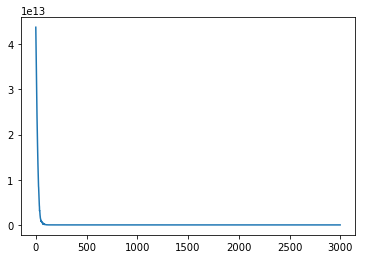

In [28]:
#plt.ylim([-10000,20000]) 
plt.plot(vae_model_d2_k1['train_losses_list'])

In [29]:
x = vae_model_d2_k1['model'].generate_samples(10)
x.shape

sample_prior  torch.Size([10, 5])
generate_samples  torch.Size([10, 900]) torch.Size([10, 900])


torch.Size([10, 900])

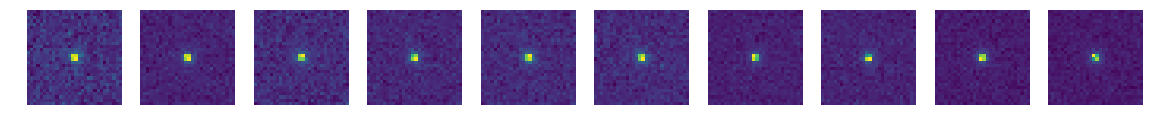

In [30]:
show_images(x)

sample_prior1  torch.Size([10, 5])
generate_samples  torch.Size([10, 900]) torch.Size([10, 900])


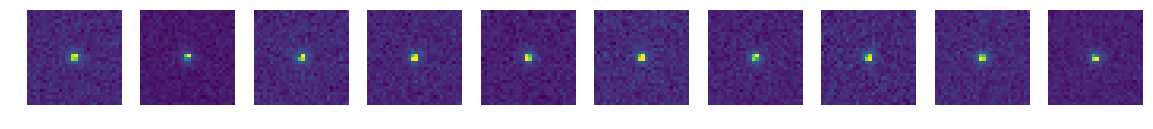

In [31]:
x = vae_model_d2_k1['model'].generate_samples1(10)
x.shape
show_images(x)

In [122]:
predicted_stack = vae_model_d2_k1['model'].generate_samples(5000)
predicted_stack.shape

torch.Size([5000, 900])

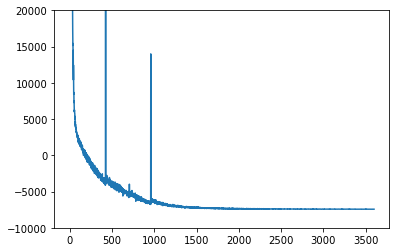

In [68]:
plt.ylim([-10000,20000]) 
plt.plot(vae_model_d2_k1_log['train_losses_list'])